In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import training as tr
import emnet

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

## Write events to a DataFrame

In [ ]:
datfile = "/home/jrenner/local/data/electronsim/pixelated_tracks_thinned_4um_back_10M_300keV.txt"

In [93]:
rng_pixels = np.arange(-(tr.EVT_SIZE-1)/2,(tr.EVT_SIZE-1)/2+1)
coords_pixels_all = np.meshgrid(rng_pixels,rng_pixels)

def read_electron_data(fname, nevts=1000):
    
    evt = -1
    xinc = 0.0
    yinc = 0.0
    front = True
    energy = 0.0
    
    # Open the file and read the specified number of events.
    l_evt, l_xinc, l_yinc, l_front, l_energy, l_row, l_col, l_counts = [], [], [], [], [], [], [], []
    evts_read = 0
    with open(fname) as f:
        
        # Iterate through all lines.
        for line in f:
            
            # Stop reading if we've read the specified number of events.
            if(evts_read > nevts):
                break
            
            # Get each number in the line, separated by spaces.
            vals = line.rstrip().split(" ")
            
            # Start a new event.
            if(vals[0] == "EV"):
                evt    = vals[1]
                xinc   = vals[2]
                yinc   = vals[3]
                front  = (vals[4] == 1)
                energy = vals[5]
                evts_read += 1
                
            # Add a row for the current event.
            else:
                l_evt.append(int(evt))
                l_xinc.append(float(xinc))
                l_yinc.append(float(yinc))
                l_front.append(front)
                l_energy.append(float(energy))
                l_row.append(int(vals[0]))
                l_col.append(int(vals[1]))
                l_counts.append(int(vals[2]))
    
    # Construct the DataFrame.
    evt_dict = {'event': l_evt, 'xinc': l_xinc, 'yinc': l_yinc, 'front': l_front, 
                'energy': l_energy, 'row': l_row, 'col': l_col, 'counts': l_counts}
    df = pd.DataFrame.from_dict(evt_dict)
    
    return df

def compute_moments(evt_arr,args,order,pixel_size,coords_pixels):
    """
    Compute the x- and y-moments of the specified order.
    
    evt_arr: the original (unmodified) event array
    args:    the arguments into evt_arr of the pixels to be included
    order:   the order of the moment
    """
    
    xsum = 0  # x-moment sum
    ysum = 0  # y-moment sum
    tsum = 0  # total sum
    for arg in args:

        px = evt_arr[(arg[0],arg[1])]
        x  = coords_pixels[0][(arg[0],arg[1])]*pixel_size
        y  = coords_pixels[1][(arg[0],arg[1])]*pixel_size
        
        xsum += px*x**order
        ysum += px*y**order
        tsum += px
    
    if(tsum > 0):
        
        mx = xsum/tsum
        my = ysum/tsum

        return mx,my
    
    else:
        return 0.,0.

def compute_key_quantities(evt_arr,pixel_size,threshold=40):
    """
    Get key quantities from the event array.
    """
    
    # Get the pixels above threshold and their corresponding arguments in the array.
    pixels_above_threshold = evt_arr[evt_arr > threshold]
    args_above_threshold = np.argwhere(evt_arr > threshold)
    arg_max = np.unravel_index(np.argmax(evt_arr),evt_arr.shape)
    xmax = coords_pixels_all[0][arg_max]*pixel_size
    ymax = coords_pixels_all[1][arg_max]*pixel_size
    #print("xmax",xmax,"ymax",ymax)
    
    # number of pixels above threshold
    n_above_threshold = len(args_above_threshold)

    # sum of pixels above threshold
    sum_above_threshold = np.sum(pixels_above_threshold)

    # maximum distance between pixels above threshold
    max_dist = 0
    for arg0 in args_above_threshold:
        for arg1 in args_above_threshold:
            dist = ((arg0[0] - arg1[0])**2 + (arg0[1] - arg1[1])**2)**0.5
            if(dist > max_dist):
                max_dist = dist
    max_dist_above_threshold = max_dist*pixel_size

    # moments for pixels above threshold
    m1x, m1y = compute_moments(evt_arr,args_above_threshold,1,pixel_size,coords_pixels_all)
    m2x, m2y = compute_moments(evt_arr,args_above_threshold,2,pixel_size,coords_pixels_all)

    # moments for 3x3 region about maximum
    max_3x3 = evt_arr[max(arg_max[0]-1,0):min(arg_max[0]+2,evt_arr.shape[0]),max(arg_max[1]-1,0):min(arg_max[1]+2,evt_arr.shape[1])]
    coords_pixels_3x3 = [coords_pixels_all[0][max(arg_max[0]-2,0):min(arg_max[0]+3,evt_arr.shape[0]),max(arg_max[1]-2,0):min(arg_max[1]+3,evt_arr.shape[1])],
                         coords_pixels_all[1][max(arg_max[0]-2,0):min(arg_max[0]+3,evt_arr.shape[0]),max(arg_max[1]-2,0):min(arg_max[1]+3,evt_arr.shape[1])]]
    args_3x3 = np.argwhere(max_3x3 > 0)
    args_3x3_above_threshold = np.argwhere(max_3x3 > threshold)
    xc_3x3, yc_3x3 = compute_moments(max_3x3,args_3x3,1,pixel_size,coords_pixels_3x3)
    xc_3x3_above_threshold, yc_3x3_above_threshold = compute_moments(max_3x3,args_3x3_above_threshold,1,pixel_size,coords_pixels_3x3)
    
    xc_3x3 = xc_3x3 + xmax
    yc_3x3 = yc_3x3 + ymax
    xc_3x3_above_threshold = xc_3x3_above_threshold + xmax
    yc_3x3_above_threshold = yc_3x3_above_threshold + ymax

    # moments for 5x5 region about maximum
    max_5x5 = evt_arr[max(arg_max[0]-2,0):min(arg_max[0]+3,evt_arr.shape[0]),max(arg_max[1]-2,0):min(arg_max[1]+3,evt_arr.shape[1])]
    coords_pixels_5x5 = [coords_pixels_all[0][max(arg_max[0]-2,0):min(arg_max[0]+3,evt_arr.shape[0]),max(arg_max[1]-2,0):min(arg_max[1]+3,evt_arr.shape[1])],
                         coords_pixels_all[1][max(arg_max[0]-2,0):min(arg_max[0]+3,evt_arr.shape[0]),max(arg_max[1]-2,0):min(arg_max[1]+3,evt_arr.shape[1])]]
    args_5x5 = np.argwhere(max_5x5 > 0)
    args_5x5_above_threshold = np.argwhere(max_5x5 > threshold)
    xc_5x5, yc_5x5 = compute_moments(max_5x5,args_5x5,1,pixel_size,coords_pixels_5x5)
    xc_5x5_above_threshold, yc_5x5_above_threshold = compute_moments(max_5x5,args_5x5_above_threshold,1,pixel_size,coords_pixels_5x5)
    
    xc_5x5 = xc_5x5 + xmax
    yc_5x5 = yc_5x5 + ymax
    xc_5x5_above_threshold = xc_5x5_above_threshold + xmax
    yc_5x5_above_threshold = yc_5x5_above_threshold + ymax
    
    return [n_above_threshold, sum_above_threshold, max_dist_above_threshold,
            xmax, ymax,
            m1x, m1y, m2x, m2y, 
            xc_3x3, yc_3x3, xc_3x3_above_threshold, yc_3x3_above_threshold,
            xc_5x5, yc_5x5, xc_5x5_above_threshold, yc_5x5_above_threshold]

def construct_evt_dataframe(dset,pixel_size,threshold=40):
    """
    Constructs a dataframe containing key information for each of the specified events.
    """
    
    l_n_above_threshold, l_sum_above_threshold, l_max_dist_above_threshold = [], [], []
    l_xmax, l_ymax = [], []
    l_m1_x_above_threshold, l_m1_y_above_threshold, l_m2_x_above_threshold, l_m2_y_above_threshold = [], [], [], []
    l_xc_3x3, l_yc_3x3, l_xc_3x3_above_threshold, l_yc_3x3_above_threshold = [], [], [], []
    l_xc_5x5, l_yc_5x5, l_xc_5x5_above_threshold, l_yc_5x5_above_threshold = [], [], [], []
    
    for i in range(100): #len(dset)):
        
        # Get the event pixel information.
        evt_item = dset[i]
        evt_arr = evt_item[0]
        
        [n_above_threshold, sum_above_threshold, max_dist_above_threshold, 
            xmax, ymax,
            m1x, m1y, m2x, m2y, 
            xc_3x3, yc_3x3, xc_3x3_above_threshold, yc_3x3_above_threshold,
            xc_5x5, yc_5x5, xc_5x5_above_threshold, yc_5x5_above_threshold] = compute_key_quantities(evt_arr,pixel_size)
        
        l_n_above_threshold.append(n_above_threshold)
        l_sum_above_threshold.append(sum_above_threshold)
        l_max_dist_above_threshold.append(max_dist_above_threshold)
        l_xmax.append(xmax)
        l_ymax.append(ymax)
        l_m1_x_above_threshold.append(m1x)
        l_m1_y_above_threshold.append(m1y)
        l_m2_x_above_threshold.append(m2x)
        l_m2_y_above_threshold.append(m2y)
        l_xc_3x3.append(xc_3x3)
        l_yc_3x3.append(yc_3x3)
        l_xc_3x3_above_threshold.append(xc_3x3_above_threshold)
        l_yc_3x3_above_threshold.append(yc_3x3_above_threshold)
        l_xc_5x5.append(xc_5x5)
        l_yc_5x5.append(yc_5x5)
        l_xc_5x5_above_threshold.append(xc_5x5_above_threshold)
        l_yc_5x5_above_threshold.append(yc_5x5_above_threshold)
        
    # Construct the DataFrame.
    evt_dict = {'n_above_threshold': l_n_above_threshold, 
                'sum_above_threshold': l_sum_above_threshold, 
                'max_dist_above_threshold': l_max_dist_above_threshold,
                'xmax': l_xmax,
                'ymax': l_ymax,
                'm1_x_above_threshold': l_m1_x_above_threshold, 
                'm1_y_above_threshold': l_m1_y_above_threshold,
                'm2_x_above_threshold': l_m2_x_above_threshold,
                'm2_y_above_threshold': l_m2_y_above_threshold,
                'xc_3x3': l_xc_3x3,
                'yc_3x3': l_yc_3x3,
                'xc_3x3_above_threshold': l_xc_3x3_above_threshold,
                'yc_3x3_above_threshold': l_yc_3x3_above_threshold,
                'xc_5x5': l_xc_5x5,
                'yc_5x5': l_yc_5x5,
                'xc_5x5_above_threshold': l_xc_5x5_above_threshold,
                'yc_5x5_above_threshold': l_yc_5x5_above_threshold}
    df = pd.DataFrame.from_dict(evt_dict)
    
    return df


In [ ]:
# Read a new dataset.
df = read_electron_data(datfile,nevts=100005)
df.to_pickle("EM_4um_back_10M_300keV.pkl")

In [97]:
dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=0,add_shift=0,add_noise=True)

Created dataset for events from 0 to 100000


In [98]:
df_evt = construct_evt_dataframe(dset,tr.PIXEL_SIZE)

In [99]:
df_evt

,n_above_threshold,sum_above_threshold,max_dist_above_threshold,xmax,ymax,m1_x_above_threshold,m1_y_above_threshold,m2_x_above_threshold,m2_y_above_threshold,xc_3x3,yc_3x3,xc_3x3_above_threshold,yc_3x3_above_threshold,xc_5x5,yc_5x5,xc_5x5_above_threshold,yc_5x5_above_threshold
0,4,328.0,0.007071,0.0,0.0,-0.001601,0.002058,0.000008,0.000010,-0.005622,-0.003234,-0.006601,-0.002942,-0.000937,0.002058,-0.001601,0.002058
1,2,158.0,0.005000,0.0,0.0,-0.001361,0.000000,0.000007,0.000000,-0.005714,-0.004927,-0.006361,-0.005000,-0.000803,0.000180,-0.001361,0.000000
2,2,190.0,0.005000,0.0,0.0,0.002316,0.000000,0.000012,0.000000,-0.003157,-0.004968,-0.002684,-0.005000,0.002042,0.000085,0.002316,0.000000
3,3,186.0,0.007071,0.0,0.0,0.001263,0.001344,0.000006,0.000007,-0.004077,-0.003711,-0.003737,-0.003656,0.001051,0.001562,0.001263,0.001344
4,8,2536.0,0.015000,0.0,0.0,0.000558,-0.001978,0.000006,0.000012,-0.004414,-0.006645,-0.004431,-0.006816,0.000693,-0.001921,0.000558,-0.001978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,8,2712.0,0.015000,0.0,0.0,0.002277,0.000009,0.000013,0.000005,-0.003058,-0.004974,-0.002904,-0.004991,0.002185,0.000010,0.002277,0.000009
96,2,117.0,0.005000,0.0,0.0,-0.001838,0.000000,0.000009,0.000000,-0.006475,-0.005246,-0.006838,-0.005000,-0.001330,-0.000517,-0.001838,0.000000
97,1,119.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,-0.005613,-0.005870,-0.005000,-0.005000,-0.000661,-0.001085,0.000000,0.000000
98,0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,-0.003413,-0.006250,0.000000,0.000000,0.001944,-0.002143,0.000000,0.000000


### Examine individual events

In [ ]:
evt_plt = 97
evt_arr = np.zeros([101,101])
df_evt = df[df.event == evt_plt]
for row,col,counts in zip(df_evt['row'].values,df_evt['col'].values,df_evt['counts'].values):
    evt_arr[row,col] += counts
plt.imshow(np.log(0.1 + evt_arr))
plt.colorbar()
plt.title("Event {}; max at {}".format(evt_plt,np.unravel_index(evt_arr.argmax(),evt_arr.shape)))

In [ ]:
max(df.xinc.values)

## Evaluate a dataset

In [ ]:
Nevts = 1000

In [ ]:
noise_arr = np.arange(0.,100.,50.)
r_mean, r_sigma = [], []
for noise in noise_arr:
    print("Running for noise",noise)
    dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",0,noise)
    
    shifts_x, shifts_y, shifts_r = [], [], []
    for evt in range(Nevts):
        evt_arr,evt_lbl = dset[evt]
        xs,ys = evt_lbl[0],evt_lbl[1]
        shifts_x.append(xs)
        shifts_y.append(ys)
        shifts_r.append((xs**2 + ys**2)**0.5)
    
    shifts_r = np.array(shifts_r)
    r_mean.append(np.mean(shifts_r))
    r_sigma.append(np.std(shifts_r))

In [ ]:
plt.errorbar(noise_arr,r_mean,yerr=np.array(r_sigma)/Nevts**0.5)
plt.xlabel("$\sigma$ noise (electrons)")
plt.ylabel("r-error (mm)")

### Read a dataset

In [ ]:
dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_shift=10,add_noise=True)

In [ ]:
evt_plt = 8
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift {}; index {}".format(evt_plt,evt_lbl,evt_err_ind))

In [ ]:
shifts_x, shifts_y, shifts_r = [], [], []
for evt in range(1000):
    evt_arr,evt_lbl = dset[evt]
    xs,ys = evt_lbl[0],evt_lbl[1]
    shifts_x.append(xs)
    shifts_y.append(ys)
    shifts_r.append((xs**2 + ys**2)**0.5)

In [ ]:
plt.hist(shifts_r,bins=100)
plt.yscale('log')

#### For debugging the 3x3 sum operations

In [ ]:
aa = np.ones([6,6])
aa[0,2] = 4
aa[1,2] = 2
aa[3,2] = 8
aa[4,2] = -2
aa[3,1] = 5
aa[5,0] = 10
aa

In [ ]:
max_init   = np.unravel_index(aa.argmax(),aa.shape)
nbsum_init = tr.sum_neighbors(aa,max_init,remove=True)
print("Max at",max_init,"and neighbor sum",nbsum_init)
aa

## Train a network

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import training as tr
import emnet

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from scipy.optimize import curve_fit

In [6]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-5   # Learning rate to use in the training.
load_model  = True   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 244      # Number of initial epoch
epoch_end   = 2000    # Number of final epoch
model_load_checkpoint = "{}/model_80cells_noise_100k_243.pt".format(modeldir)

# Create the datasets.
dataset_all   = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=10)
dataset_train = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=0,nend=-20000,add_shift=10)
dataset_val   = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=-20000,add_shift=10)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
val_loader = DataLoader(dataset_val, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
#val_loader = DataLoader(dataset_val, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)
#test_loader = DataLoader(dataset_test, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)

# Define the model.
#model = emnet.FCNet()
model = emnet.basicCNN()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-6, weight_decay=0.01, amsgrad=True)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

Created dataset for events from 0 to 100000
Created dataset for events from 0 to -20000
Created dataset for events from -20000 to 20000


In [7]:
# Run the training.
#print("Training with weights",sort_clsweights)
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    tr.train(model, epoch, train_loader, optimizer)
    with torch.no_grad():
        model.eval()
        tr.val(model, epoch, val_loader)
#     if(epoch % 50 == 0):
#         torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

Epoch:  244
Train Epoch: 244 [0/80000 (0%)]	Loss: 6.246392	 score_max: 18.599352	 score_min: -3.052164; Accuracy 0.033
Train Epoch: 244 [1000/80000 (1%)]	Loss: 6.218474	 score_max: 11.355800	 score_min: -1.998610; Accuracy 0.029
Train Epoch: 244 [2000/80000 (2%)]	Loss: 6.301766	 score_max: 10.472183	 score_min: -2.142910; Accuracy 0.025
Train Epoch: 244 [3000/80000 (4%)]	Loss: 6.293209	 score_max: 12.347317	 score_min: -2.295405; Accuracy 0.024
Train Epoch: 244 [4000/80000 (5%)]	Loss: 6.224163	 score_max: 10.501146	 score_min: -2.098818; Accuracy 0.030
Train Epoch: 244 [5000/80000 (6%)]	Loss: 6.200016	 score_max: 10.582801	 score_min: -2.108682; Accuracy 0.027
Train Epoch: 244 [6000/80000 (8%)]	Loss: 6.183043	 score_max: 11.321515	 score_min: -2.308749; Accuracy 0.034
Train Epoch: 244 [7000/80000 (9%)]	Loss: 6.207939	 score_max: 11.865996	 score_min: -2.363974; Accuracy 0.026
Train Epoch: 244 [8000/80000 (10%)]	Loss: 6.284079	 score_max: 12.357971	 score_min: -2.304990; Accuracy 0.027


Train Epoch: 244 [79000/80000 (99%)]	Loss: 6.185690	 score_max: 15.700406	 score_min: -2.866004; Accuracy 0.029
---EPOCH AVG TRAIN LOSS: 6.236616230010986 ACCURACY: 0.030800001043826342
--Val Epoch: 244 [0/20000 (0%)]	Loss: 6.041421	 score_max: 10.955732	 score_min: -2.037765; Accuracy 0.086
--Val Epoch: 244 [1000/20000 (5%)]	Loss: 6.090670	 score_max: 6.422424	 score_min: -1.320270; Accuracy 0.095
--Val Epoch: 244 [2000/20000 (10%)]	Loss: 6.069643	 score_max: 6.233113	 score_min: -1.337483; Accuracy 0.093
--Val Epoch: 244 [3000/20000 (15%)]	Loss: 6.095212	 score_max: 6.379220	 score_min: -1.325713; Accuracy 0.079
--Val Epoch: 244 [4000/20000 (20%)]	Loss: 6.082526	 score_max: 7.098340	 score_min: -1.242429; Accuracy 0.084
--Val Epoch: 244 [5000/20000 (25%)]	Loss: 6.096793	 score_max: 6.470199	 score_min: -1.271665; Accuracy 0.095
--Val Epoch: 244 [6000/20000 (30%)]	Loss: 6.069111	 score_max: 5.994025	 score_min: -1.183920; Accuracy 0.091
--Val Epoch: 244 [7000/20000 (35%)]	Loss: 6.0627

Train Epoch: 245 [54000/80000 (68%)]	Loss: 6.236019	 score_max: 11.194478	 score_min: -2.146909; Accuracy 0.026
Train Epoch: 245 [55000/80000 (69%)]	Loss: 6.212476	 score_max: 12.221148	 score_min: -2.292315; Accuracy 0.038
Train Epoch: 245 [56000/80000 (70%)]	Loss: 6.360009	 score_max: 10.749259	 score_min: -2.139742; Accuracy 0.035
Train Epoch: 245 [57000/80000 (71%)]	Loss: 6.249705	 score_max: 10.635284	 score_min: -1.946073; Accuracy 0.028
Train Epoch: 245 [58000/80000 (72%)]	Loss: 6.230952	 score_max: 11.972880	 score_min: -2.365361; Accuracy 0.031
Train Epoch: 245 [59000/80000 (74%)]	Loss: 6.327528	 score_max: 24.716921	 score_min: -4.503901; Accuracy 0.028
Train Epoch: 245 [60000/80000 (75%)]	Loss: 6.267052	 score_max: 11.068226	 score_min: -2.245031; Accuracy 0.027
Train Epoch: 245 [61000/80000 (76%)]	Loss: 6.298754	 score_max: 12.582477	 score_min: -2.146569; Accuracy 0.025
Train Epoch: 245 [62000/80000 (78%)]	Loss: 6.254477	 score_max: 11.324753	 score_min: -2.206904; Accurac

Train Epoch: 246 [28000/80000 (35%)]	Loss: 6.172927	 score_max: 9.335255	 score_min: -1.989674; Accuracy 0.036
Train Epoch: 246 [29000/80000 (36%)]	Loss: 6.200052	 score_max: 11.507454	 score_min: -2.050262; Accuracy 0.026
Train Epoch: 246 [30000/80000 (38%)]	Loss: 6.221467	 score_max: 11.349627	 score_min: -2.134055; Accuracy 0.045
Train Epoch: 246 [31000/80000 (39%)]	Loss: 6.143671	 score_max: 11.107231	 score_min: -2.016798; Accuracy 0.040
Train Epoch: 246 [32000/80000 (40%)]	Loss: 6.250113	 score_max: 10.546774	 score_min: -2.023626; Accuracy 0.030
Train Epoch: 246 [33000/80000 (41%)]	Loss: 6.305829	 score_max: 9.926712	 score_min: -1.911312; Accuracy 0.036
Train Epoch: 246 [34000/80000 (42%)]	Loss: 6.254233	 score_max: 11.679154	 score_min: -2.137198; Accuracy 0.032
Train Epoch: 246 [35000/80000 (44%)]	Loss: 6.215228	 score_max: 10.671449	 score_min: -2.044195; Accuracy 0.035
Train Epoch: 246 [36000/80000 (45%)]	Loss: 6.213251	 score_max: 10.396349	 score_min: -2.182742; Accuracy 

Train Epoch: 247 [6000/80000 (8%)]	Loss: 6.236113	 score_max: 12.514257	 score_min: -2.101161; Accuracy 0.029
Train Epoch: 247 [7000/80000 (9%)]	Loss: 6.210186	 score_max: 10.174946	 score_min: -2.006991; Accuracy 0.041
Train Epoch: 247 [8000/80000 (10%)]	Loss: 6.355847	 score_max: 10.412189	 score_min: -2.127050; Accuracy 0.030
Train Epoch: 247 [9000/80000 (11%)]	Loss: 6.226567	 score_max: 12.243763	 score_min: -2.129432; Accuracy 0.036
Train Epoch: 247 [10000/80000 (12%)]	Loss: 6.221771	 score_max: 12.481916	 score_min: -2.435249; Accuracy 0.033
Train Epoch: 247 [11000/80000 (14%)]	Loss: 6.278945	 score_max: 12.176021	 score_min: -2.217982; Accuracy 0.029
Train Epoch: 247 [12000/80000 (15%)]	Loss: 6.273158	 score_max: 11.276332	 score_min: -1.977038; Accuracy 0.032
Train Epoch: 247 [13000/80000 (16%)]	Loss: 6.290213	 score_max: 10.312583	 score_min: -2.093479; Accuracy 0.029
Train Epoch: 247 [14000/80000 (18%)]	Loss: 6.203464	 score_max: 10.174647	 score_min: -2.161675; Accuracy 0.02

--Val Epoch: 247 [0/20000 (0%)]	Loss: 5.980563	 score_max: 6.925900	 score_min: -1.217031; Accuracy 0.100
--Val Epoch: 247 [1000/20000 (5%)]	Loss: 6.023040	 score_max: 6.588262	 score_min: -1.457557; Accuracy 0.094
--Val Epoch: 247 [2000/20000 (10%)]	Loss: 6.012163	 score_max: 8.094097	 score_min: -1.282582; Accuracy 0.096
--Val Epoch: 247 [3000/20000 (15%)]	Loss: 5.983896	 score_max: 7.182825	 score_min: -1.306629; Accuracy 0.096
--Val Epoch: 247 [4000/20000 (20%)]	Loss: 5.961373	 score_max: 6.713634	 score_min: -1.221171; Accuracy 0.091
--Val Epoch: 247 [5000/20000 (25%)]	Loss: 5.990258	 score_max: 6.929683	 score_min: -1.358897; Accuracy 0.105
--Val Epoch: 247 [6000/20000 (30%)]	Loss: 5.989089	 score_max: 7.604674	 score_min: -1.364236; Accuracy 0.083
--Val Epoch: 247 [7000/20000 (35%)]	Loss: 6.007122	 score_max: 10.972792	 score_min: -1.722093; Accuracy 0.097
--Val Epoch: 247 [8000/20000 (40%)]	Loss: 6.038581	 score_max: 7.312863	 score_min: -1.466505; Accuracy 0.090
--Val Epoch: 2

Train Epoch: 248 [55000/80000 (69%)]	Loss: 6.214643	 score_max: 13.019245	 score_min: -2.587969; Accuracy 0.039
Train Epoch: 248 [56000/80000 (70%)]	Loss: 6.230942	 score_max: 10.663172	 score_min: -2.219382; Accuracy 0.036
Train Epoch: 248 [57000/80000 (71%)]	Loss: 6.188068	 score_max: 11.477005	 score_min: -1.981586; Accuracy 0.041
Train Epoch: 248 [58000/80000 (72%)]	Loss: 6.304682	 score_max: 10.504929	 score_min: -2.054308; Accuracy 0.029
Train Epoch: 248 [59000/80000 (74%)]	Loss: 6.282797	 score_max: 12.409027	 score_min: -2.631857; Accuracy 0.042
Train Epoch: 248 [60000/80000 (75%)]	Loss: 6.206425	 score_max: 14.739207	 score_min: -2.839910; Accuracy 0.026
Train Epoch: 248 [61000/80000 (76%)]	Loss: 6.289972	 score_max: 22.085609	 score_min: -3.748365; Accuracy 0.043
Train Epoch: 248 [62000/80000 (78%)]	Loss: 6.230056	 score_max: 11.348230	 score_min: -2.446862; Accuracy 0.021
Train Epoch: 248 [63000/80000 (79%)]	Loss: 6.250068	 score_max: 13.785698	 score_min: -2.843831; Accurac

Train Epoch: 249 [32000/80000 (40%)]	Loss: 6.240630	 score_max: 10.157644	 score_min: -2.104394; Accuracy 0.034
Train Epoch: 249 [33000/80000 (41%)]	Loss: 6.282077	 score_max: 10.663349	 score_min: -1.938311; Accuracy 0.035
Train Epoch: 249 [34000/80000 (42%)]	Loss: 6.185098	 score_max: 12.283480	 score_min: -2.063911; Accuracy 0.036
Train Epoch: 249 [35000/80000 (44%)]	Loss: 6.160957	 score_max: 10.984982	 score_min: -1.883381; Accuracy 0.034
Train Epoch: 249 [36000/80000 (45%)]	Loss: 6.205428	 score_max: 10.976124	 score_min: -2.406953; Accuracy 0.042
Train Epoch: 249 [37000/80000 (46%)]	Loss: 6.264735	 score_max: 11.077735	 score_min: -2.127641; Accuracy 0.036
Train Epoch: 249 [38000/80000 (48%)]	Loss: 6.200771	 score_max: 11.676045	 score_min: -2.108496; Accuracy 0.038
Train Epoch: 249 [39000/80000 (49%)]	Loss: 6.203475	 score_max: 13.603624	 score_min: -1.985595; Accuracy 0.026
Train Epoch: 249 [40000/80000 (50%)]	Loss: 6.167943	 score_max: 10.710218	 score_min: -2.023924; Accurac

Train Epoch: 250 [7000/80000 (9%)]	Loss: 6.211064	 score_max: 11.017908	 score_min: -1.951441; Accuracy 0.040
Train Epoch: 250 [8000/80000 (10%)]	Loss: 6.314272	 score_max: 11.400729	 score_min: -2.151899; Accuracy 0.028
Train Epoch: 250 [9000/80000 (11%)]	Loss: 6.214290	 score_max: 10.812634	 score_min: -1.871524; Accuracy 0.035
Train Epoch: 250 [10000/80000 (12%)]	Loss: 6.209016	 score_max: 10.368309	 score_min: -1.966806; Accuracy 0.035
Train Epoch: 250 [11000/80000 (14%)]	Loss: 6.228128	 score_max: 10.844419	 score_min: -2.389068; Accuracy 0.036
Train Epoch: 250 [12000/80000 (15%)]	Loss: 6.176029	 score_max: 11.104157	 score_min: -2.020147; Accuracy 0.040
Train Epoch: 250 [13000/80000 (16%)]	Loss: 6.208354	 score_max: 10.972685	 score_min: -2.002694; Accuracy 0.028
Train Epoch: 250 [14000/80000 (18%)]	Loss: 6.287568	 score_max: 11.962656	 score_min: -2.088264; Accuracy 0.034
Train Epoch: 250 [15000/80000 (19%)]	Loss: 6.257649	 score_max: 17.738392	 score_min: -2.986408; Accuracy 0.

--Val Epoch: 250 [0/20000 (0%)]	Loss: 6.071816	 score_max: 6.944142	 score_min: -1.267778; Accuracy 0.105
--Val Epoch: 250 [1000/20000 (5%)]	Loss: 6.080453	 score_max: 6.203352	 score_min: -1.255471; Accuracy 0.107
--Val Epoch: 250 [2000/20000 (10%)]	Loss: 6.076759	 score_max: 6.140175	 score_min: -1.274013; Accuracy 0.084
--Val Epoch: 250 [3000/20000 (15%)]	Loss: 6.120426	 score_max: 6.513330	 score_min: -1.194070; Accuracy 0.117
--Val Epoch: 250 [4000/20000 (20%)]	Loss: 6.064116	 score_max: 6.570673	 score_min: -1.207885; Accuracy 0.122
--Val Epoch: 250 [5000/20000 (25%)]	Loss: 6.045067	 score_max: 6.425155	 score_min: -1.219298; Accuracy 0.092
--Val Epoch: 250 [6000/20000 (30%)]	Loss: 6.089233	 score_max: 7.429004	 score_min: -1.149729; Accuracy 0.095
--Val Epoch: 250 [7000/20000 (35%)]	Loss: 6.026783	 score_max: 6.473033	 score_min: -1.215176; Accuracy 0.118
--Val Epoch: 250 [8000/20000 (40%)]	Loss: 6.107078	 score_max: 6.124226	 score_min: -1.165581; Accuracy 0.081
--Val Epoch: 25

Train Epoch: 251 [56000/80000 (70%)]	Loss: 6.225111	 score_max: 10.093239	 score_min: -1.988685; Accuracy 0.036
Train Epoch: 251 [57000/80000 (71%)]	Loss: 6.190811	 score_max: 12.243107	 score_min: -2.009077; Accuracy 0.044
Train Epoch: 251 [58000/80000 (72%)]	Loss: 6.237245	 score_max: 13.509066	 score_min: -2.077846; Accuracy 0.029
Train Epoch: 251 [59000/80000 (74%)]	Loss: 6.222115	 score_max: 10.798680	 score_min: -2.110361; Accuracy 0.033
Train Epoch: 251 [60000/80000 (75%)]	Loss: 6.200764	 score_max: 10.500610	 score_min: -2.063892; Accuracy 0.030
Train Epoch: 251 [61000/80000 (76%)]	Loss: 6.193999	 score_max: 11.964822	 score_min: -2.206406; Accuracy 0.033
Train Epoch: 251 [62000/80000 (78%)]	Loss: 6.159399	 score_max: 10.302670	 score_min: -1.995312; Accuracy 0.037
Train Epoch: 251 [63000/80000 (79%)]	Loss: 6.364978	 score_max: 12.042876	 score_min: -2.109799; Accuracy 0.028
Train Epoch: 251 [64000/80000 (80%)]	Loss: 6.152846	 score_max: 11.415177	 score_min: -1.926475; Accurac

Train Epoch: 252 [30000/80000 (38%)]	Loss: 6.225074	 score_max: 11.394987	 score_min: -2.051827; Accuracy 0.038
Train Epoch: 252 [31000/80000 (39%)]	Loss: 6.243727	 score_max: 10.208414	 score_min: -2.478684; Accuracy 0.026
Train Epoch: 252 [32000/80000 (40%)]	Loss: 6.195957	 score_max: 12.305668	 score_min: -2.216766; Accuracy 0.026
Train Epoch: 252 [33000/80000 (41%)]	Loss: 6.234447	 score_max: 11.254406	 score_min: -2.198531; Accuracy 0.041
Train Epoch: 252 [34000/80000 (42%)]	Loss: 6.207431	 score_max: 10.259723	 score_min: -2.374268; Accuracy 0.023
Train Epoch: 252 [35000/80000 (44%)]	Loss: 6.213179	 score_max: 11.741515	 score_min: -2.306210; Accuracy 0.043
Train Epoch: 252 [36000/80000 (45%)]	Loss: 6.173504	 score_max: 10.511761	 score_min: -1.947268; Accuracy 0.052
Train Epoch: 252 [37000/80000 (46%)]	Loss: 6.229489	 score_max: 12.239877	 score_min: -2.110162; Accuracy 0.034
Train Epoch: 252 [38000/80000 (48%)]	Loss: 6.302598	 score_max: 9.669518	 score_min: -1.945590; Accuracy

Train Epoch: 253 [8000/80000 (10%)]	Loss: 6.310848	 score_max: 12.630407	 score_min: -2.596016; Accuracy 0.026
Train Epoch: 253 [9000/80000 (11%)]	Loss: 6.237036	 score_max: 10.950336	 score_min: -2.402050; Accuracy 0.038
Train Epoch: 253 [10000/80000 (12%)]	Loss: 6.311075	 score_max: 12.605869	 score_min: -2.062343; Accuracy 0.031
Train Epoch: 253 [11000/80000 (14%)]	Loss: 6.240556	 score_max: 10.879565	 score_min: -1.884218; Accuracy 0.027
Train Epoch: 253 [12000/80000 (15%)]	Loss: 6.236886	 score_max: 12.037235	 score_min: -2.656994; Accuracy 0.036
Train Epoch: 253 [13000/80000 (16%)]	Loss: 6.245336	 score_max: 12.228627	 score_min: -2.176335; Accuracy 0.032
Train Epoch: 253 [14000/80000 (18%)]	Loss: 6.161616	 score_max: 10.009819	 score_min: -2.085638; Accuracy 0.033
Train Epoch: 253 [15000/80000 (19%)]	Loss: 6.159314	 score_max: 12.228848	 score_min: -2.104389; Accuracy 0.031
Train Epoch: 253 [16000/80000 (20%)]	Loss: 6.254265	 score_max: 10.429502	 score_min: -1.900247; Accuracy 

--Val Epoch: 253 [5000/20000 (25%)]	Loss: 6.074637	 score_max: 6.055298	 score_min: -1.178928; Accuracy 0.095
--Val Epoch: 253 [6000/20000 (30%)]	Loss: 6.063755	 score_max: 19.490965	 score_min: -3.473078; Accuracy 0.101
--Val Epoch: 253 [7000/20000 (35%)]	Loss: 6.025398	 score_max: 6.354759	 score_min: -1.255208; Accuracy 0.093
--Val Epoch: 253 [8000/20000 (40%)]	Loss: 6.079000	 score_max: 6.217849	 score_min: -1.276196; Accuracy 0.095
--Val Epoch: 253 [9000/20000 (45%)]	Loss: 6.022360	 score_max: 6.259523	 score_min: -1.189462; Accuracy 0.094
--Val Epoch: 253 [10000/20000 (50%)]	Loss: 6.093980	 score_max: 6.226022	 score_min: -1.372394; Accuracy 0.080
--Val Epoch: 253 [11000/20000 (55%)]	Loss: 6.071436	 score_max: 13.364496	 score_min: -2.856014; Accuracy 0.083
--Val Epoch: 253 [12000/20000 (60%)]	Loss: 6.151650	 score_max: 7.954853	 score_min: -1.240160; Accuracy 0.090
--Val Epoch: 253 [13000/20000 (65%)]	Loss: 6.087896	 score_max: 6.120939	 score_min: -1.246076; Accuracy 0.095
--Va

Train Epoch: 254 [58000/80000 (72%)]	Loss: 6.184565	 score_max: 10.165888	 score_min: -2.055236; Accuracy 0.036
Train Epoch: 254 [59000/80000 (74%)]	Loss: 6.185267	 score_max: 11.943098	 score_min: -2.199505; Accuracy 0.024
Train Epoch: 254 [60000/80000 (75%)]	Loss: 6.231400	 score_max: 10.820899	 score_min: -2.050522; Accuracy 0.050
Train Epoch: 254 [61000/80000 (76%)]	Loss: 6.260605	 score_max: 11.793145	 score_min: -2.042411; Accuracy 0.035
Train Epoch: 254 [62000/80000 (78%)]	Loss: 6.276447	 score_max: 9.996840	 score_min: -1.942618; Accuracy 0.041
Train Epoch: 254 [63000/80000 (79%)]	Loss: 6.297643	 score_max: 12.632270	 score_min: -2.368924; Accuracy 0.036
Train Epoch: 254 [64000/80000 (80%)]	Loss: 6.176669	 score_max: 13.819638	 score_min: -2.648305; Accuracy 0.036
Train Epoch: 254 [65000/80000 (81%)]	Loss: 6.217507	 score_max: 11.800494	 score_min: -2.107891; Accuracy 0.043
Train Epoch: 254 [66000/80000 (82%)]	Loss: 6.205876	 score_max: 11.010619	 score_min: -2.071189; Accuracy

Train Epoch: 255 [32000/80000 (40%)]	Loss: 6.262313	 score_max: 9.976831	 score_min: -1.925347; Accuracy 0.036
Train Epoch: 255 [33000/80000 (41%)]	Loss: 6.245109	 score_max: 12.075142	 score_min: -2.393645; Accuracy 0.027
Train Epoch: 255 [34000/80000 (42%)]	Loss: 6.187717	 score_max: 10.721653	 score_min: -2.255643; Accuracy 0.029
Train Epoch: 255 [35000/80000 (44%)]	Loss: 6.221334	 score_max: 10.953204	 score_min: -2.051588; Accuracy 0.036
Train Epoch: 255 [36000/80000 (45%)]	Loss: 6.256641	 score_max: 11.485228	 score_min: -2.067322; Accuracy 0.034
Train Epoch: 255 [37000/80000 (46%)]	Loss: 6.220194	 score_max: 10.713535	 score_min: -2.137179; Accuracy 0.034
Train Epoch: 255 [38000/80000 (48%)]	Loss: 6.177827	 score_max: 11.199317	 score_min: -2.264751; Accuracy 0.037
Train Epoch: 255 [39000/80000 (49%)]	Loss: 6.154232	 score_max: 12.020703	 score_min: -2.196776; Accuracy 0.032
Train Epoch: 255 [40000/80000 (50%)]	Loss: 6.217116	 score_max: 11.879506	 score_min: -2.168914; Accuracy

Train Epoch: 256 [8000/80000 (10%)]	Loss: 6.201216	 score_max: 10.328997	 score_min: -2.247682; Accuracy 0.025
Train Epoch: 256 [9000/80000 (11%)]	Loss: 6.189368	 score_max: 10.676724	 score_min: -2.116559; Accuracy 0.036
Train Epoch: 256 [10000/80000 (12%)]	Loss: 6.168315	 score_max: 12.374531	 score_min: -2.310638; Accuracy 0.033
Train Epoch: 256 [11000/80000 (14%)]	Loss: 6.163898	 score_max: 13.301084	 score_min: -2.609554; Accuracy 0.038
Train Epoch: 256 [12000/80000 (15%)]	Loss: 6.176467	 score_max: 10.913659	 score_min: -2.251875; Accuracy 0.034
Train Epoch: 256 [13000/80000 (16%)]	Loss: 6.314539	 score_max: 10.282303	 score_min: -2.057348; Accuracy 0.036
Train Epoch: 256 [14000/80000 (18%)]	Loss: 6.135154	 score_max: 18.101751	 score_min: -3.254305; Accuracy 0.034
Train Epoch: 256 [15000/80000 (19%)]	Loss: 6.193888	 score_max: 11.258395	 score_min: -2.122776; Accuracy 0.034
Train Epoch: 256 [16000/80000 (20%)]	Loss: 6.211772	 score_max: 10.203151	 score_min: -2.048274; Accuracy 

--Val Epoch: 256 [2000/20000 (10%)]	Loss: 5.917905	 score_max: 6.078007	 score_min: -1.281810; Accuracy 0.102
--Val Epoch: 256 [3000/20000 (15%)]	Loss: 6.031032	 score_max: 7.267260	 score_min: -1.234186; Accuracy 0.098
--Val Epoch: 256 [4000/20000 (20%)]	Loss: 5.914937	 score_max: 6.743482	 score_min: -1.244714; Accuracy 0.105
--Val Epoch: 256 [5000/20000 (25%)]	Loss: 5.959262	 score_max: 8.179502	 score_min: -1.575701; Accuracy 0.096
--Val Epoch: 256 [6000/20000 (30%)]	Loss: 5.906758	 score_max: 6.999908	 score_min: -1.246986; Accuracy 0.111
--Val Epoch: 256 [7000/20000 (35%)]	Loss: 5.985591	 score_max: 6.910286	 score_min: -1.210872; Accuracy 0.088
--Val Epoch: 256 [8000/20000 (40%)]	Loss: 5.998919	 score_max: 6.644382	 score_min: -1.268725; Accuracy 0.090
--Val Epoch: 256 [9000/20000 (45%)]	Loss: 5.986827	 score_max: 7.716011	 score_min: -1.372975; Accuracy 0.098
--Val Epoch: 256 [10000/20000 (50%)]	Loss: 6.074409	 score_max: 6.132473	 score_min: -1.169239; Accuracy 0.094
--Val Epo

Train Epoch: 257 [56000/80000 (70%)]	Loss: 6.167407	 score_max: 10.187969	 score_min: -1.995360; Accuracy 0.035
Train Epoch: 257 [57000/80000 (71%)]	Loss: 6.202190	 score_max: 11.587325	 score_min: -2.184774; Accuracy 0.035
Train Epoch: 257 [58000/80000 (72%)]	Loss: 6.247529	 score_max: 11.710298	 score_min: -2.373479; Accuracy 0.027
Train Epoch: 257 [59000/80000 (74%)]	Loss: 6.196939	 score_max: 10.943097	 score_min: -2.011298; Accuracy 0.037
Train Epoch: 257 [60000/80000 (75%)]	Loss: 6.275322	 score_max: 13.728465	 score_min: -2.182569; Accuracy 0.029
Train Epoch: 257 [61000/80000 (76%)]	Loss: 6.246202	 score_max: 11.590845	 score_min: -2.149558; Accuracy 0.040
Train Epoch: 257 [62000/80000 (78%)]	Loss: 6.262053	 score_max: 11.258788	 score_min: -2.239877; Accuracy 0.034
Train Epoch: 257 [63000/80000 (79%)]	Loss: 6.217904	 score_max: 11.040443	 score_min: -2.178736; Accuracy 0.028
Train Epoch: 257 [64000/80000 (80%)]	Loss: 6.170834	 score_max: 12.513890	 score_min: -2.063327; Accurac

Train Epoch: 258 [30000/80000 (38%)]	Loss: 6.253741	 score_max: 10.710250	 score_min: -1.993064; Accuracy 0.033
Train Epoch: 258 [31000/80000 (39%)]	Loss: 6.168742	 score_max: 13.027652	 score_min: -2.433927; Accuracy 0.041
Train Epoch: 258 [32000/80000 (40%)]	Loss: 6.202818	 score_max: 11.071897	 score_min: -2.332475; Accuracy 0.035
Train Epoch: 258 [33000/80000 (41%)]	Loss: 6.227004	 score_max: 10.234460	 score_min: -1.878393; Accuracy 0.037
Train Epoch: 258 [34000/80000 (42%)]	Loss: 6.178138	 score_max: 12.339702	 score_min: -2.741815; Accuracy 0.037
Train Epoch: 258 [35000/80000 (44%)]	Loss: 6.268160	 score_max: 10.674899	 score_min: -1.877418; Accuracy 0.027
Train Epoch: 258 [36000/80000 (45%)]	Loss: 6.221269	 score_max: 12.057112	 score_min: -2.040110; Accuracy 0.031
Train Epoch: 258 [37000/80000 (46%)]	Loss: 6.211752	 score_max: 13.251892	 score_min: -3.124842; Accuracy 0.033
Train Epoch: 258 [38000/80000 (48%)]	Loss: 6.273023	 score_max: 12.330853	 score_min: -1.940558; Accurac

Train Epoch: 259 [5000/80000 (6%)]	Loss: 6.155510	 score_max: 10.312516	 score_min: -1.959787; Accuracy 0.040
Train Epoch: 259 [6000/80000 (8%)]	Loss: 6.196616	 score_max: 11.647366	 score_min: -2.218096; Accuracy 0.030
Train Epoch: 259 [7000/80000 (9%)]	Loss: 6.177645	 score_max: 11.036215	 score_min: -2.082023; Accuracy 0.037
Train Epoch: 259 [8000/80000 (10%)]	Loss: 6.123975	 score_max: 10.642007	 score_min: -1.914612; Accuracy 0.032
Train Epoch: 259 [9000/80000 (11%)]	Loss: 6.168081	 score_max: 11.892833	 score_min: -2.370095; Accuracy 0.034
Train Epoch: 259 [10000/80000 (12%)]	Loss: 6.202037	 score_max: 10.220540	 score_min: -1.940371; Accuracy 0.029
Train Epoch: 259 [11000/80000 (14%)]	Loss: 6.400259	 score_max: 13.930137	 score_min: -2.734180; Accuracy 0.024
Train Epoch: 259 [12000/80000 (15%)]	Loss: 6.204285	 score_max: 10.571844	 score_min: -2.150765; Accuracy 0.031
Train Epoch: 259 [13000/80000 (16%)]	Loss: 6.210581	 score_max: 10.424935	 score_min: -2.509351; Accuracy 0.033


--Val Epoch: 259 [0/20000 (0%)]	Loss: 5.959233	 score_max: 6.797651	 score_min: -1.409223; Accuracy 0.088
--Val Epoch: 259 [1000/20000 (5%)]	Loss: 5.971022	 score_max: 6.127421	 score_min: -1.147341; Accuracy 0.089
--Val Epoch: 259 [2000/20000 (10%)]	Loss: 6.004638	 score_max: 6.854291	 score_min: -1.161859; Accuracy 0.098
--Val Epoch: 259 [3000/20000 (15%)]	Loss: 5.979307	 score_max: 6.729113	 score_min: -1.254098; Accuracy 0.102
--Val Epoch: 259 [4000/20000 (20%)]	Loss: 5.908488	 score_max: 6.800451	 score_min: -1.285244; Accuracy 0.098
--Val Epoch: 259 [5000/20000 (25%)]	Loss: 5.947450	 score_max: 6.781072	 score_min: -1.155842; Accuracy 0.114
--Val Epoch: 259 [6000/20000 (30%)]	Loss: 6.021949	 score_max: 6.959732	 score_min: -1.151519; Accuracy 0.114
--Val Epoch: 259 [7000/20000 (35%)]	Loss: 6.025816	 score_max: 6.059381	 score_min: -1.249499; Accuracy 0.115
--Val Epoch: 259 [8000/20000 (40%)]	Loss: 6.033121	 score_max: 6.843624	 score_min: -1.172134; Accuracy 0.105
--Val Epoch: 25

Train Epoch: 260 [56000/80000 (70%)]	Loss: 6.212747	 score_max: 10.839057	 score_min: -1.864444; Accuracy 0.032
Train Epoch: 260 [57000/80000 (71%)]	Loss: 6.179636	 score_max: 11.081003	 score_min: -2.111452; Accuracy 0.030
Train Epoch: 260 [58000/80000 (72%)]	Loss: 6.181424	 score_max: 12.337715	 score_min: -2.205914; Accuracy 0.035
Train Epoch: 260 [59000/80000 (74%)]	Loss: 6.172097	 score_max: 11.755857	 score_min: -3.070143; Accuracy 0.025
Train Epoch: 260 [60000/80000 (75%)]	Loss: 6.258572	 score_max: 10.680667	 score_min: -1.954832; Accuracy 0.019
Train Epoch: 260 [61000/80000 (76%)]	Loss: 6.236665	 score_max: 9.755892	 score_min: -2.075531; Accuracy 0.025
Train Epoch: 260 [62000/80000 (78%)]	Loss: 6.208075	 score_max: 10.169842	 score_min: -2.209163; Accuracy 0.030
Train Epoch: 260 [63000/80000 (79%)]	Loss: 6.180200	 score_max: 13.074285	 score_min: -2.326012; Accuracy 0.031
Train Epoch: 260 [64000/80000 (80%)]	Loss: 6.196845	 score_max: 10.188850	 score_min: -2.216949; Accuracy

Train Epoch: 261 [29000/80000 (36%)]	Loss: 6.286482	 score_max: 10.599171	 score_min: -1.962832; Accuracy 0.024
Train Epoch: 261 [30000/80000 (38%)]	Loss: 6.171163	 score_max: 13.077839	 score_min: -2.261027; Accuracy 0.041
Train Epoch: 261 [31000/80000 (39%)]	Loss: 6.187500	 score_max: 9.711274	 score_min: -1.799234; Accuracy 0.030
Train Epoch: 261 [32000/80000 (40%)]	Loss: 6.168899	 score_max: 12.013086	 score_min: -2.194433; Accuracy 0.038
Train Epoch: 261 [33000/80000 (41%)]	Loss: 6.246244	 score_max: 10.841407	 score_min: -2.070602; Accuracy 0.043
Train Epoch: 261 [34000/80000 (42%)]	Loss: 6.239047	 score_max: 9.474337	 score_min: -2.008712; Accuracy 0.035
Train Epoch: 261 [35000/80000 (44%)]	Loss: 6.279142	 score_max: 10.329676	 score_min: -2.072897; Accuracy 0.035
Train Epoch: 261 [36000/80000 (45%)]	Loss: 6.190493	 score_max: 10.809604	 score_min: -2.234210; Accuracy 0.043
Train Epoch: 261 [37000/80000 (46%)]	Loss: 6.205010	 score_max: 11.140465	 score_min: -2.258674; Accuracy 

Train Epoch: 262 [6000/80000 (8%)]	Loss: 6.174698	 score_max: 10.884537	 score_min: -2.130382; Accuracy 0.032
Train Epoch: 262 [7000/80000 (9%)]	Loss: 6.224112	 score_max: 10.008992	 score_min: -1.908875; Accuracy 0.038
Train Epoch: 262 [8000/80000 (10%)]	Loss: 6.211025	 score_max: 10.162342	 score_min: -2.129285; Accuracy 0.031
Train Epoch: 262 [9000/80000 (11%)]	Loss: 6.238889	 score_max: 14.971771	 score_min: -2.788116; Accuracy 0.034
Train Epoch: 262 [10000/80000 (12%)]	Loss: 6.158415	 score_max: 10.384892	 score_min: -2.019782; Accuracy 0.037
Train Epoch: 262 [11000/80000 (14%)]	Loss: 6.190199	 score_max: 11.079050	 score_min: -2.181565; Accuracy 0.041
Train Epoch: 262 [12000/80000 (15%)]	Loss: 6.194629	 score_max: 10.117648	 score_min: -2.030562; Accuracy 0.027
Train Epoch: 262 [13000/80000 (16%)]	Loss: 6.211446	 score_max: 13.944362	 score_min: -1.898947; Accuracy 0.031
Train Epoch: 262 [14000/80000 (18%)]	Loss: 6.209301	 score_max: 11.364781	 score_min: -1.963005; Accuracy 0.03

--Val Epoch: 262 [0/20000 (0%)]	Loss: 6.031967	 score_max: 6.062942	 score_min: -1.180723; Accuracy 0.088
--Val Epoch: 262 [1000/20000 (5%)]	Loss: 5.946463	 score_max: 6.758739	 score_min: -1.516638; Accuracy 0.112
--Val Epoch: 262 [2000/20000 (10%)]	Loss: 6.011848	 score_max: 18.920052	 score_min: -3.366311; Accuracy 0.094
--Val Epoch: 262 [3000/20000 (15%)]	Loss: 5.972533	 score_max: 7.538210	 score_min: -1.357785; Accuracy 0.107
--Val Epoch: 262 [4000/20000 (20%)]	Loss: 5.990791	 score_max: 6.106179	 score_min: -1.196642; Accuracy 0.105
--Val Epoch: 262 [5000/20000 (25%)]	Loss: 5.969964	 score_max: 6.597908	 score_min: -1.169662; Accuracy 0.101
--Val Epoch: 262 [6000/20000 (30%)]	Loss: 6.010905	 score_max: 6.685884	 score_min: -1.400471; Accuracy 0.100
--Val Epoch: 262 [7000/20000 (35%)]	Loss: 5.976724	 score_max: 6.604376	 score_min: -1.329824; Accuracy 0.105
--Val Epoch: 262 [8000/20000 (40%)]	Loss: 6.035643	 score_max: 6.500760	 score_min: -1.199654; Accuracy 0.096
--Val Epoch: 2

Train Epoch: 263 [56000/80000 (70%)]	Loss: 6.224885	 score_max: 12.965602	 score_min: -2.070511; Accuracy 0.036
Train Epoch: 263 [57000/80000 (71%)]	Loss: 6.199152	 score_max: 10.702680	 score_min: -2.053861; Accuracy 0.040
Train Epoch: 263 [58000/80000 (72%)]	Loss: 6.122172	 score_max: 11.941347	 score_min: -2.169357; Accuracy 0.036
Train Epoch: 263 [59000/80000 (74%)]	Loss: 6.330916	 score_max: 12.214311	 score_min: -2.406687; Accuracy 0.032
Train Epoch: 263 [60000/80000 (75%)]	Loss: 6.223245	 score_max: 12.512856	 score_min: -2.436547; Accuracy 0.033
Train Epoch: 263 [61000/80000 (76%)]	Loss: 6.158443	 score_max: 10.771288	 score_min: -2.105640; Accuracy 0.042
Train Epoch: 263 [62000/80000 (78%)]	Loss: 6.220964	 score_max: 13.406734	 score_min: -2.182650; Accuracy 0.035
Train Epoch: 263 [63000/80000 (79%)]	Loss: 6.148757	 score_max: 12.927233	 score_min: -2.151441; Accuracy 0.035
Train Epoch: 263 [64000/80000 (80%)]	Loss: 6.135571	 score_max: 13.098824	 score_min: -2.193620; Accurac

Train Epoch: 264 [32000/80000 (40%)]	Loss: 6.200243	 score_max: 10.801914	 score_min: -2.001655; Accuracy 0.039
Train Epoch: 264 [33000/80000 (41%)]	Loss: 6.224728	 score_max: 13.308056	 score_min: -2.597807; Accuracy 0.041
Train Epoch: 264 [34000/80000 (42%)]	Loss: 6.179524	 score_max: 10.407694	 score_min: -2.125150; Accuracy 0.041
Train Epoch: 264 [35000/80000 (44%)]	Loss: 6.325222	 score_max: 12.462679	 score_min: -2.098360; Accuracy 0.033
Train Epoch: 264 [36000/80000 (45%)]	Loss: 6.197937	 score_max: 11.234621	 score_min: -2.019512; Accuracy 0.030
Train Epoch: 264 [37000/80000 (46%)]	Loss: 6.200721	 score_max: 10.693393	 score_min: -1.944464; Accuracy 0.034
Train Epoch: 264 [38000/80000 (48%)]	Loss: 6.173994	 score_max: 9.715775	 score_min: -2.003943; Accuracy 0.035
Train Epoch: 264 [39000/80000 (49%)]	Loss: 6.224368	 score_max: 10.854156	 score_min: -1.955489; Accuracy 0.043
Train Epoch: 264 [40000/80000 (50%)]	Loss: 6.159465	 score_max: 10.654347	 score_min: -2.184357; Accuracy

Train Epoch: 265 [8000/80000 (10%)]	Loss: 6.156859	 score_max: 9.931547	 score_min: -1.946701; Accuracy 0.030
Train Epoch: 265 [9000/80000 (11%)]	Loss: 6.195188	 score_max: 10.824400	 score_min: -2.042529; Accuracy 0.045
Train Epoch: 265 [10000/80000 (12%)]	Loss: 6.087374	 score_max: 12.143982	 score_min: -2.203368; Accuracy 0.037
Train Epoch: 265 [11000/80000 (14%)]	Loss: 6.179380	 score_max: 9.843073	 score_min: -1.947765; Accuracy 0.031
Train Epoch: 265 [12000/80000 (15%)]	Loss: 6.179814	 score_max: 11.066352	 score_min: -1.797035; Accuracy 0.030
Train Epoch: 265 [13000/80000 (16%)]	Loss: 6.314000	 score_max: 10.935790	 score_min: -1.907612; Accuracy 0.028
Train Epoch: 265 [14000/80000 (18%)]	Loss: 6.187173	 score_max: 10.126522	 score_min: -1.826401; Accuracy 0.044
Train Epoch: 265 [15000/80000 (19%)]	Loss: 6.186137	 score_max: 12.522779	 score_min: -2.125486; Accuracy 0.035
Train Epoch: 265 [16000/80000 (20%)]	Loss: 6.132565	 score_max: 11.010040	 score_min: -1.983383; Accuracy 0.

--Val Epoch: 265 [8000/20000 (40%)]	Loss: 5.980786	 score_max: 6.781171	 score_min: -1.196143; Accuracy 0.102
--Val Epoch: 265 [9000/20000 (45%)]	Loss: 5.999561	 score_max: 6.459751	 score_min: -1.227160; Accuracy 0.098
--Val Epoch: 265 [10000/20000 (50%)]	Loss: 6.023357	 score_max: 6.477295	 score_min: -1.172989; Accuracy 0.093
--Val Epoch: 265 [11000/20000 (55%)]	Loss: 6.009834	 score_max: 6.327497	 score_min: -1.265959; Accuracy 0.102
--Val Epoch: 265 [12000/20000 (60%)]	Loss: 6.006515	 score_max: 6.016908	 score_min: -1.154848; Accuracy 0.106
--Val Epoch: 265 [13000/20000 (65%)]	Loss: 5.960116	 score_max: 6.858129	 score_min: -1.191715; Accuracy 0.106
--Val Epoch: 265 [14000/20000 (70%)]	Loss: 5.997861	 score_max: 6.581423	 score_min: -1.249487; Accuracy 0.105
--Val Epoch: 265 [15000/20000 (75%)]	Loss: 6.033044	 score_max: 6.136287	 score_min: -1.199376; Accuracy 0.105
--Val Epoch: 265 [16000/20000 (80%)]	Loss: 6.093455	 score_max: 6.091871	 score_min: -1.197904; Accuracy 0.098
--V

Train Epoch: 266 [64000/80000 (80%)]	Loss: 6.198400	 score_max: 12.930436	 score_min: -2.339529; Accuracy 0.028
Train Epoch: 266 [65000/80000 (81%)]	Loss: 6.239871	 score_max: 10.128685	 score_min: -1.911138; Accuracy 0.031
Train Epoch: 266 [66000/80000 (82%)]	Loss: 6.136035	 score_max: 24.087881	 score_min: -4.197013; Accuracy 0.034
Train Epoch: 266 [67000/80000 (84%)]	Loss: 6.205996	 score_max: 9.584416	 score_min: -1.839981; Accuracy 0.035
Train Epoch: 266 [68000/80000 (85%)]	Loss: 6.126653	 score_max: 11.707986	 score_min: -2.452490; Accuracy 0.052
Train Epoch: 266 [69000/80000 (86%)]	Loss: 6.325994	 score_max: 11.450007	 score_min: -1.982961; Accuracy 0.037
Train Epoch: 266 [70000/80000 (88%)]	Loss: 6.206244	 score_max: 11.861155	 score_min: -2.171017; Accuracy 0.034
Train Epoch: 266 [71000/80000 (89%)]	Loss: 6.228955	 score_max: 11.013199	 score_min: -2.378101; Accuracy 0.032
Train Epoch: 266 [72000/80000 (90%)]	Loss: 6.223289	 score_max: 10.345362	 score_min: -2.062740; Accuracy

Train Epoch: 267 [36000/80000 (45%)]	Loss: 6.170576	 score_max: 11.226620	 score_min: -2.373130; Accuracy 0.036
Train Epoch: 267 [37000/80000 (46%)]	Loss: 6.279880	 score_max: 11.647568	 score_min: -2.207569; Accuracy 0.022
Train Epoch: 267 [38000/80000 (48%)]	Loss: 6.221475	 score_max: 13.183081	 score_min: -2.503932; Accuracy 0.032
Train Epoch: 267 [39000/80000 (49%)]	Loss: 6.175941	 score_max: 11.414528	 score_min: -2.300606; Accuracy 0.035
Train Epoch: 267 [40000/80000 (50%)]	Loss: 6.154442	 score_max: 10.696055	 score_min: -2.049160; Accuracy 0.033
Train Epoch: 267 [41000/80000 (51%)]	Loss: 6.207099	 score_max: 11.186743	 score_min: -2.116548; Accuracy 0.026
Train Epoch: 267 [42000/80000 (52%)]	Loss: 6.198124	 score_max: 10.451410	 score_min: -2.289227; Accuracy 0.031
Train Epoch: 267 [43000/80000 (54%)]	Loss: 6.241570	 score_max: 9.508077	 score_min: -2.107136; Accuracy 0.037
Train Epoch: 267 [44000/80000 (55%)]	Loss: 6.207035	 score_max: 12.126200	 score_min: -2.121061; Accuracy

Train Epoch: 268 [12000/80000 (15%)]	Loss: 6.262052	 score_max: 11.756388	 score_min: -2.160588; Accuracy 0.026
Train Epoch: 268 [13000/80000 (16%)]	Loss: 6.187428	 score_max: 11.637810	 score_min: -1.955548; Accuracy 0.037
Train Epoch: 268 [14000/80000 (18%)]	Loss: 6.208083	 score_max: 10.954272	 score_min: -2.104642; Accuracy 0.035
Train Epoch: 268 [15000/80000 (19%)]	Loss: 6.229218	 score_max: 10.636089	 score_min: -1.961136; Accuracy 0.030
Train Epoch: 268 [16000/80000 (20%)]	Loss: 6.323236	 score_max: 11.771187	 score_min: -2.100346; Accuracy 0.035
Train Epoch: 268 [17000/80000 (21%)]	Loss: 6.243647	 score_max: 10.910701	 score_min: -1.946094; Accuracy 0.030
Train Epoch: 268 [18000/80000 (22%)]	Loss: 6.191992	 score_max: 11.451991	 score_min: -1.954812; Accuracy 0.025
Train Epoch: 268 [19000/80000 (24%)]	Loss: 6.365155	 score_max: 12.934041	 score_min: -2.672099; Accuracy 0.023
Train Epoch: 268 [20000/80000 (25%)]	Loss: 6.270541	 score_max: 9.863901	 score_min: -1.967219; Accuracy

--Val Epoch: 268 [8000/20000 (40%)]	Loss: 6.084957	 score_max: 6.740632	 score_min: -1.214823; Accuracy 0.091
--Val Epoch: 268 [9000/20000 (45%)]	Loss: 6.033502	 score_max: 6.115185	 score_min: -1.129180; Accuracy 0.103
--Val Epoch: 268 [10000/20000 (50%)]	Loss: 5.989852	 score_max: 6.854296	 score_min: -1.209946; Accuracy 0.116
--Val Epoch: 268 [11000/20000 (55%)]	Loss: 6.061087	 score_max: 6.014364	 score_min: -1.191492; Accuracy 0.090
--Val Epoch: 268 [12000/20000 (60%)]	Loss: 6.025244	 score_max: 6.552810	 score_min: -1.258592; Accuracy 0.092
--Val Epoch: 268 [13000/20000 (65%)]	Loss: 6.098433	 score_max: 6.278463	 score_min: -1.155908; Accuracy 0.090
--Val Epoch: 268 [14000/20000 (70%)]	Loss: 6.028627	 score_max: 6.716572	 score_min: -1.205477; Accuracy 0.096
--Val Epoch: 268 [15000/20000 (75%)]	Loss: 6.079875	 score_max: 5.764256	 score_min: -1.145827; Accuracy 0.105
--Val Epoch: 268 [16000/20000 (80%)]	Loss: 6.078114	 score_max: 6.284333	 score_min: -1.260844; Accuracy 0.090
--V

Train Epoch: 269 [64000/80000 (80%)]	Loss: 6.235272	 score_max: 11.448580	 score_min: -2.249712; Accuracy 0.037
Train Epoch: 269 [65000/80000 (81%)]	Loss: 6.343823	 score_max: 14.396864	 score_min: -2.675573; Accuracy 0.018
Train Epoch: 269 [66000/80000 (82%)]	Loss: 6.191410	 score_max: 11.895754	 score_min: -1.971763; Accuracy 0.039
Train Epoch: 269 [67000/80000 (84%)]	Loss: 6.292217	 score_max: 10.074924	 score_min: -2.014975; Accuracy 0.027
Train Epoch: 269 [68000/80000 (85%)]	Loss: 6.172247	 score_max: 14.082633	 score_min: -2.525311; Accuracy 0.042
Train Epoch: 269 [69000/80000 (86%)]	Loss: 6.162457	 score_max: 10.470942	 score_min: -2.078388; Accuracy 0.032
Train Epoch: 269 [70000/80000 (88%)]	Loss: 6.275712	 score_max: 10.767375	 score_min: -2.147946; Accuracy 0.035
Train Epoch: 269 [71000/80000 (89%)]	Loss: 6.162005	 score_max: 11.080003	 score_min: -1.889279; Accuracy 0.033
Train Epoch: 269 [72000/80000 (90%)]	Loss: 6.153059	 score_max: 11.432433	 score_min: -2.099708; Accurac

Train Epoch: 270 [40000/80000 (50%)]	Loss: 6.190782	 score_max: 11.234518	 score_min: -2.118487; Accuracy 0.040
Train Epoch: 270 [41000/80000 (51%)]	Loss: 6.213562	 score_max: 10.575407	 score_min: -1.980327; Accuracy 0.025
Train Epoch: 270 [42000/80000 (52%)]	Loss: 6.281137	 score_max: 10.097163	 score_min: -2.056386; Accuracy 0.025
Train Epoch: 270 [43000/80000 (54%)]	Loss: 6.115863	 score_max: 12.426253	 score_min: -2.022950; Accuracy 0.048
Train Epoch: 270 [44000/80000 (55%)]	Loss: 6.175495	 score_max: 11.497158	 score_min: -1.968454; Accuracy 0.031
Train Epoch: 270 [45000/80000 (56%)]	Loss: 6.232085	 score_max: 11.264372	 score_min: -1.911317; Accuracy 0.029
Train Epoch: 270 [46000/80000 (58%)]	Loss: 6.166879	 score_max: 12.626095	 score_min: -2.217466; Accuracy 0.028
Train Epoch: 270 [47000/80000 (59%)]	Loss: 6.237983	 score_max: 11.069326	 score_min: -2.036656; Accuracy 0.026
Train Epoch: 270 [48000/80000 (60%)]	Loss: 6.144337	 score_max: 11.332256	 score_min: -2.163869; Accurac

Train Epoch: 271 [16000/80000 (20%)]	Loss: 6.227805	 score_max: 10.467775	 score_min: -1.820093; Accuracy 0.032
Train Epoch: 271 [17000/80000 (21%)]	Loss: 6.239118	 score_max: 11.707201	 score_min: -2.276680; Accuracy 0.024
Train Epoch: 271 [18000/80000 (22%)]	Loss: 6.277630	 score_max: 11.141079	 score_min: -2.260758; Accuracy 0.030
Train Epoch: 271 [19000/80000 (24%)]	Loss: 6.220873	 score_max: 10.343812	 score_min: -2.149973; Accuracy 0.036
Train Epoch: 271 [20000/80000 (25%)]	Loss: 6.203848	 score_max: 11.382209	 score_min: -2.246538; Accuracy 0.036
Train Epoch: 271 [21000/80000 (26%)]	Loss: 6.271058	 score_max: 11.231087	 score_min: -2.032427; Accuracy 0.032
Train Epoch: 271 [22000/80000 (28%)]	Loss: 6.171216	 score_max: 9.838473	 score_min: -1.899709; Accuracy 0.037
Train Epoch: 271 [23000/80000 (29%)]	Loss: 6.333811	 score_max: 10.278748	 score_min: -2.137497; Accuracy 0.028
Train Epoch: 271 [24000/80000 (30%)]	Loss: 6.197925	 score_max: 12.120790	 score_min: -2.693493; Accuracy

--Val Epoch: 271 [16000/20000 (80%)]	Loss: 6.084094	 score_max: 6.333366	 score_min: -1.177714; Accuracy 0.094
--Val Epoch: 271 [17000/20000 (85%)]	Loss: 6.084322	 score_max: 6.286527	 score_min: -1.179317; Accuracy 0.072
--Val Epoch: 271 [18000/20000 (90%)]	Loss: 6.065403	 score_max: 8.930011	 score_min: -1.667015; Accuracy 0.059
--Val Epoch: 271 [19000/20000 (95%)]	Loss: 6.101472	 score_max: 6.350372	 score_min: -1.175353; Accuracy 0.103
---EPOCH AVG VAL LOSS: 6.017868375778198 ACCURACY: 0.09935000445693731
Epoch:  272
Train Epoch: 272 [0/80000 (0%)]	Loss: 6.261792	 score_max: 12.348653	 score_min: -2.407655; Accuracy 0.041
Train Epoch: 272 [1000/80000 (1%)]	Loss: 6.155799	 score_max: 10.508759	 score_min: -2.147590; Accuracy 0.027
Train Epoch: 272 [2000/80000 (2%)]	Loss: 6.115294	 score_max: 10.938410	 score_min: -1.977799; Accuracy 0.034
Train Epoch: 272 [3000/80000 (4%)]	Loss: 6.165576	 score_max: 10.049872	 score_min: -1.898375; Accuracy 0.034
Train Epoch: 272 [4000/80000 (5%)]	L

Train Epoch: 272 [71000/80000 (89%)]	Loss: 6.171798	 score_max: 10.942054	 score_min: -2.215744; Accuracy 0.046
Train Epoch: 272 [72000/80000 (90%)]	Loss: 6.188864	 score_max: 10.422739	 score_min: -1.841177; Accuracy 0.038
Train Epoch: 272 [73000/80000 (91%)]	Loss: 6.124220	 score_max: 11.759436	 score_min: -2.090982; Accuracy 0.043
Train Epoch: 272 [74000/80000 (92%)]	Loss: 6.081625	 score_max: 10.432855	 score_min: -2.025931; Accuracy 0.042
Train Epoch: 272 [75000/80000 (94%)]	Loss: 6.182848	 score_max: 10.517800	 score_min: -2.107522; Accuracy 0.035
Train Epoch: 272 [76000/80000 (95%)]	Loss: 6.153563	 score_max: 10.793495	 score_min: -2.074243; Accuracy 0.039
Train Epoch: 272 [77000/80000 (96%)]	Loss: 6.111148	 score_max: 11.459546	 score_min: -2.189208; Accuracy 0.040
Train Epoch: 272 [78000/80000 (98%)]	Loss: 6.182654	 score_max: 10.090350	 score_min: -2.207480; Accuracy 0.048
Train Epoch: 272 [79000/80000 (99%)]	Loss: 6.161515	 score_max: 11.285754	 score_min: -2.058341; Accurac

Train Epoch: 273 [47000/80000 (59%)]	Loss: 6.211577	 score_max: 11.396952	 score_min: -2.066099; Accuracy 0.032
Train Epoch: 273 [48000/80000 (60%)]	Loss: 6.187121	 score_max: 11.629232	 score_min: -2.003848; Accuracy 0.032
Train Epoch: 273 [49000/80000 (61%)]	Loss: 6.144459	 score_max: 11.032233	 score_min: -1.877840; Accuracy 0.037
Train Epoch: 273 [50000/80000 (62%)]	Loss: 6.277004	 score_max: 20.171013	 score_min: -4.297250; Accuracy 0.031
Train Epoch: 273 [51000/80000 (64%)]	Loss: 6.286737	 score_max: 10.852971	 score_min: -1.954882; Accuracy 0.023
Train Epoch: 273 [52000/80000 (65%)]	Loss: 6.151811	 score_max: 12.785516	 score_min: -1.959892; Accuracy 0.044
Train Epoch: 273 [53000/80000 (66%)]	Loss: 6.199893	 score_max: 10.778669	 score_min: -2.062593; Accuracy 0.033
Train Epoch: 273 [54000/80000 (68%)]	Loss: 6.117715	 score_max: 10.021908	 score_min: -1.946770; Accuracy 0.029
Train Epoch: 273 [55000/80000 (69%)]	Loss: 6.131612	 score_max: 10.020370	 score_min: -1.972932; Accurac

Train Epoch: 274 [24000/80000 (30%)]	Loss: 6.198459	 score_max: 12.923660	 score_min: -2.293802; Accuracy 0.040
Train Epoch: 274 [25000/80000 (31%)]	Loss: 6.163763	 score_max: 10.406693	 score_min: -1.910686; Accuracy 0.033
Train Epoch: 274 [26000/80000 (32%)]	Loss: 6.184900	 score_max: 10.791986	 score_min: -2.119258; Accuracy 0.041
Train Epoch: 274 [27000/80000 (34%)]	Loss: 6.145494	 score_max: 15.240942	 score_min: -2.992143; Accuracy 0.039
Train Epoch: 274 [28000/80000 (35%)]	Loss: 6.337274	 score_max: 12.237588	 score_min: -2.393374; Accuracy 0.026
Train Epoch: 274 [29000/80000 (36%)]	Loss: 6.205988	 score_max: 10.191768	 score_min: -2.037693; Accuracy 0.034
Train Epoch: 274 [30000/80000 (38%)]	Loss: 6.248409	 score_max: 11.122497	 score_min: -2.021492; Accuracy 0.038
Train Epoch: 274 [31000/80000 (39%)]	Loss: 6.143713	 score_max: 11.912471	 score_min: -2.321355; Accuracy 0.044
Train Epoch: 274 [32000/80000 (40%)]	Loss: 6.285294	 score_max: 11.675343	 score_min: -2.097343; Accurac

Train Epoch: 275 [0/80000 (0%)]	Loss: 6.199799	 score_max: 11.513930	 score_min: -2.298173; Accuracy 0.035
Train Epoch: 275 [1000/80000 (1%)]	Loss: 6.169059	 score_max: 10.966457	 score_min: -1.940677; Accuracy 0.035
Train Epoch: 275 [2000/80000 (2%)]	Loss: 6.173566	 score_max: 13.002016	 score_min: -2.096384; Accuracy 0.031
Train Epoch: 275 [3000/80000 (4%)]	Loss: 6.227160	 score_max: 12.008835	 score_min: -2.126339; Accuracy 0.038
Train Epoch: 275 [4000/80000 (5%)]	Loss: 6.120150	 score_max: 10.254046	 score_min: -2.040096; Accuracy 0.043
Train Epoch: 275 [5000/80000 (6%)]	Loss: 6.133265	 score_max: 11.451235	 score_min: -2.073727; Accuracy 0.051
Train Epoch: 275 [6000/80000 (8%)]	Loss: 6.207513	 score_max: 14.613441	 score_min: -2.580397; Accuracy 0.044
Train Epoch: 275 [7000/80000 (9%)]	Loss: 6.202852	 score_max: 12.708724	 score_min: -2.134543; Accuracy 0.043
Train Epoch: 275 [8000/80000 (10%)]	Loss: 6.203175	 score_max: 11.965219	 score_min: -2.204528; Accuracy 0.042
Train Epoch:

---EPOCH AVG TRAIN LOSS: 6.20751816034317 ACCURACY: 0.03608750158455223
--Val Epoch: 275 [0/20000 (0%)]	Loss: 5.974076	 score_max: 6.389498	 score_min: -1.341359; Accuracy 0.110
--Val Epoch: 275 [1000/20000 (5%)]	Loss: 6.027136	 score_max: 6.410496	 score_min: -1.152906; Accuracy 0.109
--Val Epoch: 275 [2000/20000 (10%)]	Loss: 6.021260	 score_max: 6.126504	 score_min: -1.351881; Accuracy 0.098
--Val Epoch: 275 [3000/20000 (15%)]	Loss: 6.007748	 score_max: 5.709170	 score_min: -1.264124; Accuracy 0.113
--Val Epoch: 275 [4000/20000 (20%)]	Loss: 6.058061	 score_max: 6.722163	 score_min: -1.207626; Accuracy 0.105
--Val Epoch: 275 [5000/20000 (25%)]	Loss: 6.039624	 score_max: 6.089545	 score_min: -1.147272; Accuracy 0.093
--Val Epoch: 275 [6000/20000 (30%)]	Loss: 6.052083	 score_max: 10.502687	 score_min: -1.757974; Accuracy 0.116
--Val Epoch: 275 [7000/20000 (35%)]	Loss: 6.069355	 score_max: 6.528825	 score_min: -1.257475; Accuracy 0.101
--Val Epoch: 275 [8000/20000 (40%)]	Loss: 6.022225	 

Train Epoch: 276 [54000/80000 (68%)]	Loss: 6.292442	 score_max: 12.271560	 score_min: -2.202328; Accuracy 0.035
Train Epoch: 276 [55000/80000 (69%)]	Loss: 6.104227	 score_max: 10.095676	 score_min: -2.022480; Accuracy 0.048
Train Epoch: 276 [56000/80000 (70%)]	Loss: 6.248625	 score_max: 13.858780	 score_min: -2.979002; Accuracy 0.025
Train Epoch: 276 [57000/80000 (71%)]	Loss: 6.206298	 score_max: 12.843110	 score_min: -2.638164; Accuracy 0.044
Train Epoch: 276 [58000/80000 (72%)]	Loss: 6.230418	 score_max: 11.678061	 score_min: -2.350691; Accuracy 0.034
Train Epoch: 276 [59000/80000 (74%)]	Loss: 6.258286	 score_max: 10.438353	 score_min: -1.918668; Accuracy 0.039
Train Epoch: 276 [60000/80000 (75%)]	Loss: 6.189482	 score_max: 10.350605	 score_min: -1.935700; Accuracy 0.052
Train Epoch: 276 [61000/80000 (76%)]	Loss: 6.222885	 score_max: 11.005933	 score_min: -2.016032; Accuracy 0.034
Train Epoch: 276 [62000/80000 (78%)]	Loss: 6.122433	 score_max: 10.783339	 score_min: -1.873063; Accurac

Train Epoch: 277 [30000/80000 (38%)]	Loss: 6.248282	 score_max: 12.238482	 score_min: -3.221736; Accuracy 0.033
Train Epoch: 277 [31000/80000 (39%)]	Loss: 6.185036	 score_max: 11.834172	 score_min: -1.908580; Accuracy 0.040
Train Epoch: 277 [32000/80000 (40%)]	Loss: 6.182506	 score_max: 10.501786	 score_min: -2.137659; Accuracy 0.043
Train Epoch: 277 [33000/80000 (41%)]	Loss: 6.304567	 score_max: 13.390308	 score_min: -2.478853; Accuracy 0.037
Train Epoch: 277 [34000/80000 (42%)]	Loss: 6.153240	 score_max: 11.873481	 score_min: -2.232587; Accuracy 0.031
Train Epoch: 277 [35000/80000 (44%)]	Loss: 6.179945	 score_max: 13.087422	 score_min: -2.503629; Accuracy 0.039
Train Epoch: 277 [36000/80000 (45%)]	Loss: 6.259362	 score_max: 10.202490	 score_min: -1.993241; Accuracy 0.038
Train Epoch: 277 [37000/80000 (46%)]	Loss: 6.269601	 score_max: 11.352752	 score_min: -1.918927; Accuracy 0.034
Train Epoch: 277 [38000/80000 (48%)]	Loss: 6.218246	 score_max: 13.144142	 score_min: -2.540201; Accurac

Train Epoch: 278 [6000/80000 (8%)]	Loss: 6.196487	 score_max: 12.084617	 score_min: -2.125285; Accuracy 0.024
Train Epoch: 278 [7000/80000 (9%)]	Loss: 6.235981	 score_max: 10.751056	 score_min: -2.052435; Accuracy 0.030
Train Epoch: 278 [8000/80000 (10%)]	Loss: 6.227411	 score_max: 10.033949	 score_min: -1.991537; Accuracy 0.037
Train Epoch: 278 [9000/80000 (11%)]	Loss: 6.180181	 score_max: 11.028107	 score_min: -1.968929; Accuracy 0.032
Train Epoch: 278 [10000/80000 (12%)]	Loss: 6.182571	 score_max: 10.138580	 score_min: -2.044411; Accuracy 0.039
Train Epoch: 278 [11000/80000 (14%)]	Loss: 6.152977	 score_max: 12.191278	 score_min: -2.449137; Accuracy 0.037
Train Epoch: 278 [12000/80000 (15%)]	Loss: 6.155033	 score_max: 11.333360	 score_min: -2.113261; Accuracy 0.042
Train Epoch: 278 [13000/80000 (16%)]	Loss: 6.147357	 score_max: 10.122256	 score_min: -1.883566; Accuracy 0.044
Train Epoch: 278 [14000/80000 (18%)]	Loss: 6.297570	 score_max: 14.559534	 score_min: -2.368065; Accuracy 0.03

--Val Epoch: 278 [0/20000 (0%)]	Loss: 5.956702	 score_max: 6.873798	 score_min: -1.274495; Accuracy 0.100
--Val Epoch: 278 [1000/20000 (5%)]	Loss: 6.021107	 score_max: 6.473991	 score_min: -1.238086; Accuracy 0.093
--Val Epoch: 278 [2000/20000 (10%)]	Loss: 6.058912	 score_max: 6.421424	 score_min: -1.264254; Accuracy 0.112
--Val Epoch: 278 [3000/20000 (15%)]	Loss: 6.014855	 score_max: 7.343524	 score_min: -1.581214; Accuracy 0.092
--Val Epoch: 278 [4000/20000 (20%)]	Loss: 6.020349	 score_max: 6.364764	 score_min: -1.211974; Accuracy 0.102
--Val Epoch: 278 [5000/20000 (25%)]	Loss: 5.981255	 score_max: 6.150633	 score_min: -1.208180; Accuracy 0.126
--Val Epoch: 278 [6000/20000 (30%)]	Loss: 5.978651	 score_max: 5.797439	 score_min: -1.227794; Accuracy 0.104
--Val Epoch: 278 [7000/20000 (35%)]	Loss: 6.000007	 score_max: 6.784901	 score_min: -1.299325; Accuracy 0.118
--Val Epoch: 278 [8000/20000 (40%)]	Loss: 6.002192	 score_max: 6.224832	 score_min: -1.068290; Accuracy 0.099
--Val Epoch: 27

Train Epoch: 279 [53000/80000 (66%)]	Loss: 6.158736	 score_max: 10.801442	 score_min: -2.094442; Accuracy 0.029
Train Epoch: 279 [54000/80000 (68%)]	Loss: 6.202664	 score_max: 10.058038	 score_min: -1.761634; Accuracy 0.027
Train Epoch: 279 [55000/80000 (69%)]	Loss: 6.163149	 score_max: 11.675128	 score_min: -1.937192; Accuracy 0.035
Train Epoch: 279 [56000/80000 (70%)]	Loss: 6.284050	 score_max: 10.600171	 score_min: -1.938536; Accuracy 0.040
Train Epoch: 279 [57000/80000 (71%)]	Loss: 6.206132	 score_max: 9.496181	 score_min: -1.842616; Accuracy 0.043
Train Epoch: 279 [58000/80000 (72%)]	Loss: 6.268482	 score_max: 11.040766	 score_min: -2.123479; Accuracy 0.029
Train Epoch: 279 [59000/80000 (74%)]	Loss: 6.180722	 score_max: 11.942210	 score_min: -2.257264; Accuracy 0.038
Train Epoch: 279 [60000/80000 (75%)]	Loss: 6.193232	 score_max: 14.206629	 score_min: -2.238137; Accuracy 0.028
Train Epoch: 279 [61000/80000 (76%)]	Loss: 6.212380	 score_max: 11.673930	 score_min: -2.264510; Accuracy

Train Epoch: 280 [27000/80000 (34%)]	Loss: 6.251482	 score_max: 13.783924	 score_min: -2.222896; Accuracy 0.030
Train Epoch: 280 [28000/80000 (35%)]	Loss: 6.261070	 score_max: 10.860852	 score_min: -2.000408; Accuracy 0.045
Train Epoch: 280 [29000/80000 (36%)]	Loss: 6.232552	 score_max: 10.516499	 score_min: -2.084537; Accuracy 0.035
Train Epoch: 280 [30000/80000 (38%)]	Loss: 6.217066	 score_max: 13.979925	 score_min: -2.384853; Accuracy 0.038
Train Epoch: 280 [31000/80000 (39%)]	Loss: 6.198154	 score_max: 13.035376	 score_min: -2.312402; Accuracy 0.040
Train Epoch: 280 [32000/80000 (40%)]	Loss: 6.221666	 score_max: 10.754159	 score_min: -2.371192; Accuracy 0.042
Train Epoch: 280 [33000/80000 (41%)]	Loss: 6.184398	 score_max: 11.137189	 score_min: -2.015694; Accuracy 0.035
Train Epoch: 280 [34000/80000 (42%)]	Loss: 6.218723	 score_max: 11.300155	 score_min: -2.301419; Accuracy 0.038
Train Epoch: 280 [35000/80000 (44%)]	Loss: 6.206249	 score_max: 11.044055	 score_min: -2.091300; Accurac

Train Epoch: 281 [0/80000 (0%)]	Loss: 6.162817	 score_max: 10.233002	 score_min: -2.011551; Accuracy 0.039
Train Epoch: 281 [1000/80000 (1%)]	Loss: 6.179318	 score_max: 9.726271	 score_min: -2.006408; Accuracy 0.036
Train Epoch: 281 [2000/80000 (2%)]	Loss: 6.162321	 score_max: 10.346146	 score_min: -1.958759; Accuracy 0.034
Train Epoch: 281 [3000/80000 (4%)]	Loss: 6.145166	 score_max: 11.397861	 score_min: -2.060323; Accuracy 0.049
Train Epoch: 281 [4000/80000 (5%)]	Loss: 6.209239	 score_max: 10.490959	 score_min: -2.096550; Accuracy 0.051
Train Epoch: 281 [5000/80000 (6%)]	Loss: 6.147908	 score_max: 10.444413	 score_min: -1.859130; Accuracy 0.041
Train Epoch: 281 [6000/80000 (8%)]	Loss: 6.151426	 score_max: 11.705056	 score_min: -1.991302; Accuracy 0.031
Train Epoch: 281 [7000/80000 (9%)]	Loss: 6.194017	 score_max: 13.156186	 score_min: -2.412924; Accuracy 0.040
Train Epoch: 281 [8000/80000 (10%)]	Loss: 6.234565	 score_max: 11.413199	 score_min: -1.999359; Accuracy 0.042
Train Epoch: 

--Val Epoch: 281 [0/20000 (0%)]	Loss: 5.999009	 score_max: 6.224705	 score_min: -1.155205; Accuracy 0.104
--Val Epoch: 281 [1000/20000 (5%)]	Loss: 6.031730	 score_max: 6.156298	 score_min: -1.181952; Accuracy 0.109
--Val Epoch: 281 [2000/20000 (10%)]	Loss: 6.027494	 score_max: 5.809103	 score_min: -1.221173; Accuracy 0.120
--Val Epoch: 281 [3000/20000 (15%)]	Loss: 5.986388	 score_max: 6.924793	 score_min: -1.382122; Accuracy 0.098
--Val Epoch: 281 [4000/20000 (20%)]	Loss: 6.019783	 score_max: 6.255507	 score_min: -1.098618; Accuracy 0.097
--Val Epoch: 281 [5000/20000 (25%)]	Loss: 6.041667	 score_max: 6.215849	 score_min: -1.180708; Accuracy 0.114
--Val Epoch: 281 [6000/20000 (30%)]	Loss: 6.005909	 score_max: 6.600869	 score_min: -1.312855; Accuracy 0.095
--Val Epoch: 281 [7000/20000 (35%)]	Loss: 5.947273	 score_max: 6.719825	 score_min: -1.257159; Accuracy 0.108
--Val Epoch: 281 [8000/20000 (40%)]	Loss: 5.982988	 score_max: 7.201559	 score_min: -1.300249; Accuracy 0.116
--Val Epoch: 28

Train Epoch: 282 [56000/80000 (70%)]	Loss: 6.147305	 score_max: 10.765218	 score_min: -1.879004; Accuracy 0.044
Train Epoch: 282 [57000/80000 (71%)]	Loss: 6.158029	 score_max: 11.568988	 score_min: -1.991063; Accuracy 0.035
Train Epoch: 282 [58000/80000 (72%)]	Loss: 6.225351	 score_max: 12.228969	 score_min: -2.116868; Accuracy 0.034
Train Epoch: 282 [59000/80000 (74%)]	Loss: 6.167531	 score_max: 11.289789	 score_min: -2.133133; Accuracy 0.036
Train Epoch: 282 [60000/80000 (75%)]	Loss: 6.136667	 score_max: 10.355222	 score_min: -1.952267; Accuracy 0.030
Train Epoch: 282 [61000/80000 (76%)]	Loss: 6.169569	 score_max: 12.144844	 score_min: -2.117783; Accuracy 0.036
Train Epoch: 282 [62000/80000 (78%)]	Loss: 6.194572	 score_max: 14.657297	 score_min: -2.273448; Accuracy 0.029
Train Epoch: 282 [63000/80000 (79%)]	Loss: 6.273815	 score_max: 10.916748	 score_min: -2.068729; Accuracy 0.040
Train Epoch: 282 [64000/80000 (80%)]	Loss: 6.167169	 score_max: 13.215421	 score_min: -2.190252; Accurac

Train Epoch: 283 [32000/80000 (40%)]	Loss: 6.262677	 score_max: 9.609252	 score_min: -1.932530; Accuracy 0.032
Train Epoch: 283 [33000/80000 (41%)]	Loss: 6.227889	 score_max: 11.885352	 score_min: -2.267047; Accuracy 0.033
Train Epoch: 283 [34000/80000 (42%)]	Loss: 6.228743	 score_max: 11.712754	 score_min: -2.343673; Accuracy 0.033
Train Epoch: 283 [35000/80000 (44%)]	Loss: 6.149028	 score_max: 10.247358	 score_min: -1.990965; Accuracy 0.034
Train Epoch: 283 [36000/80000 (45%)]	Loss: 6.155959	 score_max: 12.001515	 score_min: -2.154900; Accuracy 0.035
Train Epoch: 283 [37000/80000 (46%)]	Loss: 6.186379	 score_max: 11.873212	 score_min: -2.293132; Accuracy 0.038
Train Epoch: 283 [38000/80000 (48%)]	Loss: 6.146017	 score_max: 10.245663	 score_min: -2.009204; Accuracy 0.039
Train Epoch: 283 [39000/80000 (49%)]	Loss: 6.222365	 score_max: 12.013424	 score_min: -2.308773; Accuracy 0.026
Train Epoch: 283 [40000/80000 (50%)]	Loss: 6.193662	 score_max: 12.638996	 score_min: -2.057149; Accuracy

Train Epoch: 284 [6000/80000 (8%)]	Loss: 6.264668	 score_max: 10.956801	 score_min: -2.117795; Accuracy 0.036
Train Epoch: 284 [7000/80000 (9%)]	Loss: 6.260612	 score_max: 9.931470	 score_min: -1.808566; Accuracy 0.029
Train Epoch: 284 [8000/80000 (10%)]	Loss: 6.197182	 score_max: 12.128360	 score_min: -1.932868; Accuracy 0.025
Train Epoch: 284 [9000/80000 (11%)]	Loss: 6.202010	 score_max: 11.566366	 score_min: -2.188357; Accuracy 0.029
Train Epoch: 284 [10000/80000 (12%)]	Loss: 6.261178	 score_max: 10.588479	 score_min: -1.957790; Accuracy 0.025
Train Epoch: 284 [11000/80000 (14%)]	Loss: 6.126471	 score_max: 12.114878	 score_min: -2.092818; Accuracy 0.033
Train Epoch: 284 [12000/80000 (15%)]	Loss: 6.276202	 score_max: 11.292864	 score_min: -2.176159; Accuracy 0.034
Train Epoch: 284 [13000/80000 (16%)]	Loss: 6.221145	 score_max: 10.646166	 score_min: -1.930127; Accuracy 0.036
Train Epoch: 284 [14000/80000 (18%)]	Loss: 6.202189	 score_max: 10.605630	 score_min: -2.207903; Accuracy 0.036

---EPOCH AVG TRAIN LOSS: 6.201872026920318 ACCURACY: 0.03415000119712204
--Val Epoch: 284 [0/20000 (0%)]	Loss: 6.028522	 score_max: 6.017928	 score_min: -1.233655; Accuracy 0.112
--Val Epoch: 284 [1000/20000 (5%)]	Loss: 6.063672	 score_max: 6.104778	 score_min: -1.225947; Accuracy 0.096
--Val Epoch: 284 [2000/20000 (10%)]	Loss: 5.994384	 score_max: 6.965959	 score_min: -1.275387; Accuracy 0.109
--Val Epoch: 284 [3000/20000 (15%)]	Loss: 6.021589	 score_max: 5.820296	 score_min: -1.286772; Accuracy 0.121
--Val Epoch: 284 [4000/20000 (20%)]	Loss: 6.010391	 score_max: 6.545329	 score_min: -1.257274; Accuracy 0.098
--Val Epoch: 284 [5000/20000 (25%)]	Loss: 6.001318	 score_max: 6.584552	 score_min: -1.246602; Accuracy 0.093
--Val Epoch: 284 [6000/20000 (30%)]	Loss: 6.004309	 score_max: 6.307005	 score_min: -1.234649; Accuracy 0.101
--Val Epoch: 284 [7000/20000 (35%)]	Loss: 6.077443	 score_max: 6.265109	 score_min: -1.174450; Accuracy 0.100
--Val Epoch: 284 [8000/20000 (40%)]	Loss: 5.979173	 

Train Epoch: 285 [56000/80000 (70%)]	Loss: 6.202812	 score_max: 11.119630	 score_min: -1.938163; Accuracy 0.039
Train Epoch: 285 [57000/80000 (71%)]	Loss: 6.163892	 score_max: 11.032447	 score_min: -1.849080; Accuracy 0.033
Train Epoch: 285 [58000/80000 (72%)]	Loss: 6.294992	 score_max: 9.919886	 score_min: -2.035706; Accuracy 0.028
Train Epoch: 285 [59000/80000 (74%)]	Loss: 6.157421	 score_max: 12.097910	 score_min: -2.198016; Accuracy 0.041
Train Epoch: 285 [60000/80000 (75%)]	Loss: 6.182710	 score_max: 12.075907	 score_min: -1.960183; Accuracy 0.029
Train Epoch: 285 [61000/80000 (76%)]	Loss: 6.222508	 score_max: 11.732068	 score_min: -2.354970; Accuracy 0.031
Train Epoch: 285 [62000/80000 (78%)]	Loss: 6.214052	 score_max: 10.011324	 score_min: -1.946224; Accuracy 0.034
Train Epoch: 285 [63000/80000 (79%)]	Loss: 6.168530	 score_max: 13.962203	 score_min: -2.463213; Accuracy 0.035
Train Epoch: 285 [64000/80000 (80%)]	Loss: 6.253908	 score_max: 10.033846	 score_min: -1.853881; Accuracy

Train Epoch: 286 [32000/80000 (40%)]	Loss: 6.238245	 score_max: 10.452482	 score_min: -1.920932; Accuracy 0.041
Train Epoch: 286 [33000/80000 (41%)]	Loss: 6.246268	 score_max: 12.215705	 score_min: -2.304287; Accuracy 0.043
Train Epoch: 286 [34000/80000 (42%)]	Loss: 6.266485	 score_max: 11.962059	 score_min: -2.043819; Accuracy 0.041
Train Epoch: 286 [35000/80000 (44%)]	Loss: 6.216681	 score_max: 12.917162	 score_min: -2.347081; Accuracy 0.034
Train Epoch: 286 [36000/80000 (45%)]	Loss: 6.144481	 score_max: 11.229994	 score_min: -2.070069; Accuracy 0.040
Train Epoch: 286 [37000/80000 (46%)]	Loss: 6.152193	 score_max: 12.903417	 score_min: -2.850307; Accuracy 0.049
Train Epoch: 286 [38000/80000 (48%)]	Loss: 6.178506	 score_max: 10.536056	 score_min: -2.027170; Accuracy 0.033
Train Epoch: 286 [39000/80000 (49%)]	Loss: 6.148364	 score_max: 10.143591	 score_min: -2.147358; Accuracy 0.037
Train Epoch: 286 [40000/80000 (50%)]	Loss: 6.191129	 score_max: 10.594523	 score_min: -2.088203; Accurac

Train Epoch: 287 [8000/80000 (10%)]	Loss: 6.243196	 score_max: 10.114919	 score_min: -2.088617; Accuracy 0.038
Train Epoch: 287 [9000/80000 (11%)]	Loss: 6.193000	 score_max: 13.529468	 score_min: -2.198796; Accuracy 0.030
Train Epoch: 287 [10000/80000 (12%)]	Loss: 6.170984	 score_max: 10.978062	 score_min: -2.153349; Accuracy 0.028
Train Epoch: 287 [11000/80000 (14%)]	Loss: 6.161378	 score_max: 10.373709	 score_min: -1.954400; Accuracy 0.033
Train Epoch: 287 [12000/80000 (15%)]	Loss: 6.156801	 score_max: 10.898754	 score_min: -2.025440; Accuracy 0.032
Train Epoch: 287 [13000/80000 (16%)]	Loss: 6.194594	 score_max: 12.144843	 score_min: -2.002306; Accuracy 0.046
Train Epoch: 287 [14000/80000 (18%)]	Loss: 6.189381	 score_max: 10.344316	 score_min: -2.024851; Accuracy 0.031
Train Epoch: 287 [15000/80000 (19%)]	Loss: 6.285689	 score_max: 11.994414	 score_min: -2.047616; Accuracy 0.039
Train Epoch: 287 [16000/80000 (20%)]	Loss: 6.264732	 score_max: 9.962004	 score_min: -2.224126; Accuracy 0

--Val Epoch: 287 [8000/20000 (40%)]	Loss: 6.053019	 score_max: 5.639324	 score_min: -1.159031; Accuracy 0.114
--Val Epoch: 287 [9000/20000 (45%)]	Loss: 6.104492	 score_max: 6.090094	 score_min: -1.155805; Accuracy 0.098
--Val Epoch: 287 [10000/20000 (50%)]	Loss: 6.090432	 score_max: 6.262885	 score_min: -1.200586; Accuracy 0.092
--Val Epoch: 287 [11000/20000 (55%)]	Loss: 6.111299	 score_max: 6.078647	 score_min: -1.080094; Accuracy 0.093
--Val Epoch: 287 [12000/20000 (60%)]	Loss: 6.085492	 score_max: 6.712368	 score_min: -1.251338; Accuracy 0.098
--Val Epoch: 287 [13000/20000 (65%)]	Loss: 6.070358	 score_max: 6.511398	 score_min: -1.220435; Accuracy 0.119
--Val Epoch: 287 [14000/20000 (70%)]	Loss: 6.156735	 score_max: 6.041831	 score_min: -1.108163; Accuracy 0.091
--Val Epoch: 287 [15000/20000 (75%)]	Loss: 6.187889	 score_max: 6.195092	 score_min: -1.115228; Accuracy 0.104
--Val Epoch: 287 [16000/20000 (80%)]	Loss: 6.076783	 score_max: 5.941009	 score_min: -1.116051; Accuracy 0.090
--V

Train Epoch: 288 [64000/80000 (80%)]	Loss: 6.139098	 score_max: 12.944875	 score_min: -2.356895; Accuracy 0.037
Train Epoch: 288 [65000/80000 (81%)]	Loss: 6.176929	 score_max: 11.578489	 score_min: -1.923589; Accuracy 0.038
Train Epoch: 288 [66000/80000 (82%)]	Loss: 6.104234	 score_max: 12.006705	 score_min: -2.457886; Accuracy 0.051
Train Epoch: 288 [67000/80000 (84%)]	Loss: 6.189635	 score_max: 11.005840	 score_min: -2.055524; Accuracy 0.027
Train Epoch: 288 [68000/80000 (85%)]	Loss: 6.219090	 score_max: 10.793185	 score_min: -1.790369; Accuracy 0.032
Train Epoch: 288 [69000/80000 (86%)]	Loss: 6.207325	 score_max: 11.795559	 score_min: -2.393824; Accuracy 0.031
Train Epoch: 288 [70000/80000 (88%)]	Loss: 6.142529	 score_max: 11.165316	 score_min: -2.100343; Accuracy 0.042
Train Epoch: 288 [71000/80000 (89%)]	Loss: 6.192381	 score_max: 9.875709	 score_min: -2.033760; Accuracy 0.039
Train Epoch: 288 [72000/80000 (90%)]	Loss: 6.255482	 score_max: 13.605242	 score_min: -2.520069; Accuracy

Train Epoch: 289 [40000/80000 (50%)]	Loss: 6.099357	 score_max: 12.583607	 score_min: -1.962381; Accuracy 0.042
Train Epoch: 289 [41000/80000 (51%)]	Loss: 6.181493	 score_max: 11.782021	 score_min: -1.917640; Accuracy 0.039
Train Epoch: 289 [42000/80000 (52%)]	Loss: 6.196424	 score_max: 10.870028	 score_min: -1.855647; Accuracy 0.033
Train Epoch: 289 [43000/80000 (54%)]	Loss: 6.173988	 score_max: 11.890947	 score_min: -2.008502; Accuracy 0.048
Train Epoch: 289 [44000/80000 (55%)]	Loss: 6.138864	 score_max: 10.100732	 score_min: -1.955505; Accuracy 0.038
Train Epoch: 289 [45000/80000 (56%)]	Loss: 6.147318	 score_max: 12.603184	 score_min: -1.897754; Accuracy 0.040
Train Epoch: 289 [46000/80000 (58%)]	Loss: 6.178033	 score_max: 10.274645	 score_min: -1.994280; Accuracy 0.042
Train Epoch: 289 [47000/80000 (59%)]	Loss: 6.224540	 score_max: 11.800063	 score_min: -2.421280; Accuracy 0.030
Train Epoch: 289 [48000/80000 (60%)]	Loss: 6.175371	 score_max: 11.717151	 score_min: -2.293624; Accurac

Train Epoch: 290 [14000/80000 (18%)]	Loss: 6.138930	 score_max: 11.987213	 score_min: -1.865133; Accuracy 0.040
Train Epoch: 290 [15000/80000 (19%)]	Loss: 6.198041	 score_max: 10.426399	 score_min: -1.795525; Accuracy 0.030
Train Epoch: 290 [16000/80000 (20%)]	Loss: 6.194512	 score_max: 13.365651	 score_min: -2.497270; Accuracy 0.039
Train Epoch: 290 [17000/80000 (21%)]	Loss: 6.216887	 score_max: 11.700083	 score_min: -2.173276; Accuracy 0.036
Train Epoch: 290 [18000/80000 (22%)]	Loss: 6.196861	 score_max: 10.739774	 score_min: -1.932429; Accuracy 0.031
Train Epoch: 290 [19000/80000 (24%)]	Loss: 6.297697	 score_max: 10.699108	 score_min: -2.030080; Accuracy 0.034
Train Epoch: 290 [20000/80000 (25%)]	Loss: 6.237497	 score_max: 10.945983	 score_min: -2.413527; Accuracy 0.035
Train Epoch: 290 [21000/80000 (26%)]	Loss: 6.214779	 score_max: 12.135747	 score_min: -2.206086; Accuracy 0.031
Train Epoch: 290 [22000/80000 (28%)]	Loss: 6.214897	 score_max: 12.810901	 score_min: -1.951869; Accurac

--Val Epoch: 290 [8000/20000 (40%)]	Loss: 5.969597	 score_max: 6.161700	 score_min: -1.124459; Accuracy 0.097
--Val Epoch: 290 [9000/20000 (45%)]	Loss: 5.976768	 score_max: 6.482285	 score_min: -1.257006; Accuracy 0.100
--Val Epoch: 290 [10000/20000 (50%)]	Loss: 5.951172	 score_max: 6.475864	 score_min: -1.258002; Accuracy 0.097
--Val Epoch: 290 [11000/20000 (55%)]	Loss: 5.967949	 score_max: 6.200325	 score_min: -1.201406; Accuracy 0.106
--Val Epoch: 290 [12000/20000 (60%)]	Loss: 5.962745	 score_max: 6.640935	 score_min: -1.254387; Accuracy 0.103
--Val Epoch: 290 [13000/20000 (65%)]	Loss: 5.976024	 score_max: 6.543008	 score_min: -1.295870; Accuracy 0.095
--Val Epoch: 290 [14000/20000 (70%)]	Loss: 5.950511	 score_max: 6.396785	 score_min: -1.247574; Accuracy 0.100
--Val Epoch: 290 [15000/20000 (75%)]	Loss: 5.950268	 score_max: 6.417040	 score_min: -1.340697; Accuracy 0.107
--Val Epoch: 290 [16000/20000 (80%)]	Loss: 6.021512	 score_max: 6.327269	 score_min: -1.243779; Accuracy 0.099
--V

Train Epoch: 291 [64000/80000 (80%)]	Loss: 6.150082	 score_max: 10.281363	 score_min: -1.978514; Accuracy 0.036
Train Epoch: 291 [65000/80000 (81%)]	Loss: 6.176352	 score_max: 12.888622	 score_min: -2.342341; Accuracy 0.036
Train Epoch: 291 [66000/80000 (82%)]	Loss: 6.196465	 score_max: 21.712252	 score_min: -4.209756; Accuracy 0.040
Train Epoch: 291 [67000/80000 (84%)]	Loss: 6.198903	 score_max: 14.848173	 score_min: -3.121068; Accuracy 0.032
Train Epoch: 291 [68000/80000 (85%)]	Loss: 6.142178	 score_max: 10.667690	 score_min: -2.088743; Accuracy 0.045
Train Epoch: 291 [69000/80000 (86%)]	Loss: 6.167678	 score_max: 11.068810	 score_min: -1.982873; Accuracy 0.038
Train Epoch: 291 [70000/80000 (88%)]	Loss: 6.219141	 score_max: 11.088987	 score_min: -2.060101; Accuracy 0.038
Train Epoch: 291 [71000/80000 (89%)]	Loss: 6.202003	 score_max: 11.605380	 score_min: -2.025098; Accuracy 0.025
Train Epoch: 291 [72000/80000 (90%)]	Loss: 6.123079	 score_max: 9.601706	 score_min: -1.998929; Accuracy

Train Epoch: 292 [40000/80000 (50%)]	Loss: 6.207792	 score_max: 10.755945	 score_min: -1.856021; Accuracy 0.035
Train Epoch: 292 [41000/80000 (51%)]	Loss: 6.234155	 score_max: 11.220106	 score_min: -2.387623; Accuracy 0.045
Train Epoch: 292 [42000/80000 (52%)]	Loss: 6.089174	 score_max: 10.865128	 score_min: -1.991412; Accuracy 0.037
Train Epoch: 292 [43000/80000 (54%)]	Loss: 6.228778	 score_max: 10.929724	 score_min: -2.171372; Accuracy 0.031
Train Epoch: 292 [44000/80000 (55%)]	Loss: 6.095162	 score_max: 11.062991	 score_min: -2.121499; Accuracy 0.031
Train Epoch: 292 [45000/80000 (56%)]	Loss: 6.224740	 score_max: 11.259241	 score_min: -2.168105; Accuracy 0.030
Train Epoch: 292 [46000/80000 (58%)]	Loss: 6.144946	 score_max: 11.130742	 score_min: -1.931719; Accuracy 0.031
Train Epoch: 292 [47000/80000 (59%)]	Loss: 6.222257	 score_max: 11.426211	 score_min: -2.044260; Accuracy 0.038
Train Epoch: 292 [48000/80000 (60%)]	Loss: 6.219837	 score_max: 11.812819	 score_min: -2.178764; Accurac

Train Epoch: 293 [15000/80000 (19%)]	Loss: 6.189347	 score_max: 12.563723	 score_min: -2.066525; Accuracy 0.045
Train Epoch: 293 [16000/80000 (20%)]	Loss: 6.220981	 score_max: 12.437094	 score_min: -2.100892; Accuracy 0.031
Train Epoch: 293 [17000/80000 (21%)]	Loss: 6.265457	 score_max: 11.234616	 score_min: -2.377651; Accuracy 0.037
Train Epoch: 293 [18000/80000 (22%)]	Loss: 6.246844	 score_max: 11.298735	 score_min: -2.240748; Accuracy 0.034
Train Epoch: 293 [19000/80000 (24%)]	Loss: 6.307509	 score_max: 12.631264	 score_min: -2.233502; Accuracy 0.034
Train Epoch: 293 [20000/80000 (25%)]	Loss: 6.301888	 score_max: 10.495928	 score_min: -2.078758; Accuracy 0.040
Train Epoch: 293 [21000/80000 (26%)]	Loss: 6.159965	 score_max: 10.367580	 score_min: -2.023536; Accuracy 0.035
Train Epoch: 293 [22000/80000 (28%)]	Loss: 6.175149	 score_max: 11.292223	 score_min: -2.187868; Accuracy 0.029
Train Epoch: 293 [23000/80000 (29%)]	Loss: 6.166122	 score_max: 9.436069	 score_min: -1.894488; Accuracy

--Val Epoch: 293 [8000/20000 (40%)]	Loss: 6.049447	 score_max: 5.773300	 score_min: -1.167338; Accuracy 0.093
--Val Epoch: 293 [9000/20000 (45%)]	Loss: 6.008842	 score_max: 6.250134	 score_min: -1.243969; Accuracy 0.107
--Val Epoch: 293 [10000/20000 (50%)]	Loss: 6.028216	 score_max: 6.240576	 score_min: -1.131277; Accuracy 0.093
--Val Epoch: 293 [11000/20000 (55%)]	Loss: 6.088207	 score_max: 6.276372	 score_min: -1.151106; Accuracy 0.087
--Val Epoch: 293 [12000/20000 (60%)]	Loss: 6.036866	 score_max: 6.174370	 score_min: -1.195119; Accuracy 0.108
--Val Epoch: 293 [13000/20000 (65%)]	Loss: 6.071795	 score_max: 5.725756	 score_min: -1.112038; Accuracy 0.095
--Val Epoch: 293 [14000/20000 (70%)]	Loss: 6.036996	 score_max: 6.905926	 score_min: -1.206891; Accuracy 0.106
--Val Epoch: 293 [15000/20000 (75%)]	Loss: 5.999416	 score_max: 6.221364	 score_min: -1.205171; Accuracy 0.089
--Val Epoch: 293 [16000/20000 (80%)]	Loss: 6.087056	 score_max: 6.105851	 score_min: -1.136833; Accuracy 0.109
--V

Train Epoch: 294 [63000/80000 (79%)]	Loss: 6.243424	 score_max: 11.443335	 score_min: -2.082478; Accuracy 0.032
Train Epoch: 294 [64000/80000 (80%)]	Loss: 6.179454	 score_max: 11.754529	 score_min: -2.051504; Accuracy 0.044
Train Epoch: 294 [65000/80000 (81%)]	Loss: 6.205898	 score_max: 10.198722	 score_min: -1.886713; Accuracy 0.041
Train Epoch: 294 [66000/80000 (82%)]	Loss: 6.102421	 score_max: 15.149964	 score_min: -2.334270; Accuracy 0.037
Train Epoch: 294 [67000/80000 (84%)]	Loss: 6.212838	 score_max: 11.787776	 score_min: -2.120834; Accuracy 0.035
Train Epoch: 294 [68000/80000 (85%)]	Loss: 6.199576	 score_max: 10.070674	 score_min: -1.839118; Accuracy 0.045
Train Epoch: 294 [69000/80000 (86%)]	Loss: 6.127647	 score_max: 10.337900	 score_min: -1.968818; Accuracy 0.040
Train Epoch: 294 [70000/80000 (88%)]	Loss: 6.194843	 score_max: 10.107141	 score_min: -2.009422; Accuracy 0.035
Train Epoch: 294 [71000/80000 (89%)]	Loss: 6.172443	 score_max: 12.488041	 score_min: -2.282211; Accurac

Train Epoch: 295 [40000/80000 (50%)]	Loss: 6.217493	 score_max: 10.770975	 score_min: -1.931879; Accuracy 0.027
Train Epoch: 295 [41000/80000 (51%)]	Loss: 6.235777	 score_max: 9.320570	 score_min: -1.829054; Accuracy 0.036
Train Epoch: 295 [42000/80000 (52%)]	Loss: 6.203568	 score_max: 11.731341	 score_min: -2.187983; Accuracy 0.032
Train Epoch: 295 [43000/80000 (54%)]	Loss: 6.114683	 score_max: 11.045493	 score_min: -2.074072; Accuracy 0.040
Train Epoch: 295 [44000/80000 (55%)]	Loss: 6.198160	 score_max: 11.108233	 score_min: -2.033497; Accuracy 0.039
Train Epoch: 295 [45000/80000 (56%)]	Loss: 6.071987	 score_max: 13.017898	 score_min: -2.138677; Accuracy 0.041
Train Epoch: 295 [46000/80000 (58%)]	Loss: 6.171509	 score_max: 10.646279	 score_min: -2.039063; Accuracy 0.042
Train Epoch: 295 [47000/80000 (59%)]	Loss: 6.148992	 score_max: 11.132377	 score_min: -2.227232; Accuracy 0.039
Train Epoch: 295 [48000/80000 (60%)]	Loss: 6.053677	 score_max: 11.482615	 score_min: -2.207442; Accuracy

Train Epoch: 296 [16000/80000 (20%)]	Loss: 6.244955	 score_max: 11.362659	 score_min: -2.010010; Accuracy 0.030
Train Epoch: 296 [17000/80000 (21%)]	Loss: 6.223528	 score_max: 10.832176	 score_min: -2.327055; Accuracy 0.029
Train Epoch: 296 [18000/80000 (22%)]	Loss: 6.232949	 score_max: 11.619418	 score_min: -1.967381; Accuracy 0.034
Train Epoch: 296 [19000/80000 (24%)]	Loss: 6.218410	 score_max: 12.683120	 score_min: -2.065705; Accuracy 0.036
Train Epoch: 296 [20000/80000 (25%)]	Loss: 6.157329	 score_max: 10.369565	 score_min: -1.904204; Accuracy 0.042
Train Epoch: 296 [21000/80000 (26%)]	Loss: 6.277155	 score_max: 11.664983	 score_min: -2.036307; Accuracy 0.035
Train Epoch: 296 [22000/80000 (28%)]	Loss: 6.252652	 score_max: 11.380861	 score_min: -2.345423; Accuracy 0.029
Train Epoch: 296 [23000/80000 (29%)]	Loss: 6.274988	 score_max: 11.345837	 score_min: -1.983571; Accuracy 0.027
Train Epoch: 296 [24000/80000 (30%)]	Loss: 6.223238	 score_max: 11.273846	 score_min: -2.171050; Accurac

--Val Epoch: 296 [10000/20000 (50%)]	Loss: 6.063469	 score_max: 9.769688	 score_min: -2.027168; Accuracy 0.097
--Val Epoch: 296 [11000/20000 (55%)]	Loss: 6.058013	 score_max: 6.421040	 score_min: -1.206134; Accuracy 0.095
--Val Epoch: 296 [12000/20000 (60%)]	Loss: 6.086855	 score_max: 5.985819	 score_min: -1.120160; Accuracy 0.097
--Val Epoch: 296 [13000/20000 (65%)]	Loss: 6.025504	 score_max: 6.201137	 score_min: -1.163146; Accuracy 0.092
--Val Epoch: 296 [14000/20000 (70%)]	Loss: 6.065351	 score_max: 7.088676	 score_min: -1.163191; Accuracy 0.101
--Val Epoch: 296 [15000/20000 (75%)]	Loss: 6.011131	 score_max: 6.626426	 score_min: -1.183657; Accuracy 0.105
--Val Epoch: 296 [16000/20000 (80%)]	Loss: 6.075591	 score_max: 5.893577	 score_min: -1.219973; Accuracy 0.101
--Val Epoch: 296 [17000/20000 (85%)]	Loss: 5.985684	 score_max: 5.974958	 score_min: -1.154071; Accuracy 0.095
--Val Epoch: 296 [18000/20000 (90%)]	Loss: 6.045196	 score_max: 5.985909	 score_min: -1.109381; Accuracy 0.104
-

Train Epoch: 297 [63000/80000 (79%)]	Loss: 6.202932	 score_max: 10.644115	 score_min: -2.068047; Accuracy 0.050
Train Epoch: 297 [64000/80000 (80%)]	Loss: 6.174791	 score_max: 11.159745	 score_min: -2.326570; Accuracy 0.030
Train Epoch: 297 [65000/80000 (81%)]	Loss: 6.158178	 score_max: 11.097519	 score_min: -2.274110; Accuracy 0.034
Train Epoch: 297 [66000/80000 (82%)]	Loss: 6.233959	 score_max: 12.547130	 score_min: -1.918155; Accuracy 0.033
Train Epoch: 297 [67000/80000 (84%)]	Loss: 6.119058	 score_max: 12.243125	 score_min: -1.908508; Accuracy 0.039
Train Epoch: 297 [68000/80000 (85%)]	Loss: 6.145893	 score_max: 11.652467	 score_min: -2.188894; Accuracy 0.034
Train Epoch: 297 [69000/80000 (86%)]	Loss: 6.229864	 score_max: 13.178818	 score_min: -1.837389; Accuracy 0.031
Train Epoch: 297 [70000/80000 (88%)]	Loss: 6.241909	 score_max: 11.547026	 score_min: -2.251119; Accuracy 0.034
Train Epoch: 297 [71000/80000 (89%)]	Loss: 6.114521	 score_max: 11.871484	 score_min: -2.050138; Accurac

Train Epoch: 298 [38000/80000 (48%)]	Loss: 6.335684	 score_max: 12.684835	 score_min: -2.343683; Accuracy 0.034
Train Epoch: 298 [39000/80000 (49%)]	Loss: 6.269905	 score_max: 12.205348	 score_min: -2.170044; Accuracy 0.036
Train Epoch: 298 [40000/80000 (50%)]	Loss: 6.208615	 score_max: 10.422347	 score_min: -1.980026; Accuracy 0.034
Train Epoch: 298 [41000/80000 (51%)]	Loss: 6.246153	 score_max: 10.934420	 score_min: -2.038690; Accuracy 0.034
Train Epoch: 298 [42000/80000 (52%)]	Loss: 6.273315	 score_max: 10.306301	 score_min: -2.130683; Accuracy 0.037
Train Epoch: 298 [43000/80000 (54%)]	Loss: 6.180903	 score_max: 11.777678	 score_min: -2.089959; Accuracy 0.035
Train Epoch: 298 [44000/80000 (55%)]	Loss: 6.220898	 score_max: 9.735675	 score_min: -2.043890; Accuracy 0.034
Train Epoch: 298 [45000/80000 (56%)]	Loss: 6.172651	 score_max: 10.183496	 score_min: -1.966570; Accuracy 0.039
Train Epoch: 298 [46000/80000 (58%)]	Loss: 6.188132	 score_max: 11.147721	 score_min: -2.183686; Accuracy

Train Epoch: 299 [15000/80000 (19%)]	Loss: 6.163506	 score_max: 12.278893	 score_min: -2.267578; Accuracy 0.037
Train Epoch: 299 [16000/80000 (20%)]	Loss: 6.174418	 score_max: 11.356215	 score_min: -2.080463; Accuracy 0.035
Train Epoch: 299 [17000/80000 (21%)]	Loss: 6.185265	 score_max: 11.628396	 score_min: -2.016935; Accuracy 0.032
Train Epoch: 299 [18000/80000 (22%)]	Loss: 6.316799	 score_max: 11.211986	 score_min: -2.318183; Accuracy 0.027
Train Epoch: 299 [19000/80000 (24%)]	Loss: 6.179112	 score_max: 9.602525	 score_min: -1.928014; Accuracy 0.045
Train Epoch: 299 [20000/80000 (25%)]	Loss: 6.194788	 score_max: 11.888325	 score_min: -1.954046; Accuracy 0.034
Train Epoch: 299 [21000/80000 (26%)]	Loss: 6.254650	 score_max: 10.865321	 score_min: -2.080001; Accuracy 0.028
Train Epoch: 299 [22000/80000 (28%)]	Loss: 6.234807	 score_max: 11.540471	 score_min: -2.388445; Accuracy 0.037
Train Epoch: 299 [23000/80000 (29%)]	Loss: 6.242795	 score_max: 9.715806	 score_min: -1.908434; Accuracy 

--Val Epoch: 299 [8000/20000 (40%)]	Loss: 5.995618	 score_max: 6.185882	 score_min: -1.137155; Accuracy 0.107
--Val Epoch: 299 [9000/20000 (45%)]	Loss: 5.948985	 score_max: 6.745449	 score_min: -1.165575; Accuracy 0.116
--Val Epoch: 299 [10000/20000 (50%)]	Loss: 6.025884	 score_max: 6.104293	 score_min: -1.230096; Accuracy 0.109
--Val Epoch: 299 [11000/20000 (55%)]	Loss: 5.981644	 score_max: 6.635529	 score_min: -1.229017; Accuracy 0.087
--Val Epoch: 299 [12000/20000 (60%)]	Loss: 5.940811	 score_max: 6.524709	 score_min: -1.190246; Accuracy 0.103
--Val Epoch: 299 [13000/20000 (65%)]	Loss: 5.932048	 score_max: 6.430755	 score_min: -1.188243; Accuracy 0.100
--Val Epoch: 299 [14000/20000 (70%)]	Loss: 6.008824	 score_max: 6.436007	 score_min: -1.356182; Accuracy 0.093
--Val Epoch: 299 [15000/20000 (75%)]	Loss: 6.065474	 score_max: 7.072011	 score_min: -1.178664; Accuracy 0.100
--Val Epoch: 299 [16000/20000 (80%)]	Loss: 6.035734	 score_max: 6.420499	 score_min: -1.302029; Accuracy 0.101
--V

Train Epoch: 300 [64000/80000 (80%)]	Loss: 6.239910	 score_max: 10.388474	 score_min: -1.856204; Accuracy 0.030
Train Epoch: 300 [65000/80000 (81%)]	Loss: 6.158059	 score_max: 10.377584	 score_min: -1.818923; Accuracy 0.039
Train Epoch: 300 [66000/80000 (82%)]	Loss: 6.284270	 score_max: 11.435714	 score_min: -2.122475; Accuracy 0.034
Train Epoch: 300 [67000/80000 (84%)]	Loss: 6.183330	 score_max: 10.829436	 score_min: -2.118885; Accuracy 0.047
Train Epoch: 300 [68000/80000 (85%)]	Loss: 6.249642	 score_max: 10.379307	 score_min: -1.701467; Accuracy 0.041
Train Epoch: 300 [69000/80000 (86%)]	Loss: 6.217427	 score_max: 11.465987	 score_min: -2.199992; Accuracy 0.040
Train Epoch: 300 [70000/80000 (88%)]	Loss: 6.123291	 score_max: 10.419898	 score_min: -1.883361; Accuracy 0.053
Train Epoch: 300 [71000/80000 (89%)]	Loss: 6.073051	 score_max: 10.416183	 score_min: -1.882659; Accuracy 0.042
Train Epoch: 300 [72000/80000 (90%)]	Loss: 6.183169	 score_max: 10.559630	 score_min: -1.952470; Accurac

Train Epoch: 301 [40000/80000 (50%)]	Loss: 6.174621	 score_max: 17.255396	 score_min: -3.067444; Accuracy 0.034
Train Epoch: 301 [41000/80000 (51%)]	Loss: 6.158076	 score_max: 10.694821	 score_min: -2.061711; Accuracy 0.038
Train Epoch: 301 [42000/80000 (52%)]	Loss: 6.208920	 score_max: 12.290551	 score_min: -2.315734; Accuracy 0.036
Train Epoch: 301 [43000/80000 (54%)]	Loss: 6.138706	 score_max: 11.247702	 score_min: -1.970507; Accuracy 0.044
Train Epoch: 301 [44000/80000 (55%)]	Loss: 6.232735	 score_max: 10.434973	 score_min: -1.894221; Accuracy 0.031
Train Epoch: 301 [45000/80000 (56%)]	Loss: 6.097901	 score_max: 11.109386	 score_min: -2.083436; Accuracy 0.043
Train Epoch: 301 [46000/80000 (58%)]	Loss: 6.172528	 score_max: 10.536756	 score_min: -1.881993; Accuracy 0.044
Train Epoch: 301 [47000/80000 (59%)]	Loss: 6.158069	 score_max: 10.718197	 score_min: -2.128016; Accuracy 0.038
Train Epoch: 301 [48000/80000 (60%)]	Loss: 6.239902	 score_max: 10.945311	 score_min: -2.190454; Accurac

Train Epoch: 302 [16000/80000 (20%)]	Loss: 6.227861	 score_max: 12.911069	 score_min: -2.719177; Accuracy 0.040
Train Epoch: 302 [17000/80000 (21%)]	Loss: 6.382260	 score_max: 10.539148	 score_min: -2.022719; Accuracy 0.026
Train Epoch: 302 [18000/80000 (22%)]	Loss: 6.184877	 score_max: 10.256446	 score_min: -2.007693; Accuracy 0.039
Train Epoch: 302 [19000/80000 (24%)]	Loss: 6.230269	 score_max: 11.464547	 score_min: -1.943390; Accuracy 0.038
Train Epoch: 302 [20000/80000 (25%)]	Loss: 6.195751	 score_max: 10.727197	 score_min: -2.185765; Accuracy 0.030
Train Epoch: 302 [21000/80000 (26%)]	Loss: 6.224437	 score_max: 11.755664	 score_min: -1.854489; Accuracy 0.034
Train Epoch: 302 [22000/80000 (28%)]	Loss: 6.111726	 score_max: 10.100998	 score_min: -1.921638; Accuracy 0.033
Train Epoch: 302 [23000/80000 (29%)]	Loss: 6.319608	 score_max: 11.707379	 score_min: -2.193190; Accuracy 0.035
Train Epoch: 302 [24000/80000 (30%)]	Loss: 6.138670	 score_max: 10.589612	 score_min: -1.926968; Accurac

--Val Epoch: 302 [16000/20000 (80%)]	Loss: 6.016972	 score_max: 6.328406	 score_min: -1.201042; Accuracy 0.097
--Val Epoch: 302 [17000/20000 (85%)]	Loss: 6.000489	 score_max: 6.791754	 score_min: -1.249822; Accuracy 0.102
--Val Epoch: 302 [18000/20000 (90%)]	Loss: 5.996008	 score_max: 6.270539	 score_min: -1.162944; Accuracy 0.115
--Val Epoch: 302 [19000/20000 (95%)]	Loss: 6.042196	 score_max: 6.171192	 score_min: -1.163673; Accuracy 0.092
---EPOCH AVG VAL LOSS: 5.989533400535583 ACCURACY: 0.10450000427663327
Epoch:  303
Train Epoch: 303 [0/80000 (0%)]	Loss: 6.200846	 score_max: 11.016166	 score_min: -1.883455; Accuracy 0.035
Train Epoch: 303 [1000/80000 (1%)]	Loss: 6.164095	 score_max: 9.609424	 score_min: -1.829098; Accuracy 0.043
Train Epoch: 303 [2000/80000 (2%)]	Loss: 6.184344	 score_max: 10.996132	 score_min: -1.798535; Accuracy 0.031
Train Epoch: 303 [3000/80000 (4%)]	Loss: 6.149500	 score_max: 11.937815	 score_min: -2.009867; Accuracy 0.029
Train Epoch: 303 [4000/80000 (5%)]	Lo

Train Epoch: 303 [68000/80000 (85%)]	Loss: 6.236959	 score_max: 11.591697	 score_min: -2.133322; Accuracy 0.040
Train Epoch: 303 [69000/80000 (86%)]	Loss: 6.155159	 score_max: 10.924552	 score_min: -2.274220; Accuracy 0.030
Train Epoch: 303 [70000/80000 (88%)]	Loss: 6.158375	 score_max: 10.484736	 score_min: -2.088063; Accuracy 0.033
Train Epoch: 303 [71000/80000 (89%)]	Loss: 6.352123	 score_max: 18.177109	 score_min: -2.986341; Accuracy 0.026
Train Epoch: 303 [72000/80000 (90%)]	Loss: 6.201330	 score_max: 11.819659	 score_min: -2.154794; Accuracy 0.034
Train Epoch: 303 [73000/80000 (91%)]	Loss: 6.200058	 score_max: 10.517800	 score_min: -2.026023; Accuracy 0.043
Train Epoch: 303 [74000/80000 (92%)]	Loss: 6.146483	 score_max: 10.874893	 score_min: -2.182328; Accuracy 0.035
Train Epoch: 303 [75000/80000 (94%)]	Loss: 6.113940	 score_max: 12.684306	 score_min: -2.652303; Accuracy 0.042
Train Epoch: 303 [76000/80000 (95%)]	Loss: 6.214527	 score_max: 10.877013	 score_min: -2.196404; Accurac

Train Epoch: 304 [41000/80000 (51%)]	Loss: 6.173261	 score_max: 10.617084	 score_min: -2.207253; Accuracy 0.044
Train Epoch: 304 [42000/80000 (52%)]	Loss: 6.194910	 score_max: 10.641455	 score_min: -1.946455; Accuracy 0.039
Train Epoch: 304 [43000/80000 (54%)]	Loss: 6.226821	 score_max: 10.688275	 score_min: -2.190425; Accuracy 0.033
Train Epoch: 304 [44000/80000 (55%)]	Loss: 6.190960	 score_max: 10.912760	 score_min: -1.994623; Accuracy 0.029
Train Epoch: 304 [45000/80000 (56%)]	Loss: 6.222351	 score_max: 11.375017	 score_min: -2.167044; Accuracy 0.036
Train Epoch: 304 [46000/80000 (58%)]	Loss: 6.199183	 score_max: 11.573107	 score_min: -2.485073; Accuracy 0.032
Train Epoch: 304 [47000/80000 (59%)]	Loss: 6.136640	 score_max: 13.229641	 score_min: -2.509043; Accuracy 0.040
Train Epoch: 304 [48000/80000 (60%)]	Loss: 6.145675	 score_max: 10.134545	 score_min: -2.226052; Accuracy 0.049
Train Epoch: 304 [49000/80000 (61%)]	Loss: 6.209464	 score_max: 9.840569	 score_min: -1.873309; Accuracy

Train Epoch: 305 [14000/80000 (18%)]	Loss: 6.245820	 score_max: 10.682824	 score_min: -1.901726; Accuracy 0.030
Train Epoch: 305 [15000/80000 (19%)]	Loss: 6.144906	 score_max: 10.586030	 score_min: -1.917928; Accuracy 0.038
Train Epoch: 305 [16000/80000 (20%)]	Loss: 6.199282	 score_max: 11.586092	 score_min: -2.237430; Accuracy 0.037
Train Epoch: 305 [17000/80000 (21%)]	Loss: 6.195895	 score_max: 9.744442	 score_min: -2.044726; Accuracy 0.035
Train Epoch: 305 [18000/80000 (22%)]	Loss: 6.246124	 score_max: 9.933727	 score_min: -2.478651; Accuracy 0.031
Train Epoch: 305 [19000/80000 (24%)]	Loss: 6.297945	 score_max: 9.558432	 score_min: -1.799934; Accuracy 0.035
Train Epoch: 305 [20000/80000 (25%)]	Loss: 6.237392	 score_max: 9.636375	 score_min: -1.819097; Accuracy 0.033
Train Epoch: 305 [21000/80000 (26%)]	Loss: 6.255942	 score_max: 10.890825	 score_min: -1.995961; Accuracy 0.028
Train Epoch: 305 [22000/80000 (28%)]	Loss: 6.209173	 score_max: 10.578666	 score_min: -2.136902; Accuracy 0.

--Val Epoch: 305 [8000/20000 (40%)]	Loss: 6.020760	 score_max: 6.095862	 score_min: -1.166229; Accuracy 0.113
--Val Epoch: 305 [9000/20000 (45%)]	Loss: 5.976060	 score_max: 6.060157	 score_min: -1.233845; Accuracy 0.102
--Val Epoch: 305 [10000/20000 (50%)]	Loss: 5.978479	 score_max: 6.345899	 score_min: -1.180007; Accuracy 0.104
--Val Epoch: 305 [11000/20000 (55%)]	Loss: 5.995661	 score_max: 5.843204	 score_min: -1.152278; Accuracy 0.123
--Val Epoch: 305 [12000/20000 (60%)]	Loss: 6.030511	 score_max: 7.044273	 score_min: -1.225417; Accuracy 0.099
--Val Epoch: 305 [13000/20000 (65%)]	Loss: 6.010483	 score_max: 6.339060	 score_min: -1.151605; Accuracy 0.108
--Val Epoch: 305 [14000/20000 (70%)]	Loss: 6.020099	 score_max: 6.271550	 score_min: -1.192243; Accuracy 0.110
--Val Epoch: 305 [15000/20000 (75%)]	Loss: 6.055421	 score_max: 6.349484	 score_min: -1.132640; Accuracy 0.105
--Val Epoch: 305 [16000/20000 (80%)]	Loss: 6.020533	 score_max: 6.650715	 score_min: -1.259740; Accuracy 0.112
--V

Train Epoch: 306 [63000/80000 (79%)]	Loss: 6.187151	 score_max: 11.174992	 score_min: -2.193716; Accuracy 0.027
Train Epoch: 306 [64000/80000 (80%)]	Loss: 6.149878	 score_max: 11.784289	 score_min: -2.163677; Accuracy 0.034
Train Epoch: 306 [65000/80000 (81%)]	Loss: 6.233824	 score_max: 12.587132	 score_min: -2.202098; Accuracy 0.033
Train Epoch: 306 [66000/80000 (82%)]	Loss: 6.167252	 score_max: 14.730000	 score_min: -2.544599; Accuracy 0.043
Train Epoch: 306 [67000/80000 (84%)]	Loss: 6.230974	 score_max: 12.898525	 score_min: -2.248040; Accuracy 0.034
Train Epoch: 306 [68000/80000 (85%)]	Loss: 6.158698	 score_max: 9.796266	 score_min: -2.024649; Accuracy 0.037
Train Epoch: 306 [69000/80000 (86%)]	Loss: 6.156766	 score_max: 12.645784	 score_min: -2.033478; Accuracy 0.034
Train Epoch: 306 [70000/80000 (88%)]	Loss: 6.206790	 score_max: 11.797339	 score_min: -1.886283; Accuracy 0.034
Train Epoch: 306 [71000/80000 (89%)]	Loss: 6.181904	 score_max: 14.367639	 score_min: -2.374179; Accuracy

Train Epoch: 307 [40000/80000 (50%)]	Loss: 6.314556	 score_max: 10.344642	 score_min: -1.901264; Accuracy 0.024
Train Epoch: 307 [41000/80000 (51%)]	Loss: 6.174313	 score_max: 9.582619	 score_min: -1.967938; Accuracy 0.026
Train Epoch: 307 [42000/80000 (52%)]	Loss: 6.161251	 score_max: 13.004956	 score_min: -2.575152; Accuracy 0.046
Train Epoch: 307 [43000/80000 (54%)]	Loss: 6.156364	 score_max: 10.987426	 score_min: -2.143094; Accuracy 0.053
Train Epoch: 307 [44000/80000 (55%)]	Loss: 6.150382	 score_max: 10.885324	 score_min: -1.852900; Accuracy 0.037
Train Epoch: 307 [45000/80000 (56%)]	Loss: 6.182933	 score_max: 10.001439	 score_min: -1.831270; Accuracy 0.039
Train Epoch: 307 [46000/80000 (58%)]	Loss: 6.214970	 score_max: 11.863735	 score_min: -1.982735; Accuracy 0.036
Train Epoch: 307 [47000/80000 (59%)]	Loss: 6.223289	 score_max: 11.645787	 score_min: -2.100241; Accuracy 0.025
Train Epoch: 307 [48000/80000 (60%)]	Loss: 6.215599	 score_max: 10.804918	 score_min: -2.056555; Accuracy

Train Epoch: 308 [15000/80000 (19%)]	Loss: 6.200110	 score_max: 10.864848	 score_min: -2.129326; Accuracy 0.041
Train Epoch: 308 [16000/80000 (20%)]	Loss: 6.176558	 score_max: 10.555353	 score_min: -1.981799; Accuracy 0.036
Train Epoch: 308 [17000/80000 (21%)]	Loss: 6.253599	 score_max: 12.341805	 score_min: -2.080700; Accuracy 0.028
Train Epoch: 308 [18000/80000 (22%)]	Loss: 6.293669	 score_max: 10.306219	 score_min: -1.936656; Accuracy 0.034
Train Epoch: 308 [19000/80000 (24%)]	Loss: 6.268905	 score_max: 11.714751	 score_min: -2.197119; Accuracy 0.037
Train Epoch: 308 [20000/80000 (25%)]	Loss: 6.167049	 score_max: 10.460052	 score_min: -2.008490; Accuracy 0.036
Train Epoch: 308 [21000/80000 (26%)]	Loss: 6.144406	 score_max: 10.630141	 score_min: -2.062796; Accuracy 0.039
Train Epoch: 308 [22000/80000 (28%)]	Loss: 6.168480	 score_max: 11.516453	 score_min: -2.053965; Accuracy 0.043
Train Epoch: 308 [23000/80000 (29%)]	Loss: 6.289660	 score_max: 11.385393	 score_min: -2.569579; Accurac

--Val Epoch: 308 [8000/20000 (40%)]	Loss: 5.998075	 score_max: 6.173743	 score_min: -1.168939; Accuracy 0.081
--Val Epoch: 308 [9000/20000 (45%)]	Loss: 5.952986	 score_max: 6.121866	 score_min: -1.129829; Accuracy 0.108
--Val Epoch: 308 [10000/20000 (50%)]	Loss: 6.014198	 score_max: 6.732716	 score_min: -1.180103; Accuracy 0.086
--Val Epoch: 308 [11000/20000 (55%)]	Loss: 5.970032	 score_max: 7.170770	 score_min: -1.230672; Accuracy 0.115
--Val Epoch: 308 [12000/20000 (60%)]	Loss: 5.990568	 score_max: 5.933679	 score_min: -1.170649; Accuracy 0.104
--Val Epoch: 308 [13000/20000 (65%)]	Loss: 5.984513	 score_max: 6.232465	 score_min: -1.184091; Accuracy 0.115
--Val Epoch: 308 [14000/20000 (70%)]	Loss: 6.016745	 score_max: 9.929629	 score_min: -1.661426; Accuracy 0.106
--Val Epoch: 308 [15000/20000 (75%)]	Loss: 6.032830	 score_max: 6.335287	 score_min: -1.188511; Accuracy 0.107
--Val Epoch: 308 [16000/20000 (80%)]	Loss: 6.008143	 score_max: 6.155400	 score_min: -1.276730; Accuracy 0.100
--V

Train Epoch: 309 [63000/80000 (79%)]	Loss: 6.104731	 score_max: 11.781213	 score_min: -2.102605; Accuracy 0.045
Train Epoch: 309 [64000/80000 (80%)]	Loss: 6.226489	 score_max: 12.718667	 score_min: -2.518601; Accuracy 0.038
Train Epoch: 309 [65000/80000 (81%)]	Loss: 6.212329	 score_max: 10.131641	 score_min: -2.152761; Accuracy 0.032
Train Epoch: 309 [66000/80000 (82%)]	Loss: 6.228314	 score_max: 11.651360	 score_min: -1.917958; Accuracy 0.039
Train Epoch: 309 [67000/80000 (84%)]	Loss: 6.191373	 score_max: 11.652307	 score_min: -1.983794; Accuracy 0.036
Train Epoch: 309 [68000/80000 (85%)]	Loss: 6.274467	 score_max: 10.550111	 score_min: -1.946955; Accuracy 0.033
Train Epoch: 309 [69000/80000 (86%)]	Loss: 6.140467	 score_max: 11.004545	 score_min: -2.079813; Accuracy 0.038
Train Epoch: 309 [70000/80000 (88%)]	Loss: 6.142390	 score_max: 11.578346	 score_min: -1.972756; Accuracy 0.035
Train Epoch: 309 [71000/80000 (89%)]	Loss: 6.140562	 score_max: 11.401229	 score_min: -2.261712; Accurac

Train Epoch: 310 [39000/80000 (49%)]	Loss: 6.182044	 score_max: 9.777667	 score_min: -2.025606; Accuracy 0.046
Train Epoch: 310 [40000/80000 (50%)]	Loss: 6.175337	 score_max: 10.106293	 score_min: -1.997527; Accuracy 0.032
Train Epoch: 310 [41000/80000 (51%)]	Loss: 6.150196	 score_max: 12.442462	 score_min: -2.181581; Accuracy 0.043
Train Epoch: 310 [42000/80000 (52%)]	Loss: 6.190562	 score_max: 10.456043	 score_min: -2.013346; Accuracy 0.044
Train Epoch: 310 [43000/80000 (54%)]	Loss: 6.194555	 score_max: 10.143843	 score_min: -1.940799; Accuracy 0.050
Train Epoch: 310 [44000/80000 (55%)]	Loss: 6.159949	 score_max: 9.714350	 score_min: -2.189512; Accuracy 0.042
Train Epoch: 310 [45000/80000 (56%)]	Loss: 6.199893	 score_max: 10.170472	 score_min: -2.229501; Accuracy 0.035
Train Epoch: 310 [46000/80000 (58%)]	Loss: 6.317054	 score_max: 10.740910	 score_min: -1.937743; Accuracy 0.039
Train Epoch: 310 [47000/80000 (59%)]	Loss: 6.171102	 score_max: 12.577126	 score_min: -2.319920; Accuracy 

Train Epoch: 311 [12000/80000 (15%)]	Loss: 6.174488	 score_max: 10.836452	 score_min: -1.929052; Accuracy 0.032
Train Epoch: 311 [13000/80000 (16%)]	Loss: 6.211310	 score_max: 10.425101	 score_min: -1.896519; Accuracy 0.025
Train Epoch: 311 [14000/80000 (18%)]	Loss: 6.228049	 score_max: 11.964729	 score_min: -2.165232; Accuracy 0.035
Train Epoch: 311 [15000/80000 (19%)]	Loss: 6.140529	 score_max: 11.066148	 score_min: -2.102690; Accuracy 0.036
Train Epoch: 311 [16000/80000 (20%)]	Loss: 6.229595	 score_max: 11.023892	 score_min: -2.132618; Accuracy 0.035
Train Epoch: 311 [17000/80000 (21%)]	Loss: 6.183627	 score_max: 10.937963	 score_min: -1.975458; Accuracy 0.041
Train Epoch: 311 [18000/80000 (22%)]	Loss: 6.377722	 score_max: 22.113272	 score_min: -3.687225; Accuracy 0.035
Train Epoch: 311 [19000/80000 (24%)]	Loss: 6.171711	 score_max: 12.027924	 score_min: -2.133791; Accuracy 0.042
Train Epoch: 311 [20000/80000 (25%)]	Loss: 6.091688	 score_max: 11.237731	 score_min: -1.966039; Accurac

--Val Epoch: 311 [8000/20000 (40%)]	Loss: 5.959676	 score_max: 7.150314	 score_min: -1.138473; Accuracy 0.104
--Val Epoch: 311 [9000/20000 (45%)]	Loss: 5.978953	 score_max: 6.544451	 score_min: -1.216028; Accuracy 0.107
--Val Epoch: 311 [10000/20000 (50%)]	Loss: 6.004902	 score_max: 6.386795	 score_min: -1.174221; Accuracy 0.109
--Val Epoch: 311 [11000/20000 (55%)]	Loss: 5.962545	 score_max: 6.399594	 score_min: -1.167395; Accuracy 0.084
--Val Epoch: 311 [12000/20000 (60%)]	Loss: 5.980698	 score_max: 6.360314	 score_min: -1.203463; Accuracy 0.088
--Val Epoch: 311 [13000/20000 (65%)]	Loss: 5.960804	 score_max: 6.340357	 score_min: -1.208055; Accuracy 0.114
--Val Epoch: 311 [14000/20000 (70%)]	Loss: 5.955479	 score_max: 7.374614	 score_min: -1.277577; Accuracy 0.121
--Val Epoch: 311 [15000/20000 (75%)]	Loss: 5.947176	 score_max: 6.713407	 score_min: -1.221594; Accuracy 0.114
--Val Epoch: 311 [16000/20000 (80%)]	Loss: 6.023955	 score_max: 6.437159	 score_min: -1.329856; Accuracy 0.107
--V

Train Epoch: 312 [62000/80000 (78%)]	Loss: 6.166052	 score_max: 15.925228	 score_min: -2.529502; Accuracy 0.041
Train Epoch: 312 [63000/80000 (79%)]	Loss: 6.254251	 score_max: 11.061370	 score_min: -2.262845; Accuracy 0.039
Train Epoch: 312 [64000/80000 (80%)]	Loss: 6.187904	 score_max: 10.156604	 score_min: -2.279523; Accuracy 0.035
Train Epoch: 312 [65000/80000 (81%)]	Loss: 6.177011	 score_max: 13.939279	 score_min: -2.547544; Accuracy 0.031
Train Epoch: 312 [66000/80000 (82%)]	Loss: 6.204214	 score_max: 10.256408	 score_min: -1.937677; Accuracy 0.034
Train Epoch: 312 [67000/80000 (84%)]	Loss: 6.122827	 score_max: 11.663589	 score_min: -2.089012; Accuracy 0.028
Train Epoch: 312 [68000/80000 (85%)]	Loss: 6.227519	 score_max: 10.585265	 score_min: -2.126109; Accuracy 0.039
Train Epoch: 312 [69000/80000 (86%)]	Loss: 6.317183	 score_max: 10.766141	 score_min: -2.041796; Accuracy 0.033
Train Epoch: 312 [70000/80000 (88%)]	Loss: 6.149257	 score_max: 14.743776	 score_min: -2.484442; Accurac

Train Epoch: 313 [38000/80000 (48%)]	Loss: 6.096457	 score_max: 10.965831	 score_min: -2.166691; Accuracy 0.046
Train Epoch: 313 [39000/80000 (49%)]	Loss: 6.087928	 score_max: 10.798015	 score_min: -2.373644; Accuracy 0.044
Train Epoch: 313 [40000/80000 (50%)]	Loss: 6.149703	 score_max: 10.464391	 score_min: -1.998554; Accuracy 0.040
Train Epoch: 313 [41000/80000 (51%)]	Loss: 6.232769	 score_max: 10.907697	 score_min: -2.151326; Accuracy 0.032
Train Epoch: 313 [42000/80000 (52%)]	Loss: 6.121336	 score_max: 11.194278	 score_min: -1.820861; Accuracy 0.054
Train Epoch: 313 [43000/80000 (54%)]	Loss: 6.180505	 score_max: 9.872743	 score_min: -1.878076; Accuracy 0.037
Train Epoch: 313 [44000/80000 (55%)]	Loss: 6.178503	 score_max: 10.211115	 score_min: -2.019186; Accuracy 0.041
Train Epoch: 313 [45000/80000 (56%)]	Loss: 6.109686	 score_max: 10.300044	 score_min: -2.195088; Accuracy 0.034
Train Epoch: 313 [46000/80000 (58%)]	Loss: 6.154102	 score_max: 11.406566	 score_min: -2.382890; Accuracy

Train Epoch: 314 [11000/80000 (14%)]	Loss: 6.188851	 score_max: 12.592544	 score_min: -2.180211; Accuracy 0.047
Train Epoch: 314 [12000/80000 (15%)]	Loss: 6.183342	 score_max: 11.207833	 score_min: -2.025605; Accuracy 0.032
Train Epoch: 314 [13000/80000 (16%)]	Loss: 6.240858	 score_max: 11.297434	 score_min: -2.071216; Accuracy 0.023
Train Epoch: 314 [14000/80000 (18%)]	Loss: 6.138942	 score_max: 11.168330	 score_min: -2.111167; Accuracy 0.033
Train Epoch: 314 [15000/80000 (19%)]	Loss: 6.342585	 score_max: 14.596323	 score_min: -2.095899; Accuracy 0.029
Train Epoch: 314 [16000/80000 (20%)]	Loss: 6.220185	 score_max: 9.706811	 score_min: -1.913569; Accuracy 0.040
Train Epoch: 314 [17000/80000 (21%)]	Loss: 6.320266	 score_max: 10.548378	 score_min: -2.003732; Accuracy 0.031
Train Epoch: 314 [18000/80000 (22%)]	Loss: 6.183999	 score_max: 12.360607	 score_min: -2.264858; Accuracy 0.035
Train Epoch: 314 [19000/80000 (24%)]	Loss: 6.198587	 score_max: 11.896841	 score_min: -2.190099; Accuracy

--Val Epoch: 314 [7000/20000 (35%)]	Loss: 5.971260	 score_max: 6.828337	 score_min: -1.273391; Accuracy 0.108
--Val Epoch: 314 [8000/20000 (40%)]	Loss: 5.993914	 score_max: 7.197054	 score_min: -1.275051; Accuracy 0.088
--Val Epoch: 314 [9000/20000 (45%)]	Loss: 6.042930	 score_max: 6.384508	 score_min: -1.184429; Accuracy 0.108
--Val Epoch: 314 [10000/20000 (50%)]	Loss: 6.066978	 score_max: 6.855051	 score_min: -1.311684; Accuracy 0.097
--Val Epoch: 314 [11000/20000 (55%)]	Loss: 6.047381	 score_max: 6.095485	 score_min: -1.173851; Accuracy 0.103
--Val Epoch: 314 [12000/20000 (60%)]	Loss: 5.987293	 score_max: 7.479039	 score_min: -1.339074; Accuracy 0.096
--Val Epoch: 314 [13000/20000 (65%)]	Loss: 5.979270	 score_max: 6.955630	 score_min: -1.201740; Accuracy 0.106
--Val Epoch: 314 [14000/20000 (70%)]	Loss: 5.971807	 score_max: 6.594995	 score_min: -1.240299; Accuracy 0.108
--Val Epoch: 314 [15000/20000 (75%)]	Loss: 5.981584	 score_max: 6.129421	 score_min: -1.182627; Accuracy 0.109
--Va

Train Epoch: 315 [63000/80000 (79%)]	Loss: 6.158654	 score_max: 9.942137	 score_min: -1.878092; Accuracy 0.033
Train Epoch: 315 [64000/80000 (80%)]	Loss: 6.170409	 score_max: 11.248742	 score_min: -2.046574; Accuracy 0.046
Train Epoch: 315 [65000/80000 (81%)]	Loss: 6.199516	 score_max: 9.711448	 score_min: -1.795172; Accuracy 0.032
Train Epoch: 315 [66000/80000 (82%)]	Loss: 6.221911	 score_max: 11.718351	 score_min: -2.164879; Accuracy 0.041
Train Epoch: 315 [67000/80000 (84%)]	Loss: 6.178609	 score_max: 11.226398	 score_min: -2.104253; Accuracy 0.036
Train Epoch: 315 [68000/80000 (85%)]	Loss: 6.235547	 score_max: 17.935669	 score_min: -2.774051; Accuracy 0.038
Train Epoch: 315 [69000/80000 (86%)]	Loss: 6.142518	 score_max: 10.221906	 score_min: -1.935259; Accuracy 0.044
Train Epoch: 315 [70000/80000 (88%)]	Loss: 6.145505	 score_max: 9.888317	 score_min: -2.178947; Accuracy 0.039
Train Epoch: 315 [71000/80000 (89%)]	Loss: 6.177707	 score_max: 12.199367	 score_min: -2.129730; Accuracy 0

Train Epoch: 316 [38000/80000 (48%)]	Loss: 6.148641	 score_max: 10.517456	 score_min: -1.877269; Accuracy 0.039
Train Epoch: 316 [39000/80000 (49%)]	Loss: 6.175108	 score_max: 10.780369	 score_min: -2.012841; Accuracy 0.041
Train Epoch: 316 [40000/80000 (50%)]	Loss: 6.219572	 score_max: 11.363194	 score_min: -2.114695; Accuracy 0.035
Train Epoch: 316 [41000/80000 (51%)]	Loss: 6.146185	 score_max: 10.347005	 score_min: -2.086835; Accuracy 0.039
Train Epoch: 316 [42000/80000 (52%)]	Loss: 6.107945	 score_max: 10.769829	 score_min: -2.108498; Accuracy 0.036
Train Epoch: 316 [43000/80000 (54%)]	Loss: 6.192321	 score_max: 10.667390	 score_min: -1.923957; Accuracy 0.037
Train Epoch: 316 [44000/80000 (55%)]	Loss: 6.169526	 score_max: 10.929688	 score_min: -1.889507; Accuracy 0.047
Train Epoch: 316 [45000/80000 (56%)]	Loss: 6.202503	 score_max: 11.437332	 score_min: -2.008792; Accuracy 0.025
Train Epoch: 316 [46000/80000 (58%)]	Loss: 6.175629	 score_max: 11.061982	 score_min: -1.967398; Accurac

Train Epoch: 317 [16000/80000 (20%)]	Loss: 6.213819	 score_max: 12.315352	 score_min: -2.275983; Accuracy 0.037
Train Epoch: 317 [17000/80000 (21%)]	Loss: 6.165403	 score_max: 11.118354	 score_min: -2.081161; Accuracy 0.034
Train Epoch: 317 [18000/80000 (22%)]	Loss: 6.151347	 score_max: 10.073224	 score_min: -2.015948; Accuracy 0.039
Train Epoch: 317 [19000/80000 (24%)]	Loss: 6.315578	 score_max: 10.036969	 score_min: -1.933032; Accuracy 0.040
Train Epoch: 317 [20000/80000 (25%)]	Loss: 6.200621	 score_max: 12.213404	 score_min: -2.416483; Accuracy 0.031
Train Epoch: 317 [21000/80000 (26%)]	Loss: 6.197421	 score_max: 11.472080	 score_min: -1.880801; Accuracy 0.032
Train Epoch: 317 [22000/80000 (28%)]	Loss: 6.280891	 score_max: 12.540874	 score_min: -2.330507; Accuracy 0.047
Train Epoch: 317 [23000/80000 (29%)]	Loss: 6.247697	 score_max: 9.786629	 score_min: -2.042384; Accuracy 0.033
Train Epoch: 317 [24000/80000 (30%)]	Loss: 6.150823	 score_max: 10.841325	 score_min: -2.165849; Accuracy

--Val Epoch: 317 [16000/20000 (80%)]	Loss: 6.032695	 score_max: 5.810042	 score_min: -1.157463; Accuracy 0.119
--Val Epoch: 317 [17000/20000 (85%)]	Loss: 6.040265	 score_max: 5.975254	 score_min: -1.088586; Accuracy 0.105
--Val Epoch: 317 [18000/20000 (90%)]	Loss: 6.030766	 score_max: 6.506834	 score_min: -1.293449; Accuracy 0.097
--Val Epoch: 317 [19000/20000 (95%)]	Loss: 6.037572	 score_max: 6.788725	 score_min: -1.257024; Accuracy 0.109
---EPOCH AVG VAL LOSS: 6.0090244770050045 ACCURACY: 0.1072500053793192
Epoch:  318
Train Epoch: 318 [0/80000 (0%)]	Loss: 6.154382	 score_max: 12.038675	 score_min: -2.065106; Accuracy 0.038
Train Epoch: 318 [1000/80000 (1%)]	Loss: 6.158136	 score_max: 14.311148	 score_min: -2.641551; Accuracy 0.033
Train Epoch: 318 [2000/80000 (2%)]	Loss: 6.143833	 score_max: 11.654258	 score_min: -2.092806; Accuracy 0.036
Train Epoch: 318 [3000/80000 (4%)]	Loss: 6.173506	 score_max: 10.774583	 score_min: -1.888217; Accuracy 0.041
Train Epoch: 318 [4000/80000 (5%)]	L

Train Epoch: 318 [72000/80000 (90%)]	Loss: 6.194630	 score_max: 10.575716	 score_min: -2.022833; Accuracy 0.033
Train Epoch: 318 [73000/80000 (91%)]	Loss: 6.087668	 score_max: 10.396803	 score_min: -2.147629; Accuracy 0.039
Train Epoch: 318 [74000/80000 (92%)]	Loss: 6.164847	 score_max: 14.401021	 score_min: -2.313984; Accuracy 0.039
Train Epoch: 318 [75000/80000 (94%)]	Loss: 6.195798	 score_max: 12.900402	 score_min: -2.315109; Accuracy 0.041
Train Epoch: 318 [76000/80000 (95%)]	Loss: 6.151619	 score_max: 13.935045	 score_min: -2.469986; Accuracy 0.045
Train Epoch: 318 [77000/80000 (96%)]	Loss: 6.171962	 score_max: 10.251642	 score_min: -1.859446; Accuracy 0.031
Train Epoch: 318 [78000/80000 (98%)]	Loss: 6.120613	 score_max: 10.456601	 score_min: -2.075115; Accuracy 0.040
Train Epoch: 318 [79000/80000 (99%)]	Loss: 6.130559	 score_max: 10.207764	 score_min: -1.922136; Accuracy 0.044
---EPOCH AVG TRAIN LOSS: 6.179230862855912 ACCURACY: 0.03722500160802156
--Val Epoch: 318 [0/20000 (0%)]

Train Epoch: 319 [46000/80000 (58%)]	Loss: 6.129941	 score_max: 10.823571	 score_min: -2.180967; Accuracy 0.054
Train Epoch: 319 [47000/80000 (59%)]	Loss: 6.148763	 score_max: 10.206732	 score_min: -1.808420; Accuracy 0.032
Train Epoch: 319 [48000/80000 (60%)]	Loss: 6.205295	 score_max: 10.393656	 score_min: -2.094536; Accuracy 0.045
Train Epoch: 319 [49000/80000 (61%)]	Loss: 6.116842	 score_max: 10.717627	 score_min: -1.854374; Accuracy 0.028
Train Epoch: 319 [50000/80000 (62%)]	Loss: 6.083725	 score_max: 12.147897	 score_min: -2.095913; Accuracy 0.044
Train Epoch: 319 [51000/80000 (64%)]	Loss: 6.126759	 score_max: 11.805890	 score_min: -2.014123; Accuracy 0.040
Train Epoch: 319 [52000/80000 (65%)]	Loss: 6.203523	 score_max: 11.175523	 score_min: -2.125556; Accuracy 0.035
Train Epoch: 319 [53000/80000 (66%)]	Loss: 6.213085	 score_max: 10.867442	 score_min: -2.122877; Accuracy 0.024
Train Epoch: 319 [54000/80000 (68%)]	Loss: 6.181914	 score_max: 11.915301	 score_min: -2.027410; Accurac

Train Epoch: 320 [20000/80000 (25%)]	Loss: 6.234138	 score_max: 10.712249	 score_min: -2.073425; Accuracy 0.026
Train Epoch: 320 [21000/80000 (26%)]	Loss: 6.160162	 score_max: 12.265412	 score_min: -2.412010; Accuracy 0.036
Train Epoch: 320 [22000/80000 (28%)]	Loss: 6.310272	 score_max: 13.125237	 score_min: -2.095724; Accuracy 0.033
Train Epoch: 320 [23000/80000 (29%)]	Loss: 6.241699	 score_max: 12.361164	 score_min: -2.093055; Accuracy 0.034
Train Epoch: 320 [24000/80000 (30%)]	Loss: 6.141192	 score_max: 12.929802	 score_min: -2.318082; Accuracy 0.045
Train Epoch: 320 [25000/80000 (31%)]	Loss: 6.069746	 score_max: 13.067762	 score_min: -2.512715; Accuracy 0.039
Train Epoch: 320 [26000/80000 (32%)]	Loss: 6.196532	 score_max: 10.155960	 score_min: -1.987148; Accuracy 0.036
Train Epoch: 320 [27000/80000 (34%)]	Loss: 6.120393	 score_max: 10.946185	 score_min: -1.951832; Accuracy 0.049
Train Epoch: 320 [28000/80000 (35%)]	Loss: 6.130470	 score_max: 11.004193	 score_min: -2.078172; Accurac

--Val Epoch: 320 [16000/20000 (80%)]	Loss: 6.104492	 score_max: 5.786353	 score_min: -1.181548; Accuracy 0.111
--Val Epoch: 320 [17000/20000 (85%)]	Loss: 6.027536	 score_max: 6.089044	 score_min: -1.282337; Accuracy 0.097
--Val Epoch: 320 [18000/20000 (90%)]	Loss: 6.097974	 score_max: 6.539405	 score_min: -1.316055; Accuracy 0.109
--Val Epoch: 320 [19000/20000 (95%)]	Loss: 6.076023	 score_max: 6.186704	 score_min: -1.202921; Accuracy 0.117
---EPOCH AVG VAL LOSS: 6.040671801567077 ACCURACY: 0.10485000498592853
Epoch:  321
Train Epoch: 321 [0/80000 (0%)]	Loss: 6.204472	 score_max: 11.651375	 score_min: -2.094032; Accuracy 0.035
Train Epoch: 321 [1000/80000 (1%)]	Loss: 6.241751	 score_max: 12.416978	 score_min: -2.114137; Accuracy 0.030
Train Epoch: 321 [2000/80000 (2%)]	Loss: 6.161454	 score_max: 10.489737	 score_min: -2.097768; Accuracy 0.041
Train Epoch: 321 [3000/80000 (4%)]	Loss: 6.108006	 score_max: 11.147799	 score_min: -1.855976; Accuracy 0.040
Train Epoch: 321 [4000/80000 (5%)]	L

Train Epoch: 321 [72000/80000 (90%)]	Loss: 6.109072	 score_max: 9.816958	 score_min: -1.851710; Accuracy 0.047
Train Epoch: 321 [73000/80000 (91%)]	Loss: 6.149014	 score_max: 10.840770	 score_min: -2.002979; Accuracy 0.038
Train Epoch: 321 [74000/80000 (92%)]	Loss: 6.233338	 score_max: 11.575765	 score_min: -1.889747; Accuracy 0.035
Train Epoch: 321 [75000/80000 (94%)]	Loss: 6.116104	 score_max: 12.159141	 score_min: -2.573202; Accuracy 0.039
Train Epoch: 321 [76000/80000 (95%)]	Loss: 6.146532	 score_max: 11.494470	 score_min: -2.641190; Accuracy 0.041
Train Epoch: 321 [77000/80000 (96%)]	Loss: 6.098586	 score_max: 12.575357	 score_min: -2.177138; Accuracy 0.035
Train Epoch: 321 [78000/80000 (98%)]	Loss: 6.235674	 score_max: 12.070981	 score_min: -2.096353; Accuracy 0.044
Train Epoch: 321 [79000/80000 (99%)]	Loss: 6.120463	 score_max: 11.250315	 score_min: -2.214079; Accuracy 0.033
---EPOCH AVG TRAIN LOSS: 6.185251748561859 ACCURACY: 0.036900001531466844
--Val Epoch: 321 [0/20000 (0%)]

Train Epoch: 322 [47000/80000 (59%)]	Loss: 6.108799	 score_max: 10.502347	 score_min: -2.042099; Accuracy 0.041
Train Epoch: 322 [48000/80000 (60%)]	Loss: 6.241451	 score_max: 10.842659	 score_min: -2.015418; Accuracy 0.034
Train Epoch: 322 [49000/80000 (61%)]	Loss: 6.094965	 score_max: 12.705784	 score_min: -2.597832; Accuracy 0.036
Train Epoch: 322 [50000/80000 (62%)]	Loss: 6.139973	 score_max: 10.479635	 score_min: -2.190385; Accuracy 0.040
Train Epoch: 322 [51000/80000 (64%)]	Loss: 6.237888	 score_max: 14.711312	 score_min: -2.606517; Accuracy 0.026
Train Epoch: 322 [52000/80000 (65%)]	Loss: 6.166448	 score_max: 14.423431	 score_min: -2.384056; Accuracy 0.032
Train Epoch: 322 [53000/80000 (66%)]	Loss: 6.155253	 score_max: 11.251036	 score_min: -2.213561; Accuracy 0.039
Train Epoch: 322 [54000/80000 (68%)]	Loss: 6.221601	 score_max: 13.250278	 score_min: -2.473965; Accuracy 0.043
Train Epoch: 322 [55000/80000 (69%)]	Loss: 6.194798	 score_max: 10.830955	 score_min: -2.245590; Accurac

Train Epoch: 323 [21000/80000 (26%)]	Loss: 6.238936	 score_max: 11.566377	 score_min: -1.994060; Accuracy 0.033
Train Epoch: 323 [22000/80000 (28%)]	Loss: 6.201601	 score_max: 11.457842	 score_min: -2.135067; Accuracy 0.030
Train Epoch: 323 [23000/80000 (29%)]	Loss: 6.218079	 score_max: 13.537172	 score_min: -2.528494; Accuracy 0.033
Train Epoch: 323 [24000/80000 (30%)]	Loss: 6.293701	 score_max: 15.084307	 score_min: -2.696846; Accuracy 0.033
Train Epoch: 323 [25000/80000 (31%)]	Loss: 6.168370	 score_max: 11.847242	 score_min: -2.263921; Accuracy 0.043
Train Epoch: 323 [26000/80000 (32%)]	Loss: 6.105119	 score_max: 13.089384	 score_min: -2.071776; Accuracy 0.034
Train Epoch: 323 [27000/80000 (34%)]	Loss: 6.275096	 score_max: 11.479780	 score_min: -2.331576; Accuracy 0.036
Train Epoch: 323 [28000/80000 (35%)]	Loss: 6.261477	 score_max: 11.657009	 score_min: -2.246293; Accuracy 0.031
Train Epoch: 323 [29000/80000 (36%)]	Loss: 6.251697	 score_max: 11.149847	 score_min: -1.860913; Accurac

--Val Epoch: 323 [16000/20000 (80%)]	Loss: 6.076571	 score_max: 6.316809	 score_min: -1.195563; Accuracy 0.088
--Val Epoch: 323 [17000/20000 (85%)]	Loss: 6.045684	 score_max: 6.343683	 score_min: -1.127947; Accuracy 0.103
--Val Epoch: 323 [18000/20000 (90%)]	Loss: 6.107076	 score_max: 6.113058	 score_min: -1.137838; Accuracy 0.129
--Val Epoch: 323 [19000/20000 (95%)]	Loss: 6.108250	 score_max: 6.102635	 score_min: -1.192948; Accuracy 0.079
---EPOCH AVG VAL LOSS: 6.047864103317261 ACCURACY: 0.10790000557899475
Epoch:  324
Train Epoch: 324 [0/80000 (0%)]	Loss: 6.199945	 score_max: 10.538706	 score_min: -2.276729; Accuracy 0.046
Train Epoch: 324 [1000/80000 (1%)]	Loss: 6.262867	 score_max: 14.492680	 score_min: -2.964285; Accuracy 0.030
Train Epoch: 324 [2000/80000 (2%)]	Loss: 6.157750	 score_max: 10.423024	 score_min: -2.299043; Accuracy 0.042
Train Epoch: 324 [3000/80000 (4%)]	Loss: 6.208827	 score_max: 11.337763	 score_min: -2.600271; Accuracy 0.052
Train Epoch: 324 [4000/80000 (5%)]	L

Train Epoch: 324 [72000/80000 (90%)]	Loss: 6.203028	 score_max: 14.976069	 score_min: -3.022397; Accuracy 0.038
Train Epoch: 324 [73000/80000 (91%)]	Loss: 6.122050	 score_max: 11.452247	 score_min: -2.269253; Accuracy 0.049
Train Epoch: 324 [74000/80000 (92%)]	Loss: 6.078693	 score_max: 10.909064	 score_min: -2.001028; Accuracy 0.031
Train Epoch: 324 [75000/80000 (94%)]	Loss: 6.104607	 score_max: 10.673762	 score_min: -2.065726; Accuracy 0.040
Train Epoch: 324 [76000/80000 (95%)]	Loss: 6.111307	 score_max: 9.494807	 score_min: -2.016635; Accuracy 0.036
Train Epoch: 324 [77000/80000 (96%)]	Loss: 6.139001	 score_max: 11.719333	 score_min: -2.202003; Accuracy 0.047
Train Epoch: 324 [78000/80000 (98%)]	Loss: 6.055010	 score_max: 12.496634	 score_min: -2.221780; Accuracy 0.046
Train Epoch: 324 [79000/80000 (99%)]	Loss: 6.076020	 score_max: 10.418945	 score_min: -2.000504; Accuracy 0.048
---EPOCH AVG TRAIN LOSS: 6.18155552148819 ACCURACY: 0.03837500165682286
--Val Epoch: 324 [0/20000 (0%)]	L

Train Epoch: 325 [48000/80000 (60%)]	Loss: 6.166402	 score_max: 11.708712	 score_min: -2.035993; Accuracy 0.029
Train Epoch: 325 [49000/80000 (61%)]	Loss: 6.117504	 score_max: 10.867704	 score_min: -2.137635; Accuracy 0.038
Train Epoch: 325 [50000/80000 (62%)]	Loss: 6.120774	 score_max: 10.393954	 score_min: -2.012907; Accuracy 0.042
Train Epoch: 325 [51000/80000 (64%)]	Loss: 6.107074	 score_max: 12.119149	 score_min: -2.405992; Accuracy 0.043
Train Epoch: 325 [52000/80000 (65%)]	Loss: 6.016551	 score_max: 12.247745	 score_min: -2.470312; Accuracy 0.041
Train Epoch: 325 [53000/80000 (66%)]	Loss: 6.192838	 score_max: 10.088720	 score_min: -2.086886; Accuracy 0.040
Train Epoch: 325 [54000/80000 (68%)]	Loss: 6.165282	 score_max: 9.875493	 score_min: -1.912337; Accuracy 0.034
Train Epoch: 325 [55000/80000 (69%)]	Loss: 6.331256	 score_max: 11.176152	 score_min: -2.568620; Accuracy 0.030
Train Epoch: 325 [56000/80000 (70%)]	Loss: 6.173713	 score_max: 11.086900	 score_min: -2.063042; Accuracy

Train Epoch: 326 [24000/80000 (30%)]	Loss: 6.171432	 score_max: 10.078320	 score_min: -1.797455; Accuracy 0.038
Train Epoch: 326 [25000/80000 (31%)]	Loss: 6.110696	 score_max: 12.421257	 score_min: -2.025627; Accuracy 0.036
Train Epoch: 326 [26000/80000 (32%)]	Loss: 6.244577	 score_max: 11.958405	 score_min: -2.517264; Accuracy 0.028
Train Epoch: 326 [27000/80000 (34%)]	Loss: 6.194342	 score_max: 10.845574	 score_min: -2.033290; Accuracy 0.045
Train Epoch: 326 [28000/80000 (35%)]	Loss: 6.278103	 score_max: 11.120813	 score_min: -2.025895; Accuracy 0.047
Train Epoch: 326 [29000/80000 (36%)]	Loss: 6.111710	 score_max: 10.734744	 score_min: -2.255585; Accuracy 0.032
Train Epoch: 326 [30000/80000 (38%)]	Loss: 6.169635	 score_max: 10.627579	 score_min: -2.245579; Accuracy 0.038
Train Epoch: 326 [31000/80000 (39%)]	Loss: 6.209958	 score_max: 9.865885	 score_min: -1.984870; Accuracy 0.028
Train Epoch: 326 [32000/80000 (40%)]	Loss: 6.166290	 score_max: 10.815880	 score_min: -2.101427; Accuracy

Train Epoch: 327 [0/80000 (0%)]	Loss: 6.132223	 score_max: 9.682665	 score_min: -2.093647; Accuracy 0.028
Train Epoch: 327 [1000/80000 (1%)]	Loss: 6.102474	 score_max: 9.928725	 score_min: -2.100201; Accuracy 0.050
Train Epoch: 327 [2000/80000 (2%)]	Loss: 6.177910	 score_max: 11.121093	 score_min: -2.345205; Accuracy 0.043
Train Epoch: 327 [3000/80000 (4%)]	Loss: 6.124953	 score_max: 11.728617	 score_min: -1.863944; Accuracy 0.035
Train Epoch: 327 [4000/80000 (5%)]	Loss: 6.164027	 score_max: 9.388446	 score_min: -1.825889; Accuracy 0.035
Train Epoch: 327 [5000/80000 (6%)]	Loss: 6.138554	 score_max: 10.957123	 score_min: -2.174178; Accuracy 0.044
Train Epoch: 327 [6000/80000 (8%)]	Loss: 6.172575	 score_max: 11.016343	 score_min: -1.952291; Accuracy 0.049
Train Epoch: 327 [7000/80000 (9%)]	Loss: 6.062639	 score_max: 11.994990	 score_min: -2.163893; Accuracy 0.044
Train Epoch: 327 [8000/80000 (10%)]	Loss: 6.198570	 score_max: 10.531410	 score_min: -2.029687; Accuracy 0.037
Train Epoch: 32

--Val Epoch: 327 [0/20000 (0%)]	Loss: 5.993238	 score_max: 6.189888	 score_min: -1.141034; Accuracy 0.101
--Val Epoch: 327 [1000/20000 (5%)]	Loss: 5.939201	 score_max: 6.796523	 score_min: -1.322091; Accuracy 0.124
--Val Epoch: 327 [2000/20000 (10%)]	Loss: 5.956058	 score_max: 8.901696	 score_min: -1.482253; Accuracy 0.105
--Val Epoch: 327 [3000/20000 (15%)]	Loss: 5.892148	 score_max: 7.481006	 score_min: -1.344077; Accuracy 0.127
--Val Epoch: 327 [4000/20000 (20%)]	Loss: 5.908943	 score_max: 6.090502	 score_min: -1.289931; Accuracy 0.122
--Val Epoch: 327 [5000/20000 (25%)]	Loss: 5.998756	 score_max: 7.177530	 score_min: -1.313283; Accuracy 0.129
--Val Epoch: 327 [6000/20000 (30%)]	Loss: 5.946414	 score_max: 7.025515	 score_min: -1.225941; Accuracy 0.097
--Val Epoch: 327 [7000/20000 (35%)]	Loss: 5.961496	 score_max: 7.119187	 score_min: -1.333825; Accuracy 0.120
--Val Epoch: 327 [8000/20000 (40%)]	Loss: 5.978920	 score_max: 6.673353	 score_min: -1.205496; Accuracy 0.108
--Val Epoch: 32

Train Epoch: 328 [55000/80000 (69%)]	Loss: 6.105519	 score_max: 10.596373	 score_min: -2.286310; Accuracy 0.039
Train Epoch: 328 [56000/80000 (70%)]	Loss: 6.243400	 score_max: 10.435089	 score_min: -1.989727; Accuracy 0.038
Train Epoch: 328 [57000/80000 (71%)]	Loss: 6.187190	 score_max: 10.652236	 score_min: -1.994379; Accuracy 0.036
Train Epoch: 328 [58000/80000 (72%)]	Loss: 6.248899	 score_max: 14.887103	 score_min: -2.662788; Accuracy 0.033
Train Epoch: 328 [59000/80000 (74%)]	Loss: 6.198682	 score_max: 11.451257	 score_min: -1.962574; Accuracy 0.032
Train Epoch: 328 [60000/80000 (75%)]	Loss: 6.188461	 score_max: 10.795505	 score_min: -2.058869; Accuracy 0.039
Train Epoch: 328 [61000/80000 (76%)]	Loss: 6.122755	 score_max: 12.818198	 score_min: -2.070999; Accuracy 0.043
Train Epoch: 328 [62000/80000 (78%)]	Loss: 6.179600	 score_max: 11.236415	 score_min: -2.040518; Accuracy 0.032
Train Epoch: 328 [63000/80000 (79%)]	Loss: 6.194233	 score_max: 11.173700	 score_min: -2.032301; Accurac

Train Epoch: 329 [28000/80000 (35%)]	Loss: 6.196659	 score_max: 12.148668	 score_min: -2.312909; Accuracy 0.040
Train Epoch: 329 [29000/80000 (36%)]	Loss: 6.157450	 score_max: 11.215274	 score_min: -2.003707; Accuracy 0.038
Train Epoch: 329 [30000/80000 (38%)]	Loss: 6.158405	 score_max: 11.349055	 score_min: -2.777521; Accuracy 0.039
Train Epoch: 329 [31000/80000 (39%)]	Loss: 6.151068	 score_max: 10.640527	 score_min: -2.005687; Accuracy 0.044
Train Epoch: 329 [32000/80000 (40%)]	Loss: 6.153846	 score_max: 11.934166	 score_min: -1.964853; Accuracy 0.033
Train Epoch: 329 [33000/80000 (41%)]	Loss: 6.279180	 score_max: 12.041787	 score_min: -2.525968; Accuracy 0.033
Train Epoch: 329 [34000/80000 (42%)]	Loss: 6.204078	 score_max: 9.973121	 score_min: -1.881615; Accuracy 0.041
Train Epoch: 329 [35000/80000 (44%)]	Loss: 6.100238	 score_max: 12.323092	 score_min: -1.994573; Accuracy 0.044
Train Epoch: 329 [36000/80000 (45%)]	Loss: 6.158049	 score_max: 12.370724	 score_min: -2.543731; Accuracy

Train Epoch: 330 [8000/80000 (10%)]	Loss: 6.219997	 score_max: 9.803562	 score_min: -1.878761; Accuracy 0.030
Train Epoch: 330 [9000/80000 (11%)]	Loss: 6.115358	 score_max: 11.239197	 score_min: -2.022541; Accuracy 0.041
Train Epoch: 330 [10000/80000 (12%)]	Loss: 6.115823	 score_max: 11.472241	 score_min: -1.971857; Accuracy 0.038
Train Epoch: 330 [11000/80000 (14%)]	Loss: 6.280825	 score_max: 9.595210	 score_min: -2.216922; Accuracy 0.039
Train Epoch: 330 [12000/80000 (15%)]	Loss: 6.131173	 score_max: 10.925014	 score_min: -2.166784; Accuracy 0.044
Train Epoch: 330 [13000/80000 (16%)]	Loss: 6.134592	 score_max: 11.370371	 score_min: -1.867884; Accuracy 0.026
Train Epoch: 330 [14000/80000 (18%)]	Loss: 6.231687	 score_max: 12.011554	 score_min: -2.046736; Accuracy 0.032
Train Epoch: 330 [15000/80000 (19%)]	Loss: 6.188071	 score_max: 11.825358	 score_min: -2.160214; Accuracy 0.032
Train Epoch: 330 [16000/80000 (20%)]	Loss: 6.181145	 score_max: 11.375901	 score_min: -2.320818; Accuracy 0.

--Val Epoch: 330 [8000/20000 (40%)]	Loss: 5.997445	 score_max: 6.125545	 score_min: -1.155554; Accuracy 0.102
--Val Epoch: 330 [9000/20000 (45%)]	Loss: 5.980014	 score_max: 6.023233	 score_min: -1.221311; Accuracy 0.112
--Val Epoch: 330 [10000/20000 (50%)]	Loss: 6.003017	 score_max: 6.904058	 score_min: -1.238176; Accuracy 0.098
--Val Epoch: 330 [11000/20000 (55%)]	Loss: 5.948931	 score_max: 6.517545	 score_min: -1.268860; Accuracy 0.089
--Val Epoch: 330 [12000/20000 (60%)]	Loss: 6.010743	 score_max: 5.783651	 score_min: -1.291867; Accuracy 0.107
--Val Epoch: 330 [13000/20000 (65%)]	Loss: 5.976917	 score_max: 6.669666	 score_min: -1.218680; Accuracy 0.099
--Val Epoch: 330 [14000/20000 (70%)]	Loss: 5.989131	 score_max: 6.129529	 score_min: -1.227767; Accuracy 0.125
--Val Epoch: 330 [15000/20000 (75%)]	Loss: 5.980618	 score_max: 6.694644	 score_min: -1.190256; Accuracy 0.101
--Val Epoch: 330 [16000/20000 (80%)]	Loss: 6.002206	 score_max: 5.910236	 score_min: -1.176747; Accuracy 0.099
--V

Train Epoch: 331 [63000/80000 (79%)]	Loss: 6.162751	 score_max: 9.987197	 score_min: -1.972808; Accuracy 0.035
Train Epoch: 331 [64000/80000 (80%)]	Loss: 6.106586	 score_max: 10.299909	 score_min: -1.829241; Accuracy 0.033
Train Epoch: 331 [65000/80000 (81%)]	Loss: 6.205093	 score_max: 12.446442	 score_min: -2.109090; Accuracy 0.040
Train Epoch: 331 [66000/80000 (82%)]	Loss: 6.204300	 score_max: 11.018716	 score_min: -2.062789; Accuracy 0.031
Train Epoch: 331 [67000/80000 (84%)]	Loss: 6.237540	 score_max: 9.701101	 score_min: -1.870875; Accuracy 0.034
Train Epoch: 331 [68000/80000 (85%)]	Loss: 6.137063	 score_max: 10.953128	 score_min: -2.052228; Accuracy 0.040
Train Epoch: 331 [69000/80000 (86%)]	Loss: 6.192639	 score_max: 10.684829	 score_min: -2.004006; Accuracy 0.034
Train Epoch: 331 [70000/80000 (88%)]	Loss: 6.151806	 score_max: 10.272332	 score_min: -2.144270; Accuracy 0.033
Train Epoch: 331 [71000/80000 (89%)]	Loss: 6.179565	 score_max: 10.412310	 score_min: -2.088723; Accuracy 

Train Epoch: 332 [40000/80000 (50%)]	Loss: 6.247076	 score_max: 10.715611	 score_min: -2.141010; Accuracy 0.031
Train Epoch: 332 [41000/80000 (51%)]	Loss: 6.190181	 score_max: 10.790489	 score_min: -1.920723; Accuracy 0.036
Train Epoch: 332 [42000/80000 (52%)]	Loss: 6.127604	 score_max: 10.848100	 score_min: -2.148621; Accuracy 0.041
Train Epoch: 332 [43000/80000 (54%)]	Loss: 6.143916	 score_max: 9.739638	 score_min: -1.981945; Accuracy 0.042
Train Epoch: 332 [44000/80000 (55%)]	Loss: 6.168849	 score_max: 11.425350	 score_min: -2.066734; Accuracy 0.047
Train Epoch: 332 [45000/80000 (56%)]	Loss: 6.166643	 score_max: 11.541328	 score_min: -2.360233; Accuracy 0.033
Train Epoch: 332 [46000/80000 (58%)]	Loss: 6.181792	 score_max: 10.826414	 score_min: -2.120420; Accuracy 0.042
Train Epoch: 332 [47000/80000 (59%)]	Loss: 6.124552	 score_max: 11.816918	 score_min: -2.067173; Accuracy 0.038
Train Epoch: 332 [48000/80000 (60%)]	Loss: 6.154393	 score_max: 11.862985	 score_min: -2.285126; Accuracy

Train Epoch: 333 [16000/80000 (20%)]	Loss: 6.243136	 score_max: 11.028636	 score_min: -2.076962; Accuracy 0.024
Train Epoch: 333 [17000/80000 (21%)]	Loss: 6.177708	 score_max: 13.319621	 score_min: -2.818769; Accuracy 0.032
Train Epoch: 333 [18000/80000 (22%)]	Loss: 6.204549	 score_max: 12.819019	 score_min: -2.308221; Accuracy 0.034
Train Epoch: 333 [19000/80000 (24%)]	Loss: 6.234225	 score_max: 10.630213	 score_min: -1.916936; Accuracy 0.033
Train Epoch: 333 [20000/80000 (25%)]	Loss: 6.197762	 score_max: 10.532763	 score_min: -2.343377; Accuracy 0.024
Train Epoch: 333 [21000/80000 (26%)]	Loss: 6.170640	 score_max: 9.607427	 score_min: -2.158155; Accuracy 0.042
Train Epoch: 333 [22000/80000 (28%)]	Loss: 6.096436	 score_max: 9.007731	 score_min: -1.860894; Accuracy 0.042
Train Epoch: 333 [23000/80000 (29%)]	Loss: 6.163204	 score_max: 11.820917	 score_min: -2.056707; Accuracy 0.045
Train Epoch: 333 [24000/80000 (30%)]	Loss: 6.168308	 score_max: 11.614008	 score_min: -2.079702; Accuracy 

--Val Epoch: 333 [16000/20000 (80%)]	Loss: 6.030493	 score_max: 6.615919	 score_min: -1.212368; Accuracy 0.120
--Val Epoch: 333 [17000/20000 (85%)]	Loss: 6.046162	 score_max: 6.412737	 score_min: -1.184263; Accuracy 0.102
--Val Epoch: 333 [18000/20000 (90%)]	Loss: 6.070886	 score_max: 5.790605	 score_min: -1.072161; Accuracy 0.109
--Val Epoch: 333 [19000/20000 (95%)]	Loss: 6.057616	 score_max: 6.609136	 score_min: -1.341202; Accuracy 0.114
---EPOCH AVG VAL LOSS: 6.027342081069946 ACCURACY: 0.11025000512599945
Epoch:  334
Train Epoch: 334 [0/80000 (0%)]	Loss: 6.140286	 score_max: 11.058347	 score_min: -2.020587; Accuracy 0.036
Train Epoch: 334 [1000/80000 (1%)]	Loss: 6.127436	 score_max: 10.269327	 score_min: -2.093939; Accuracy 0.042
Train Epoch: 334 [2000/80000 (2%)]	Loss: 6.157025	 score_max: 13.641787	 score_min: -2.002605; Accuracy 0.044
Train Epoch: 334 [3000/80000 (4%)]	Loss: 6.139230	 score_max: 11.322885	 score_min: -2.044782; Accuracy 0.047
Train Epoch: 334 [4000/80000 (5%)]	L

Train Epoch: 334 [72000/80000 (90%)]	Loss: 6.158211	 score_max: 11.218404	 score_min: -1.914665; Accuracy 0.040
Train Epoch: 334 [73000/80000 (91%)]	Loss: 6.177281	 score_max: 13.190925	 score_min: -3.152581; Accuracy 0.046
Train Epoch: 334 [74000/80000 (92%)]	Loss: 6.107920	 score_max: 10.921070	 score_min: -2.150257; Accuracy 0.041
Train Epoch: 334 [75000/80000 (94%)]	Loss: 6.100053	 score_max: 9.655511	 score_min: -1.831021; Accuracy 0.038
Train Epoch: 334 [76000/80000 (95%)]	Loss: 6.153464	 score_max: 10.257732	 score_min: -2.021567; Accuracy 0.039
Train Epoch: 334 [77000/80000 (96%)]	Loss: 6.161967	 score_max: 10.891309	 score_min: -2.028166; Accuracy 0.035
Train Epoch: 334 [78000/80000 (98%)]	Loss: 6.115402	 score_max: 10.385304	 score_min: -1.816566; Accuracy 0.055
Train Epoch: 334 [79000/80000 (99%)]	Loss: 6.192073	 score_max: 10.908262	 score_min: -2.135130; Accuracy 0.029
---EPOCH AVG TRAIN LOSS: 6.177004939317703 ACCURACY: 0.03790000169537962
--Val Epoch: 334 [0/20000 (0%)]	

Train Epoch: 335 [47000/80000 (59%)]	Loss: 6.138336	 score_max: 12.427054	 score_min: -2.429827; Accuracy 0.038
Train Epoch: 335 [48000/80000 (60%)]	Loss: 6.199392	 score_max: 10.740788	 score_min: -1.910289; Accuracy 0.040
Train Epoch: 335 [49000/80000 (61%)]	Loss: 6.217867	 score_max: 10.985075	 score_min: -2.075885; Accuracy 0.047
Train Epoch: 335 [50000/80000 (62%)]	Loss: 6.150011	 score_max: 11.878086	 score_min: -2.230077; Accuracy 0.031
Train Epoch: 335 [51000/80000 (64%)]	Loss: 6.144733	 score_max: 9.904991	 score_min: -1.953864; Accuracy 0.050
Train Epoch: 335 [52000/80000 (65%)]	Loss: 6.146676	 score_max: 10.785539	 score_min: -2.171621; Accuracy 0.032
Train Epoch: 335 [53000/80000 (66%)]	Loss: 6.150771	 score_max: 11.207363	 score_min: -2.103649; Accuracy 0.038
Train Epoch: 335 [54000/80000 (68%)]	Loss: 6.084340	 score_max: 9.846204	 score_min: -1.928933; Accuracy 0.038
Train Epoch: 335 [55000/80000 (69%)]	Loss: 6.264210	 score_max: 10.200233	 score_min: -2.244998; Accuracy 

Train Epoch: 336 [20000/80000 (25%)]	Loss: 6.283011	 score_max: 14.507406	 score_min: -2.409585; Accuracy 0.028
Train Epoch: 336 [21000/80000 (26%)]	Loss: 6.112119	 score_max: 14.384411	 score_min: -3.634933; Accuracy 0.032
Train Epoch: 336 [22000/80000 (28%)]	Loss: 6.201897	 score_max: 10.916705	 score_min: -2.204769; Accuracy 0.038
Train Epoch: 336 [23000/80000 (29%)]	Loss: 6.230075	 score_max: 10.679385	 score_min: -1.928058; Accuracy 0.030
Train Epoch: 336 [24000/80000 (30%)]	Loss: 6.175651	 score_max: 11.011583	 score_min: -2.054146; Accuracy 0.030
Train Epoch: 336 [25000/80000 (31%)]	Loss: 6.216940	 score_max: 11.739682	 score_min: -2.058266; Accuracy 0.034
Train Epoch: 336 [26000/80000 (32%)]	Loss: 6.181198	 score_max: 10.912693	 score_min: -2.073343; Accuracy 0.033
Train Epoch: 336 [27000/80000 (34%)]	Loss: 6.176983	 score_max: 11.491348	 score_min: -2.228671; Accuracy 0.037
Train Epoch: 336 [28000/80000 (35%)]	Loss: 6.282104	 score_max: 10.208507	 score_min: -2.003158; Accurac

--Val Epoch: 336 [16000/20000 (80%)]	Loss: 6.018228	 score_max: 7.224632	 score_min: -1.263167; Accuracy 0.099
--Val Epoch: 336 [17000/20000 (85%)]	Loss: 6.047507	 score_max: 6.560403	 score_min: -1.206060; Accuracy 0.106
--Val Epoch: 336 [18000/20000 (90%)]	Loss: 6.056700	 score_max: 6.029767	 score_min: -1.181072; Accuracy 0.101
--Val Epoch: 336 [19000/20000 (95%)]	Loss: 6.096113	 score_max: 6.155134	 score_min: -1.225510; Accuracy 0.090
---EPOCH AVG VAL LOSS: 6.00542459487915 ACCURACY: 0.11235000565648079
Epoch:  337
Train Epoch: 337 [0/80000 (0%)]	Loss: 6.114956	 score_max: 11.562745	 score_min: -2.181428; Accuracy 0.043
Train Epoch: 337 [1000/80000 (1%)]	Loss: 6.239100	 score_max: 11.105708	 score_min: -1.906448; Accuracy 0.036
Train Epoch: 337 [2000/80000 (2%)]	Loss: 6.097152	 score_max: 11.687847	 score_min: -2.033282; Accuracy 0.052
Train Epoch: 337 [3000/80000 (4%)]	Loss: 6.131509	 score_max: 10.203979	 score_min: -1.823208; Accuracy 0.037
Train Epoch: 337 [4000/80000 (5%)]	Lo

Train Epoch: 337 [72000/80000 (90%)]	Loss: 6.146644	 score_max: 11.363609	 score_min: -1.959988; Accuracy 0.036
Train Epoch: 337 [73000/80000 (91%)]	Loss: 6.093509	 score_max: 10.277416	 score_min: -2.006757; Accuracy 0.037
Train Epoch: 337 [74000/80000 (92%)]	Loss: 6.136508	 score_max: 11.059391	 score_min: -2.130452; Accuracy 0.046
Train Epoch: 337 [75000/80000 (94%)]	Loss: 6.162185	 score_max: 12.706230	 score_min: -2.033961; Accuracy 0.042
Train Epoch: 337 [76000/80000 (95%)]	Loss: 6.122967	 score_max: 10.433283	 score_min: -2.030648; Accuracy 0.053
Train Epoch: 337 [77000/80000 (96%)]	Loss: 6.137310	 score_max: 11.705241	 score_min: -2.045630; Accuracy 0.039
Train Epoch: 337 [78000/80000 (98%)]	Loss: 6.172036	 score_max: 11.636194	 score_min: -2.077316; Accuracy 0.037
Train Epoch: 337 [79000/80000 (99%)]	Loss: 6.137523	 score_max: 10.524312	 score_min: -1.867701; Accuracy 0.025
---EPOCH AVG TRAIN LOSS: 6.1734960079193115 ACCURACY: 0.03795000151731074
--Val Epoch: 337 [0/20000 (0%)

Train Epoch: 338 [48000/80000 (60%)]	Loss: 6.177596	 score_max: 10.729425	 score_min: -2.122576; Accuracy 0.028
Train Epoch: 338 [49000/80000 (61%)]	Loss: 6.167272	 score_max: 10.258690	 score_min: -2.210896; Accuracy 0.035
Train Epoch: 338 [50000/80000 (62%)]	Loss: 6.169305	 score_max: 10.930176	 score_min: -2.198734; Accuracy 0.049
Train Epoch: 338 [51000/80000 (64%)]	Loss: 6.141221	 score_max: 12.044219	 score_min: -2.112379; Accuracy 0.031
Train Epoch: 338 [52000/80000 (65%)]	Loss: 6.140558	 score_max: 10.582199	 score_min: -1.935570; Accuracy 0.046
Train Epoch: 338 [53000/80000 (66%)]	Loss: 6.116616	 score_max: 10.104781	 score_min: -1.881970; Accuracy 0.039
Train Epoch: 338 [54000/80000 (68%)]	Loss: 6.179263	 score_max: 11.945469	 score_min: -2.393517; Accuracy 0.039
Train Epoch: 338 [55000/80000 (69%)]	Loss: 6.152331	 score_max: 12.244193	 score_min: -2.139441; Accuracy 0.040
Train Epoch: 338 [56000/80000 (70%)]	Loss: 6.269019	 score_max: 10.540847	 score_min: -1.971284; Accurac

Train Epoch: 339 [24000/80000 (30%)]	Loss: 6.146853	 score_max: 11.525767	 score_min: -2.301133; Accuracy 0.038
Train Epoch: 339 [25000/80000 (31%)]	Loss: 6.205723	 score_max: 11.117048	 score_min: -2.336351; Accuracy 0.049
Train Epoch: 339 [26000/80000 (32%)]	Loss: 6.202290	 score_max: 10.527419	 score_min: -2.005684; Accuracy 0.036
Train Epoch: 339 [27000/80000 (34%)]	Loss: 6.171996	 score_max: 10.778522	 score_min: -2.024380; Accuracy 0.039
Train Epoch: 339 [28000/80000 (35%)]	Loss: 6.090168	 score_max: 12.305654	 score_min: -1.951868; Accuracy 0.029
Train Epoch: 339 [29000/80000 (36%)]	Loss: 6.094155	 score_max: 10.405912	 score_min: -1.996234; Accuracy 0.040
Train Epoch: 339 [30000/80000 (38%)]	Loss: 6.162834	 score_max: 10.375546	 score_min: -1.752001; Accuracy 0.036
Train Epoch: 339 [31000/80000 (39%)]	Loss: 6.149157	 score_max: 13.770437	 score_min: -2.739676; Accuracy 0.039
Train Epoch: 339 [32000/80000 (40%)]	Loss: 6.268568	 score_max: 11.975003	 score_min: -2.026259; Accurac

Train Epoch: 340 [0/80000 (0%)]	Loss: 6.133154	 score_max: 10.561578	 score_min: -1.883420; Accuracy 0.036
Train Epoch: 340 [1000/80000 (1%)]	Loss: 6.174779	 score_max: 14.945184	 score_min: -2.858140; Accuracy 0.041
Train Epoch: 340 [2000/80000 (2%)]	Loss: 6.305909	 score_max: 10.595877	 score_min: -2.254194; Accuracy 0.028
Train Epoch: 340 [3000/80000 (4%)]	Loss: 6.205437	 score_max: 10.802420	 score_min: -2.141799; Accuracy 0.039
Train Epoch: 340 [4000/80000 (5%)]	Loss: 6.221579	 score_max: 11.369967	 score_min: -2.398379; Accuracy 0.040
Train Epoch: 340 [5000/80000 (6%)]	Loss: 6.160670	 score_max: 10.239899	 score_min: -1.995610; Accuracy 0.036
Train Epoch: 340 [6000/80000 (8%)]	Loss: 6.199065	 score_max: 10.089375	 score_min: -2.321754; Accuracy 0.029
Train Epoch: 340 [7000/80000 (9%)]	Loss: 6.077709	 score_max: 10.825802	 score_min: -2.083713; Accuracy 0.047
Train Epoch: 340 [8000/80000 (10%)]	Loss: 6.221865	 score_max: 10.389284	 score_min: -2.035356; Accuracy 0.039
Train Epoch:

Train Epoch: 340 [75000/80000 (94%)]	Loss: 6.168741	 score_max: 11.631578	 score_min: -2.056556; Accuracy 0.042
Train Epoch: 340 [76000/80000 (95%)]	Loss: 6.175837	 score_max: 11.580224	 score_min: -2.280598; Accuracy 0.032
Train Epoch: 340 [77000/80000 (96%)]	Loss: 6.131777	 score_max: 10.547171	 score_min: -2.162917; Accuracy 0.040
Train Epoch: 340 [78000/80000 (98%)]	Loss: 6.078881	 score_max: 12.161384	 score_min: -2.019941; Accuracy 0.040
Train Epoch: 340 [79000/80000 (99%)]	Loss: 6.177078	 score_max: 10.356609	 score_min: -1.972429; Accuracy 0.038
---EPOCH AVG TRAIN LOSS: 6.17280912399292 ACCURACY: 0.03815000155009329
--Val Epoch: 340 [0/20000 (0%)]	Loss: 6.076627	 score_max: 5.784606	 score_min: -1.173712; Accuracy 0.101
--Val Epoch: 340 [1000/20000 (5%)]	Loss: 6.129985	 score_max: 5.857787	 score_min: -1.244175; Accuracy 0.108
--Val Epoch: 340 [2000/20000 (10%)]	Loss: 6.044337	 score_max: 5.977936	 score_min: -1.189736; Accuracy 0.106
--Val Epoch: 340 [3000/20000 (15%)]	Loss: 6

Train Epoch: 341 [48000/80000 (60%)]	Loss: 6.134190	 score_max: 9.754288	 score_min: -1.987823; Accuracy 0.050
Train Epoch: 341 [49000/80000 (61%)]	Loss: 6.253898	 score_max: 10.625689	 score_min: -2.174662; Accuracy 0.027
Train Epoch: 341 [50000/80000 (62%)]	Loss: 6.170223	 score_max: 10.223131	 score_min: -2.019043; Accuracy 0.036
Train Epoch: 341 [51000/80000 (64%)]	Loss: 6.193748	 score_max: 13.844084	 score_min: -2.580656; Accuracy 0.041
Train Epoch: 341 [52000/80000 (65%)]	Loss: 6.123024	 score_max: 10.746599	 score_min: -2.092403; Accuracy 0.032
Train Epoch: 341 [53000/80000 (66%)]	Loss: 6.166464	 score_max: 11.017079	 score_min: -2.249454; Accuracy 0.037
Train Epoch: 341 [54000/80000 (68%)]	Loss: 6.212981	 score_max: 11.329681	 score_min: -1.979926; Accuracy 0.033
Train Epoch: 341 [55000/80000 (69%)]	Loss: 6.252767	 score_max: 11.246179	 score_min: -2.018234; Accuracy 0.040
Train Epoch: 341 [56000/80000 (70%)]	Loss: 6.159680	 score_max: 10.233679	 score_min: -1.895618; Accuracy

Train Epoch: 342 [24000/80000 (30%)]	Loss: 6.116986	 score_max: 10.194627	 score_min: -2.011566; Accuracy 0.036
Train Epoch: 342 [25000/80000 (31%)]	Loss: 6.160783	 score_max: 12.576234	 score_min: -2.214739; Accuracy 0.034
Train Epoch: 342 [26000/80000 (32%)]	Loss: 6.208663	 score_max: 10.128124	 score_min: -2.168583; Accuracy 0.039
Train Epoch: 342 [27000/80000 (34%)]	Loss: 6.134533	 score_max: 10.328745	 score_min: -2.040939; Accuracy 0.034
Train Epoch: 342 [28000/80000 (35%)]	Loss: 6.204480	 score_max: 16.354792	 score_min: -2.907417; Accuracy 0.042
Train Epoch: 342 [29000/80000 (36%)]	Loss: 6.231149	 score_max: 9.666029	 score_min: -1.988894; Accuracy 0.050
Train Epoch: 342 [30000/80000 (38%)]	Loss: 6.154949	 score_max: 12.107728	 score_min: -2.218109; Accuracy 0.041
Train Epoch: 342 [31000/80000 (39%)]	Loss: 6.196298	 score_max: 11.717085	 score_min: -2.284676; Accuracy 0.038
Train Epoch: 342 [32000/80000 (40%)]	Loss: 6.188296	 score_max: 9.858860	 score_min: -2.073432; Accuracy 

Train Epoch: 343 [0/80000 (0%)]	Loss: 6.190940	 score_max: 10.194425	 score_min: -1.831118; Accuracy 0.032
Train Epoch: 343 [1000/80000 (1%)]	Loss: 6.173220	 score_max: 11.049124	 score_min: -2.256223; Accuracy 0.046
Train Epoch: 343 [2000/80000 (2%)]	Loss: 6.154336	 score_max: 11.128894	 score_min: -2.172238; Accuracy 0.038
Train Epoch: 343 [3000/80000 (4%)]	Loss: 6.198560	 score_max: 10.041234	 score_min: -1.825819; Accuracy 0.042
Train Epoch: 343 [4000/80000 (5%)]	Loss: 6.216227	 score_max: 10.628937	 score_min: -2.229535; Accuracy 0.039
Train Epoch: 343 [5000/80000 (6%)]	Loss: 6.099669	 score_max: 14.308635	 score_min: -2.277968; Accuracy 0.033
Train Epoch: 343 [6000/80000 (8%)]	Loss: 6.210384	 score_max: 10.730898	 score_min: -2.026838; Accuracy 0.044
Train Epoch: 343 [7000/80000 (9%)]	Loss: 6.169743	 score_max: 11.155620	 score_min: -2.255135; Accuracy 0.038
Train Epoch: 343 [8000/80000 (10%)]	Loss: 6.105574	 score_max: 10.597373	 score_min: -2.016286; Accuracy 0.027
Train Epoch:

Train Epoch: 343 [78000/80000 (98%)]	Loss: 6.165211	 score_max: 11.939487	 score_min: -1.956134; Accuracy 0.028
Train Epoch: 343 [79000/80000 (99%)]	Loss: 6.149816	 score_max: 12.780355	 score_min: -2.220059; Accuracy 0.042
---EPOCH AVG TRAIN LOSS: 6.176445317268372 ACCURACY: 0.03770000152289867
--Val Epoch: 343 [0/20000 (0%)]	Loss: 5.984044	 score_max: 6.225360	 score_min: -1.203841; Accuracy 0.112
--Val Epoch: 343 [1000/20000 (5%)]	Loss: 5.914100	 score_max: 6.894243	 score_min: -1.234199; Accuracy 0.110
--Val Epoch: 343 [2000/20000 (10%)]	Loss: 6.000958	 score_max: 7.449824	 score_min: -1.748401; Accuracy 0.106
--Val Epoch: 343 [3000/20000 (15%)]	Loss: 5.954873	 score_max: 6.229114	 score_min: -1.351097; Accuracy 0.113
--Val Epoch: 343 [4000/20000 (20%)]	Loss: 5.950121	 score_max: 6.480299	 score_min: -1.269608; Accuracy 0.117
--Val Epoch: 343 [5000/20000 (25%)]	Loss: 5.952309	 score_max: 6.235417	 score_min: -1.381341; Accuracy 0.105
--Val Epoch: 343 [6000/20000 (30%)]	Loss: 5.8870

Train Epoch: 344 [53000/80000 (66%)]	Loss: 6.174473	 score_max: 9.927074	 score_min: -2.105186; Accuracy 0.042
Train Epoch: 344 [54000/80000 (68%)]	Loss: 6.194038	 score_max: 13.573529	 score_min: -2.721539; Accuracy 0.038
Train Epoch: 344 [55000/80000 (69%)]	Loss: 6.159507	 score_max: 9.968735	 score_min: -1.922414; Accuracy 0.043
Train Epoch: 344 [56000/80000 (70%)]	Loss: 6.128375	 score_max: 10.525489	 score_min: -2.212654; Accuracy 0.037
Train Epoch: 344 [57000/80000 (71%)]	Loss: 6.191803	 score_max: 12.388747	 score_min: -2.396682; Accuracy 0.042
Train Epoch: 344 [58000/80000 (72%)]	Loss: 6.192706	 score_max: 10.673332	 score_min: -1.856996; Accuracy 0.034
Train Epoch: 344 [59000/80000 (74%)]	Loss: 6.166981	 score_max: 12.033711	 score_min: -2.320672; Accuracy 0.034
Train Epoch: 344 [60000/80000 (75%)]	Loss: 6.311575	 score_max: 10.577353	 score_min: -2.152521; Accuracy 0.027
Train Epoch: 344 [61000/80000 (76%)]	Loss: 6.176451	 score_max: 12.082825	 score_min: -2.143812; Accuracy 

Train Epoch: 345 [27000/80000 (34%)]	Loss: 6.175419	 score_max: 11.470270	 score_min: -1.991702; Accuracy 0.039
Train Epoch: 345 [28000/80000 (35%)]	Loss: 6.215924	 score_max: 11.232649	 score_min: -1.870643; Accuracy 0.033
Train Epoch: 345 [29000/80000 (36%)]	Loss: 6.156520	 score_max: 10.021797	 score_min: -1.986845; Accuracy 0.039
Train Epoch: 345 [30000/80000 (38%)]	Loss: 6.155665	 score_max: 11.338535	 score_min: -2.148659; Accuracy 0.044
Train Epoch: 345 [31000/80000 (39%)]	Loss: 6.173054	 score_max: 10.467104	 score_min: -1.998213; Accuracy 0.035
Train Epoch: 345 [32000/80000 (40%)]	Loss: 6.171083	 score_max: 11.669399	 score_min: -2.102307; Accuracy 0.031
Train Epoch: 345 [33000/80000 (41%)]	Loss: 6.136768	 score_max: 10.733594	 score_min: -2.003619; Accuracy 0.036
Train Epoch: 345 [34000/80000 (42%)]	Loss: 6.170214	 score_max: 10.853106	 score_min: -2.467403; Accuracy 0.034
Train Epoch: 345 [35000/80000 (44%)]	Loss: 6.228716	 score_max: 10.960928	 score_min: -1.807873; Accurac

Train Epoch: 346 [0/80000 (0%)]	Loss: 6.098065	 score_max: 12.728541	 score_min: -2.277485; Accuracy 0.039
Train Epoch: 346 [1000/80000 (1%)]	Loss: 6.170526	 score_max: 9.581506	 score_min: -1.816508; Accuracy 0.044
Train Epoch: 346 [2000/80000 (2%)]	Loss: 6.037921	 score_max: 10.845184	 score_min: -2.073241; Accuracy 0.049
Train Epoch: 346 [3000/80000 (4%)]	Loss: 6.087420	 score_max: 10.791334	 score_min: -2.280274; Accuracy 0.045
Train Epoch: 346 [4000/80000 (5%)]	Loss: 6.242425	 score_max: 13.799378	 score_min: -2.213045; Accuracy 0.030
Train Epoch: 346 [5000/80000 (6%)]	Loss: 6.254137	 score_max: 10.474337	 score_min: -2.027535; Accuracy 0.031
Train Epoch: 346 [6000/80000 (8%)]	Loss: 6.134378	 score_max: 10.314469	 score_min: -1.973362; Accuracy 0.043
Train Epoch: 346 [7000/80000 (9%)]	Loss: 6.094519	 score_max: 10.989511	 score_min: -2.164066; Accuracy 0.045
Train Epoch: 346 [8000/80000 (10%)]	Loss: 6.175464	 score_max: 11.723796	 score_min: -2.115251; Accuracy 0.029
Train Epoch: 

--Val Epoch: 346 [0/20000 (0%)]	Loss: 5.969359	 score_max: 6.850688	 score_min: -1.229252; Accuracy 0.129
--Val Epoch: 346 [1000/20000 (5%)]	Loss: 5.974419	 score_max: 8.979511	 score_min: -1.494948; Accuracy 0.110
--Val Epoch: 346 [2000/20000 (10%)]	Loss: 5.933027	 score_max: 6.323446	 score_min: -1.168760; Accuracy 0.120
--Val Epoch: 346 [3000/20000 (15%)]	Loss: 5.951811	 score_max: 6.765804	 score_min: -1.169234; Accuracy 0.123
--Val Epoch: 346 [4000/20000 (20%)]	Loss: 5.942657	 score_max: 6.934157	 score_min: -1.233589; Accuracy 0.113
--Val Epoch: 346 [5000/20000 (25%)]	Loss: 5.973011	 score_max: 6.283158	 score_min: -1.169645; Accuracy 0.115
--Val Epoch: 346 [6000/20000 (30%)]	Loss: 6.016230	 score_max: 6.533883	 score_min: -1.235412; Accuracy 0.098
--Val Epoch: 346 [7000/20000 (35%)]	Loss: 5.924993	 score_max: 5.838530	 score_min: -1.255443; Accuracy 0.112
--Val Epoch: 346 [8000/20000 (40%)]	Loss: 6.006552	 score_max: 5.983310	 score_min: -1.247721; Accuracy 0.102
--Val Epoch: 34

Train Epoch: 347 [56000/80000 (70%)]	Loss: 6.195910	 score_max: 10.271216	 score_min: -1.929232; Accuracy 0.039
Train Epoch: 347 [57000/80000 (71%)]	Loss: 6.133853	 score_max: 11.841097	 score_min: -2.179203; Accuracy 0.034
Train Epoch: 347 [58000/80000 (72%)]	Loss: 6.190282	 score_max: 12.982073	 score_min: -2.149935; Accuracy 0.044
Train Epoch: 347 [59000/80000 (74%)]	Loss: 6.156678	 score_max: 9.715424	 score_min: -1.748997; Accuracy 0.031
Train Epoch: 347 [60000/80000 (75%)]	Loss: 6.186805	 score_max: 14.101174	 score_min: -2.364506; Accuracy 0.038
Train Epoch: 347 [61000/80000 (76%)]	Loss: 6.166773	 score_max: 10.742980	 score_min: -2.069336; Accuracy 0.041
Train Epoch: 347 [62000/80000 (78%)]	Loss: 6.156839	 score_max: 12.448741	 score_min: -2.497872; Accuracy 0.032
Train Epoch: 347 [63000/80000 (79%)]	Loss: 6.194774	 score_max: 11.644560	 score_min: -1.986341; Accuracy 0.034
Train Epoch: 347 [64000/80000 (80%)]	Loss: 6.180924	 score_max: 10.860456	 score_min: -2.104311; Accuracy

Train Epoch: 348 [32000/80000 (40%)]	Loss: 6.152685	 score_max: 9.826673	 score_min: -2.014657; Accuracy 0.042
Train Epoch: 348 [33000/80000 (41%)]	Loss: 6.136566	 score_max: 12.149289	 score_min: -2.065089; Accuracy 0.039
Train Epoch: 348 [34000/80000 (42%)]	Loss: 6.155519	 score_max: 11.469163	 score_min: -2.031562; Accuracy 0.047
Train Epoch: 348 [35000/80000 (44%)]	Loss: 6.136958	 score_max: 10.775219	 score_min: -2.239229; Accuracy 0.034
Train Epoch: 348 [36000/80000 (45%)]	Loss: 6.178324	 score_max: 10.410717	 score_min: -1.957181; Accuracy 0.044
Train Epoch: 348 [37000/80000 (46%)]	Loss: 6.182216	 score_max: 10.422605	 score_min: -1.946569; Accuracy 0.045
Train Epoch: 348 [38000/80000 (48%)]	Loss: 6.173498	 score_max: 12.019486	 score_min: -2.130838; Accuracy 0.043
Train Epoch: 348 [39000/80000 (49%)]	Loss: 6.142010	 score_max: 11.017498	 score_min: -1.900191; Accuracy 0.041
Train Epoch: 348 [40000/80000 (50%)]	Loss: 6.140996	 score_max: 10.602226	 score_min: -2.129333; Accuracy

Train Epoch: 349 [6000/80000 (8%)]	Loss: 6.167155	 score_max: 10.800777	 score_min: -2.192523; Accuracy 0.035
Train Epoch: 349 [7000/80000 (9%)]	Loss: 6.235274	 score_max: 10.697997	 score_min: -1.985988; Accuracy 0.028
Train Epoch: 349 [8000/80000 (10%)]	Loss: 6.143796	 score_max: 11.367001	 score_min: -2.570349; Accuracy 0.040
Train Epoch: 349 [9000/80000 (11%)]	Loss: 6.237963	 score_max: 11.115660	 score_min: -1.953352; Accuracy 0.025
Train Epoch: 349 [10000/80000 (12%)]	Loss: 6.119473	 score_max: 10.248186	 score_min: -2.091892; Accuracy 0.032
Train Epoch: 349 [11000/80000 (14%)]	Loss: 6.323825	 score_max: 10.565202	 score_min: -2.342250; Accuracy 0.038
Train Epoch: 349 [12000/80000 (15%)]	Loss: 6.177863	 score_max: 11.624322	 score_min: -2.179492; Accuracy 0.041
Train Epoch: 349 [13000/80000 (16%)]	Loss: 6.222416	 score_max: 11.952672	 score_min: -2.046844; Accuracy 0.035
Train Epoch: 349 [14000/80000 (18%)]	Loss: 6.150684	 score_max: 12.373653	 score_min: -2.940776; Accuracy 0.03

--Val Epoch: 349 [0/20000 (0%)]	Loss: 6.031046	 score_max: 7.056278	 score_min: -1.335558; Accuracy 0.122
--Val Epoch: 349 [1000/20000 (5%)]	Loss: 5.985116	 score_max: 6.159739	 score_min: -1.302409; Accuracy 0.117
--Val Epoch: 349 [2000/20000 (10%)]	Loss: 6.028820	 score_max: 5.977503	 score_min: -1.212053; Accuracy 0.102
--Val Epoch: 349 [3000/20000 (15%)]	Loss: 5.996290	 score_max: 7.174160	 score_min: -1.241650; Accuracy 0.092
--Val Epoch: 349 [4000/20000 (20%)]	Loss: 6.045662	 score_max: 6.236019	 score_min: -1.293702; Accuracy 0.103
--Val Epoch: 349 [5000/20000 (25%)]	Loss: 5.978288	 score_max: 6.281988	 score_min: -1.303886; Accuracy 0.117
--Val Epoch: 349 [6000/20000 (30%)]	Loss: 5.979761	 score_max: 7.015991	 score_min: -1.565597; Accuracy 0.132
--Val Epoch: 349 [7000/20000 (35%)]	Loss: 6.002816	 score_max: 5.732456	 score_min: -1.222215; Accuracy 0.134
--Val Epoch: 349 [8000/20000 (40%)]	Loss: 6.024930	 score_max: 6.460698	 score_min: -1.189458; Accuracy 0.101
--Val Epoch: 34

Train Epoch: 350 [55000/80000 (69%)]	Loss: 6.136717	 score_max: 10.906792	 score_min: -2.058229; Accuracy 0.039
Train Epoch: 350 [56000/80000 (70%)]	Loss: 6.232388	 score_max: 14.396963	 score_min: -2.756759; Accuracy 0.040
Train Epoch: 350 [57000/80000 (71%)]	Loss: 6.238447	 score_max: 12.608427	 score_min: -1.983866; Accuracy 0.034
Train Epoch: 350 [58000/80000 (72%)]	Loss: 6.141644	 score_max: 12.034215	 score_min: -2.199898; Accuracy 0.032
Train Epoch: 350 [59000/80000 (74%)]	Loss: 6.186971	 score_max: 10.303361	 score_min: -1.901497; Accuracy 0.032
Train Epoch: 350 [60000/80000 (75%)]	Loss: 6.197737	 score_max: 9.871521	 score_min: -2.045962; Accuracy 0.035
Train Epoch: 350 [61000/80000 (76%)]	Loss: 6.145092	 score_max: 11.912904	 score_min: -2.310471; Accuracy 0.043
Train Epoch: 350 [62000/80000 (78%)]	Loss: 6.286314	 score_max: 33.357460	 score_min: -5.506704; Accuracy 0.035
Train Epoch: 350 [63000/80000 (79%)]	Loss: 6.178298	 score_max: 10.289743	 score_min: -2.039162; Accuracy

Train Epoch: 351 [32000/80000 (40%)]	Loss: 6.165530	 score_max: 11.801206	 score_min: -2.227068; Accuracy 0.040
Train Epoch: 351 [33000/80000 (41%)]	Loss: 6.114333	 score_max: 10.115523	 score_min: -2.271096; Accuracy 0.042
Train Epoch: 351 [34000/80000 (42%)]	Loss: 6.164409	 score_max: 10.996897	 score_min: -1.889510; Accuracy 0.048
Train Epoch: 351 [35000/80000 (44%)]	Loss: 6.092288	 score_max: 11.169697	 score_min: -2.183193; Accuracy 0.033
Train Epoch: 351 [36000/80000 (45%)]	Loss: 6.147963	 score_max: 11.473400	 score_min: -1.991942; Accuracy 0.049
Train Epoch: 351 [37000/80000 (46%)]	Loss: 6.125149	 score_max: 10.406054	 score_min: -2.029342; Accuracy 0.047
Train Epoch: 351 [38000/80000 (48%)]	Loss: 6.126490	 score_max: 9.917260	 score_min: -1.920332; Accuracy 0.050
Train Epoch: 351 [39000/80000 (49%)]	Loss: 6.199440	 score_max: 10.482598	 score_min: -1.977075; Accuracy 0.033
Train Epoch: 351 [40000/80000 (50%)]	Loss: 6.144975	 score_max: 12.206635	 score_min: -2.086575; Accuracy

Train Epoch: 352 [5000/80000 (6%)]	Loss: 6.222925	 score_max: 10.278925	 score_min: -1.944856; Accuracy 0.032
Train Epoch: 352 [6000/80000 (8%)]	Loss: 6.181207	 score_max: 11.301611	 score_min: -2.127401; Accuracy 0.031
Train Epoch: 352 [7000/80000 (9%)]	Loss: 6.265379	 score_max: 12.259204	 score_min: -1.976938; Accuracy 0.051
Train Epoch: 352 [8000/80000 (10%)]	Loss: 6.228877	 score_max: 10.492079	 score_min: -1.972483; Accuracy 0.033
Train Epoch: 352 [9000/80000 (11%)]	Loss: 6.169342	 score_max: 9.873665	 score_min: -1.888981; Accuracy 0.034
Train Epoch: 352 [10000/80000 (12%)]	Loss: 6.257698	 score_max: 10.751307	 score_min: -2.178252; Accuracy 0.028
Train Epoch: 352 [11000/80000 (14%)]	Loss: 6.119448	 score_max: 11.028231	 score_min: -1.949720; Accuracy 0.032
Train Epoch: 352 [12000/80000 (15%)]	Loss: 6.169252	 score_max: 11.678006	 score_min: -2.159337; Accuracy 0.034
Train Epoch: 352 [13000/80000 (16%)]	Loss: 6.251817	 score_max: 10.223000	 score_min: -2.127234; Accuracy 0.035
T

--Val Epoch: 352 [0/20000 (0%)]	Loss: 5.920482	 score_max: 6.639867	 score_min: -1.268777; Accuracy 0.121
--Val Epoch: 352 [1000/20000 (5%)]	Loss: 5.887219	 score_max: 6.467557	 score_min: -1.241807; Accuracy 0.114
--Val Epoch: 352 [2000/20000 (10%)]	Loss: 5.876154	 score_max: 6.367855	 score_min: -1.246398; Accuracy 0.118
--Val Epoch: 352 [3000/20000 (15%)]	Loss: 5.951220	 score_max: 6.616199	 score_min: -1.347797; Accuracy 0.125
--Val Epoch: 352 [4000/20000 (20%)]	Loss: 5.947693	 score_max: 6.883754	 score_min: -1.503858; Accuracy 0.117
--Val Epoch: 352 [5000/20000 (25%)]	Loss: 5.888669	 score_max: 6.052449	 score_min: -1.300176; Accuracy 0.124
--Val Epoch: 352 [6000/20000 (30%)]	Loss: 5.921835	 score_max: 7.124549	 score_min: -1.654899; Accuracy 0.112
--Val Epoch: 352 [7000/20000 (35%)]	Loss: 5.937579	 score_max: 6.248600	 score_min: -1.349592; Accuracy 0.117
--Val Epoch: 352 [8000/20000 (40%)]	Loss: 5.989732	 score_max: 6.620850	 score_min: -1.196341; Accuracy 0.120
--Val Epoch: 35

Train Epoch: 353 [56000/80000 (70%)]	Loss: 6.189287	 score_max: 10.806128	 score_min: -1.974173; Accuracy 0.032
Train Epoch: 353 [57000/80000 (71%)]	Loss: 6.160857	 score_max: 10.711541	 score_min: -1.864451; Accuracy 0.046
Train Epoch: 353 [58000/80000 (72%)]	Loss: 6.122862	 score_max: 13.468566	 score_min: -2.311904; Accuracy 0.045
Train Epoch: 353 [59000/80000 (74%)]	Loss: 6.189293	 score_max: 10.097437	 score_min: -2.034266; Accuracy 0.029
Train Epoch: 353 [60000/80000 (75%)]	Loss: 6.183531	 score_max: 11.406415	 score_min: -1.894130; Accuracy 0.039
Train Epoch: 353 [61000/80000 (76%)]	Loss: 6.137921	 score_max: 11.830756	 score_min: -2.206167; Accuracy 0.053
Train Epoch: 353 [62000/80000 (78%)]	Loss: 6.188660	 score_max: 13.134169	 score_min: -2.150609; Accuracy 0.035
Train Epoch: 353 [63000/80000 (79%)]	Loss: 6.131586	 score_max: 10.069940	 score_min: -1.975768; Accuracy 0.039
Train Epoch: 353 [64000/80000 (80%)]	Loss: 6.131733	 score_max: 10.760756	 score_min: -2.244096; Accurac

Train Epoch: 354 [31000/80000 (39%)]	Loss: 6.106265	 score_max: 10.230928	 score_min: -2.084774; Accuracy 0.038
Train Epoch: 354 [32000/80000 (40%)]	Loss: 6.228062	 score_max: 11.440630	 score_min: -2.132643; Accuracy 0.038
Train Epoch: 354 [33000/80000 (41%)]	Loss: 6.177446	 score_max: 12.041797	 score_min: -2.022961; Accuracy 0.036
Train Epoch: 354 [34000/80000 (42%)]	Loss: 6.221120	 score_max: 10.708076	 score_min: -1.905864; Accuracy 0.033
Train Epoch: 354 [35000/80000 (44%)]	Loss: 6.227687	 score_max: 11.073456	 score_min: -1.920681; Accuracy 0.041
Train Epoch: 354 [36000/80000 (45%)]	Loss: 6.118539	 score_max: 12.096958	 score_min: -2.153568; Accuracy 0.033
Train Epoch: 354 [37000/80000 (46%)]	Loss: 6.189551	 score_max: 10.417868	 score_min: -2.144561; Accuracy 0.039
Train Epoch: 354 [38000/80000 (48%)]	Loss: 6.229958	 score_max: 12.668929	 score_min: -2.071789; Accuracy 0.036
Train Epoch: 354 [39000/80000 (49%)]	Loss: 6.181001	 score_max: 10.867959	 score_min: -2.010980; Accurac

Train Epoch: 355 [8000/80000 (10%)]	Loss: 6.152153	 score_max: 10.395559	 score_min: -1.987372; Accuracy 0.031
Train Epoch: 355 [9000/80000 (11%)]	Loss: 6.177749	 score_max: 11.543912	 score_min: -2.096404; Accuracy 0.050
Train Epoch: 355 [10000/80000 (12%)]	Loss: 6.134202	 score_max: 11.062382	 score_min: -2.057309; Accuracy 0.037
Train Epoch: 355 [11000/80000 (14%)]	Loss: 6.121703	 score_max: 10.542047	 score_min: -2.018192; Accuracy 0.043
Train Epoch: 355 [12000/80000 (15%)]	Loss: 6.205752	 score_max: 11.297071	 score_min: -2.039536; Accuracy 0.029
Train Epoch: 355 [13000/80000 (16%)]	Loss: 6.258257	 score_max: 18.538210	 score_min: -3.136524; Accuracy 0.047
Train Epoch: 355 [14000/80000 (18%)]	Loss: 6.213485	 score_max: 9.945757	 score_min: -2.026699; Accuracy 0.029
Train Epoch: 355 [15000/80000 (19%)]	Loss: 6.183964	 score_max: 10.689418	 score_min: -1.910345; Accuracy 0.036
Train Epoch: 355 [16000/80000 (20%)]	Loss: 6.149193	 score_max: 10.308659	 score_min: -2.477339; Accuracy 0

--Val Epoch: 355 [3000/20000 (15%)]	Loss: 6.058450	 score_max: 5.970324	 score_min: -1.145364; Accuracy 0.107
--Val Epoch: 355 [4000/20000 (20%)]	Loss: 6.081754	 score_max: 5.687477	 score_min: -1.189793; Accuracy 0.108
--Val Epoch: 355 [5000/20000 (25%)]	Loss: 6.084087	 score_max: 5.951120	 score_min: -1.178915; Accuracy 0.107
--Val Epoch: 355 [6000/20000 (30%)]	Loss: 6.031735	 score_max: 6.055908	 score_min: -1.176514; Accuracy 0.116
--Val Epoch: 355 [7000/20000 (35%)]	Loss: 5.983770	 score_max: 5.766567	 score_min: -1.206738; Accuracy 0.104
--Val Epoch: 355 [8000/20000 (40%)]	Loss: 6.122514	 score_max: 5.838373	 score_min: -1.179097; Accuracy 0.098
--Val Epoch: 355 [9000/20000 (45%)]	Loss: 6.107419	 score_max: 6.421663	 score_min: -1.200050; Accuracy 0.098
--Val Epoch: 355 [10000/20000 (50%)]	Loss: 6.076160	 score_max: 5.874142	 score_min: -1.107695; Accuracy 0.110
--Val Epoch: 355 [11000/20000 (55%)]	Loss: 6.061964	 score_max: 5.681142	 score_min: -1.110502; Accuracy 0.119
--Val Ep

Train Epoch: 356 [56000/80000 (70%)]	Loss: 6.231350	 score_max: 10.971951	 score_min: -2.045800; Accuracy 0.035
Train Epoch: 356 [57000/80000 (71%)]	Loss: 6.171795	 score_max: 10.822380	 score_min: -2.148840; Accuracy 0.035
Train Epoch: 356 [58000/80000 (72%)]	Loss: 6.153604	 score_max: 11.731157	 score_min: -2.112252; Accuracy 0.050
Train Epoch: 356 [59000/80000 (74%)]	Loss: 6.225434	 score_max: 10.193771	 score_min: -2.051068; Accuracy 0.034
Train Epoch: 356 [60000/80000 (75%)]	Loss: 6.138352	 score_max: 10.913263	 score_min: -2.341493; Accuracy 0.027
Train Epoch: 356 [61000/80000 (76%)]	Loss: 6.199710	 score_max: 10.148291	 score_min: -1.990589; Accuracy 0.039
Train Epoch: 356 [62000/80000 (78%)]	Loss: 6.155074	 score_max: 11.579636	 score_min: -2.036353; Accuracy 0.050
Train Epoch: 356 [63000/80000 (79%)]	Loss: 6.183365	 score_max: 10.035362	 score_min: -2.158488; Accuracy 0.037
Train Epoch: 356 [64000/80000 (80%)]	Loss: 6.111172	 score_max: 10.057582	 score_min: -2.048575; Accurac

Train Epoch: 357 [32000/80000 (40%)]	Loss: 6.193990	 score_max: 9.929680	 score_min: -2.121794; Accuracy 0.038
Train Epoch: 357 [33000/80000 (41%)]	Loss: 6.101537	 score_max: 9.915206	 score_min: -2.057084; Accuracy 0.047
Train Epoch: 357 [34000/80000 (42%)]	Loss: 6.186493	 score_max: 14.019904	 score_min: -2.822598; Accuracy 0.031
Train Epoch: 357 [35000/80000 (44%)]	Loss: 6.250936	 score_max: 11.301506	 score_min: -2.055340; Accuracy 0.034
Train Epoch: 357 [36000/80000 (45%)]	Loss: 6.214517	 score_max: 9.993460	 score_min: -1.916464; Accuracy 0.030
Train Epoch: 357 [37000/80000 (46%)]	Loss: 6.229044	 score_max: 19.614428	 score_min: -4.134955; Accuracy 0.031
Train Epoch: 357 [38000/80000 (48%)]	Loss: 6.122054	 score_max: 9.859651	 score_min: -1.878458; Accuracy 0.034
Train Epoch: 357 [39000/80000 (49%)]	Loss: 6.189825	 score_max: 10.881839	 score_min: -2.224413; Accuracy 0.046
Train Epoch: 357 [40000/80000 (50%)]	Loss: 6.095306	 score_max: 12.232519	 score_min: -2.200531; Accuracy 0.

Train Epoch: 358 [8000/80000 (10%)]	Loss: 6.149564	 score_max: 11.476908	 score_min: -2.353685; Accuracy 0.030
Train Epoch: 358 [9000/80000 (11%)]	Loss: 6.217298	 score_max: 11.079471	 score_min: -2.071545; Accuracy 0.039
Train Epoch: 358 [10000/80000 (12%)]	Loss: 6.166931	 score_max: 10.387563	 score_min: -2.032610; Accuracy 0.042
Train Epoch: 358 [11000/80000 (14%)]	Loss: 6.208682	 score_max: 10.662073	 score_min: -1.964377; Accuracy 0.025
Train Epoch: 358 [12000/80000 (15%)]	Loss: 6.090344	 score_max: 11.454247	 score_min: -2.070438; Accuracy 0.039
Train Epoch: 358 [13000/80000 (16%)]	Loss: 6.152306	 score_max: 11.241260	 score_min: -2.007694; Accuracy 0.045
Train Epoch: 358 [14000/80000 (18%)]	Loss: 6.110820	 score_max: 10.116971	 score_min: -1.970055; Accuracy 0.037
Train Epoch: 358 [15000/80000 (19%)]	Loss: 6.129057	 score_max: 10.043457	 score_min: -2.038538; Accuracy 0.037
Train Epoch: 358 [16000/80000 (20%)]	Loss: 6.181461	 score_max: 10.302531	 score_min: -2.003457; Accuracy 

--Val Epoch: 358 [2000/20000 (10%)]	Loss: 6.037861	 score_max: 6.677629	 score_min: -1.281667; Accuracy 0.121
--Val Epoch: 358 [3000/20000 (15%)]	Loss: 6.053612	 score_max: 6.160736	 score_min: -1.337943; Accuracy 0.106
--Val Epoch: 358 [4000/20000 (20%)]	Loss: 5.986879	 score_max: 7.009560	 score_min: -1.178654; Accuracy 0.115
--Val Epoch: 358 [5000/20000 (25%)]	Loss: 6.028780	 score_max: 6.374828	 score_min: -1.216763; Accuracy 0.108
--Val Epoch: 358 [6000/20000 (30%)]	Loss: 5.971592	 score_max: 5.786623	 score_min: -1.215728; Accuracy 0.112
--Val Epoch: 358 [7000/20000 (35%)]	Loss: 6.028140	 score_max: 5.876338	 score_min: -1.219669; Accuracy 0.132
--Val Epoch: 358 [8000/20000 (40%)]	Loss: 5.993037	 score_max: 6.243866	 score_min: -1.221638; Accuracy 0.120
--Val Epoch: 358 [9000/20000 (45%)]	Loss: 5.979969	 score_max: 6.364769	 score_min: -1.242441; Accuracy 0.102
--Val Epoch: 358 [10000/20000 (50%)]	Loss: 6.087527	 score_max: 7.156189	 score_min: -1.320523; Accuracy 0.107
--Val Epo

Train Epoch: 359 [55000/80000 (69%)]	Loss: 6.225186	 score_max: 10.553700	 score_min: -2.018141; Accuracy 0.029
Train Epoch: 359 [56000/80000 (70%)]	Loss: 6.231832	 score_max: 10.196987	 score_min: -1.928499; Accuracy 0.040
Train Epoch: 359 [57000/80000 (71%)]	Loss: 6.213486	 score_max: 11.553934	 score_min: -2.295561; Accuracy 0.034
Train Epoch: 359 [58000/80000 (72%)]	Loss: 6.108440	 score_max: 11.514251	 score_min: -1.978600; Accuracy 0.047
Train Epoch: 359 [59000/80000 (74%)]	Loss: 6.177082	 score_max: 10.328330	 score_min: -2.086062; Accuracy 0.036
Train Epoch: 359 [60000/80000 (75%)]	Loss: 6.128352	 score_max: 13.280901	 score_min: -3.234433; Accuracy 0.044
Train Epoch: 359 [61000/80000 (76%)]	Loss: 6.214695	 score_max: 11.446545	 score_min: -2.107261; Accuracy 0.023
Train Epoch: 359 [62000/80000 (78%)]	Loss: 6.182549	 score_max: 11.280869	 score_min: -2.252826; Accuracy 0.041
Train Epoch: 359 [63000/80000 (79%)]	Loss: 6.099881	 score_max: 10.980124	 score_min: -2.007294; Accurac

Train Epoch: 360 [32000/80000 (40%)]	Loss: 6.113252	 score_max: 10.750997	 score_min: -2.142213; Accuracy 0.048
Train Epoch: 360 [33000/80000 (41%)]	Loss: 6.151953	 score_max: 10.496573	 score_min: -2.062320; Accuracy 0.059
Train Epoch: 360 [34000/80000 (42%)]	Loss: 6.256720	 score_max: 9.996344	 score_min: -2.230444; Accuracy 0.039
Train Epoch: 360 [35000/80000 (44%)]	Loss: 6.166804	 score_max: 12.324984	 score_min: -2.192823; Accuracy 0.034
Train Epoch: 360 [36000/80000 (45%)]	Loss: 6.163383	 score_max: 12.605485	 score_min: -2.082602; Accuracy 0.042
Train Epoch: 360 [37000/80000 (46%)]	Loss: 6.234594	 score_max: 10.060009	 score_min: -2.175957; Accuracy 0.036
Train Epoch: 360 [38000/80000 (48%)]	Loss: 6.255272	 score_max: 9.835680	 score_min: -1.812612; Accuracy 0.042
Train Epoch: 360 [39000/80000 (49%)]	Loss: 6.193694	 score_max: 14.065559	 score_min: -2.521307; Accuracy 0.044
Train Epoch: 360 [40000/80000 (50%)]	Loss: 6.099695	 score_max: 11.794291	 score_min: -2.209026; Accuracy 

Train Epoch: 361 [5000/80000 (6%)]	Loss: 6.172869	 score_max: 11.851382	 score_min: -2.148280; Accuracy 0.036
Train Epoch: 361 [6000/80000 (8%)]	Loss: 6.299626	 score_max: 10.984265	 score_min: -2.063323; Accuracy 0.046
Train Epoch: 361 [7000/80000 (9%)]	Loss: 6.175654	 score_max: 12.649318	 score_min: -2.026061; Accuracy 0.043
Train Epoch: 361 [8000/80000 (10%)]	Loss: 6.146595	 score_max: 10.536922	 score_min: -2.099715; Accuracy 0.035
Train Epoch: 361 [9000/80000 (11%)]	Loss: 6.201527	 score_max: 12.528898	 score_min: -2.077526; Accuracy 0.035
Train Epoch: 361 [10000/80000 (12%)]	Loss: 6.142022	 score_max: 11.679771	 score_min: -2.403653; Accuracy 0.034
Train Epoch: 361 [11000/80000 (14%)]	Loss: 6.159102	 score_max: 10.355625	 score_min: -1.961824; Accuracy 0.041
Train Epoch: 361 [12000/80000 (15%)]	Loss: 6.224403	 score_max: 11.338320	 score_min: -2.595665; Accuracy 0.033
Train Epoch: 361 [13000/80000 (16%)]	Loss: 6.262915	 score_max: 10.868575	 score_min: -2.190690; Accuracy 0.046


Train Epoch: 361 [79000/80000 (99%)]	Loss: 6.145533	 score_max: 10.322112	 score_min: -1.869246; Accuracy 0.042
---EPOCH AVG TRAIN LOSS: 6.169738751649857 ACCURACY: 0.03858750180806965
--Val Epoch: 361 [0/20000 (0%)]	Loss: 5.994761	 score_max: 6.313126	 score_min: -1.232870; Accuracy 0.127
--Val Epoch: 361 [1000/20000 (5%)]	Loss: 5.973063	 score_max: 6.298240	 score_min: -1.158025; Accuracy 0.112
--Val Epoch: 361 [2000/20000 (10%)]	Loss: 5.985599	 score_max: 6.504304	 score_min: -1.228431; Accuracy 0.115
--Val Epoch: 361 [3000/20000 (15%)]	Loss: 5.940709	 score_max: 6.602830	 score_min: -1.256463; Accuracy 0.130
--Val Epoch: 361 [4000/20000 (20%)]	Loss: 5.984687	 score_max: 7.779601	 score_min: -1.375281; Accuracy 0.108
--Val Epoch: 361 [5000/20000 (25%)]	Loss: 5.992139	 score_max: 6.056764	 score_min: -1.314452; Accuracy 0.126
--Val Epoch: 361 [6000/20000 (30%)]	Loss: 6.015166	 score_max: 6.428406	 score_min: -1.250173; Accuracy 0.127
--Val Epoch: 361 [7000/20000 (35%)]	Loss: 6.000341

Train Epoch: 362 [55000/80000 (69%)]	Loss: 6.159902	 score_max: 10.522263	 score_min: -2.020509; Accuracy 0.040
Train Epoch: 362 [56000/80000 (70%)]	Loss: 6.094630	 score_max: 10.850720	 score_min: -1.991374; Accuracy 0.039
Train Epoch: 362 [57000/80000 (71%)]	Loss: 6.160628	 score_max: 11.430218	 score_min: -1.991690; Accuracy 0.036
Train Epoch: 362 [58000/80000 (72%)]	Loss: 6.127136	 score_max: 10.334976	 score_min: -2.077364; Accuracy 0.049
Train Epoch: 362 [59000/80000 (74%)]	Loss: 6.123814	 score_max: 11.565969	 score_min: -2.257267; Accuracy 0.036
Train Epoch: 362 [60000/80000 (75%)]	Loss: 6.117833	 score_max: 10.692175	 score_min: -2.045405; Accuracy 0.045
Train Epoch: 362 [61000/80000 (76%)]	Loss: 6.228528	 score_max: 10.472091	 score_min: -1.966452; Accuracy 0.040
Train Epoch: 362 [62000/80000 (78%)]	Loss: 6.079993	 score_max: 11.397243	 score_min: -1.993111; Accuracy 0.038
Train Epoch: 362 [63000/80000 (79%)]	Loss: 6.110403	 score_max: 14.576681	 score_min: -2.481391; Accurac

Train Epoch: 363 [32000/80000 (40%)]	Loss: 6.163828	 score_max: 11.174068	 score_min: -2.370286; Accuracy 0.029
Train Epoch: 363 [33000/80000 (41%)]	Loss: 6.223133	 score_max: 10.802324	 score_min: -2.400374; Accuracy 0.041
Train Epoch: 363 [34000/80000 (42%)]	Loss: 6.153210	 score_max: 11.254561	 score_min: -2.523128; Accuracy 0.041
Train Epoch: 363 [35000/80000 (44%)]	Loss: 6.185760	 score_max: 15.589769	 score_min: -2.759654; Accuracy 0.038
Train Epoch: 363 [36000/80000 (45%)]	Loss: 6.223292	 score_max: 14.492239	 score_min: -2.813551; Accuracy 0.033
Train Epoch: 363 [37000/80000 (46%)]	Loss: 6.138802	 score_max: 10.295089	 score_min: -2.209881; Accuracy 0.050
Train Epoch: 363 [38000/80000 (48%)]	Loss: 6.163876	 score_max: 10.432405	 score_min: -2.104218; Accuracy 0.038
Train Epoch: 363 [39000/80000 (49%)]	Loss: 6.148152	 score_max: 10.491088	 score_min: -1.905901; Accuracy 0.038
Train Epoch: 363 [40000/80000 (50%)]	Loss: 6.088225	 score_max: 10.153987	 score_min: -1.959530; Accurac

Train Epoch: 364 [5000/80000 (6%)]	Loss: 6.136034	 score_max: 11.280171	 score_min: -2.340474; Accuracy 0.031
Train Epoch: 364 [6000/80000 (8%)]	Loss: 6.219833	 score_max: 12.404068	 score_min: -2.256280; Accuracy 0.038
Train Epoch: 364 [7000/80000 (9%)]	Loss: 6.170145	 score_max: 10.098801	 score_min: -1.883440; Accuracy 0.039
Train Epoch: 364 [8000/80000 (10%)]	Loss: 6.103333	 score_max: 12.076054	 score_min: -2.274857; Accuracy 0.042
Train Epoch: 364 [9000/80000 (11%)]	Loss: 6.250560	 score_max: 9.576023	 score_min: -1.987783; Accuracy 0.037
Train Epoch: 364 [10000/80000 (12%)]	Loss: 6.104965	 score_max: 11.017820	 score_min: -2.072408; Accuracy 0.047
Train Epoch: 364 [11000/80000 (14%)]	Loss: 6.168173	 score_max: 10.810597	 score_min: -2.046484; Accuracy 0.036
Train Epoch: 364 [12000/80000 (15%)]	Loss: 6.144922	 score_max: 11.341166	 score_min: -2.089900; Accuracy 0.044
Train Epoch: 364 [13000/80000 (16%)]	Loss: 6.191413	 score_max: 10.635304	 score_min: -2.174295; Accuracy 0.034
T

--Val Epoch: 364 [0/20000 (0%)]	Loss: 5.976571	 score_max: 6.530143	 score_min: -1.248141; Accuracy 0.127
--Val Epoch: 364 [1000/20000 (5%)]	Loss: 6.059888	 score_max: 6.242731	 score_min: -1.117219; Accuracy 0.129
--Val Epoch: 364 [2000/20000 (10%)]	Loss: 5.982789	 score_max: 6.752708	 score_min: -1.336987; Accuracy 0.129
--Val Epoch: 364 [3000/20000 (15%)]	Loss: 6.001483	 score_max: 5.566442	 score_min: -1.201755; Accuracy 0.130
--Val Epoch: 364 [4000/20000 (20%)]	Loss: 5.989407	 score_max: 6.618987	 score_min: -1.200600; Accuracy 0.122
--Val Epoch: 364 [5000/20000 (25%)]	Loss: 6.067897	 score_max: 5.539667	 score_min: -1.151089; Accuracy 0.146
--Val Epoch: 364 [6000/20000 (30%)]	Loss: 6.057227	 score_max: 6.701996	 score_min: -1.379851; Accuracy 0.099
--Val Epoch: 364 [7000/20000 (35%)]	Loss: 5.976146	 score_max: 5.497727	 score_min: -1.142506; Accuracy 0.091
--Val Epoch: 364 [8000/20000 (40%)]	Loss: 6.031094	 score_max: 6.522901	 score_min: -1.231779; Accuracy 0.105
--Val Epoch: 36

Train Epoch: 365 [56000/80000 (70%)]	Loss: 6.074304	 score_max: 12.007752	 score_min: -2.030415; Accuracy 0.038
Train Epoch: 365 [57000/80000 (71%)]	Loss: 6.140357	 score_max: 13.627679	 score_min: -2.196420; Accuracy 0.044
Train Epoch: 365 [58000/80000 (72%)]	Loss: 6.104754	 score_max: 10.238084	 score_min: -1.942903; Accuracy 0.036
Train Epoch: 365 [59000/80000 (74%)]	Loss: 6.143970	 score_max: 11.275659	 score_min: -2.167097; Accuracy 0.034
Train Epoch: 365 [60000/80000 (75%)]	Loss: 6.200923	 score_max: 13.181632	 score_min: -2.140163; Accuracy 0.032
Train Epoch: 365 [61000/80000 (76%)]	Loss: 6.199701	 score_max: 9.749681	 score_min: -2.115754; Accuracy 0.041
Train Epoch: 365 [62000/80000 (78%)]	Loss: 6.268780	 score_max: 10.151520	 score_min: -1.963816; Accuracy 0.029
Train Epoch: 365 [63000/80000 (79%)]	Loss: 6.182390	 score_max: 11.469643	 score_min: -1.960783; Accuracy 0.042
Train Epoch: 365 [64000/80000 (80%)]	Loss: 6.271634	 score_max: 13.137384	 score_min: -2.357865; Accuracy

Train Epoch: 366 [31000/80000 (39%)]	Loss: 6.233028	 score_max: 9.763930	 score_min: -1.787889; Accuracy 0.034
Train Epoch: 366 [32000/80000 (40%)]	Loss: 6.148068	 score_max: 11.050510	 score_min: -2.131216; Accuracy 0.053
Train Epoch: 366 [33000/80000 (41%)]	Loss: 6.186893	 score_max: 11.541380	 score_min: -1.890359; Accuracy 0.033
Train Epoch: 366 [34000/80000 (42%)]	Loss: 6.150521	 score_max: 10.042116	 score_min: -2.176537; Accuracy 0.051
Train Epoch: 366 [35000/80000 (44%)]	Loss: 6.276262	 score_max: 9.628444	 score_min: -2.101956; Accuracy 0.038
Train Epoch: 366 [36000/80000 (45%)]	Loss: 6.213499	 score_max: 13.678062	 score_min: -2.274473; Accuracy 0.044
Train Epoch: 366 [37000/80000 (46%)]	Loss: 6.202093	 score_max: 10.297908	 score_min: -2.067007; Accuracy 0.043
Train Epoch: 366 [38000/80000 (48%)]	Loss: 6.190775	 score_max: 10.237058	 score_min: -2.170112; Accuracy 0.045
Train Epoch: 366 [39000/80000 (49%)]	Loss: 6.259159	 score_max: 11.562484	 score_min: -2.424798; Accuracy 

Train Epoch: 367 [7000/80000 (9%)]	Loss: 6.113261	 score_max: 12.398341	 score_min: -2.123420; Accuracy 0.037
Train Epoch: 367 [8000/80000 (10%)]	Loss: 6.086742	 score_max: 10.562772	 score_min: -1.980561; Accuracy 0.037
Train Epoch: 367 [9000/80000 (11%)]	Loss: 6.190230	 score_max: 11.119476	 score_min: -2.038866; Accuracy 0.042
Train Epoch: 367 [10000/80000 (12%)]	Loss: 6.213573	 score_max: 11.099178	 score_min: -2.033954; Accuracy 0.032
Train Epoch: 367 [11000/80000 (14%)]	Loss: 6.054321	 score_max: 11.529199	 score_min: -2.337163; Accuracy 0.037
Train Epoch: 367 [12000/80000 (15%)]	Loss: 6.229630	 score_max: 11.185823	 score_min: -2.227078; Accuracy 0.044
Train Epoch: 367 [13000/80000 (16%)]	Loss: 6.192605	 score_max: 10.761893	 score_min: -2.160302; Accuracy 0.043
Train Epoch: 367 [14000/80000 (18%)]	Loss: 6.150493	 score_max: 12.365396	 score_min: -2.217931; Accuracy 0.041
Train Epoch: 367 [15000/80000 (19%)]	Loss: 6.192129	 score_max: 11.558090	 score_min: -2.264699; Accuracy 0.

--Val Epoch: 367 [0/20000 (0%)]	Loss: 5.985653	 score_max: 8.114505	 score_min: -1.826799; Accuracy 0.117
--Val Epoch: 367 [1000/20000 (5%)]	Loss: 5.952981	 score_max: 5.958664	 score_min: -1.123787; Accuracy 0.110
--Val Epoch: 367 [2000/20000 (10%)]	Loss: 5.946718	 score_max: 6.059368	 score_min: -1.324798; Accuracy 0.116
--Val Epoch: 367 [3000/20000 (15%)]	Loss: 5.992375	 score_max: 6.899036	 score_min: -1.361755; Accuracy 0.114
--Val Epoch: 367 [4000/20000 (20%)]	Loss: 5.948534	 score_max: 5.988455	 score_min: -1.161972; Accuracy 0.126
--Val Epoch: 367 [5000/20000 (25%)]	Loss: 5.989289	 score_max: 6.537054	 score_min: -1.417334; Accuracy 0.112
--Val Epoch: 367 [6000/20000 (30%)]	Loss: 5.981456	 score_max: 5.787448	 score_min: -1.278471; Accuracy 0.133
--Val Epoch: 367 [7000/20000 (35%)]	Loss: 5.922517	 score_max: 6.279979	 score_min: -1.129639; Accuracy 0.121
--Val Epoch: 367 [8000/20000 (40%)]	Loss: 6.012075	 score_max: 5.875687	 score_min: -1.146540; Accuracy 0.109
--Val Epoch: 36

Train Epoch: 368 [53000/80000 (66%)]	Loss: 6.255345	 score_max: 10.216789	 score_min: -1.877056; Accuracy 0.022
Train Epoch: 368 [54000/80000 (68%)]	Loss: 6.148442	 score_max: 11.018517	 score_min: -2.252608; Accuracy 0.033
Train Epoch: 368 [55000/80000 (69%)]	Loss: 6.113188	 score_max: 11.634933	 score_min: -2.218277; Accuracy 0.038
Train Epoch: 368 [56000/80000 (70%)]	Loss: 6.078036	 score_max: 11.152085	 score_min: -2.018560; Accuracy 0.044
Train Epoch: 368 [57000/80000 (71%)]	Loss: 6.123137	 score_max: 11.766668	 score_min: -2.390416; Accuracy 0.044
Train Epoch: 368 [58000/80000 (72%)]	Loss: 6.188467	 score_max: 10.509116	 score_min: -1.996928; Accuracy 0.042
Train Epoch: 368 [59000/80000 (74%)]	Loss: 6.147083	 score_max: 12.114033	 score_min: -2.049770; Accuracy 0.039
Train Epoch: 368 [60000/80000 (75%)]	Loss: 6.302741	 score_max: 12.989032	 score_min: -2.711388; Accuracy 0.038
Train Epoch: 368 [61000/80000 (76%)]	Loss: 6.126083	 score_max: 11.370381	 score_min: -2.317470; Accurac

Train Epoch: 369 [32000/80000 (40%)]	Loss: 6.146392	 score_max: 13.452289	 score_min: -2.541709; Accuracy 0.052
Train Epoch: 369 [33000/80000 (41%)]	Loss: 6.175053	 score_max: 11.424815	 score_min: -1.908845; Accuracy 0.026
Train Epoch: 369 [34000/80000 (42%)]	Loss: 6.227454	 score_max: 10.180163	 score_min: -1.820129; Accuracy 0.037
Train Epoch: 369 [35000/80000 (44%)]	Loss: 6.189933	 score_max: 10.102826	 score_min: -1.996825; Accuracy 0.036
Train Epoch: 369 [36000/80000 (45%)]	Loss: 6.148592	 score_max: 12.602160	 score_min: -2.193008; Accuracy 0.043
Train Epoch: 369 [37000/80000 (46%)]	Loss: 6.165336	 score_max: 12.225813	 score_min: -2.001268; Accuracy 0.048
Train Epoch: 369 [38000/80000 (48%)]	Loss: 6.185184	 score_max: 10.260202	 score_min: -1.996372; Accuracy 0.037
Train Epoch: 369 [39000/80000 (49%)]	Loss: 6.196311	 score_max: 10.477398	 score_min: -2.032522; Accuracy 0.034
Train Epoch: 369 [40000/80000 (50%)]	Loss: 6.143779	 score_max: 11.217437	 score_min: -2.281049; Accurac

Train Epoch: 370 [8000/80000 (10%)]	Loss: 6.189577	 score_max: 11.399025	 score_min: -1.839031; Accuracy 0.044
Train Epoch: 370 [9000/80000 (11%)]	Loss: 6.139402	 score_max: 11.038132	 score_min: -1.858832; Accuracy 0.036
Train Epoch: 370 [10000/80000 (12%)]	Loss: 6.367618	 score_max: 19.743429	 score_min: -3.279736; Accuracy 0.029
Train Epoch: 370 [11000/80000 (14%)]	Loss: 6.178295	 score_max: 10.507523	 score_min: -2.003142; Accuracy 0.050
Train Epoch: 370 [12000/80000 (15%)]	Loss: 6.169479	 score_max: 13.831635	 score_min: -2.804404; Accuracy 0.047
Train Epoch: 370 [13000/80000 (16%)]	Loss: 6.226293	 score_max: 10.941536	 score_min: -2.133969; Accuracy 0.041
Train Epoch: 370 [14000/80000 (18%)]	Loss: 6.157350	 score_max: 12.961044	 score_min: -2.097756; Accuracy 0.036
Train Epoch: 370 [15000/80000 (19%)]	Loss: 6.190430	 score_max: 9.855566	 score_min: -2.049168; Accuracy 0.027
Train Epoch: 370 [16000/80000 (20%)]	Loss: 6.224345	 score_max: 10.900716	 score_min: -2.321296; Accuracy 0

--Val Epoch: 370 [6000/20000 (30%)]	Loss: 5.969985	 score_max: 6.418872	 score_min: -1.215749; Accuracy 0.097
--Val Epoch: 370 [7000/20000 (35%)]	Loss: 6.008440	 score_max: 6.106819	 score_min: -1.194456; Accuracy 0.115
--Val Epoch: 370 [8000/20000 (40%)]	Loss: 5.992711	 score_max: 6.380563	 score_min: -1.138153; Accuracy 0.112
--Val Epoch: 370 [9000/20000 (45%)]	Loss: 6.014237	 score_max: 5.968127	 score_min: -1.122574; Accuracy 0.107
--Val Epoch: 370 [10000/20000 (50%)]	Loss: 6.045362	 score_max: 6.004482	 score_min: -1.148417; Accuracy 0.092
--Val Epoch: 370 [11000/20000 (55%)]	Loss: 6.054572	 score_max: 5.978137	 score_min: -1.209668; Accuracy 0.108
--Val Epoch: 370 [12000/20000 (60%)]	Loss: 6.009910	 score_max: 10.262999	 score_min: -2.392886; Accuracy 0.109
--Val Epoch: 370 [13000/20000 (65%)]	Loss: 5.962724	 score_max: 6.277622	 score_min: -1.128873; Accuracy 0.101
--Val Epoch: 370 [14000/20000 (70%)]	Loss: 6.031816	 score_max: 6.937340	 score_min: -1.156112; Accuracy 0.132
--Va

Train Epoch: 371 [63000/80000 (79%)]	Loss: 6.067266	 score_max: 10.485184	 score_min: -2.017138; Accuracy 0.032
Train Epoch: 371 [64000/80000 (80%)]	Loss: 6.167388	 score_max: 10.205890	 score_min: -2.234549; Accuracy 0.039
Train Epoch: 371 [65000/80000 (81%)]	Loss: 6.148592	 score_max: 9.898886	 score_min: -1.960492; Accuracy 0.034
Train Epoch: 371 [66000/80000 (82%)]	Loss: 6.106780	 score_max: 10.141290	 score_min: -2.031371; Accuracy 0.050
Train Epoch: 371 [67000/80000 (84%)]	Loss: 6.168974	 score_max: 9.757096	 score_min: -1.937917; Accuracy 0.044
Train Epoch: 371 [68000/80000 (85%)]	Loss: 6.199294	 score_max: 9.725698	 score_min: -1.775246; Accuracy 0.038
Train Epoch: 371 [69000/80000 (86%)]	Loss: 6.142079	 score_max: 10.832572	 score_min: -2.512718; Accuracy 0.039
Train Epoch: 371 [70000/80000 (88%)]	Loss: 6.103224	 score_max: 11.115552	 score_min: -2.317295; Accuracy 0.031
Train Epoch: 371 [71000/80000 (89%)]	Loss: 6.139714	 score_max: 11.663218	 score_min: -2.274149; Accuracy 0

Train Epoch: 372 [36000/80000 (45%)]	Loss: 6.111475	 score_max: 10.313667	 score_min: -1.953389; Accuracy 0.048
Train Epoch: 372 [37000/80000 (46%)]	Loss: 6.143586	 score_max: 9.627083	 score_min: -2.020910; Accuracy 0.043
Train Epoch: 372 [38000/80000 (48%)]	Loss: 6.210039	 score_max: 10.606238	 score_min: -2.042302; Accuracy 0.037
Train Epoch: 372 [39000/80000 (49%)]	Loss: 6.200719	 score_max: 11.558764	 score_min: -2.027212; Accuracy 0.040
Train Epoch: 372 [40000/80000 (50%)]	Loss: 6.114516	 score_max: 10.580532	 score_min: -2.124075; Accuracy 0.035
Train Epoch: 372 [41000/80000 (51%)]	Loss: 6.201042	 score_max: 12.436932	 score_min: -2.524520; Accuracy 0.039
Train Epoch: 372 [42000/80000 (52%)]	Loss: 6.205980	 score_max: 9.765409	 score_min: -1.949187; Accuracy 0.037
Train Epoch: 372 [43000/80000 (54%)]	Loss: 6.082710	 score_max: 9.734213	 score_min: -1.862340; Accuracy 0.042
Train Epoch: 372 [44000/80000 (55%)]	Loss: 6.139542	 score_max: 11.394950	 score_min: -2.039072; Accuracy 0

Train Epoch: 373 [14000/80000 (18%)]	Loss: 6.181738	 score_max: 9.891327	 score_min: -2.141127; Accuracy 0.031
Train Epoch: 373 [15000/80000 (19%)]	Loss: 6.185493	 score_max: 17.420027	 score_min: -3.025742; Accuracy 0.038
Train Epoch: 373 [16000/80000 (20%)]	Loss: 6.171968	 score_max: 11.546296	 score_min: -2.299067; Accuracy 0.035
Train Epoch: 373 [17000/80000 (21%)]	Loss: 6.224883	 score_max: 11.260687	 score_min: -2.006852; Accuracy 0.042
Train Epoch: 373 [18000/80000 (22%)]	Loss: 6.177741	 score_max: 11.912271	 score_min: -2.319056; Accuracy 0.041
Train Epoch: 373 [19000/80000 (24%)]	Loss: 6.160588	 score_max: 12.388003	 score_min: -2.561244; Accuracy 0.035
Train Epoch: 373 [20000/80000 (25%)]	Loss: 6.210413	 score_max: 13.678674	 score_min: -1.895137; Accuracy 0.030
Train Epoch: 373 [21000/80000 (26%)]	Loss: 6.147001	 score_max: 11.627871	 score_min: -2.135337; Accuracy 0.043
Train Epoch: 373 [22000/80000 (28%)]	Loss: 6.183980	 score_max: 11.260720	 score_min: -2.011520; Accuracy

--Val Epoch: 373 [8000/20000 (40%)]	Loss: 6.055615	 score_max: 6.104925	 score_min: -1.254972; Accuracy 0.109
--Val Epoch: 373 [9000/20000 (45%)]	Loss: 6.000702	 score_max: 6.415168	 score_min: -1.346305; Accuracy 0.111
--Val Epoch: 373 [10000/20000 (50%)]	Loss: 5.989907	 score_max: 6.207594	 score_min: -1.121308; Accuracy 0.109
--Val Epoch: 373 [11000/20000 (55%)]	Loss: 6.096894	 score_max: 6.394491	 score_min: -1.226829; Accuracy 0.095
--Val Epoch: 373 [12000/20000 (60%)]	Loss: 5.975848	 score_max: 6.772440	 score_min: -1.302466; Accuracy 0.111
--Val Epoch: 373 [13000/20000 (65%)]	Loss: 5.979115	 score_max: 7.246239	 score_min: -1.501806; Accuracy 0.122
--Val Epoch: 373 [14000/20000 (70%)]	Loss: 6.006206	 score_max: 6.343358	 score_min: -1.216108; Accuracy 0.119
--Val Epoch: 373 [15000/20000 (75%)]	Loss: 5.980872	 score_max: 5.729626	 score_min: -1.162166; Accuracy 0.129
--Val Epoch: 373 [16000/20000 (80%)]	Loss: 6.035854	 score_max: 5.940294	 score_min: -1.172459; Accuracy 0.112
--V

Train Epoch: 374 [64000/80000 (80%)]	Loss: 6.177469	 score_max: 10.710442	 score_min: -1.990559; Accuracy 0.031
Train Epoch: 374 [65000/80000 (81%)]	Loss: 6.137039	 score_max: 11.282319	 score_min: -2.131461; Accuracy 0.043
Train Epoch: 374 [66000/80000 (82%)]	Loss: 6.076363	 score_max: 10.498160	 score_min: -1.904279; Accuracy 0.038
Train Epoch: 374 [67000/80000 (84%)]	Loss: 6.108176	 score_max: 12.360344	 score_min: -1.820335; Accuracy 0.044
Train Epoch: 374 [68000/80000 (85%)]	Loss: 6.225465	 score_max: 9.711859	 score_min: -1.960828; Accuracy 0.039
Train Epoch: 374 [69000/80000 (86%)]	Loss: 6.093756	 score_max: 11.368247	 score_min: -2.388128; Accuracy 0.043
Train Epoch: 374 [70000/80000 (88%)]	Loss: 6.194722	 score_max: 10.932244	 score_min: -2.336880; Accuracy 0.038
Train Epoch: 374 [71000/80000 (89%)]	Loss: 6.113584	 score_max: 12.780800	 score_min: -1.914480; Accuracy 0.025
Train Epoch: 374 [72000/80000 (90%)]	Loss: 6.149734	 score_max: 10.309645	 score_min: -2.274015; Accuracy

Train Epoch: 375 [40000/80000 (50%)]	Loss: 6.161647	 score_max: 11.644516	 score_min: -2.267238; Accuracy 0.032
Train Epoch: 375 [41000/80000 (51%)]	Loss: 6.057771	 score_max: 9.837949	 score_min: -1.906354; Accuracy 0.034
Train Epoch: 375 [42000/80000 (52%)]	Loss: 6.262351	 score_max: 10.294635	 score_min: -2.133854; Accuracy 0.027
Train Epoch: 375 [43000/80000 (54%)]	Loss: 6.075184	 score_max: 10.714167	 score_min: -2.170581; Accuracy 0.035
Train Epoch: 375 [44000/80000 (55%)]	Loss: 6.169951	 score_max: 12.131821	 score_min: -2.025705; Accuracy 0.042
Train Epoch: 375 [45000/80000 (56%)]	Loss: 6.117268	 score_max: 11.956248	 score_min: -2.439545; Accuracy 0.049
Train Epoch: 375 [46000/80000 (58%)]	Loss: 6.139301	 score_max: 10.359864	 score_min: -1.986591; Accuracy 0.033
Train Epoch: 375 [47000/80000 (59%)]	Loss: 6.265808	 score_max: 12.405450	 score_min: -2.525242; Accuracy 0.033
Train Epoch: 375 [48000/80000 (60%)]	Loss: 6.146086	 score_max: 11.273622	 score_min: -2.285252; Accuracy

Train Epoch: 376 [15000/80000 (19%)]	Loss: 6.151990	 score_max: 11.123195	 score_min: -2.110361; Accuracy 0.045
Train Epoch: 376 [16000/80000 (20%)]	Loss: 6.113017	 score_max: 10.489916	 score_min: -2.216210; Accuracy 0.036
Train Epoch: 376 [17000/80000 (21%)]	Loss: 6.111691	 score_max: 11.050105	 score_min: -2.055372; Accuracy 0.036
Train Epoch: 376 [18000/80000 (22%)]	Loss: 6.171947	 score_max: 10.312090	 score_min: -1.896114; Accuracy 0.038
Train Epoch: 376 [19000/80000 (24%)]	Loss: 6.113691	 score_max: 11.480533	 score_min: -2.011985; Accuracy 0.032
Train Epoch: 376 [20000/80000 (25%)]	Loss: 6.256561	 score_max: 10.615598	 score_min: -1.888108; Accuracy 0.029
Train Epoch: 376 [21000/80000 (26%)]	Loss: 6.205015	 score_max: 10.156981	 score_min: -1.909549; Accuracy 0.031
Train Epoch: 376 [22000/80000 (28%)]	Loss: 6.194164	 score_max: 11.832180	 score_min: -1.986539; Accuracy 0.058
Train Epoch: 376 [23000/80000 (29%)]	Loss: 6.201998	 score_max: 11.965277	 score_min: -2.797931; Accurac

--Val Epoch: 376 [8000/20000 (40%)]	Loss: 6.020992	 score_max: 6.529091	 score_min: -1.100290; Accuracy 0.124
--Val Epoch: 376 [9000/20000 (45%)]	Loss: 6.009078	 score_max: 6.175729	 score_min: -1.210066; Accuracy 0.105
--Val Epoch: 376 [10000/20000 (50%)]	Loss: 5.995892	 score_max: 6.602349	 score_min: -1.147065; Accuracy 0.112
--Val Epoch: 376 [11000/20000 (55%)]	Loss: 5.997923	 score_max: 6.825932	 score_min: -1.259127; Accuracy 0.103
--Val Epoch: 376 [12000/20000 (60%)]	Loss: 6.006240	 score_max: 6.252378	 score_min: -1.196717; Accuracy 0.112
--Val Epoch: 376 [13000/20000 (65%)]	Loss: 5.998831	 score_max: 6.313249	 score_min: -1.154693; Accuracy 0.088
--Val Epoch: 376 [14000/20000 (70%)]	Loss: 6.046066	 score_max: 6.008546	 score_min: -1.245754; Accuracy 0.129
--Val Epoch: 376 [15000/20000 (75%)]	Loss: 5.980880	 score_max: 6.085041	 score_min: -1.137546; Accuracy 0.121
--Val Epoch: 376 [16000/20000 (80%)]	Loss: 5.990953	 score_max: 6.042268	 score_min: -1.202647; Accuracy 0.099
--V

Train Epoch: 377 [64000/80000 (80%)]	Loss: 6.089530	 score_max: 13.855803	 score_min: -2.146976; Accuracy 0.043
Train Epoch: 377 [65000/80000 (81%)]	Loss: 6.150868	 score_max: 10.876489	 score_min: -2.215854; Accuracy 0.044
Train Epoch: 377 [66000/80000 (82%)]	Loss: 6.191353	 score_max: 10.716382	 score_min: -2.073784; Accuracy 0.035
Train Epoch: 377 [67000/80000 (84%)]	Loss: 6.222426	 score_max: 10.885178	 score_min: -2.035206; Accuracy 0.030
Train Epoch: 377 [68000/80000 (85%)]	Loss: 6.096199	 score_max: 9.724590	 score_min: -1.877498; Accuracy 0.032
Train Epoch: 377 [69000/80000 (86%)]	Loss: 6.185658	 score_max: 11.948374	 score_min: -2.586686; Accuracy 0.043
Train Epoch: 377 [70000/80000 (88%)]	Loss: 6.211981	 score_max: 12.804868	 score_min: -2.298875; Accuracy 0.031
Train Epoch: 377 [71000/80000 (89%)]	Loss: 6.161511	 score_max: 12.405542	 score_min: -1.962813; Accuracy 0.032
Train Epoch: 377 [72000/80000 (90%)]	Loss: 6.165093	 score_max: 10.119894	 score_min: -1.926863; Accuracy

Train Epoch: 378 [40000/80000 (50%)]	Loss: 6.160240	 score_max: 10.583549	 score_min: -2.176550; Accuracy 0.035
Train Epoch: 378 [41000/80000 (51%)]	Loss: 6.151330	 score_max: 9.595892	 score_min: -2.119225; Accuracy 0.048
Train Epoch: 378 [42000/80000 (52%)]	Loss: 6.085551	 score_max: 10.217870	 score_min: -1.920103; Accuracy 0.050
Train Epoch: 378 [43000/80000 (54%)]	Loss: 6.211787	 score_max: 10.037981	 score_min: -1.959929; Accuracy 0.041
Train Epoch: 378 [44000/80000 (55%)]	Loss: 6.019343	 score_max: 10.403859	 score_min: -2.120047; Accuracy 0.037
Train Epoch: 378 [45000/80000 (56%)]	Loss: 6.104078	 score_max: 12.759155	 score_min: -1.991967; Accuracy 0.038
Train Epoch: 378 [46000/80000 (58%)]	Loss: 6.154390	 score_max: 10.884651	 score_min: -1.918620; Accuracy 0.031
Train Epoch: 378 [47000/80000 (59%)]	Loss: 6.181669	 score_max: 12.855817	 score_min: -2.206762; Accuracy 0.038
Train Epoch: 378 [48000/80000 (60%)]	Loss: 6.163995	 score_max: 10.404295	 score_min: -2.004749; Accuracy

Train Epoch: 379 [16000/80000 (20%)]	Loss: 6.268296	 score_max: 10.973837	 score_min: -2.125489; Accuracy 0.029
Train Epoch: 379 [17000/80000 (21%)]	Loss: 6.150634	 score_max: 10.619182	 score_min: -2.015316; Accuracy 0.043
Train Epoch: 379 [18000/80000 (22%)]	Loss: 6.228409	 score_max: 11.070443	 score_min: -2.064496; Accuracy 0.033
Train Epoch: 379 [19000/80000 (24%)]	Loss: 6.214290	 score_max: 10.457022	 score_min: -2.023814; Accuracy 0.030
Train Epoch: 379 [20000/80000 (25%)]	Loss: 6.205929	 score_max: 10.105156	 score_min: -2.009014; Accuracy 0.043
Train Epoch: 379 [21000/80000 (26%)]	Loss: 6.169017	 score_max: 9.917812	 score_min: -2.139979; Accuracy 0.037
Train Epoch: 379 [22000/80000 (28%)]	Loss: 6.174082	 score_max: 11.637273	 score_min: -2.145008; Accuracy 0.035
Train Epoch: 379 [23000/80000 (29%)]	Loss: 6.130734	 score_max: 11.745164	 score_min: -2.429754; Accuracy 0.035
Train Epoch: 379 [24000/80000 (30%)]	Loss: 6.055777	 score_max: 11.594163	 score_min: -2.499048; Accuracy

--Val Epoch: 379 [16000/20000 (80%)]	Loss: 6.036852	 score_max: 6.098845	 score_min: -1.124584; Accuracy 0.133
--Val Epoch: 379 [17000/20000 (85%)]	Loss: 6.044171	 score_max: 6.700511	 score_min: -1.245362; Accuracy 0.109
--Val Epoch: 379 [18000/20000 (90%)]	Loss: 6.052906	 score_max: 6.838137	 score_min: -1.253524; Accuracy 0.111
--Val Epoch: 379 [19000/20000 (95%)]	Loss: 5.997649	 score_max: 6.350047	 score_min: -1.185694; Accuracy 0.108
---EPOCH AVG VAL LOSS: 6.010575151443481 ACCURACY: 0.11555000431835652
Epoch:  380
Train Epoch: 380 [0/80000 (0%)]	Loss: 6.104440	 score_max: 12.015363	 score_min: -2.234143; Accuracy 0.041
Train Epoch: 380 [1000/80000 (1%)]	Loss: 6.167821	 score_max: 10.115404	 score_min: -2.094416; Accuracy 0.040
Train Epoch: 380 [2000/80000 (2%)]	Loss: 6.240633	 score_max: 10.730749	 score_min: -2.127187; Accuracy 0.034
Train Epoch: 380 [3000/80000 (4%)]	Loss: 6.232995	 score_max: 11.674600	 score_min: -2.133308; Accuracy 0.037
Train Epoch: 380 [4000/80000 (5%)]	L

Train Epoch: 380 [72000/80000 (90%)]	Loss: 6.083465	 score_max: 10.517689	 score_min: -1.988629; Accuracy 0.038
Train Epoch: 380 [73000/80000 (91%)]	Loss: 6.133875	 score_max: 12.364528	 score_min: -2.144516; Accuracy 0.041
Train Epoch: 380 [74000/80000 (92%)]	Loss: 6.086005	 score_max: 9.648323	 score_min: -2.310216; Accuracy 0.048
Train Epoch: 380 [75000/80000 (94%)]	Loss: 6.107985	 score_max: 11.985900	 score_min: -2.349664; Accuracy 0.041
Train Epoch: 380 [76000/80000 (95%)]	Loss: 6.154007	 score_max: 9.703865	 score_min: -2.072229; Accuracy 0.051
Train Epoch: 380 [77000/80000 (96%)]	Loss: 6.138500	 score_max: 16.598717	 score_min: -2.799040; Accuracy 0.040
Train Epoch: 380 [78000/80000 (98%)]	Loss: 6.230209	 score_max: 12.047664	 score_min: -2.093760; Accuracy 0.046
Train Epoch: 380 [79000/80000 (99%)]	Loss: 6.109179	 score_max: 11.370013	 score_min: -2.106141; Accuracy 0.048
---EPOCH AVG TRAIN LOSS: 6.16205495595932 ACCURACY: 0.038950001704506576
--Val Epoch: 380 [0/20000 (0%)]	L

Train Epoch: 381 [44000/80000 (55%)]	Loss: 6.151640	 score_max: 12.617807	 score_min: -2.636446; Accuracy 0.040
Train Epoch: 381 [45000/80000 (56%)]	Loss: 6.169073	 score_max: 9.998132	 score_min: -1.955907; Accuracy 0.042
Train Epoch: 381 [46000/80000 (58%)]	Loss: 6.184065	 score_max: 9.809734	 score_min: -1.952938; Accuracy 0.044
Train Epoch: 381 [47000/80000 (59%)]	Loss: 6.095152	 score_max: 10.320044	 score_min: -1.906764; Accuracy 0.044
Train Epoch: 381 [48000/80000 (60%)]	Loss: 6.169152	 score_max: 13.348010	 score_min: -2.616000; Accuracy 0.033
Train Epoch: 381 [49000/80000 (61%)]	Loss: 6.171953	 score_max: 14.292931	 score_min: -3.043159; Accuracy 0.042
Train Epoch: 381 [50000/80000 (62%)]	Loss: 6.201475	 score_max: 9.763906	 score_min: -1.880498; Accuracy 0.042
Train Epoch: 381 [51000/80000 (64%)]	Loss: 6.083603	 score_max: 11.067656	 score_min: -1.981889; Accuracy 0.042
Train Epoch: 381 [52000/80000 (65%)]	Loss: 6.121658	 score_max: 11.570425	 score_min: -2.397032; Accuracy 0

Train Epoch: 382 [20000/80000 (25%)]	Loss: 6.199853	 score_max: 10.502213	 score_min: -1.998637; Accuracy 0.036
Train Epoch: 382 [21000/80000 (26%)]	Loss: 6.220140	 score_max: 10.770149	 score_min: -1.769817; Accuracy 0.035
Train Epoch: 382 [22000/80000 (28%)]	Loss: 6.277908	 score_max: 11.872512	 score_min: -1.947952; Accuracy 0.035
Train Epoch: 382 [23000/80000 (29%)]	Loss: 6.176497	 score_max: 11.082829	 score_min: -1.905741; Accuracy 0.031
Train Epoch: 382 [24000/80000 (30%)]	Loss: 6.154279	 score_max: 15.444790	 score_min: -2.575186; Accuracy 0.052
Train Epoch: 382 [25000/80000 (31%)]	Loss: 6.189421	 score_max: 10.289932	 score_min: -1.905254; Accuracy 0.041
Train Epoch: 382 [26000/80000 (32%)]	Loss: 6.176725	 score_max: 11.317428	 score_min: -1.902471; Accuracy 0.029
Train Epoch: 382 [27000/80000 (34%)]	Loss: 6.199410	 score_max: 10.907841	 score_min: -2.093756; Accuracy 0.045
Train Epoch: 382 [28000/80000 (35%)]	Loss: 6.208116	 score_max: 10.427835	 score_min: -2.146090; Accurac

--Val Epoch: 382 [16000/20000 (80%)]	Loss: 6.006511	 score_max: 6.560175	 score_min: -1.267637; Accuracy 0.105
--Val Epoch: 382 [17000/20000 (85%)]	Loss: 5.987527	 score_max: 6.383251	 score_min: -1.266206; Accuracy 0.124
--Val Epoch: 382 [18000/20000 (90%)]	Loss: 5.981262	 score_max: 6.184820	 score_min: -1.323927; Accuracy 0.111
--Val Epoch: 382 [19000/20000 (95%)]	Loss: 5.991418	 score_max: 6.457128	 score_min: -1.223149; Accuracy 0.098
---EPOCH AVG VAL LOSS: 5.928710627555847 ACCURACY: 0.11165000572800636
Epoch:  383
Train Epoch: 383 [0/80000 (0%)]	Loss: 6.170698	 score_max: 13.690869	 score_min: -2.647565; Accuracy 0.040
Train Epoch: 383 [1000/80000 (1%)]	Loss: 6.104417	 score_max: 10.136367	 score_min: -2.143863; Accuracy 0.036
Train Epoch: 383 [2000/80000 (2%)]	Loss: 6.174994	 score_max: 12.776864	 score_min: -2.178530; Accuracy 0.038
Train Epoch: 383 [3000/80000 (4%)]	Loss: 6.152505	 score_max: 11.976499	 score_min: -1.897363; Accuracy 0.041
Train Epoch: 383 [4000/80000 (5%)]	L

Train Epoch: 383 [72000/80000 (90%)]	Loss: 6.225272	 score_max: 10.657001	 score_min: -2.108986; Accuracy 0.033
Train Epoch: 383 [73000/80000 (91%)]	Loss: 6.278756	 score_max: 12.466126	 score_min: -2.261790; Accuracy 0.036
Train Epoch: 383 [74000/80000 (92%)]	Loss: 6.066597	 score_max: 10.466996	 score_min: -2.022690; Accuracy 0.037
Train Epoch: 383 [75000/80000 (94%)]	Loss: 6.097865	 score_max: 10.400826	 score_min: -2.261548; Accuracy 0.035
Train Epoch: 383 [76000/80000 (95%)]	Loss: 6.144192	 score_max: 11.506482	 score_min: -2.106616; Accuracy 0.044
Train Epoch: 383 [77000/80000 (96%)]	Loss: 6.106988	 score_max: 10.957269	 score_min: -2.222735; Accuracy 0.041
Train Epoch: 383 [78000/80000 (98%)]	Loss: 6.103774	 score_max: 11.061920	 score_min: -2.075221; Accuracy 0.031
Train Epoch: 383 [79000/80000 (99%)]	Loss: 6.120096	 score_max: 10.201198	 score_min: -1.894805; Accuracy 0.042
---EPOCH AVG TRAIN LOSS: 6.157597881555557 ACCURACY: 0.03856250187382102
--Val Epoch: 383 [0/20000 (0%)]

Train Epoch: 384 [47000/80000 (59%)]	Loss: 6.171711	 score_max: 11.626313	 score_min: -2.149214; Accuracy 0.027
Train Epoch: 384 [48000/80000 (60%)]	Loss: 6.158167	 score_max: 11.343151	 score_min: -1.977353; Accuracy 0.033
Train Epoch: 384 [49000/80000 (61%)]	Loss: 6.154479	 score_max: 10.015143	 score_min: -1.935260; Accuracy 0.038
Train Epoch: 384 [50000/80000 (62%)]	Loss: 6.053303	 score_max: 11.995382	 score_min: -2.300968; Accuracy 0.040
Train Epoch: 384 [51000/80000 (64%)]	Loss: 6.249716	 score_max: 11.034983	 score_min: -1.977657; Accuracy 0.038
Train Epoch: 384 [52000/80000 (65%)]	Loss: 6.143577	 score_max: 12.578389	 score_min: -2.357116; Accuracy 0.037
Train Epoch: 384 [53000/80000 (66%)]	Loss: 6.193062	 score_max: 14.181920	 score_min: -3.041695; Accuracy 0.037
Train Epoch: 384 [54000/80000 (68%)]	Loss: 6.158434	 score_max: 10.961650	 score_min: -1.963844; Accuracy 0.040
Train Epoch: 384 [55000/80000 (69%)]	Loss: 6.159123	 score_max: 13.024939	 score_min: -2.329401; Accurac

Train Epoch: 385 [22000/80000 (28%)]	Loss: 6.194909	 score_max: 11.495254	 score_min: -2.131722; Accuracy 0.030
Train Epoch: 385 [23000/80000 (29%)]	Loss: 6.138333	 score_max: 10.082738	 score_min: -1.928833; Accuracy 0.042
Train Epoch: 385 [24000/80000 (30%)]	Loss: 6.131138	 score_max: 11.536001	 score_min: -1.973902; Accuracy 0.037
Train Epoch: 385 [25000/80000 (31%)]	Loss: 6.151317	 score_max: 13.787972	 score_min: -2.091366; Accuracy 0.044
Train Epoch: 385 [26000/80000 (32%)]	Loss: 6.156690	 score_max: 10.534862	 score_min: -1.897428; Accuracy 0.032
Train Epoch: 385 [27000/80000 (34%)]	Loss: 6.164508	 score_max: 13.664993	 score_min: -2.235831; Accuracy 0.038
Train Epoch: 385 [28000/80000 (35%)]	Loss: 6.264177	 score_max: 10.295937	 score_min: -2.032718; Accuracy 0.037
Train Epoch: 385 [29000/80000 (36%)]	Loss: 6.087191	 score_max: 11.588139	 score_min: -2.264035; Accuracy 0.046
Train Epoch: 385 [30000/80000 (38%)]	Loss: 6.180872	 score_max: 11.171969	 score_min: -2.357917; Accurac

--Val Epoch: 385 [16000/20000 (80%)]	Loss: 6.042685	 score_max: 5.824083	 score_min: -1.163658; Accuracy 0.095
--Val Epoch: 385 [17000/20000 (85%)]	Loss: 6.047370	 score_max: 7.071073	 score_min: -1.386167; Accuracy 0.110
--Val Epoch: 385 [18000/20000 (90%)]	Loss: 6.043971	 score_max: 5.979174	 score_min: -1.217496; Accuracy 0.105
--Val Epoch: 385 [19000/20000 (95%)]	Loss: 6.089948	 score_max: 5.700861	 score_min: -1.155857; Accuracy 0.112
---EPOCH AVG VAL LOSS: 6.008828210830688 ACCURACY: 0.11395000480115414
Epoch:  386
Train Epoch: 386 [0/80000 (0%)]	Loss: 6.155995	 score_max: 12.340557	 score_min: -2.132531; Accuracy 0.044
Train Epoch: 386 [1000/80000 (1%)]	Loss: 6.284904	 score_max: 10.994847	 score_min: -2.189672; Accuracy 0.038
Train Epoch: 386 [2000/80000 (2%)]	Loss: 6.135340	 score_max: 17.766270	 score_min: -2.908148; Accuracy 0.046
Train Epoch: 386 [3000/80000 (4%)]	Loss: 6.171622	 score_max: 10.311827	 score_min: -1.896105; Accuracy 0.043
Train Epoch: 386 [4000/80000 (5%)]	L

Train Epoch: 386 [72000/80000 (90%)]	Loss: 6.115047	 score_max: 11.058904	 score_min: -1.993012; Accuracy 0.045
Train Epoch: 386 [73000/80000 (91%)]	Loss: 6.102166	 score_max: 10.577876	 score_min: -2.401058; Accuracy 0.043
Train Epoch: 386 [74000/80000 (92%)]	Loss: 6.112116	 score_max: 14.339434	 score_min: -2.492309; Accuracy 0.041
Train Epoch: 386 [75000/80000 (94%)]	Loss: 6.137687	 score_max: 10.416004	 score_min: -1.988257; Accuracy 0.039
Train Epoch: 386 [76000/80000 (95%)]	Loss: 6.159858	 score_max: 10.533847	 score_min: -1.875054; Accuracy 0.028
Train Epoch: 386 [77000/80000 (96%)]	Loss: 6.140641	 score_max: 11.999508	 score_min: -2.414023; Accuracy 0.056
Train Epoch: 386 [78000/80000 (98%)]	Loss: 6.162807	 score_max: 10.137977	 score_min: -2.242249; Accuracy 0.040
Train Epoch: 386 [79000/80000 (99%)]	Loss: 6.175625	 score_max: 10.679275	 score_min: -2.082387; Accuracy 0.019
---EPOCH AVG TRAIN LOSS: 6.158897960186005 ACCURACY: 0.0375000016996637
--Val Epoch: 386 [0/20000 (0%)]	

Train Epoch: 387 [45000/80000 (56%)]	Loss: 6.130612	 score_max: 10.882049	 score_min: -2.261060; Accuracy 0.033
Train Epoch: 387 [46000/80000 (58%)]	Loss: 6.074847	 score_max: 14.458990	 score_min: -2.596780; Accuracy 0.035
Train Epoch: 387 [47000/80000 (59%)]	Loss: 6.094450	 score_max: 12.863129	 score_min: -2.119711; Accuracy 0.048
Train Epoch: 387 [48000/80000 (60%)]	Loss: 6.186013	 score_max: 10.563411	 score_min: -1.934487; Accuracy 0.038
Train Epoch: 387 [49000/80000 (61%)]	Loss: 6.099212	 score_max: 11.217468	 score_min: -2.031715; Accuracy 0.039
Train Epoch: 387 [50000/80000 (62%)]	Loss: 6.155831	 score_max: 11.640017	 score_min: -2.211940; Accuracy 0.033
Train Epoch: 387 [51000/80000 (64%)]	Loss: 6.084583	 score_max: 10.666908	 score_min: -2.010482; Accuracy 0.040
Train Epoch: 387 [52000/80000 (65%)]	Loss: 6.079616	 score_max: 10.779483	 score_min: -2.247264; Accuracy 0.039
Train Epoch: 387 [53000/80000 (66%)]	Loss: 6.214348	 score_max: 10.177003	 score_min: -2.194729; Accurac

Train Epoch: 388 [22000/80000 (28%)]	Loss: 6.173351	 score_max: 10.604037	 score_min: -2.010597; Accuracy 0.039
Train Epoch: 388 [23000/80000 (29%)]	Loss: 6.133326	 score_max: 10.117362	 score_min: -1.962395; Accuracy 0.045
Train Epoch: 388 [24000/80000 (30%)]	Loss: 6.199380	 score_max: 16.965954	 score_min: -2.847919; Accuracy 0.042
Train Epoch: 388 [25000/80000 (31%)]	Loss: 6.172587	 score_max: 11.294357	 score_min: -1.999214; Accuracy 0.034
Train Epoch: 388 [26000/80000 (32%)]	Loss: 6.198960	 score_max: 13.674006	 score_min: -2.571515; Accuracy 0.031
Train Epoch: 388 [27000/80000 (34%)]	Loss: 6.177211	 score_max: 9.921561	 score_min: -2.023069; Accuracy 0.042
Train Epoch: 388 [28000/80000 (35%)]	Loss: 6.122143	 score_max: 10.667408	 score_min: -2.137836; Accuracy 0.042
Train Epoch: 388 [29000/80000 (36%)]	Loss: 6.271976	 score_max: 17.844631	 score_min: -3.443193; Accuracy 0.039
Train Epoch: 388 [30000/80000 (38%)]	Loss: 6.144216	 score_max: 10.862288	 score_min: -2.075451; Accuracy

--Val Epoch: 388 [16000/20000 (80%)]	Loss: 6.044242	 score_max: 6.558729	 score_min: -1.180268; Accuracy 0.108
--Val Epoch: 388 [17000/20000 (85%)]	Loss: 6.031385	 score_max: 6.740314	 score_min: -1.212027; Accuracy 0.115
--Val Epoch: 388 [18000/20000 (90%)]	Loss: 6.059176	 score_max: 5.821790	 score_min: -1.175204; Accuracy 0.093
--Val Epoch: 388 [19000/20000 (95%)]	Loss: 6.009020	 score_max: 7.003105	 score_min: -1.544605; Accuracy 0.092
---EPOCH AVG VAL LOSS: 6.004135799407959 ACCURACY: 0.11120000556111335
Epoch:  389
Train Epoch: 389 [0/80000 (0%)]	Loss: 6.092989	 score_max: 10.583642	 score_min: -1.846983; Accuracy 0.039
Train Epoch: 389 [1000/80000 (1%)]	Loss: 6.170579	 score_max: 13.474010	 score_min: -2.830314; Accuracy 0.041
Train Epoch: 389 [2000/80000 (2%)]	Loss: 6.161143	 score_max: 10.139750	 score_min: -2.031377; Accuracy 0.043
Train Epoch: 389 [3000/80000 (4%)]	Loss: 6.149640	 score_max: 10.906041	 score_min: -2.038309; Accuracy 0.022
Train Epoch: 389 [4000/80000 (5%)]	L

Train Epoch: 389 [69000/80000 (86%)]	Loss: 6.140031	 score_max: 10.624517	 score_min: -2.160517; Accuracy 0.039
Train Epoch: 389 [70000/80000 (88%)]	Loss: 6.133844	 score_max: 13.450847	 score_min: -2.204151; Accuracy 0.046
Train Epoch: 389 [71000/80000 (89%)]	Loss: 6.209165	 score_max: 12.574607	 score_min: -2.402005; Accuracy 0.039
Train Epoch: 389 [72000/80000 (90%)]	Loss: 6.086933	 score_max: 10.902937	 score_min: -1.998002; Accuracy 0.049
Train Epoch: 389 [73000/80000 (91%)]	Loss: 6.147936	 score_max: 11.001658	 score_min: -2.070002; Accuracy 0.040
Train Epoch: 389 [74000/80000 (92%)]	Loss: 6.119231	 score_max: 11.620041	 score_min: -1.960176; Accuracy 0.037
Train Epoch: 389 [75000/80000 (94%)]	Loss: 6.105532	 score_max: 10.719340	 score_min: -1.985821; Accuracy 0.040
Train Epoch: 389 [76000/80000 (95%)]	Loss: 6.083168	 score_max: 11.076391	 score_min: -2.139157; Accuracy 0.030
Train Epoch: 389 [77000/80000 (96%)]	Loss: 6.113953	 score_max: 10.258574	 score_min: -2.108966; Accurac

Train Epoch: 390 [47000/80000 (59%)]	Loss: 6.114572	 score_max: 10.703999	 score_min: -1.980103; Accuracy 0.041
Train Epoch: 390 [48000/80000 (60%)]	Loss: 6.148687	 score_max: 11.123137	 score_min: -2.458483; Accuracy 0.041
Train Epoch: 390 [49000/80000 (61%)]	Loss: 6.290205	 score_max: 14.502783	 score_min: -2.134884; Accuracy 0.036
Train Epoch: 390 [50000/80000 (62%)]	Loss: 6.144223	 score_max: 10.546433	 score_min: -1.991960; Accuracy 0.030
Train Epoch: 390 [51000/80000 (64%)]	Loss: 6.077341	 score_max: 10.498892	 score_min: -1.969496; Accuracy 0.045
Train Epoch: 390 [52000/80000 (65%)]	Loss: 6.126228	 score_max: 9.633183	 score_min: -2.115673; Accuracy 0.049
Train Epoch: 390 [53000/80000 (66%)]	Loss: 6.175375	 score_max: 11.582073	 score_min: -2.117628; Accuracy 0.040
Train Epoch: 390 [54000/80000 (68%)]	Loss: 6.115953	 score_max: 11.049547	 score_min: -2.150728; Accuracy 0.038
Train Epoch: 390 [55000/80000 (69%)]	Loss: 6.082120	 score_max: 11.187726	 score_min: -2.208682; Accuracy

Train Epoch: 391 [24000/80000 (30%)]	Loss: 6.139925	 score_max: 9.785545	 score_min: -1.941564; Accuracy 0.036
Train Epoch: 391 [25000/80000 (31%)]	Loss: 6.162621	 score_max: 9.791165	 score_min: -1.826264; Accuracy 0.037
Train Epoch: 391 [26000/80000 (32%)]	Loss: 6.120757	 score_max: 9.977861	 score_min: -2.105819; Accuracy 0.039
Train Epoch: 391 [27000/80000 (34%)]	Loss: 6.181415	 score_max: 10.554031	 score_min: -2.127810; Accuracy 0.041
Train Epoch: 391 [28000/80000 (35%)]	Loss: 6.125916	 score_max: 9.560486	 score_min: -1.834146; Accuracy 0.040
Train Epoch: 391 [29000/80000 (36%)]	Loss: 6.130916	 score_max: 12.371433	 score_min: -2.288604; Accuracy 0.040
Train Epoch: 391 [30000/80000 (38%)]	Loss: 6.144967	 score_max: 10.202869	 score_min: -2.038078; Accuracy 0.042
Train Epoch: 391 [31000/80000 (39%)]	Loss: 6.171243	 score_max: 10.905096	 score_min: -2.007781; Accuracy 0.049
Train Epoch: 391 [32000/80000 (40%)]	Loss: 6.224077	 score_max: 12.319961	 score_min: -2.710664; Accuracy 0.

--Val Epoch: 391 [18000/20000 (90%)]	Loss: 6.010835	 score_max: 6.167166	 score_min: -1.214456; Accuracy 0.116
--Val Epoch: 391 [19000/20000 (95%)]	Loss: 6.000044	 score_max: 6.487610	 score_min: -1.235435; Accuracy 0.108
---EPOCH AVG VAL LOSS: 5.937820601463318 ACCURACY: 0.11390000469982624
Epoch:  392
Train Epoch: 392 [0/80000 (0%)]	Loss: 6.239383	 score_max: 12.524230	 score_min: -2.607329; Accuracy 0.037
Train Epoch: 392 [1000/80000 (1%)]	Loss: 6.060930	 score_max: 11.797780	 score_min: -2.050144; Accuracy 0.046
Train Epoch: 392 [2000/80000 (2%)]	Loss: 6.235338	 score_max: 12.634119	 score_min: -2.319620; Accuracy 0.044
Train Epoch: 392 [3000/80000 (4%)]	Loss: 6.131265	 score_max: 11.676462	 score_min: -2.097435; Accuracy 0.033
Train Epoch: 392 [4000/80000 (5%)]	Loss: 6.168651	 score_max: 10.790616	 score_min: -2.194515; Accuracy 0.038
Train Epoch: 392 [5000/80000 (6%)]	Loss: 6.200247	 score_max: 10.932103	 score_min: -2.044079; Accuracy 0.029
Train Epoch: 392 [6000/80000 (8%)]	Los

Train Epoch: 392 [72000/80000 (90%)]	Loss: 6.042670	 score_max: 10.160948	 score_min: -2.143623; Accuracy 0.046
Train Epoch: 392 [73000/80000 (91%)]	Loss: 6.134271	 score_max: 10.063252	 score_min: -2.165754; Accuracy 0.030
Train Epoch: 392 [74000/80000 (92%)]	Loss: 6.123699	 score_max: 11.342909	 score_min: -2.169834; Accuracy 0.037
Train Epoch: 392 [75000/80000 (94%)]	Loss: 6.139494	 score_max: 11.304864	 score_min: -2.178385; Accuracy 0.036
Train Epoch: 392 [76000/80000 (95%)]	Loss: 6.200004	 score_max: 9.972692	 score_min: -2.076923; Accuracy 0.033
Train Epoch: 392 [77000/80000 (96%)]	Loss: 6.193900	 score_max: 10.478075	 score_min: -2.058377; Accuracy 0.040
Train Epoch: 392 [78000/80000 (98%)]	Loss: 6.228223	 score_max: 9.916284	 score_min: -2.110106; Accuracy 0.038
Train Epoch: 392 [79000/80000 (99%)]	Loss: 6.173945	 score_max: 10.438425	 score_min: -2.170974; Accuracy 0.042
---EPOCH AVG TRAIN LOSS: 6.153052532672882 ACCURACY: 0.03882500170730054
--Val Epoch: 392 [0/20000 (0%)]	L

Train Epoch: 393 [45000/80000 (56%)]	Loss: 6.182931	 score_max: 10.227283	 score_min: -1.872831; Accuracy 0.038
Train Epoch: 393 [46000/80000 (58%)]	Loss: 6.124307	 score_max: 10.506975	 score_min: -1.889933; Accuracy 0.039
Train Epoch: 393 [47000/80000 (59%)]	Loss: 6.205493	 score_max: 11.086924	 score_min: -1.899236; Accuracy 0.041
Train Epoch: 393 [48000/80000 (60%)]	Loss: 6.018400	 score_max: 10.663922	 score_min: -2.180762; Accuracy 0.047
Train Epoch: 393 [49000/80000 (61%)]	Loss: 6.142197	 score_max: 10.770513	 score_min: -2.080387; Accuracy 0.039
Train Epoch: 393 [50000/80000 (62%)]	Loss: 6.155945	 score_max: 10.086641	 score_min: -1.952345; Accuracy 0.032
Train Epoch: 393 [51000/80000 (64%)]	Loss: 6.139517	 score_max: 10.261274	 score_min: -2.052974; Accuracy 0.043
Train Epoch: 393 [52000/80000 (65%)]	Loss: 6.086114	 score_max: 10.204631	 score_min: -2.086578; Accuracy 0.051
Train Epoch: 393 [53000/80000 (66%)]	Loss: 6.140109	 score_max: 12.115189	 score_min: -2.354377; Accurac

Train Epoch: 394 [20000/80000 (25%)]	Loss: 6.124248	 score_max: 10.798814	 score_min: -2.192680; Accuracy 0.040
Train Epoch: 394 [21000/80000 (26%)]	Loss: 6.185730	 score_max: 12.978712	 score_min: -2.456017; Accuracy 0.024
Train Epoch: 394 [22000/80000 (28%)]	Loss: 6.096113	 score_max: 13.326402	 score_min: -2.097701; Accuracy 0.033
Train Epoch: 394 [23000/80000 (29%)]	Loss: 6.132338	 score_max: 9.977441	 score_min: -1.919904; Accuracy 0.044
Train Epoch: 394 [24000/80000 (30%)]	Loss: 6.163453	 score_max: 12.020380	 score_min: -1.860072; Accuracy 0.047
Train Epoch: 394 [25000/80000 (31%)]	Loss: 6.195229	 score_max: 12.086505	 score_min: -2.013361; Accuracy 0.037
Train Epoch: 394 [26000/80000 (32%)]	Loss: 6.132448	 score_max: 11.124401	 score_min: -2.055922; Accuracy 0.053
Train Epoch: 394 [27000/80000 (34%)]	Loss: 6.277633	 score_max: 11.124595	 score_min: -2.028597; Accuracy 0.035
Train Epoch: 394 [28000/80000 (35%)]	Loss: 6.163937	 score_max: 11.010629	 score_min: -1.995890; Accuracy

--Val Epoch: 394 [16000/20000 (80%)]	Loss: 6.001277	 score_max: 6.740966	 score_min: -1.258860; Accuracy 0.122
--Val Epoch: 394 [17000/20000 (85%)]	Loss: 6.047384	 score_max: 6.825921	 score_min: -1.245886; Accuracy 0.114
--Val Epoch: 394 [18000/20000 (90%)]	Loss: 6.055293	 score_max: 6.265233	 score_min: -1.265831; Accuracy 0.100
--Val Epoch: 394 [19000/20000 (95%)]	Loss: 5.977536	 score_max: 6.279922	 score_min: -1.171914; Accuracy 0.106
---EPOCH AVG VAL LOSS: 5.966873407363892 ACCURACY: 0.11155000552535058
Epoch:  395
Train Epoch: 395 [0/80000 (0%)]	Loss: 6.111404	 score_max: 10.646544	 score_min: -1.946618; Accuracy 0.045
Train Epoch: 395 [1000/80000 (1%)]	Loss: 6.192843	 score_max: 10.154817	 score_min: -1.871916; Accuracy 0.042
Train Epoch: 395 [2000/80000 (2%)]	Loss: 6.153246	 score_max: 10.602037	 score_min: -2.032232; Accuracy 0.031
Train Epoch: 395 [3000/80000 (4%)]	Loss: 6.068945	 score_max: 10.972926	 score_min: -2.195867; Accuracy 0.043
Train Epoch: 395 [4000/80000 (5%)]	L

Train Epoch: 395 [72000/80000 (90%)]	Loss: 6.126038	 score_max: 11.065383	 score_min: -2.027410; Accuracy 0.047
Train Epoch: 395 [73000/80000 (91%)]	Loss: 6.128906	 score_max: 11.446325	 score_min: -2.396367; Accuracy 0.037
Train Epoch: 395 [74000/80000 (92%)]	Loss: 6.092105	 score_max: 10.387970	 score_min: -2.175237; Accuracy 0.037
Train Epoch: 395 [75000/80000 (94%)]	Loss: 6.148284	 score_max: 10.272391	 score_min: -2.090660; Accuracy 0.040
Train Epoch: 395 [76000/80000 (95%)]	Loss: 6.108047	 score_max: 11.259532	 score_min: -2.216667; Accuracy 0.053
Train Epoch: 395 [77000/80000 (96%)]	Loss: 6.131651	 score_max: 10.363192	 score_min: -2.034447; Accuracy 0.037
Train Epoch: 395 [78000/80000 (98%)]	Loss: 6.069193	 score_max: 11.378597	 score_min: -2.107923; Accuracy 0.057
Train Epoch: 395 [79000/80000 (99%)]	Loss: 6.197316	 score_max: 10.709944	 score_min: -2.149388; Accuracy 0.050
---EPOCH AVG TRAIN LOSS: 6.152309435606003 ACCURACY: 0.03881250168196857
--Val Epoch: 395 [0/20000 (0%)]

Train Epoch: 396 [45000/80000 (56%)]	Loss: 6.150506	 score_max: 10.563976	 score_min: -2.160525; Accuracy 0.034
Train Epoch: 396 [46000/80000 (58%)]	Loss: 6.153285	 score_max: 10.720606	 score_min: -2.134841; Accuracy 0.042
Train Epoch: 396 [47000/80000 (59%)]	Loss: 6.159937	 score_max: 11.142832	 score_min: -1.971958; Accuracy 0.045
Train Epoch: 396 [48000/80000 (60%)]	Loss: 6.158368	 score_max: 11.475681	 score_min: -2.083219; Accuracy 0.037
Train Epoch: 396 [49000/80000 (61%)]	Loss: 6.176615	 score_max: 10.090608	 score_min: -2.208038; Accuracy 0.050
Train Epoch: 396 [50000/80000 (62%)]	Loss: 6.197950	 score_max: 13.635297	 score_min: -2.348987; Accuracy 0.034
Train Epoch: 396 [51000/80000 (64%)]	Loss: 6.066107	 score_max: 11.959999	 score_min: -2.050074; Accuracy 0.043
Train Epoch: 396 [52000/80000 (65%)]	Loss: 6.209636	 score_max: 10.475366	 score_min: -1.958959; Accuracy 0.032
Train Epoch: 396 [53000/80000 (66%)]	Loss: 6.298783	 score_max: 10.291258	 score_min: -2.162493; Accurac

Train Epoch: 397 [18000/80000 (22%)]	Loss: 6.198519	 score_max: 10.911277	 score_min: -2.045711; Accuracy 0.042
Train Epoch: 397 [19000/80000 (24%)]	Loss: 6.219227	 score_max: 10.316730	 score_min: -2.224891; Accuracy 0.031
Train Epoch: 397 [20000/80000 (25%)]	Loss: 6.099598	 score_max: 11.533516	 score_min: -2.001004; Accuracy 0.046
Train Epoch: 397 [21000/80000 (26%)]	Loss: 6.196305	 score_max: 10.850895	 score_min: -1.889838; Accuracy 0.044
Train Epoch: 397 [22000/80000 (28%)]	Loss: 6.165925	 score_max: 10.906193	 score_min: -2.127813; Accuracy 0.038
Train Epoch: 397 [23000/80000 (29%)]	Loss: 6.341865	 score_max: 12.423097	 score_min: -2.361064; Accuracy 0.019
Train Epoch: 397 [24000/80000 (30%)]	Loss: 6.159030	 score_max: 10.841479	 score_min: -1.953530; Accuracy 0.046
Train Epoch: 397 [25000/80000 (31%)]	Loss: 6.223996	 score_max: 13.462736	 score_min: -2.378457; Accuracy 0.035
Train Epoch: 397 [26000/80000 (32%)]	Loss: 6.138288	 score_max: 9.970436	 score_min: -2.092905; Accuracy

--Val Epoch: 397 [15000/20000 (75%)]	Loss: 5.967364	 score_max: 7.157556	 score_min: -1.176993; Accuracy 0.111
--Val Epoch: 397 [16000/20000 (80%)]	Loss: 6.017452	 score_max: 5.928055	 score_min: -1.176266; Accuracy 0.113
--Val Epoch: 397 [17000/20000 (85%)]	Loss: 5.995898	 score_max: 6.102110	 score_min: -1.294026; Accuracy 0.114
--Val Epoch: 397 [18000/20000 (90%)]	Loss: 6.028419	 score_max: 6.188918	 score_min: -1.215203; Accuracy 0.102
--Val Epoch: 397 [19000/20000 (95%)]	Loss: 6.024029	 score_max: 7.143928	 score_min: -1.284640; Accuracy 0.112
---EPOCH AVG VAL LOSS: 5.974771046638489 ACCURACY: 0.11070000529289245
Epoch:  398
Train Epoch: 398 [0/80000 (0%)]	Loss: 6.182341	 score_max: 10.449017	 score_min: -2.075399; Accuracy 0.040
Train Epoch: 398 [1000/80000 (1%)]	Loss: 6.106349	 score_max: 10.402275	 score_min: -2.082660; Accuracy 0.040
Train Epoch: 398 [2000/80000 (2%)]	Loss: 6.163178	 score_max: 17.203888	 score_min: -4.254445; Accuracy 0.051
Train Epoch: 398 [3000/80000 (4%)]	

Train Epoch: 398 [71000/80000 (89%)]	Loss: 6.100836	 score_max: 12.755773	 score_min: -1.989191; Accuracy 0.033
Train Epoch: 398 [72000/80000 (90%)]	Loss: 6.071287	 score_max: 10.615168	 score_min: -2.150551; Accuracy 0.041
Train Epoch: 398 [73000/80000 (91%)]	Loss: 6.139477	 score_max: 10.123427	 score_min: -1.937285; Accuracy 0.044
Train Epoch: 398 [74000/80000 (92%)]	Loss: 6.230989	 score_max: 18.984282	 score_min: -4.126638; Accuracy 0.025
Train Epoch: 398 [75000/80000 (94%)]	Loss: 6.126926	 score_max: 9.527658	 score_min: -1.939353; Accuracy 0.043
Train Epoch: 398 [76000/80000 (95%)]	Loss: 6.134459	 score_max: 10.425347	 score_min: -2.151348; Accuracy 0.049
Train Epoch: 398 [77000/80000 (96%)]	Loss: 6.133821	 score_max: 11.735087	 score_min: -2.227624; Accuracy 0.043
Train Epoch: 398 [78000/80000 (98%)]	Loss: 6.172430	 score_max: 10.622243	 score_min: -1.883445; Accuracy 0.041
Train Epoch: 398 [79000/80000 (99%)]	Loss: 6.081781	 score_max: 11.802312	 score_min: -2.334128; Accuracy

Train Epoch: 399 [48000/80000 (60%)]	Loss: 6.150859	 score_max: 10.741062	 score_min: -2.135185; Accuracy 0.041
Train Epoch: 399 [49000/80000 (61%)]	Loss: 6.100907	 score_max: 11.767020	 score_min: -2.307067; Accuracy 0.041
Train Epoch: 399 [50000/80000 (62%)]	Loss: 6.171677	 score_max: 11.028734	 score_min: -2.309514; Accuracy 0.022
Train Epoch: 399 [51000/80000 (64%)]	Loss: 6.096153	 score_max: 11.732469	 score_min: -2.066786; Accuracy 0.036
Train Epoch: 399 [52000/80000 (65%)]	Loss: 6.209045	 score_max: 11.349701	 score_min: -1.927841; Accuracy 0.052
Train Epoch: 399 [53000/80000 (66%)]	Loss: 6.089159	 score_max: 10.499167	 score_min: -2.094938; Accuracy 0.042
Train Epoch: 399 [54000/80000 (68%)]	Loss: 6.244678	 score_max: 12.146364	 score_min: -2.055232; Accuracy 0.037
Train Epoch: 399 [55000/80000 (69%)]	Loss: 6.089648	 score_max: 11.471805	 score_min: -2.291572; Accuracy 0.034
Train Epoch: 399 [56000/80000 (70%)]	Loss: 6.098052	 score_max: 10.745327	 score_min: -2.121634; Accurac

Train Epoch: 400 [24000/80000 (30%)]	Loss: 6.134261	 score_max: 11.313427	 score_min: -2.026289; Accuracy 0.030
Train Epoch: 400 [25000/80000 (31%)]	Loss: 6.210748	 score_max: 14.280896	 score_min: -2.539380; Accuracy 0.039
Train Epoch: 400 [26000/80000 (32%)]	Loss: 6.165360	 score_max: 10.117037	 score_min: -1.999647; Accuracy 0.039
Train Epoch: 400 [27000/80000 (34%)]	Loss: 6.145539	 score_max: 12.011916	 score_min: -2.104100; Accuracy 0.038
Train Epoch: 400 [28000/80000 (35%)]	Loss: 6.189179	 score_max: 10.385680	 score_min: -1.909930; Accuracy 0.033
Train Epoch: 400 [29000/80000 (36%)]	Loss: 6.275625	 score_max: 12.340752	 score_min: -2.109014; Accuracy 0.040
Train Epoch: 400 [30000/80000 (38%)]	Loss: 6.191298	 score_max: 10.648480	 score_min: -1.947944; Accuracy 0.038
Train Epoch: 400 [31000/80000 (39%)]	Loss: 6.087810	 score_max: 15.860802	 score_min: -2.519390; Accuracy 0.035
Train Epoch: 400 [32000/80000 (40%)]	Loss: 6.102506	 score_max: 11.130183	 score_min: -2.044173; Accurac

Train Epoch: 401 [0/80000 (0%)]	Loss: 6.196040	 score_max: 12.132054	 score_min: -1.919415; Accuracy 0.038
Train Epoch: 401 [1000/80000 (1%)]	Loss: 6.168256	 score_max: 10.721416	 score_min: -2.134455; Accuracy 0.038
Train Epoch: 401 [2000/80000 (2%)]	Loss: 6.125567	 score_max: 11.585950	 score_min: -2.312440; Accuracy 0.034
Train Epoch: 401 [3000/80000 (4%)]	Loss: 6.259437	 score_max: 11.487394	 score_min: -1.897787; Accuracy 0.025
Train Epoch: 401 [4000/80000 (5%)]	Loss: 6.080419	 score_max: 10.535023	 score_min: -1.916234; Accuracy 0.040
Train Epoch: 401 [5000/80000 (6%)]	Loss: 6.058136	 score_max: 10.267994	 score_min: -1.912412; Accuracy 0.038
Train Epoch: 401 [6000/80000 (8%)]	Loss: 6.147492	 score_max: 9.893284	 score_min: -2.018265; Accuracy 0.041
Train Epoch: 401 [7000/80000 (9%)]	Loss: 6.160702	 score_max: 11.582046	 score_min: -2.141819; Accuracy 0.045
Train Epoch: 401 [8000/80000 (10%)]	Loss: 6.117488	 score_max: 12.516253	 score_min: -2.045511; Accuracy 0.037
Train Epoch: 

Train Epoch: 401 [77000/80000 (96%)]	Loss: 6.112168	 score_max: 11.104441	 score_min: -2.320592; Accuracy 0.036
Train Epoch: 401 [78000/80000 (98%)]	Loss: 6.170595	 score_max: 11.125348	 score_min: -2.034356; Accuracy 0.035
Train Epoch: 401 [79000/80000 (99%)]	Loss: 6.092779	 score_max: 11.168907	 score_min: -2.030072; Accuracy 0.031
---EPOCH AVG TRAIN LOSS: 6.152174288034439 ACCURACY: 0.0383375016739592
--Val Epoch: 401 [0/20000 (0%)]	Loss: 5.994072	 score_max: 6.381544	 score_min: -1.286274; Accuracy 0.113
--Val Epoch: 401 [1000/20000 (5%)]	Loss: 5.998446	 score_max: 5.974693	 score_min: -1.245201; Accuracy 0.110
--Val Epoch: 401 [2000/20000 (10%)]	Loss: 5.993945	 score_max: 6.015409	 score_min: -1.296973; Accuracy 0.106
--Val Epoch: 401 [3000/20000 (15%)]	Loss: 5.965041	 score_max: 6.088782	 score_min: -1.289757; Accuracy 0.127
--Val Epoch: 401 [4000/20000 (20%)]	Loss: 5.909116	 score_max: 6.208714	 score_min: -1.260485; Accuracy 0.128
--Val Epoch: 401 [5000/20000 (25%)]	Loss: 5.969

Train Epoch: 402 [55000/80000 (69%)]	Loss: 6.160546	 score_max: 10.990541	 score_min: -1.938559; Accuracy 0.037
Train Epoch: 402 [56000/80000 (70%)]	Loss: 6.149175	 score_max: 11.628067	 score_min: -2.147500; Accuracy 0.045
Train Epoch: 402 [57000/80000 (71%)]	Loss: 6.168518	 score_max: 11.721334	 score_min: -2.174323; Accuracy 0.036
Train Epoch: 402 [58000/80000 (72%)]	Loss: 6.178154	 score_max: 11.562920	 score_min: -2.097143; Accuracy 0.039
Train Epoch: 402 [59000/80000 (74%)]	Loss: 6.228786	 score_max: 9.621272	 score_min: -1.933035; Accuracy 0.035
Train Epoch: 402 [60000/80000 (75%)]	Loss: 6.196677	 score_max: 11.308980	 score_min: -1.881920; Accuracy 0.042
Train Epoch: 402 [61000/80000 (76%)]	Loss: 6.108099	 score_max: 12.341724	 score_min: -2.009518; Accuracy 0.039
Train Epoch: 402 [62000/80000 (78%)]	Loss: 6.166732	 score_max: 12.373943	 score_min: -2.122952; Accuracy 0.032
Train Epoch: 402 [63000/80000 (79%)]	Loss: 6.215600	 score_max: 12.199275	 score_min: -2.607667; Accuracy

Train Epoch: 403 [28000/80000 (35%)]	Loss: 6.105625	 score_max: 10.304380	 score_min: -2.023877; Accuracy 0.045
Train Epoch: 403 [29000/80000 (36%)]	Loss: 6.172676	 score_max: 13.646746	 score_min: -2.650259; Accuracy 0.041
Train Epoch: 403 [30000/80000 (38%)]	Loss: 6.167900	 score_max: 11.807436	 score_min: -2.037311; Accuracy 0.039
Train Epoch: 403 [31000/80000 (39%)]	Loss: 6.175870	 score_max: 11.198576	 score_min: -2.171404; Accuracy 0.053
Train Epoch: 403 [32000/80000 (40%)]	Loss: 6.165412	 score_max: 11.414727	 score_min: -2.179221; Accuracy 0.043
Train Epoch: 403 [33000/80000 (41%)]	Loss: 6.101704	 score_max: 10.207581	 score_min: -1.987819; Accuracy 0.052
Train Epoch: 403 [34000/80000 (42%)]	Loss: 6.142445	 score_max: 9.855224	 score_min: -2.026098; Accuracy 0.034
Train Epoch: 403 [35000/80000 (44%)]	Loss: 6.093134	 score_max: 11.880781	 score_min: -2.230705; Accuracy 0.037
Train Epoch: 403 [36000/80000 (45%)]	Loss: 6.126800	 score_max: 11.279874	 score_min: -2.493000; Accuracy

Train Epoch: 404 [7000/80000 (9%)]	Loss: 6.107270	 score_max: 11.714735	 score_min: -2.113489; Accuracy 0.048
Train Epoch: 404 [8000/80000 (10%)]	Loss: 6.127887	 score_max: 10.872875	 score_min: -2.144964; Accuracy 0.034
Train Epoch: 404 [9000/80000 (11%)]	Loss: 6.114385	 score_max: 10.533647	 score_min: -2.091223; Accuracy 0.037
Train Epoch: 404 [10000/80000 (12%)]	Loss: 6.241957	 score_max: 10.379358	 score_min: -2.186818; Accuracy 0.032
Train Epoch: 404 [11000/80000 (14%)]	Loss: 6.189354	 score_max: 10.936494	 score_min: -1.985083; Accuracy 0.043
Train Epoch: 404 [12000/80000 (15%)]	Loss: 6.208482	 score_max: 10.521832	 score_min: -2.098826; Accuracy 0.029
Train Epoch: 404 [13000/80000 (16%)]	Loss: 6.140132	 score_max: 10.337831	 score_min: -2.174593; Accuracy 0.033
Train Epoch: 404 [14000/80000 (18%)]	Loss: 6.129342	 score_max: 11.177138	 score_min: -1.977294; Accuracy 0.038
Train Epoch: 404 [15000/80000 (19%)]	Loss: 6.142982	 score_max: 12.547266	 score_min: -2.178943; Accuracy 0.

--Val Epoch: 404 [0/20000 (0%)]	Loss: 5.968045	 score_max: 6.722027	 score_min: -1.332972; Accuracy 0.108
--Val Epoch: 404 [1000/20000 (5%)]	Loss: 5.912414	 score_max: 6.097353	 score_min: -1.226144; Accuracy 0.135
--Val Epoch: 404 [2000/20000 (10%)]	Loss: 5.927335	 score_max: 6.188713	 score_min: -1.229041; Accuracy 0.119
--Val Epoch: 404 [3000/20000 (15%)]	Loss: 5.908730	 score_max: 7.138808	 score_min: -1.228176; Accuracy 0.099
--Val Epoch: 404 [4000/20000 (20%)]	Loss: 6.022550	 score_max: 15.319125	 score_min: -3.126578; Accuracy 0.115
--Val Epoch: 404 [5000/20000 (25%)]	Loss: 5.993408	 score_max: 5.933414	 score_min: -1.249049; Accuracy 0.110
--Val Epoch: 404 [6000/20000 (30%)]	Loss: 5.919915	 score_max: 6.352829	 score_min: -1.264090; Accuracy 0.111
--Val Epoch: 404 [7000/20000 (35%)]	Loss: 5.915876	 score_max: 6.179768	 score_min: -1.140217; Accuracy 0.119
--Val Epoch: 404 [8000/20000 (40%)]	Loss: 5.955253	 score_max: 6.013470	 score_min: -1.213064; Accuracy 0.107
--Val Epoch: 4

Train Epoch: 405 [56000/80000 (70%)]	Loss: 6.147533	 score_max: 11.623313	 score_min: -2.077864; Accuracy 0.042
Train Epoch: 405 [57000/80000 (71%)]	Loss: 6.134582	 score_max: 12.617768	 score_min: -2.402454; Accuracy 0.040
Train Epoch: 405 [58000/80000 (72%)]	Loss: 6.176826	 score_max: 10.321873	 score_min: -2.002742; Accuracy 0.029
Train Epoch: 405 [59000/80000 (74%)]	Loss: 6.185264	 score_max: 12.455198	 score_min: -2.357969; Accuracy 0.054
Train Epoch: 405 [60000/80000 (75%)]	Loss: 6.148331	 score_max: 17.286346	 score_min: -4.282522; Accuracy 0.033
Train Epoch: 405 [61000/80000 (76%)]	Loss: 6.089989	 score_max: 16.933531	 score_min: -2.686800; Accuracy 0.044
Train Epoch: 405 [62000/80000 (78%)]	Loss: 6.081519	 score_max: 11.172680	 score_min: -2.224158; Accuracy 0.055
Train Epoch: 405 [63000/80000 (79%)]	Loss: 6.168076	 score_max: 11.286860	 score_min: -1.889034; Accuracy 0.029
Train Epoch: 405 [64000/80000 (80%)]	Loss: 6.118016	 score_max: 11.282700	 score_min: -2.187791; Accurac

Train Epoch: 406 [32000/80000 (40%)]	Loss: 6.064956	 score_max: 11.116510	 score_min: -2.139652; Accuracy 0.040
Train Epoch: 406 [33000/80000 (41%)]	Loss: 6.133440	 score_max: 12.437597	 score_min: -2.214413; Accuracy 0.049
Train Epoch: 406 [34000/80000 (42%)]	Loss: 6.105072	 score_max: 11.235733	 score_min: -2.352465; Accuracy 0.041
Train Epoch: 406 [35000/80000 (44%)]	Loss: 6.318518	 score_max: 13.030897	 score_min: -2.051539; Accuracy 0.032
Train Epoch: 406 [36000/80000 (45%)]	Loss: 6.233014	 score_max: 10.760987	 score_min: -2.149678; Accuracy 0.033
Train Epoch: 406 [37000/80000 (46%)]	Loss: 6.113390	 score_max: 11.445673	 score_min: -2.369135; Accuracy 0.042
Train Epoch: 406 [38000/80000 (48%)]	Loss: 6.145014	 score_max: 10.775006	 score_min: -1.982064; Accuracy 0.038
Train Epoch: 406 [39000/80000 (49%)]	Loss: 6.245969	 score_max: 11.691998	 score_min: -2.040040; Accuracy 0.034
Train Epoch: 406 [40000/80000 (50%)]	Loss: 6.066791	 score_max: 10.891435	 score_min: -2.111238; Accurac

Train Epoch: 407 [8000/80000 (10%)]	Loss: 6.113306	 score_max: 9.991822	 score_min: -1.838467; Accuracy 0.034
Train Epoch: 407 [9000/80000 (11%)]	Loss: 6.182287	 score_max: 11.514544	 score_min: -2.220796; Accuracy 0.032
Train Epoch: 407 [10000/80000 (12%)]	Loss: 6.102117	 score_max: 11.154133	 score_min: -2.397475; Accuracy 0.037
Train Epoch: 407 [11000/80000 (14%)]	Loss: 6.244035	 score_max: 10.038621	 score_min: -2.015960; Accuracy 0.047
Train Epoch: 407 [12000/80000 (15%)]	Loss: 6.098894	 score_max: 10.338161	 score_min: -2.010526; Accuracy 0.037
Train Epoch: 407 [13000/80000 (16%)]	Loss: 6.184180	 score_max: 16.119677	 score_min: -2.838556; Accuracy 0.036
Train Epoch: 407 [14000/80000 (18%)]	Loss: 6.166909	 score_max: 9.977194	 score_min: -2.215191; Accuracy 0.032
Train Epoch: 407 [15000/80000 (19%)]	Loss: 6.148342	 score_max: 11.655023	 score_min: -1.992090; Accuracy 0.036
Train Epoch: 407 [16000/80000 (20%)]	Loss: 6.325731	 score_max: 11.146544	 score_min: -2.269470; Accuracy 0.

--Val Epoch: 407 [8000/20000 (40%)]	Loss: 5.887181	 score_max: 6.380567	 score_min: -1.210577; Accuracy 0.108
--Val Epoch: 407 [9000/20000 (45%)]	Loss: 5.954812	 score_max: 6.678943	 score_min: -1.173638; Accuracy 0.108
--Val Epoch: 407 [10000/20000 (50%)]	Loss: 5.934478	 score_max: 10.844368	 score_min: -2.002155; Accuracy 0.123
--Val Epoch: 407 [11000/20000 (55%)]	Loss: 5.974537	 score_max: 6.460781	 score_min: -1.322878; Accuracy 0.119
--Val Epoch: 407 [12000/20000 (60%)]	Loss: 5.884488	 score_max: 6.369378	 score_min: -1.192349; Accuracy 0.112
--Val Epoch: 407 [13000/20000 (65%)]	Loss: 5.969978	 score_max: 5.931050	 score_min: -1.220769; Accuracy 0.103
--Val Epoch: 407 [14000/20000 (70%)]	Loss: 5.934443	 score_max: 6.390200	 score_min: -1.243570; Accuracy 0.124
--Val Epoch: 407 [15000/20000 (75%)]	Loss: 5.897682	 score_max: 6.119373	 score_min: -1.196599; Accuracy 0.119
--Val Epoch: 407 [16000/20000 (80%)]	Loss: 5.977111	 score_max: 6.092113	 score_min: -1.304098; Accuracy 0.113
--

Train Epoch: 408 [63000/80000 (79%)]	Loss: 6.196955	 score_max: 14.752829	 score_min: -2.555891; Accuracy 0.034
Train Epoch: 408 [64000/80000 (80%)]	Loss: 6.104541	 score_max: 10.396389	 score_min: -2.167138; Accuracy 0.035
Train Epoch: 408 [65000/80000 (81%)]	Loss: 6.119144	 score_max: 9.874673	 score_min: -1.888534; Accuracy 0.033
Train Epoch: 408 [66000/80000 (82%)]	Loss: 6.077192	 score_max: 10.454505	 score_min: -2.037349; Accuracy 0.043
Train Epoch: 408 [67000/80000 (84%)]	Loss: 6.154324	 score_max: 9.724859	 score_min: -2.026949; Accuracy 0.044
Train Epoch: 408 [68000/80000 (85%)]	Loss: 6.090084	 score_max: 13.081954	 score_min: -2.458181; Accuracy 0.042
Train Epoch: 408 [69000/80000 (86%)]	Loss: 6.140945	 score_max: 12.646877	 score_min: -2.463667; Accuracy 0.043
Train Epoch: 408 [70000/80000 (88%)]	Loss: 6.140123	 score_max: 14.174025	 score_min: -2.761871; Accuracy 0.031
Train Epoch: 408 [71000/80000 (89%)]	Loss: 6.103554	 score_max: 10.073490	 score_min: -2.004300; Accuracy 

Train Epoch: 409 [40000/80000 (50%)]	Loss: 6.065159	 score_max: 10.672521	 score_min: -1.915789; Accuracy 0.050
Train Epoch: 409 [41000/80000 (51%)]	Loss: 6.153874	 score_max: 10.166637	 score_min: -2.001988; Accuracy 0.040
Train Epoch: 409 [42000/80000 (52%)]	Loss: 6.203491	 score_max: 11.479397	 score_min: -2.171556; Accuracy 0.040
Train Epoch: 409 [43000/80000 (54%)]	Loss: 6.152128	 score_max: 11.894040	 score_min: -2.219787; Accuracy 0.027
Train Epoch: 409 [44000/80000 (55%)]	Loss: 6.158773	 score_max: 11.287107	 score_min: -2.034646; Accuracy 0.035
Train Epoch: 409 [45000/80000 (56%)]	Loss: 6.141175	 score_max: 12.157729	 score_min: -2.156398; Accuracy 0.037
Train Epoch: 409 [46000/80000 (58%)]	Loss: 6.112483	 score_max: 9.962934	 score_min: -1.992619; Accuracy 0.036
Train Epoch: 409 [47000/80000 (59%)]	Loss: 6.175967	 score_max: 11.147269	 score_min: -2.187831; Accuracy 0.039
Train Epoch: 409 [48000/80000 (60%)]	Loss: 6.113328	 score_max: 11.328299	 score_min: -2.034095; Accuracy

Train Epoch: 410 [15000/80000 (19%)]	Loss: 6.154607	 score_max: 10.424406	 score_min: -2.086108; Accuracy 0.034
Train Epoch: 410 [16000/80000 (20%)]	Loss: 6.238853	 score_max: 11.836989	 score_min: -2.136458; Accuracy 0.043
Train Epoch: 410 [17000/80000 (21%)]	Loss: 6.231814	 score_max: 11.147470	 score_min: -2.151438; Accuracy 0.039
Train Epoch: 410 [18000/80000 (22%)]	Loss: 6.196184	 score_max: 10.954030	 score_min: -2.196573; Accuracy 0.026
Train Epoch: 410 [19000/80000 (24%)]	Loss: 6.158775	 score_max: 11.222514	 score_min: -1.813096; Accuracy 0.042
Train Epoch: 410 [20000/80000 (25%)]	Loss: 6.167274	 score_max: 10.970689	 score_min: -1.850813; Accuracy 0.036
Train Epoch: 410 [21000/80000 (26%)]	Loss: 6.196978	 score_max: 10.915632	 score_min: -2.222933; Accuracy 0.047
Train Epoch: 410 [22000/80000 (28%)]	Loss: 6.097953	 score_max: 11.381007	 score_min: -2.339414; Accuracy 0.043
Train Epoch: 410 [23000/80000 (29%)]	Loss: 6.133204	 score_max: 10.732020	 score_min: -2.016460; Accurac

--Val Epoch: 410 [8000/20000 (40%)]	Loss: 5.993352	 score_max: 6.944682	 score_min: -1.171201; Accuracy 0.102
--Val Epoch: 410 [9000/20000 (45%)]	Loss: 5.968383	 score_max: 6.069938	 score_min: -1.223135; Accuracy 0.118
--Val Epoch: 410 [10000/20000 (50%)]	Loss: 5.946910	 score_max: 5.894075	 score_min: -1.158014; Accuracy 0.112
--Val Epoch: 410 [11000/20000 (55%)]	Loss: 5.958338	 score_max: 6.083787	 score_min: -1.215470; Accuracy 0.114
--Val Epoch: 410 [12000/20000 (60%)]	Loss: 5.971313	 score_max: 6.082937	 score_min: -1.178734; Accuracy 0.103
--Val Epoch: 410 [13000/20000 (65%)]	Loss: 5.951744	 score_max: 6.075601	 score_min: -1.215216; Accuracy 0.126
--Val Epoch: 410 [14000/20000 (70%)]	Loss: 5.947147	 score_max: 6.117520	 score_min: -1.228746; Accuracy 0.115
--Val Epoch: 410 [15000/20000 (75%)]	Loss: 5.939255	 score_max: 6.350356	 score_min: -1.144657; Accuracy 0.122
--Val Epoch: 410 [16000/20000 (80%)]	Loss: 6.012554	 score_max: 6.609195	 score_min: -1.348272; Accuracy 0.101
--V

Train Epoch: 411 [64000/80000 (80%)]	Loss: 6.133651	 score_max: 10.132583	 score_min: -1.891899; Accuracy 0.040
Train Epoch: 411 [65000/80000 (81%)]	Loss: 6.150131	 score_max: 9.927370	 score_min: -2.002568; Accuracy 0.030
Train Epoch: 411 [66000/80000 (82%)]	Loss: 6.158854	 score_max: 11.311409	 score_min: -2.066763; Accuracy 0.032
Train Epoch: 411 [67000/80000 (84%)]	Loss: 6.171076	 score_max: 11.136705	 score_min: -1.886690; Accuracy 0.049
Train Epoch: 411 [68000/80000 (85%)]	Loss: 6.055320	 score_max: 12.240492	 score_min: -2.015803; Accuracy 0.042
Train Epoch: 411 [69000/80000 (86%)]	Loss: 6.096291	 score_max: 10.657151	 score_min: -1.908114; Accuracy 0.036
Train Epoch: 411 [70000/80000 (88%)]	Loss: 6.110363	 score_max: 10.207211	 score_min: -2.079766; Accuracy 0.045
Train Epoch: 411 [71000/80000 (89%)]	Loss: 6.108863	 score_max: 11.070022	 score_min: -2.049709; Accuracy 0.041
Train Epoch: 411 [72000/80000 (90%)]	Loss: 6.114801	 score_max: 10.065216	 score_min: -2.018312; Accuracy

Train Epoch: 412 [37000/80000 (46%)]	Loss: 6.058887	 score_max: 10.791976	 score_min: -1.962882; Accuracy 0.043
Train Epoch: 412 [38000/80000 (48%)]	Loss: 6.136237	 score_max: 11.533256	 score_min: -2.177590; Accuracy 0.035
Train Epoch: 412 [39000/80000 (49%)]	Loss: 6.090416	 score_max: 10.797417	 score_min: -2.055796; Accuracy 0.042
Train Epoch: 412 [40000/80000 (50%)]	Loss: 6.079775	 score_max: 10.147714	 score_min: -2.104580; Accuracy 0.033
Train Epoch: 412 [41000/80000 (51%)]	Loss: 6.107937	 score_max: 10.758092	 score_min: -2.044387; Accuracy 0.036
Train Epoch: 412 [42000/80000 (52%)]	Loss: 6.216792	 score_max: 13.574396	 score_min: -2.022693; Accuracy 0.048
Train Epoch: 412 [43000/80000 (54%)]	Loss: 6.050062	 score_max: 11.422256	 score_min: -2.111107; Accuracy 0.049
Train Epoch: 412 [44000/80000 (55%)]	Loss: 6.111956	 score_max: 11.761581	 score_min: -2.420960; Accuracy 0.041
Train Epoch: 412 [45000/80000 (56%)]	Loss: 6.128994	 score_max: 11.336546	 score_min: -2.086440; Accurac

Train Epoch: 413 [16000/80000 (20%)]	Loss: 6.231292	 score_max: 11.420626	 score_min: -2.246177; Accuracy 0.031
Train Epoch: 413 [17000/80000 (21%)]	Loss: 6.212839	 score_max: 12.115804	 score_min: -2.151238; Accuracy 0.039
Train Epoch: 413 [18000/80000 (22%)]	Loss: 6.303818	 score_max: 11.553731	 score_min: -2.229874; Accuracy 0.045
Train Epoch: 413 [19000/80000 (24%)]	Loss: 6.124479	 score_max: 11.440109	 score_min: -2.177680; Accuracy 0.028
Train Epoch: 413 [20000/80000 (25%)]	Loss: 6.126527	 score_max: 12.502394	 score_min: -2.136857; Accuracy 0.038
Train Epoch: 413 [21000/80000 (26%)]	Loss: 6.200902	 score_max: 13.425983	 score_min: -2.410659; Accuracy 0.034
Train Epoch: 413 [22000/80000 (28%)]	Loss: 6.160545	 score_max: 11.067135	 score_min: -2.075857; Accuracy 0.038
Train Epoch: 413 [23000/80000 (29%)]	Loss: 6.167891	 score_max: 13.747342	 score_min: -2.115920; Accuracy 0.042
Train Epoch: 413 [24000/80000 (30%)]	Loss: 6.137021	 score_max: 11.147985	 score_min: -1.866148; Accurac

--Val Epoch: 413 [11000/20000 (55%)]	Loss: 6.001858	 score_max: 6.737571	 score_min: -1.225936; Accuracy 0.115
--Val Epoch: 413 [12000/20000 (60%)]	Loss: 6.031808	 score_max: 6.117863	 score_min: -1.256826; Accuracy 0.105
--Val Epoch: 413 [13000/20000 (65%)]	Loss: 5.982221	 score_max: 6.947986	 score_min: -1.258459; Accuracy 0.112
--Val Epoch: 413 [14000/20000 (70%)]	Loss: 5.970716	 score_max: 6.334940	 score_min: -1.133833; Accuracy 0.123
--Val Epoch: 413 [15000/20000 (75%)]	Loss: 5.982287	 score_max: 6.613888	 score_min: -1.199862; Accuracy 0.118
--Val Epoch: 413 [16000/20000 (80%)]	Loss: 6.043775	 score_max: 6.274460	 score_min: -1.256308; Accuracy 0.109
--Val Epoch: 413 [17000/20000 (85%)]	Loss: 6.040039	 score_max: 6.304151	 score_min: -1.354032; Accuracy 0.112
--Val Epoch: 413 [18000/20000 (90%)]	Loss: 6.022167	 score_max: 6.566708	 score_min: -1.365051; Accuracy 0.114
--Val Epoch: 413 [19000/20000 (95%)]	Loss: 5.994112	 score_max: 6.753768	 score_min: -1.294621; Accuracy 0.110
-

Train Epoch: 414 [64000/80000 (80%)]	Loss: 6.173254	 score_max: 11.537711	 score_min: -2.424448; Accuracy 0.029
Train Epoch: 414 [65000/80000 (81%)]	Loss: 6.155914	 score_max: 9.966618	 score_min: -2.107301; Accuracy 0.051
Train Epoch: 414 [66000/80000 (82%)]	Loss: 6.091964	 score_max: 11.119932	 score_min: -1.967751; Accuracy 0.037
Train Epoch: 414 [67000/80000 (84%)]	Loss: 6.219852	 score_max: 11.867846	 score_min: -2.217315; Accuracy 0.037
Train Epoch: 414 [68000/80000 (85%)]	Loss: 6.099089	 score_max: 11.062186	 score_min: -2.092396; Accuracy 0.042
Train Epoch: 414 [69000/80000 (86%)]	Loss: 6.060465	 score_max: 11.623672	 score_min: -2.013624; Accuracy 0.050
Train Epoch: 414 [70000/80000 (88%)]	Loss: 6.086402	 score_max: 9.726703	 score_min: -2.001966; Accuracy 0.039
Train Epoch: 414 [71000/80000 (89%)]	Loss: 6.212122	 score_max: 9.431689	 score_min: -1.967691; Accuracy 0.041
Train Epoch: 414 [72000/80000 (90%)]	Loss: 6.166674	 score_max: 10.254615	 score_min: -1.896153; Accuracy 0

Train Epoch: 415 [40000/80000 (50%)]	Loss: 6.191082	 score_max: 10.240267	 score_min: -2.008205; Accuracy 0.032
Train Epoch: 415 [41000/80000 (51%)]	Loss: 6.099914	 score_max: 11.505147	 score_min: -2.177840; Accuracy 0.047
Train Epoch: 415 [42000/80000 (52%)]	Loss: 6.315205	 score_max: 11.574009	 score_min: -2.024052; Accuracy 0.037
Train Epoch: 415 [43000/80000 (54%)]	Loss: 6.210349	 score_max: 11.021852	 score_min: -2.065251; Accuracy 0.028
Train Epoch: 415 [44000/80000 (55%)]	Loss: 6.133389	 score_max: 12.036924	 score_min: -2.461717; Accuracy 0.039
Train Epoch: 415 [45000/80000 (56%)]	Loss: 6.160664	 score_max: 10.391725	 score_min: -2.139473; Accuracy 0.038
Train Epoch: 415 [46000/80000 (58%)]	Loss: 6.100135	 score_max: 9.899455	 score_min: -2.139624; Accuracy 0.040
Train Epoch: 415 [47000/80000 (59%)]	Loss: 6.115674	 score_max: 10.997884	 score_min: -1.841070; Accuracy 0.044
Train Epoch: 415 [48000/80000 (60%)]	Loss: 6.140855	 score_max: 12.156748	 score_min: -2.163068; Accuracy

Train Epoch: 416 [14000/80000 (18%)]	Loss: 6.154227	 score_max: 10.380719	 score_min: -2.182607; Accuracy 0.026
Train Epoch: 416 [15000/80000 (19%)]	Loss: 6.153576	 score_max: 10.598233	 score_min: -1.909574; Accuracy 0.045
Train Epoch: 416 [16000/80000 (20%)]	Loss: 6.157903	 score_max: 11.461413	 score_min: -2.215997; Accuracy 0.034
Train Epoch: 416 [17000/80000 (21%)]	Loss: 6.208371	 score_max: 12.474963	 score_min: -2.422395; Accuracy 0.031
Train Epoch: 416 [18000/80000 (22%)]	Loss: 6.187665	 score_max: 12.484183	 score_min: -2.239715; Accuracy 0.032
Train Epoch: 416 [19000/80000 (24%)]	Loss: 6.213659	 score_max: 12.354852	 score_min: -2.291569; Accuracy 0.042
Train Epoch: 416 [20000/80000 (25%)]	Loss: 6.158648	 score_max: 11.823306	 score_min: -2.413439; Accuracy 0.032
Train Epoch: 416 [21000/80000 (26%)]	Loss: 6.211027	 score_max: 9.863203	 score_min: -2.107662; Accuracy 0.039
Train Epoch: 416 [22000/80000 (28%)]	Loss: 6.146999	 score_max: 10.247107	 score_min: -2.287529; Accuracy

--Val Epoch: 416 [8000/20000 (40%)]	Loss: 5.989793	 score_max: 6.488746	 score_min: -1.149420; Accuracy 0.094
--Val Epoch: 416 [9000/20000 (45%)]	Loss: 5.945372	 score_max: 6.741597	 score_min: -1.182731; Accuracy 0.141
--Val Epoch: 416 [10000/20000 (50%)]	Loss: 5.990890	 score_max: 6.029433	 score_min: -1.236650; Accuracy 0.103
--Val Epoch: 416 [11000/20000 (55%)]	Loss: 6.041616	 score_max: 5.911989	 score_min: -1.174107; Accuracy 0.112
--Val Epoch: 416 [12000/20000 (60%)]	Loss: 6.037580	 score_max: 6.172339	 score_min: -1.222908; Accuracy 0.118
--Val Epoch: 416 [13000/20000 (65%)]	Loss: 6.030658	 score_max: 6.234440	 score_min: -1.233827; Accuracy 0.101
--Val Epoch: 416 [14000/20000 (70%)]	Loss: 5.990129	 score_max: 6.148674	 score_min: -1.197930; Accuracy 0.133
--Val Epoch: 416 [15000/20000 (75%)]	Loss: 6.032943	 score_max: 6.482450	 score_min: -1.159908; Accuracy 0.105
--Val Epoch: 416 [16000/20000 (80%)]	Loss: 6.072769	 score_max: 7.164289	 score_min: -1.209312; Accuracy 0.102
--V

Train Epoch: 417 [62000/80000 (78%)]	Loss: 6.205858	 score_max: 11.454201	 score_min: -1.919527; Accuracy 0.028
Train Epoch: 417 [63000/80000 (79%)]	Loss: 6.150864	 score_max: 9.983339	 score_min: -1.974553; Accuracy 0.038
Train Epoch: 417 [64000/80000 (80%)]	Loss: 6.212426	 score_max: 11.869819	 score_min: -2.158533; Accuracy 0.042
Train Epoch: 417 [65000/80000 (81%)]	Loss: 6.081332	 score_max: 12.904858	 score_min: -2.159551; Accuracy 0.045
Train Epoch: 417 [66000/80000 (82%)]	Loss: 6.111886	 score_max: 11.532283	 score_min: -1.884843; Accuracy 0.045
Train Epoch: 417 [67000/80000 (84%)]	Loss: 6.178573	 score_max: 10.753831	 score_min: -1.937181; Accuracy 0.040
Train Epoch: 417 [68000/80000 (85%)]	Loss: 6.153994	 score_max: 9.922600	 score_min: -2.007844; Accuracy 0.050
Train Epoch: 417 [69000/80000 (86%)]	Loss: 6.153117	 score_max: 11.302906	 score_min: -2.115297; Accuracy 0.042
Train Epoch: 417 [70000/80000 (88%)]	Loss: 6.150678	 score_max: 11.000384	 score_min: -2.177019; Accuracy 

Train Epoch: 418 [40000/80000 (50%)]	Loss: 6.052725	 score_max: 10.790959	 score_min: -2.121334; Accuracy 0.039
Train Epoch: 418 [41000/80000 (51%)]	Loss: 6.107434	 score_max: 11.128710	 score_min: -1.960157; Accuracy 0.039
Train Epoch: 418 [42000/80000 (52%)]	Loss: 6.179439	 score_max: 11.618732	 score_min: -1.936780; Accuracy 0.044
Train Epoch: 418 [43000/80000 (54%)]	Loss: 6.104304	 score_max: 11.310920	 score_min: -2.006773; Accuracy 0.043
Train Epoch: 418 [44000/80000 (55%)]	Loss: 6.126164	 score_max: 11.148604	 score_min: -2.126394; Accuracy 0.034
Train Epoch: 418 [45000/80000 (56%)]	Loss: 6.116711	 score_max: 11.439726	 score_min: -2.127312; Accuracy 0.039
Train Epoch: 418 [46000/80000 (58%)]	Loss: 6.198872	 score_max: 9.649184	 score_min: -1.955004; Accuracy 0.032
Train Epoch: 418 [47000/80000 (59%)]	Loss: 6.187157	 score_max: 10.776782	 score_min: -2.113992; Accuracy 0.052
Train Epoch: 418 [48000/80000 (60%)]	Loss: 6.176139	 score_max: 10.673317	 score_min: -2.161734; Accuracy

Train Epoch: 419 [14000/80000 (18%)]	Loss: 6.186478	 score_max: 11.112461	 score_min: -2.043883; Accuracy 0.034
Train Epoch: 419 [15000/80000 (19%)]	Loss: 6.159457	 score_max: 9.444389	 score_min: -1.868482; Accuracy 0.032
Train Epoch: 419 [16000/80000 (20%)]	Loss: 6.110138	 score_max: 11.310186	 score_min: -2.204838; Accuracy 0.030
Train Epoch: 419 [17000/80000 (21%)]	Loss: 6.118869	 score_max: 10.855631	 score_min: -1.988271; Accuracy 0.042
Train Epoch: 419 [18000/80000 (22%)]	Loss: 6.151967	 score_max: 11.835405	 score_min: -2.190875; Accuracy 0.036
Train Epoch: 419 [19000/80000 (24%)]	Loss: 6.175697	 score_max: 12.014700	 score_min: -1.972306; Accuracy 0.037
Train Epoch: 419 [20000/80000 (25%)]	Loss: 6.243047	 score_max: 11.529902	 score_min: -2.262097; Accuracy 0.044
Train Epoch: 419 [21000/80000 (26%)]	Loss: 6.289746	 score_max: 13.190119	 score_min: -3.281982; Accuracy 0.040
Train Epoch: 419 [22000/80000 (28%)]	Loss: 6.275444	 score_max: 11.776863	 score_min: -2.081615; Accuracy

--Val Epoch: 419 [8000/20000 (40%)]	Loss: 6.072169	 score_max: 6.000281	 score_min: -1.172075; Accuracy 0.110
--Val Epoch: 419 [9000/20000 (45%)]	Loss: 5.987818	 score_max: 5.938591	 score_min: -1.225922; Accuracy 0.101
--Val Epoch: 419 [10000/20000 (50%)]	Loss: 5.998262	 score_max: 6.127446	 score_min: -1.261647; Accuracy 0.137
--Val Epoch: 419 [11000/20000 (55%)]	Loss: 6.002630	 score_max: 6.230180	 score_min: -1.247603; Accuracy 0.094
--Val Epoch: 419 [12000/20000 (60%)]	Loss: 5.972010	 score_max: 5.835265	 score_min: -1.251856; Accuracy 0.111
--Val Epoch: 419 [13000/20000 (65%)]	Loss: 5.979121	 score_max: 6.498865	 score_min: -1.271836; Accuracy 0.094
--Val Epoch: 419 [14000/20000 (70%)]	Loss: 6.003165	 score_max: 6.028991	 score_min: -1.221333; Accuracy 0.122
--Val Epoch: 419 [15000/20000 (75%)]	Loss: 6.024300	 score_max: 6.240748	 score_min: -1.143129; Accuracy 0.118
--Val Epoch: 419 [16000/20000 (80%)]	Loss: 6.065678	 score_max: 6.387646	 score_min: -1.235554; Accuracy 0.105
--V

Train Epoch: 420 [64000/80000 (80%)]	Loss: 6.171293	 score_max: 12.030391	 score_min: -2.301564; Accuracy 0.040
Train Epoch: 420 [65000/80000 (81%)]	Loss: 6.155234	 score_max: 13.686826	 score_min: -2.254731; Accuracy 0.034
Train Epoch: 420 [66000/80000 (82%)]	Loss: 6.123296	 score_max: 9.547544	 score_min: -1.857192; Accuracy 0.035
Train Epoch: 420 [67000/80000 (84%)]	Loss: 6.136248	 score_max: 10.945211	 score_min: -2.114163; Accuracy 0.036
Train Epoch: 420 [68000/80000 (85%)]	Loss: 6.138946	 score_max: 18.268927	 score_min: -3.153661; Accuracy 0.030
Train Epoch: 420 [69000/80000 (86%)]	Loss: 6.172709	 score_max: 13.258087	 score_min: -2.188785; Accuracy 0.035
Train Epoch: 420 [70000/80000 (88%)]	Loss: 6.193341	 score_max: 11.845592	 score_min: -2.126246; Accuracy 0.038
Train Epoch: 420 [71000/80000 (89%)]	Loss: 6.117224	 score_max: 10.661501	 score_min: -2.098178; Accuracy 0.035
Train Epoch: 420 [72000/80000 (90%)]	Loss: 6.120231	 score_max: 10.803548	 score_min: -2.186074; Accuracy

Train Epoch: 421 [40000/80000 (50%)]	Loss: 6.115394	 score_max: 10.534920	 score_min: -1.952756; Accuracy 0.038
Train Epoch: 421 [41000/80000 (51%)]	Loss: 6.111609	 score_max: 14.442183	 score_min: -2.174668; Accuracy 0.044
Train Epoch: 421 [42000/80000 (52%)]	Loss: 6.120855	 score_max: 13.602716	 score_min: -2.746767; Accuracy 0.037
Train Epoch: 421 [43000/80000 (54%)]	Loss: 6.158046	 score_max: 15.271807	 score_min: -2.435482; Accuracy 0.044
Train Epoch: 421 [44000/80000 (55%)]	Loss: 6.021957	 score_max: 9.718501	 score_min: -2.031408; Accuracy 0.045
Train Epoch: 421 [45000/80000 (56%)]	Loss: 6.257962	 score_max: 11.556818	 score_min: -2.300117; Accuracy 0.041
Train Epoch: 421 [46000/80000 (58%)]	Loss: 6.115852	 score_max: 10.553189	 score_min: -1.854836; Accuracy 0.038
Train Epoch: 421 [47000/80000 (59%)]	Loss: 6.130393	 score_max: 11.187165	 score_min: -2.152444; Accuracy 0.038
Train Epoch: 421 [48000/80000 (60%)]	Loss: 6.224929	 score_max: 11.417229	 score_min: -2.247137; Accuracy

Train Epoch: 422 [15000/80000 (19%)]	Loss: 6.217038	 score_max: 9.967626	 score_min: -2.001669; Accuracy 0.021
Train Epoch: 422 [16000/80000 (20%)]	Loss: 6.122185	 score_max: 9.830316	 score_min: -2.008090; Accuracy 0.039
Train Epoch: 422 [17000/80000 (21%)]	Loss: 6.192157	 score_max: 10.950224	 score_min: -2.028032; Accuracy 0.041
Train Epoch: 422 [18000/80000 (22%)]	Loss: 6.197110	 score_max: 10.476744	 score_min: -2.191767; Accuracy 0.035
Train Epoch: 422 [19000/80000 (24%)]	Loss: 6.132284	 score_max: 12.304457	 score_min: -2.564040; Accuracy 0.029
Train Epoch: 422 [20000/80000 (25%)]	Loss: 6.168153	 score_max: 14.967245	 score_min: -3.161206; Accuracy 0.028
Train Epoch: 422 [21000/80000 (26%)]	Loss: 6.185107	 score_max: 11.319198	 score_min: -2.104263; Accuracy 0.036
Train Epoch: 422 [22000/80000 (28%)]	Loss: 6.146627	 score_max: 11.194701	 score_min: -2.278911; Accuracy 0.041
Train Epoch: 422 [23000/80000 (29%)]	Loss: 6.205343	 score_max: 10.997286	 score_min: -2.475389; Accuracy 

--Val Epoch: 422 [8000/20000 (40%)]	Loss: 6.005980	 score_max: 6.600146	 score_min: -1.224207; Accuracy 0.121
--Val Epoch: 422 [9000/20000 (45%)]	Loss: 5.983373	 score_max: 6.728975	 score_min: -1.453304; Accuracy 0.105
--Val Epoch: 422 [10000/20000 (50%)]	Loss: 5.911745	 score_max: 6.433061	 score_min: -1.190886; Accuracy 0.114
--Val Epoch: 422 [11000/20000 (55%)]	Loss: 5.952646	 score_max: 6.323836	 score_min: -1.209871; Accuracy 0.114
--Val Epoch: 422 [12000/20000 (60%)]	Loss: 6.015181	 score_max: 6.025446	 score_min: -1.248762; Accuracy 0.118
--Val Epoch: 422 [13000/20000 (65%)]	Loss: 5.976465	 score_max: 6.709351	 score_min: -1.151799; Accuracy 0.117
--Val Epoch: 422 [14000/20000 (70%)]	Loss: 5.935530	 score_max: 6.760634	 score_min: -1.140489; Accuracy 0.109
--Val Epoch: 422 [15000/20000 (75%)]	Loss: 5.986933	 score_max: 5.878838	 score_min: -1.215827; Accuracy 0.109
--Val Epoch: 422 [16000/20000 (80%)]	Loss: 6.015815	 score_max: 8.556833	 score_min: -1.437992; Accuracy 0.102
--V

Train Epoch: 423 [64000/80000 (80%)]	Loss: 6.200390	 score_max: 11.342610	 score_min: -1.981516; Accuracy 0.036
Train Epoch: 423 [65000/80000 (81%)]	Loss: 6.177352	 score_max: 10.255022	 score_min: -1.867291; Accuracy 0.033
Train Epoch: 423 [66000/80000 (82%)]	Loss: 6.226220	 score_max: 10.435836	 score_min: -2.052763; Accuracy 0.034
Train Epoch: 423 [67000/80000 (84%)]	Loss: 6.269489	 score_max: 10.071259	 score_min: -1.860395; Accuracy 0.039
Train Epoch: 423 [68000/80000 (85%)]	Loss: 6.101663	 score_max: 10.119162	 score_min: -2.057524; Accuracy 0.051
Train Epoch: 423 [69000/80000 (86%)]	Loss: 6.094290	 score_max: 12.728166	 score_min: -2.181467; Accuracy 0.037
Train Epoch: 423 [70000/80000 (88%)]	Loss: 6.134151	 score_max: 10.349957	 score_min: -2.175272; Accuracy 0.044
Train Epoch: 423 [71000/80000 (89%)]	Loss: 6.122012	 score_max: 10.972875	 score_min: -2.376874; Accuracy 0.041
Train Epoch: 423 [72000/80000 (90%)]	Loss: 6.180505	 score_max: 12.858194	 score_min: -2.777833; Accurac

Train Epoch: 424 [37000/80000 (46%)]	Loss: 6.118001	 score_max: 10.395432	 score_min: -2.041222; Accuracy 0.044
Train Epoch: 424 [38000/80000 (48%)]	Loss: 6.175714	 score_max: 11.788672	 score_min: -2.130573; Accuracy 0.034
Train Epoch: 424 [39000/80000 (49%)]	Loss: 6.227546	 score_max: 11.553649	 score_min: -2.452703; Accuracy 0.035
Train Epoch: 424 [40000/80000 (50%)]	Loss: 6.125353	 score_max: 11.184390	 score_min: -2.100847; Accuracy 0.038
Train Epoch: 424 [41000/80000 (51%)]	Loss: 6.168734	 score_max: 13.109630	 score_min: -2.988574; Accuracy 0.036
Train Epoch: 424 [42000/80000 (52%)]	Loss: 6.180632	 score_max: 10.994483	 score_min: -2.031826; Accuracy 0.048
Train Epoch: 424 [43000/80000 (54%)]	Loss: 6.122773	 score_max: 10.836639	 score_min: -2.203654; Accuracy 0.037
Train Epoch: 424 [44000/80000 (55%)]	Loss: 6.163934	 score_max: 9.988368	 score_min: -2.155274; Accuracy 0.038
Train Epoch: 424 [45000/80000 (56%)]	Loss: 6.192780	 score_max: 10.577225	 score_min: -2.232224; Accuracy

Train Epoch: 425 [14000/80000 (18%)]	Loss: 6.123016	 score_max: 10.570208	 score_min: -1.881781; Accuracy 0.037
Train Epoch: 425 [15000/80000 (19%)]	Loss: 6.099803	 score_max: 10.855911	 score_min: -2.296711; Accuracy 0.037
Train Epoch: 425 [16000/80000 (20%)]	Loss: 6.134669	 score_max: 10.996726	 score_min: -2.001464; Accuracy 0.041
Train Epoch: 425 [17000/80000 (21%)]	Loss: 6.083250	 score_max: 10.719107	 score_min: -2.028497; Accuracy 0.040
Train Epoch: 425 [18000/80000 (22%)]	Loss: 6.148483	 score_max: 10.876320	 score_min: -2.225684; Accuracy 0.040
Train Epoch: 425 [19000/80000 (24%)]	Loss: 6.114616	 score_max: 10.955995	 score_min: -1.991089; Accuracy 0.039
Train Epoch: 425 [20000/80000 (25%)]	Loss: 6.183379	 score_max: 10.347136	 score_min: -2.236847; Accuracy 0.029
Train Epoch: 425 [21000/80000 (26%)]	Loss: 6.130810	 score_max: 11.561264	 score_min: -2.243826; Accuracy 0.037
Train Epoch: 425 [22000/80000 (28%)]	Loss: 6.296430	 score_max: 10.472880	 score_min: -2.205169; Accurac

--Val Epoch: 425 [8000/20000 (40%)]	Loss: 6.008252	 score_max: 6.110925	 score_min: -1.220814; Accuracy 0.109
--Val Epoch: 425 [9000/20000 (45%)]	Loss: 5.967267	 score_max: 6.118782	 score_min: -1.189841; Accuracy 0.120
--Val Epoch: 425 [10000/20000 (50%)]	Loss: 6.018225	 score_max: 6.853232	 score_min: -1.260155; Accuracy 0.112
--Val Epoch: 425 [11000/20000 (55%)]	Loss: 5.949411	 score_max: 6.360726	 score_min: -1.214315; Accuracy 0.125
--Val Epoch: 425 [12000/20000 (60%)]	Loss: 6.019108	 score_max: 6.877840	 score_min: -1.244505; Accuracy 0.102
--Val Epoch: 425 [13000/20000 (65%)]	Loss: 6.022838	 score_max: 6.460001	 score_min: -1.205467; Accuracy 0.114
--Val Epoch: 425 [14000/20000 (70%)]	Loss: 6.032290	 score_max: 6.108811	 score_min: -1.214494; Accuracy 0.097
--Val Epoch: 425 [15000/20000 (75%)]	Loss: 5.987513	 score_max: 6.135286	 score_min: -1.247132; Accuracy 0.110
--Val Epoch: 425 [16000/20000 (80%)]	Loss: 6.032399	 score_max: 6.319222	 score_min: -1.227896; Accuracy 0.107
--V

Train Epoch: 426 [64000/80000 (80%)]	Loss: 6.198340	 score_max: 11.659912	 score_min: -2.124518; Accuracy 0.044
Train Epoch: 426 [65000/80000 (81%)]	Loss: 6.136007	 score_max: 11.251060	 score_min: -2.040475; Accuracy 0.049
Train Epoch: 426 [66000/80000 (82%)]	Loss: 6.165078	 score_max: 10.936571	 score_min: -2.032037; Accuracy 0.039
Train Epoch: 426 [67000/80000 (84%)]	Loss: 6.274172	 score_max: 10.168855	 score_min: -1.998642; Accuracy 0.029
Train Epoch: 426 [68000/80000 (85%)]	Loss: 6.158801	 score_max: 10.519220	 score_min: -1.907727; Accuracy 0.031
Train Epoch: 426 [69000/80000 (86%)]	Loss: 6.103607	 score_max: 11.125353	 score_min: -2.128335; Accuracy 0.049
Train Epoch: 426 [70000/80000 (88%)]	Loss: 6.135882	 score_max: 15.458609	 score_min: -2.751645; Accuracy 0.037
Train Epoch: 426 [71000/80000 (89%)]	Loss: 6.076484	 score_max: 11.987324	 score_min: -2.188641; Accuracy 0.044
Train Epoch: 426 [72000/80000 (90%)]	Loss: 6.165785	 score_max: 12.767996	 score_min: -2.343136; Accurac

Train Epoch: 427 [40000/80000 (50%)]	Loss: 6.116108	 score_max: 11.652131	 score_min: -2.145797; Accuracy 0.040
Train Epoch: 427 [41000/80000 (51%)]	Loss: 6.089545	 score_max: 10.023879	 score_min: -1.874884; Accuracy 0.059
Train Epoch: 427 [42000/80000 (52%)]	Loss: 6.207407	 score_max: 12.219522	 score_min: -2.142840; Accuracy 0.034
Train Epoch: 427 [43000/80000 (54%)]	Loss: 6.167324	 score_max: 10.858391	 score_min: -2.203852; Accuracy 0.049
Train Epoch: 427 [44000/80000 (55%)]	Loss: 6.136957	 score_max: 12.398454	 score_min: -2.109257; Accuracy 0.039
Train Epoch: 427 [45000/80000 (56%)]	Loss: 6.177557	 score_max: 10.713921	 score_min: -2.153993; Accuracy 0.038
Train Epoch: 427 [46000/80000 (58%)]	Loss: 6.125287	 score_max: 10.163741	 score_min: -1.988748; Accuracy 0.044
Train Epoch: 427 [47000/80000 (59%)]	Loss: 6.085926	 score_max: 11.714284	 score_min: -2.288553; Accuracy 0.035
Train Epoch: 427 [48000/80000 (60%)]	Loss: 6.164143	 score_max: 11.119232	 score_min: -2.198153; Accurac

Train Epoch: 428 [13000/80000 (16%)]	Loss: 6.120849	 score_max: 11.425542	 score_min: -1.935482; Accuracy 0.044
Train Epoch: 428 [14000/80000 (18%)]	Loss: 6.162905	 score_max: 11.083776	 score_min: -2.170400; Accuracy 0.048
Train Epoch: 428 [15000/80000 (19%)]	Loss: 6.119136	 score_max: 10.887402	 score_min: -1.936459; Accuracy 0.045
Train Epoch: 428 [16000/80000 (20%)]	Loss: 6.115135	 score_max: 10.873229	 score_min: -1.908774; Accuracy 0.038
Train Epoch: 428 [17000/80000 (21%)]	Loss: 6.127706	 score_max: 11.937815	 score_min: -2.264045; Accuracy 0.052
Train Epoch: 428 [18000/80000 (22%)]	Loss: 6.205620	 score_max: 16.932831	 score_min: -2.206263; Accuracy 0.043
Train Epoch: 428 [19000/80000 (24%)]	Loss: 6.181756	 score_max: 11.203078	 score_min: -2.078981; Accuracy 0.027
Train Epoch: 428 [20000/80000 (25%)]	Loss: 6.149702	 score_max: 12.304174	 score_min: -2.123792; Accuracy 0.041
Train Epoch: 428 [21000/80000 (26%)]	Loss: 6.145372	 score_max: 13.811056	 score_min: -2.202658; Accurac

--Val Epoch: 428 [8000/20000 (40%)]	Loss: 5.931539	 score_max: 7.156276	 score_min: -1.247978; Accuracy 0.093
--Val Epoch: 428 [9000/20000 (45%)]	Loss: 5.915882	 score_max: 6.753284	 score_min: -1.268654; Accuracy 0.116
--Val Epoch: 428 [10000/20000 (50%)]	Loss: 5.902629	 score_max: 7.422211	 score_min: -1.325014; Accuracy 0.108
--Val Epoch: 428 [11000/20000 (55%)]	Loss: 5.928275	 score_max: 6.636212	 score_min: -1.229767; Accuracy 0.109
--Val Epoch: 428 [12000/20000 (60%)]	Loss: 5.892888	 score_max: 6.686769	 score_min: -1.435593; Accuracy 0.094
--Val Epoch: 428 [13000/20000 (65%)]	Loss: 5.960284	 score_max: 6.217127	 score_min: -1.182133; Accuracy 0.110
--Val Epoch: 428 [14000/20000 (70%)]	Loss: 5.937394	 score_max: 6.402905	 score_min: -1.266928; Accuracy 0.103
--Val Epoch: 428 [15000/20000 (75%)]	Loss: 5.924451	 score_max: 5.953648	 score_min: -1.262480; Accuracy 0.106
--Val Epoch: 428 [16000/20000 (80%)]	Loss: 5.936107	 score_max: 6.330243	 score_min: -1.238932; Accuracy 0.112
--V

Train Epoch: 429 [64000/80000 (80%)]	Loss: 6.130023	 score_max: 12.895546	 score_min: -2.250281; Accuracy 0.053
Train Epoch: 429 [65000/80000 (81%)]	Loss: 6.214033	 score_max: 10.775945	 score_min: -2.026547; Accuracy 0.028
Train Epoch: 429 [66000/80000 (82%)]	Loss: 6.121640	 score_max: 11.458175	 score_min: -2.012727; Accuracy 0.034
Train Epoch: 429 [67000/80000 (84%)]	Loss: 6.146726	 score_max: 12.127315	 score_min: -2.144841; Accuracy 0.038
Train Epoch: 429 [68000/80000 (85%)]	Loss: 6.220452	 score_max: 17.536821	 score_min: -3.177400; Accuracy 0.033
Train Epoch: 429 [69000/80000 (86%)]	Loss: 6.263475	 score_max: 10.779412	 score_min: -2.471614; Accuracy 0.038
Train Epoch: 429 [70000/80000 (88%)]	Loss: 6.192174	 score_max: 10.509146	 score_min: -2.192022; Accuracy 0.034
Train Epoch: 429 [71000/80000 (89%)]	Loss: 6.180504	 score_max: 12.304287	 score_min: -2.156116; Accuracy 0.032
Train Epoch: 429 [72000/80000 (90%)]	Loss: 6.144025	 score_max: 10.951229	 score_min: -2.169937; Accurac

Train Epoch: 430 [38000/80000 (48%)]	Loss: 6.245790	 score_max: 15.742764	 score_min: -2.897758; Accuracy 0.033
Train Epoch: 430 [39000/80000 (49%)]	Loss: 6.127266	 score_max: 10.126029	 score_min: -2.039458; Accuracy 0.035
Train Epoch: 430 [40000/80000 (50%)]	Loss: 6.150499	 score_max: 11.143538	 score_min: -2.129575; Accuracy 0.037
Train Epoch: 430 [41000/80000 (51%)]	Loss: 6.147291	 score_max: 11.001612	 score_min: -1.993650; Accuracy 0.043
Train Epoch: 430 [42000/80000 (52%)]	Loss: 6.120377	 score_max: 10.925920	 score_min: -2.075102; Accuracy 0.037
Train Epoch: 430 [43000/80000 (54%)]	Loss: 6.096186	 score_max: 12.762884	 score_min: -2.436296; Accuracy 0.046
Train Epoch: 430 [44000/80000 (55%)]	Loss: 6.196812	 score_max: 9.559097	 score_min: -1.768735; Accuracy 0.037
Train Epoch: 430 [45000/80000 (56%)]	Loss: 6.044509	 score_max: 10.661589	 score_min: -1.943362; Accuracy 0.037
Train Epoch: 430 [46000/80000 (58%)]	Loss: 6.132756	 score_max: 10.436446	 score_min: -2.070905; Accuracy

Train Epoch: 431 [13000/80000 (16%)]	Loss: 6.225998	 score_max: 9.487549	 score_min: -2.162852; Accuracy 0.035
Train Epoch: 431 [14000/80000 (18%)]	Loss: 6.148025	 score_max: 12.080007	 score_min: -2.424417; Accuracy 0.029
Train Epoch: 431 [15000/80000 (19%)]	Loss: 6.117437	 score_max: 10.389832	 score_min: -2.215204; Accuracy 0.040
Train Epoch: 431 [16000/80000 (20%)]	Loss: 6.214763	 score_max: 10.641999	 score_min: -2.079244; Accuracy 0.037
Train Epoch: 431 [17000/80000 (21%)]	Loss: 6.111086	 score_max: 12.570355	 score_min: -2.079511; Accuracy 0.038
Train Epoch: 431 [18000/80000 (22%)]	Loss: 6.233775	 score_max: 11.344200	 score_min: -2.274716; Accuracy 0.030
Train Epoch: 431 [19000/80000 (24%)]	Loss: 6.200546	 score_max: 10.585711	 score_min: -1.971814; Accuracy 0.030
Train Epoch: 431 [20000/80000 (25%)]	Loss: 6.126739	 score_max: 9.945443	 score_min: -1.838013; Accuracy 0.039
Train Epoch: 431 [21000/80000 (26%)]	Loss: 6.210004	 score_max: 11.699538	 score_min: -2.320663; Accuracy 

--Val Epoch: 431 [8000/20000 (40%)]	Loss: 6.078978	 score_max: 6.475073	 score_min: -1.166914; Accuracy 0.110
--Val Epoch: 431 [9000/20000 (45%)]	Loss: 5.979181	 score_max: 6.247081	 score_min: -1.202543; Accuracy 0.102
--Val Epoch: 431 [10000/20000 (50%)]	Loss: 6.030642	 score_max: 6.156700	 score_min: -1.206161; Accuracy 0.121
--Val Epoch: 431 [11000/20000 (55%)]	Loss: 6.043858	 score_max: 7.135367	 score_min: -1.310666; Accuracy 0.131
--Val Epoch: 431 [12000/20000 (60%)]	Loss: 6.037636	 score_max: 7.397103	 score_min: -1.225598; Accuracy 0.123
--Val Epoch: 431 [13000/20000 (65%)]	Loss: 6.019992	 score_max: 6.165740	 score_min: -1.350549; Accuracy 0.112
--Val Epoch: 431 [14000/20000 (70%)]	Loss: 5.989168	 score_max: 7.157238	 score_min: -1.333239; Accuracy 0.119
--Val Epoch: 431 [15000/20000 (75%)]	Loss: 6.038155	 score_max: 6.071815	 score_min: -1.194034; Accuracy 0.118
--Val Epoch: 431 [16000/20000 (80%)]	Loss: 6.079228	 score_max: 5.875309	 score_min: -1.237482; Accuracy 0.102
--V

Train Epoch: 432 [62000/80000 (78%)]	Loss: 6.208406	 score_max: 12.037985	 score_min: -2.206783; Accuracy 0.043
Train Epoch: 432 [63000/80000 (79%)]	Loss: 6.102324	 score_max: 10.618715	 score_min: -2.017753; Accuracy 0.031
Train Epoch: 432 [64000/80000 (80%)]	Loss: 6.085441	 score_max: 10.293411	 score_min: -2.359823; Accuracy 0.042
Train Epoch: 432 [65000/80000 (81%)]	Loss: 6.118142	 score_max: 10.721807	 score_min: -2.091130; Accuracy 0.032
Train Epoch: 432 [66000/80000 (82%)]	Loss: 6.145275	 score_max: 9.640523	 score_min: -1.938684; Accuracy 0.043
Train Epoch: 432 [67000/80000 (84%)]	Loss: 6.126650	 score_max: 10.162556	 score_min: -1.917332; Accuracy 0.035
Train Epoch: 432 [68000/80000 (85%)]	Loss: 6.207210	 score_max: 10.374783	 score_min: -2.093953; Accuracy 0.035
Train Epoch: 432 [69000/80000 (86%)]	Loss: 6.198671	 score_max: 10.772839	 score_min: -2.252222; Accuracy 0.036
Train Epoch: 432 [70000/80000 (88%)]	Loss: 6.110405	 score_max: 9.878395	 score_min: -2.073299; Accuracy 

Train Epoch: 433 [38000/80000 (48%)]	Loss: 6.110946	 score_max: 10.993398	 score_min: -2.201407; Accuracy 0.042
Train Epoch: 433 [39000/80000 (49%)]	Loss: 6.115342	 score_max: 12.203160	 score_min: -2.130719; Accuracy 0.036
Train Epoch: 433 [40000/80000 (50%)]	Loss: 6.099552	 score_max: 11.159288	 score_min: -2.155911; Accuracy 0.043
Train Epoch: 433 [41000/80000 (51%)]	Loss: 6.181112	 score_max: 10.797697	 score_min: -2.067360; Accuracy 0.031
Train Epoch: 433 [42000/80000 (52%)]	Loss: 6.147206	 score_max: 12.186684	 score_min: -2.407209; Accuracy 0.035
Train Epoch: 433 [43000/80000 (54%)]	Loss: 6.088089	 score_max: 10.059645	 score_min: -1.755922; Accuracy 0.036
Train Epoch: 433 [44000/80000 (55%)]	Loss: 6.072484	 score_max: 14.366236	 score_min: -2.578178; Accuracy 0.043
Train Epoch: 433 [45000/80000 (56%)]	Loss: 6.350957	 score_max: 10.307256	 score_min: -2.052690; Accuracy 0.029
Train Epoch: 433 [46000/80000 (58%)]	Loss: 6.132504	 score_max: 10.794500	 score_min: -2.078380; Accurac

Train Epoch: 434 [15000/80000 (19%)]	Loss: 6.163366	 score_max: 11.459931	 score_min: -2.270438; Accuracy 0.039
Train Epoch: 434 [16000/80000 (20%)]	Loss: 6.229283	 score_max: 10.816326	 score_min: -1.975230; Accuracy 0.035
Train Epoch: 434 [17000/80000 (21%)]	Loss: 6.348419	 score_max: 14.276130	 score_min: -2.921353; Accuracy 0.035
Train Epoch: 434 [18000/80000 (22%)]	Loss: 6.173550	 score_max: 10.948898	 score_min: -2.171976; Accuracy 0.040
Train Epoch: 434 [19000/80000 (24%)]	Loss: 6.185071	 score_max: 9.969951	 score_min: -2.066837; Accuracy 0.027
Train Epoch: 434 [20000/80000 (25%)]	Loss: 6.125600	 score_max: 12.343174	 score_min: -2.318615; Accuracy 0.038
Train Epoch: 434 [21000/80000 (26%)]	Loss: 6.166849	 score_max: 13.794853	 score_min: -2.391466; Accuracy 0.041
Train Epoch: 434 [22000/80000 (28%)]	Loss: 6.237578	 score_max: 10.912732	 score_min: -1.910662; Accuracy 0.034
Train Epoch: 434 [23000/80000 (29%)]	Loss: 6.210720	 score_max: 12.378741	 score_min: -2.059856; Accuracy

--Val Epoch: 434 [8000/20000 (40%)]	Loss: 6.018615	 score_max: 6.888567	 score_min: -1.379360; Accuracy 0.103
--Val Epoch: 434 [9000/20000 (45%)]	Loss: 6.076747	 score_max: 5.578748	 score_min: -1.175041; Accuracy 0.107
--Val Epoch: 434 [10000/20000 (50%)]	Loss: 6.007717	 score_max: 6.407062	 score_min: -1.136965; Accuracy 0.121
--Val Epoch: 434 [11000/20000 (55%)]	Loss: 6.013137	 score_max: 5.946182	 score_min: -1.144902; Accuracy 0.102
--Val Epoch: 434 [12000/20000 (60%)]	Loss: 6.030467	 score_max: 8.043486	 score_min: -1.378048; Accuracy 0.138
--Val Epoch: 434 [13000/20000 (65%)]	Loss: 5.998229	 score_max: 6.409467	 score_min: -1.191000; Accuracy 0.119
--Val Epoch: 434 [14000/20000 (70%)]	Loss: 6.043083	 score_max: 6.588239	 score_min: -1.271796; Accuracy 0.108
--Val Epoch: 434 [15000/20000 (75%)]	Loss: 6.078279	 score_max: 5.988756	 score_min: -1.116964; Accuracy 0.110
--Val Epoch: 434 [16000/20000 (80%)]	Loss: 6.077210	 score_max: 5.941771	 score_min: -1.110837; Accuracy 0.106
--V

Train Epoch: 435 [64000/80000 (80%)]	Loss: 6.083107	 score_max: 9.633647	 score_min: -2.035222; Accuracy 0.044
Train Epoch: 435 [65000/80000 (81%)]	Loss: 6.177850	 score_max: 11.726801	 score_min: -2.844563; Accuracy 0.030
Train Epoch: 435 [66000/80000 (82%)]	Loss: 6.210605	 score_max: 15.855898	 score_min: -2.593814; Accuracy 0.030
Train Epoch: 435 [67000/80000 (84%)]	Loss: 6.230829	 score_max: 10.967701	 score_min: -2.536082; Accuracy 0.033
Train Epoch: 435 [68000/80000 (85%)]	Loss: 6.039124	 score_max: 9.906539	 score_min: -1.966131; Accuracy 0.043
Train Epoch: 435 [69000/80000 (86%)]	Loss: 6.076876	 score_max: 14.387818	 score_min: -2.320801; Accuracy 0.050
Train Epoch: 435 [70000/80000 (88%)]	Loss: 6.152764	 score_max: 9.269778	 score_min: -1.824058; Accuracy 0.026
Train Epoch: 435 [71000/80000 (89%)]	Loss: 6.071408	 score_max: 10.986428	 score_min: -2.017939; Accuracy 0.038
Train Epoch: 435 [72000/80000 (90%)]	Loss: 6.112547	 score_max: 11.860245	 score_min: -1.954212; Accuracy 0

Train Epoch: 436 [40000/80000 (50%)]	Loss: 6.133428	 score_max: 11.488758	 score_min: -1.966478; Accuracy 0.046
Train Epoch: 436 [41000/80000 (51%)]	Loss: 6.195075	 score_max: 13.878018	 score_min: -2.328196; Accuracy 0.039
Train Epoch: 436 [42000/80000 (52%)]	Loss: 6.111608	 score_max: 11.040473	 score_min: -2.016437; Accuracy 0.032
Train Epoch: 436 [43000/80000 (54%)]	Loss: 6.103488	 score_max: 10.848306	 score_min: -1.932971; Accuracy 0.040
Train Epoch: 436 [44000/80000 (55%)]	Loss: 6.115353	 score_max: 10.520722	 score_min: -1.962403; Accuracy 0.040
Train Epoch: 436 [45000/80000 (56%)]	Loss: 6.223453	 score_max: 10.535565	 score_min: -2.116679; Accuracy 0.046
Train Epoch: 436 [46000/80000 (58%)]	Loss: 6.162480	 score_max: 12.147362	 score_min: -2.340761; Accuracy 0.032
Train Epoch: 436 [47000/80000 (59%)]	Loss: 6.062467	 score_max: 10.731190	 score_min: -2.151529; Accuracy 0.056
Train Epoch: 436 [48000/80000 (60%)]	Loss: 6.046222	 score_max: 11.109303	 score_min: -2.337079; Accurac

Train Epoch: 437 [16000/80000 (20%)]	Loss: 6.176790	 score_max: 10.790008	 score_min: -2.216113; Accuracy 0.042
Train Epoch: 437 [17000/80000 (21%)]	Loss: 6.206880	 score_max: 12.623275	 score_min: -2.081147; Accuracy 0.029
Train Epoch: 437 [18000/80000 (22%)]	Loss: 6.213231	 score_max: 10.810462	 score_min: -2.070199; Accuracy 0.033
Train Epoch: 437 [19000/80000 (24%)]	Loss: 6.138830	 score_max: 11.284827	 score_min: -2.029626; Accuracy 0.031
Train Epoch: 437 [20000/80000 (25%)]	Loss: 6.157958	 score_max: 13.131755	 score_min: -2.237224; Accuracy 0.030
Train Epoch: 437 [21000/80000 (26%)]	Loss: 6.202384	 score_max: 11.971556	 score_min: -2.447555; Accuracy 0.031
Train Epoch: 437 [22000/80000 (28%)]	Loss: 6.192747	 score_max: 11.206610	 score_min: -2.156930; Accuracy 0.032
Train Epoch: 437 [23000/80000 (29%)]	Loss: 6.189693	 score_max: 11.449317	 score_min: -2.085217; Accuracy 0.042
Train Epoch: 437 [24000/80000 (30%)]	Loss: 6.152268	 score_max: 10.691668	 score_min: -1.926965; Accurac

--Val Epoch: 437 [16000/20000 (80%)]	Loss: 6.001355	 score_max: 6.091005	 score_min: -1.264633; Accuracy 0.113
--Val Epoch: 437 [17000/20000 (85%)]	Loss: 5.970257	 score_max: 5.933540	 score_min: -1.170591; Accuracy 0.121
--Val Epoch: 437 [18000/20000 (90%)]	Loss: 6.002006	 score_max: 5.817213	 score_min: -1.144889; Accuracy 0.105
--Val Epoch: 437 [19000/20000 (95%)]	Loss: 6.046955	 score_max: 6.182781	 score_min: -1.282324; Accuracy 0.107
---EPOCH AVG VAL LOSS: 5.98276674747467 ACCURACY: 0.11270000487565994
Epoch:  438
Train Epoch: 438 [0/80000 (0%)]	Loss: 6.135053	 score_max: 13.065791	 score_min: -1.971604; Accuracy 0.047
Train Epoch: 438 [1000/80000 (1%)]	Loss: 6.148752	 score_max: 10.854960	 score_min: -1.943097; Accuracy 0.043
Train Epoch: 438 [2000/80000 (2%)]	Loss: 6.129531	 score_max: 11.378167	 score_min: -2.172004; Accuracy 0.046
Train Epoch: 438 [3000/80000 (4%)]	Loss: 6.084358	 score_max: 11.014218	 score_min: -1.937291; Accuracy 0.034
Train Epoch: 438 [4000/80000 (5%)]	Lo

Train Epoch: 438 [72000/80000 (90%)]	Loss: 6.105861	 score_max: 11.229007	 score_min: -2.310777; Accuracy 0.054
Train Epoch: 438 [73000/80000 (91%)]	Loss: 6.094956	 score_max: 10.861086	 score_min: -1.887295; Accuracy 0.039
Train Epoch: 438 [74000/80000 (92%)]	Loss: 6.158345	 score_max: 15.209758	 score_min: -2.893019; Accuracy 0.025
Train Epoch: 438 [75000/80000 (94%)]	Loss: 6.190556	 score_max: 10.686757	 score_min: -2.029530; Accuracy 0.040
Train Epoch: 438 [76000/80000 (95%)]	Loss: 6.174881	 score_max: 10.461105	 score_min: -1.986177; Accuracy 0.036
Train Epoch: 438 [77000/80000 (96%)]	Loss: 6.073328	 score_max: 11.871499	 score_min: -2.430264; Accuracy 0.040
Train Epoch: 438 [78000/80000 (98%)]	Loss: 6.156384	 score_max: 10.317347	 score_min: -1.862458; Accuracy 0.040
Train Epoch: 438 [79000/80000 (99%)]	Loss: 6.046428	 score_max: 11.575618	 score_min: -2.212594; Accuracy 0.034
---EPOCH AVG TRAIN LOSS: 6.143861401081085 ACCURACY: 0.03865000193472952
--Val Epoch: 438 [0/20000 (0%)]

Train Epoch: 439 [48000/80000 (60%)]	Loss: 6.168501	 score_max: 10.059958	 score_min: -1.980448; Accuracy 0.038
Train Epoch: 439 [49000/80000 (61%)]	Loss: 6.145133	 score_max: 11.420199	 score_min: -2.275206; Accuracy 0.036
Train Epoch: 439 [50000/80000 (62%)]	Loss: 6.177756	 score_max: 9.946397	 score_min: -1.989796; Accuracy 0.040
Train Epoch: 439 [51000/80000 (64%)]	Loss: 6.115081	 score_max: 10.309498	 score_min: -2.170764; Accuracy 0.044
Train Epoch: 439 [52000/80000 (65%)]	Loss: 6.118280	 score_max: 10.617167	 score_min: -2.046284; Accuracy 0.052
Train Epoch: 439 [53000/80000 (66%)]	Loss: 6.166181	 score_max: 11.375398	 score_min: -2.041386; Accuracy 0.043
Train Epoch: 439 [54000/80000 (68%)]	Loss: 6.172216	 score_max: 10.195139	 score_min: -1.813227; Accuracy 0.038
Train Epoch: 439 [55000/80000 (69%)]	Loss: 6.174508	 score_max: 11.002815	 score_min: -2.117881; Accuracy 0.040
Train Epoch: 439 [56000/80000 (70%)]	Loss: 6.171579	 score_max: 10.437988	 score_min: -2.034094; Accuracy

Train Epoch: 440 [24000/80000 (30%)]	Loss: 6.217673	 score_max: 9.966511	 score_min: -2.210845; Accuracy 0.032
Train Epoch: 440 [25000/80000 (31%)]	Loss: 6.201852	 score_max: 12.449278	 score_min: -2.171470; Accuracy 0.027
Train Epoch: 440 [26000/80000 (32%)]	Loss: 6.162297	 score_max: 12.644584	 score_min: -2.081489; Accuracy 0.038
Train Epoch: 440 [27000/80000 (34%)]	Loss: 6.094622	 score_max: 11.789278	 score_min: -2.584811; Accuracy 0.049
Train Epoch: 440 [28000/80000 (35%)]	Loss: 6.092697	 score_max: 9.865153	 score_min: -2.060426; Accuracy 0.039
Train Epoch: 440 [29000/80000 (36%)]	Loss: 6.192610	 score_max: 11.880177	 score_min: -2.098373; Accuracy 0.043
Train Epoch: 440 [30000/80000 (38%)]	Loss: 6.117740	 score_max: 12.522037	 score_min: -2.075777; Accuracy 0.033
Train Epoch: 440 [31000/80000 (39%)]	Loss: 6.129439	 score_max: 11.401724	 score_min: -2.060427; Accuracy 0.039
Train Epoch: 440 [32000/80000 (40%)]	Loss: 6.177854	 score_max: 11.160165	 score_min: -1.943870; Accuracy 

Train Epoch: 441 [0/80000 (0%)]	Loss: 6.162359	 score_max: 11.120339	 score_min: -2.090415; Accuracy 0.042
Train Epoch: 441 [1000/80000 (1%)]	Loss: 6.088321	 score_max: 11.424455	 score_min: -2.107718; Accuracy 0.031
Train Epoch: 441 [2000/80000 (2%)]	Loss: 6.175226	 score_max: 12.404667	 score_min: -2.181358; Accuracy 0.032
Train Epoch: 441 [3000/80000 (4%)]	Loss: 6.135393	 score_max: 12.190456	 score_min: -2.215737; Accuracy 0.049
Train Epoch: 441 [4000/80000 (5%)]	Loss: 6.102460	 score_max: 12.231767	 score_min: -2.080695; Accuracy 0.044
Train Epoch: 441 [5000/80000 (6%)]	Loss: 6.140502	 score_max: 11.235336	 score_min: -2.018247; Accuracy 0.034
Train Epoch: 441 [6000/80000 (8%)]	Loss: 6.268641	 score_max: 10.875602	 score_min: -1.978573; Accuracy 0.033
Train Epoch: 441 [7000/80000 (9%)]	Loss: 6.172277	 score_max: 9.988881	 score_min: -2.027196; Accuracy 0.035
Train Epoch: 441 [8000/80000 (10%)]	Loss: 6.185584	 score_max: 10.029890	 score_min: -2.241944; Accuracy 0.027
Train Epoch: 

--Val Epoch: 441 [0/20000 (0%)]	Loss: 5.940409	 score_max: 6.333338	 score_min: -1.225230; Accuracy 0.114
--Val Epoch: 441 [1000/20000 (5%)]	Loss: 5.987809	 score_max: 5.995848	 score_min: -1.197810; Accuracy 0.118
--Val Epoch: 441 [2000/20000 (10%)]	Loss: 5.989461	 score_max: 8.253847	 score_min: -1.419550; Accuracy 0.104
--Val Epoch: 441 [3000/20000 (15%)]	Loss: 5.959133	 score_max: 6.823385	 score_min: -1.197245; Accuracy 0.121
--Val Epoch: 441 [4000/20000 (20%)]	Loss: 5.981060	 score_max: 6.856421	 score_min: -1.227163; Accuracy 0.106
--Val Epoch: 441 [5000/20000 (25%)]	Loss: 5.932209	 score_max: 5.962786	 score_min: -1.202989; Accuracy 0.135
--Val Epoch: 441 [6000/20000 (30%)]	Loss: 5.978146	 score_max: 6.132944	 score_min: -1.235779; Accuracy 0.111
--Val Epoch: 441 [7000/20000 (35%)]	Loss: 5.968920	 score_max: 6.390099	 score_min: -1.220177; Accuracy 0.108
--Val Epoch: 441 [8000/20000 (40%)]	Loss: 6.031688	 score_max: 6.486633	 score_min: -1.158523; Accuracy 0.108
--Val Epoch: 44

Train Epoch: 442 [55000/80000 (69%)]	Loss: 6.162890	 score_max: 11.857780	 score_min: -2.202669; Accuracy 0.031
Train Epoch: 442 [56000/80000 (70%)]	Loss: 6.203004	 score_max: 12.011615	 score_min: -2.011015; Accuracy 0.030
Train Epoch: 442 [57000/80000 (71%)]	Loss: 6.079868	 score_max: 10.223822	 score_min: -2.100094; Accuracy 0.039
Train Epoch: 442 [58000/80000 (72%)]	Loss: 6.117689	 score_max: 13.381735	 score_min: -2.272273; Accuracy 0.049
Train Epoch: 442 [59000/80000 (74%)]	Loss: 6.189784	 score_max: 12.261283	 score_min: -2.166322; Accuracy 0.037
Train Epoch: 442 [60000/80000 (75%)]	Loss: 6.135687	 score_max: 10.490311	 score_min: -2.114403; Accuracy 0.033
Train Epoch: 442 [61000/80000 (76%)]	Loss: 6.117138	 score_max: 12.417904	 score_min: -2.370022; Accuracy 0.034
Train Epoch: 442 [62000/80000 (78%)]	Loss: 6.228889	 score_max: 9.967535	 score_min: -2.145130; Accuracy 0.039
Train Epoch: 442 [63000/80000 (79%)]	Loss: 6.133703	 score_max: 10.636412	 score_min: -2.193625; Accuracy

Train Epoch: 443 [28000/80000 (35%)]	Loss: 6.119381	 score_max: 10.122458	 score_min: -2.216357; Accuracy 0.045
Train Epoch: 443 [29000/80000 (36%)]	Loss: 6.212152	 score_max: 10.597162	 score_min: -2.116955; Accuracy 0.034
Train Epoch: 443 [30000/80000 (38%)]	Loss: 6.081046	 score_max: 10.367070	 score_min: -2.060125; Accuracy 0.041
Train Epoch: 443 [31000/80000 (39%)]	Loss: 6.172323	 score_max: 12.095545	 score_min: -2.201881; Accuracy 0.042
Train Epoch: 443 [32000/80000 (40%)]	Loss: 6.128789	 score_max: 10.579946	 score_min: -2.033529; Accuracy 0.037
Train Epoch: 443 [33000/80000 (41%)]	Loss: 6.186245	 score_max: 10.317004	 score_min: -2.240815; Accuracy 0.041
Train Epoch: 443 [34000/80000 (42%)]	Loss: 6.085809	 score_max: 12.339240	 score_min: -2.290571; Accuracy 0.033
Train Epoch: 443 [35000/80000 (44%)]	Loss: 6.172472	 score_max: 11.718786	 score_min: -2.266915; Accuracy 0.037
Train Epoch: 443 [36000/80000 (45%)]	Loss: 6.264066	 score_max: 11.260288	 score_min: -2.393781; Accurac

Train Epoch: 444 [7000/80000 (9%)]	Loss: 6.156442	 score_max: 13.628282	 score_min: -2.483077; Accuracy 0.036
Train Epoch: 444 [8000/80000 (10%)]	Loss: 6.145823	 score_max: 9.716779	 score_min: -1.929426; Accuracy 0.032
Train Epoch: 444 [9000/80000 (11%)]	Loss: 6.134898	 score_max: 11.148104	 score_min: -2.326209; Accuracy 0.040
Train Epoch: 444 [10000/80000 (12%)]	Loss: 6.174194	 score_max: 10.758579	 score_min: -1.902980; Accuracy 0.029
Train Epoch: 444 [11000/80000 (14%)]	Loss: 6.189241	 score_max: 9.957326	 score_min: -1.977752; Accuracy 0.041
Train Epoch: 444 [12000/80000 (15%)]	Loss: 6.200044	 score_max: 12.703831	 score_min: -2.027114; Accuracy 0.037
Train Epoch: 444 [13000/80000 (16%)]	Loss: 6.109271	 score_max: 10.391396	 score_min: -1.935458; Accuracy 0.042
Train Epoch: 444 [14000/80000 (18%)]	Loss: 6.175042	 score_max: 10.023682	 score_min: -1.965745; Accuracy 0.034
Train Epoch: 444 [15000/80000 (19%)]	Loss: 6.122361	 score_max: 12.875439	 score_min: -2.242734; Accuracy 0.03

--Val Epoch: 444 [0/20000 (0%)]	Loss: 6.006379	 score_max: 6.617019	 score_min: -1.244763; Accuracy 0.105
--Val Epoch: 444 [1000/20000 (5%)]	Loss: 6.033975	 score_max: 7.985883	 score_min: -1.183753; Accuracy 0.108
--Val Epoch: 444 [2000/20000 (10%)]	Loss: 6.016100	 score_max: 6.153907	 score_min: -1.311171; Accuracy 0.115
--Val Epoch: 444 [3000/20000 (15%)]	Loss: 6.096785	 score_max: 5.649458	 score_min: -1.210395; Accuracy 0.108
--Val Epoch: 444 [4000/20000 (20%)]	Loss: 5.979380	 score_max: 7.052867	 score_min: -1.517695; Accuracy 0.123
--Val Epoch: 444 [5000/20000 (25%)]	Loss: 6.027848	 score_max: 6.179984	 score_min: -1.159175; Accuracy 0.111
--Val Epoch: 444 [6000/20000 (30%)]	Loss: 5.943141	 score_max: 6.345710	 score_min: -1.188727; Accuracy 0.104
--Val Epoch: 444 [7000/20000 (35%)]	Loss: 5.984545	 score_max: 6.608548	 score_min: -1.290458; Accuracy 0.112
--Val Epoch: 444 [8000/20000 (40%)]	Loss: 6.042509	 score_max: 6.122891	 score_min: -1.208505; Accuracy 0.118
--Val Epoch: 44

Train Epoch: 445 [56000/80000 (70%)]	Loss: 6.091582	 score_max: 11.294826	 score_min: -1.874827; Accuracy 0.044
Train Epoch: 445 [57000/80000 (71%)]	Loss: 6.183721	 score_max: 11.181905	 score_min: -2.100140; Accuracy 0.034
Train Epoch: 445 [58000/80000 (72%)]	Loss: 6.113001	 score_max: 10.748343	 score_min: -2.115252; Accuracy 0.042
Train Epoch: 445 [59000/80000 (74%)]	Loss: 6.219383	 score_max: 11.120790	 score_min: -2.108982; Accuracy 0.052
Train Epoch: 445 [60000/80000 (75%)]	Loss: 6.237257	 score_max: 13.049092	 score_min: -2.121756; Accuracy 0.036
Train Epoch: 445 [61000/80000 (76%)]	Loss: 6.198746	 score_max: 10.896130	 score_min: -2.096558; Accuracy 0.035
Train Epoch: 445 [62000/80000 (78%)]	Loss: 6.091125	 score_max: 10.834991	 score_min: -2.162269; Accuracy 0.035
Train Epoch: 445 [63000/80000 (79%)]	Loss: 6.156529	 score_max: 10.643474	 score_min: -1.952730; Accuracy 0.034
Train Epoch: 445 [64000/80000 (80%)]	Loss: 6.133474	 score_max: 9.860745	 score_min: -1.936425; Accuracy

Train Epoch: 446 [32000/80000 (40%)]	Loss: 6.110692	 score_max: 12.066444	 score_min: -2.283658; Accuracy 0.041
Train Epoch: 446 [33000/80000 (41%)]	Loss: 6.128714	 score_max: 12.260646	 score_min: -2.200828; Accuracy 0.047
Train Epoch: 446 [34000/80000 (42%)]	Loss: 6.148497	 score_max: 11.770864	 score_min: -2.262226; Accuracy 0.041
Train Epoch: 446 [35000/80000 (44%)]	Loss: 6.251139	 score_max: 21.577379	 score_min: -4.130651; Accuracy 0.034
Train Epoch: 446 [36000/80000 (45%)]	Loss: 6.148108	 score_max: 11.499277	 score_min: -2.058924; Accuracy 0.043
Train Epoch: 446 [37000/80000 (46%)]	Loss: 6.047202	 score_max: 10.503892	 score_min: -2.180458; Accuracy 0.041
Train Epoch: 446 [38000/80000 (48%)]	Loss: 6.087131	 score_max: 11.330759	 score_min: -2.011178; Accuracy 0.037
Train Epoch: 446 [39000/80000 (49%)]	Loss: 6.098631	 score_max: 17.651918	 score_min: -3.056503; Accuracy 0.054
Train Epoch: 446 [40000/80000 (50%)]	Loss: 6.169563	 score_max: 11.340778	 score_min: -2.012702; Accurac

Train Epoch: 447 [5000/80000 (6%)]	Loss: 6.241240	 score_max: 15.260818	 score_min: -3.374226; Accuracy 0.039
Train Epoch: 447 [6000/80000 (8%)]	Loss: 6.271869	 score_max: 10.326907	 score_min: -2.404183; Accuracy 0.034
Train Epoch: 447 [7000/80000 (9%)]	Loss: 6.154248	 score_max: 11.829204	 score_min: -2.136102; Accuracy 0.042
Train Epoch: 447 [8000/80000 (10%)]	Loss: 6.173550	 score_max: 10.320383	 score_min: -2.029995; Accuracy 0.027
Train Epoch: 447 [9000/80000 (11%)]	Loss: 6.161497	 score_max: 11.111201	 score_min: -2.029182; Accuracy 0.036
Train Epoch: 447 [10000/80000 (12%)]	Loss: 6.240453	 score_max: 10.370007	 score_min: -1.961008; Accuracy 0.035
Train Epoch: 447 [11000/80000 (14%)]	Loss: 6.120072	 score_max: 13.008013	 score_min: -2.236415; Accuracy 0.037
Train Epoch: 447 [12000/80000 (15%)]	Loss: 6.242340	 score_max: 12.222976	 score_min: -2.136897; Accuracy 0.032
Train Epoch: 447 [13000/80000 (16%)]	Loss: 6.074491	 score_max: 10.953484	 score_min: -2.052226; Accuracy 0.041


--Val Epoch: 447 [0/20000 (0%)]	Loss: 5.941311	 score_max: 6.009634	 score_min: -1.248105; Accuracy 0.113
--Val Epoch: 447 [1000/20000 (5%)]	Loss: 5.948841	 score_max: 6.111807	 score_min: -1.260353; Accuracy 0.112
--Val Epoch: 447 [2000/20000 (10%)]	Loss: 5.894690	 score_max: 6.822397	 score_min: -1.338296; Accuracy 0.105
--Val Epoch: 447 [3000/20000 (15%)]	Loss: 5.914392	 score_max: 6.183069	 score_min: -1.277045; Accuracy 0.122
--Val Epoch: 447 [4000/20000 (20%)]	Loss: 5.955956	 score_max: 6.590173	 score_min: -1.332572; Accuracy 0.120
--Val Epoch: 447 [5000/20000 (25%)]	Loss: 5.933720	 score_max: 6.928434	 score_min: -1.212182; Accuracy 0.114
--Val Epoch: 447 [6000/20000 (30%)]	Loss: 5.959790	 score_max: 6.109666	 score_min: -1.155550; Accuracy 0.112
--Val Epoch: 447 [7000/20000 (35%)]	Loss: 6.043248	 score_max: 6.066820	 score_min: -1.248307; Accuracy 0.116
--Val Epoch: 447 [8000/20000 (40%)]	Loss: 5.968210	 score_max: 6.162859	 score_min: -1.227353; Accuracy 0.114
--Val Epoch: 44

Train Epoch: 448 [56000/80000 (70%)]	Loss: 6.080663	 score_max: 9.604443	 score_min: -1.955745; Accuracy 0.032
Train Epoch: 448 [57000/80000 (71%)]	Loss: 6.054521	 score_max: 10.918909	 score_min: -2.028018; Accuracy 0.039
Train Epoch: 448 [58000/80000 (72%)]	Loss: 6.239048	 score_max: 10.605184	 score_min: -1.999444; Accuracy 0.037
Train Epoch: 448 [59000/80000 (74%)]	Loss: 6.170508	 score_max: 10.576771	 score_min: -2.097682; Accuracy 0.024
Train Epoch: 448 [60000/80000 (75%)]	Loss: 6.144530	 score_max: 9.594679	 score_min: -1.823493; Accuracy 0.034
Train Epoch: 448 [61000/80000 (76%)]	Loss: 6.152648	 score_max: 9.718304	 score_min: -1.954820; Accuracy 0.036
Train Epoch: 448 [62000/80000 (78%)]	Loss: 6.201779	 score_max: 11.640031	 score_min: -2.050342; Accuracy 0.043
Train Epoch: 448 [63000/80000 (79%)]	Loss: 6.184607	 score_max: 10.526638	 score_min: -2.200789; Accuracy 0.034
Train Epoch: 448 [64000/80000 (80%)]	Loss: 6.122025	 score_max: 17.912390	 score_min: -3.106691; Accuracy 0

Train Epoch: 449 [32000/80000 (40%)]	Loss: 6.187331	 score_max: 18.268042	 score_min: -2.991666; Accuracy 0.048
Train Epoch: 449 [33000/80000 (41%)]	Loss: 6.137595	 score_max: 10.360556	 score_min: -2.180454; Accuracy 0.036
Train Epoch: 449 [34000/80000 (42%)]	Loss: 6.136075	 score_max: 12.450717	 score_min: -1.992795; Accuracy 0.050
Train Epoch: 449 [35000/80000 (44%)]	Loss: 6.154370	 score_max: 10.208767	 score_min: -2.039601; Accuracy 0.050
Train Epoch: 449 [36000/80000 (45%)]	Loss: 6.140725	 score_max: 12.568980	 score_min: -2.019343; Accuracy 0.035
Train Epoch: 449 [37000/80000 (46%)]	Loss: 6.097632	 score_max: 10.486454	 score_min: -2.140893; Accuracy 0.037
Train Epoch: 449 [38000/80000 (48%)]	Loss: 6.275057	 score_max: 10.178667	 score_min: -2.131831; Accuracy 0.036
Train Epoch: 449 [39000/80000 (49%)]	Loss: 6.181637	 score_max: 11.782150	 score_min: -2.102459; Accuracy 0.045
Train Epoch: 449 [40000/80000 (50%)]	Loss: 6.199818	 score_max: 24.211695	 score_min: -5.234324; Accurac

Train Epoch: 450 [5000/80000 (6%)]	Loss: 6.304090	 score_max: 25.379801	 score_min: -5.229732; Accuracy 0.035
Train Epoch: 450 [6000/80000 (8%)]	Loss: 6.091833	 score_max: 10.622519	 score_min: -2.522931; Accuracy 0.040
Train Epoch: 450 [7000/80000 (9%)]	Loss: 6.042325	 score_max: 11.217840	 score_min: -1.958431; Accuracy 0.038
Train Epoch: 450 [8000/80000 (10%)]	Loss: 6.199477	 score_max: 13.153290	 score_min: -2.158177; Accuracy 0.037
Train Epoch: 450 [9000/80000 (11%)]	Loss: 6.125984	 score_max: 11.026999	 score_min: -2.188052; Accuracy 0.035
Train Epoch: 450 [10000/80000 (12%)]	Loss: 6.237196	 score_max: 9.791870	 score_min: -2.104295; Accuracy 0.035
Train Epoch: 450 [11000/80000 (14%)]	Loss: 6.111468	 score_max: 9.653911	 score_min: -1.864103; Accuracy 0.041
Train Epoch: 450 [12000/80000 (15%)]	Loss: 6.163531	 score_max: 10.310826	 score_min: -2.048828; Accuracy 0.037
Train Epoch: 450 [13000/80000 (16%)]	Loss: 6.177991	 score_max: 11.871793	 score_min: -1.996984; Accuracy 0.033
Tr

--Val Epoch: 450 [0/20000 (0%)]	Loss: 5.954212	 score_max: 6.836634	 score_min: -1.288374; Accuracy 0.107
--Val Epoch: 450 [1000/20000 (5%)]	Loss: 5.906026	 score_max: 6.148768	 score_min: -1.206885; Accuracy 0.121
--Val Epoch: 450 [2000/20000 (10%)]	Loss: 5.953615	 score_max: 6.354721	 score_min: -1.245664; Accuracy 0.124
--Val Epoch: 450 [3000/20000 (15%)]	Loss: 5.965362	 score_max: 6.810158	 score_min: -1.554638; Accuracy 0.117
--Val Epoch: 450 [4000/20000 (20%)]	Loss: 5.945624	 score_max: 6.478296	 score_min: -1.403774; Accuracy 0.106
--Val Epoch: 450 [5000/20000 (25%)]	Loss: 5.919407	 score_max: 6.627022	 score_min: -1.397245; Accuracy 0.117
--Val Epoch: 450 [6000/20000 (30%)]	Loss: 5.944555	 score_max: 6.086868	 score_min: -1.222024; Accuracy 0.126
--Val Epoch: 450 [7000/20000 (35%)]	Loss: 5.931799	 score_max: 6.609509	 score_min: -1.328525; Accuracy 0.117


KeyboardInterrupt: 

In [8]:
torch.save(model.state_dict(), "{}/model_80cells_noise_100k_{}.pt".format(modeldir,epoch))

### Training and validation loss

Text(0.5, 1.0, 'Accuracy')

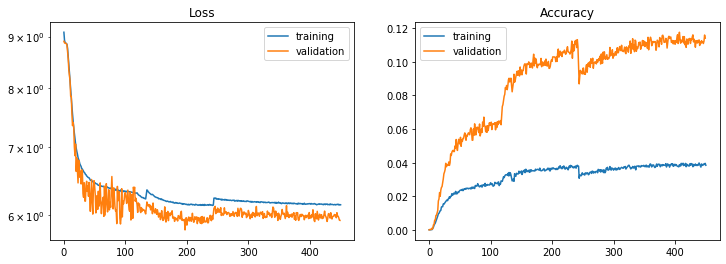

In [9]:
# Plot the training and validation losses.
tloss = np.loadtxt("train.txt")
vloss = np.loadtxt("val.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.plot(vloss[:,0],vloss[:,1],label='validation')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.plot(vloss[:,0],vloss[:,2],label='validation')
plt.legend()
plt.title("Accuracy")

### Evaluate all events from a dataset

In [ ]:
dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=10)
softmax = nn.Softmax(dim=1)
model.eval()

In [ ]:
SHIFTED_ERR_RANGE_MIN = tr.PIXEL_ERR_RANGE_MIN - dset.add_shift*tr.PIXEL_SIZE
SHIFTED_ERR_RANGE_MAX = tr.PIXEL_ERR_RANGE_MAX + dset.add_shift*tr.PIXEL_SIZE
ERR_PIXEL_SIZE = tr.PIXEL_SIZE*(2*dset.add_shift+1)/tr.ERR_SIZE

def mult_gaussFun_Fit(x_y,*m):
    (x,y) = x_y
    A,x0,y0,varx,vary,C = m
    #print("x0 is {}".format(x0))
    X,Y = np.meshgrid(x,y)
    Z = A*np.exp(-0.5*((X-x0)**2/(varx)+(Y-y0)**2/(vary))) + C
    return Z.ravel()

# Compute sigma_x and sigma_y of the given probability distribution
def compute_sigmas(prob_dist):
    
    sum_tot = 0
    sum_x, sum_xsq = 0, 0
    sum_y, sum_ysq = 0, 0
    vmax = np.max(prob_dist)
    for i in range(prob_dist.size):
        
        xi = int(i % tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
        yi = int(i / tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
        
        vi = prob_dist[np.unravel_index(i,prob_dist.shape)]
        
        # Use a threshold of some fraction of vmax.
        if(vi > vmax / 10):
            sum_x   += xi*vi
            sum_xsq += xi**2*vi
            sum_y   += yi*vi
            sum_ysq += yi**2*vi
            sum_tot += vi
    
    # Compute mean and sigma.
    mean_x = sum_x/sum_tot
    mean_y = sum_y/sum_tot
    sigma_x = (sum_xsq/sum_tot - mean_x**2)**0.5
    sigma_y = (sum_ysq/sum_tot - mean_y**2)**0.5
    
    return sigma_x, sigma_y

def fit_sigmas(prob_dist,x,y,x0,y0,sigma_x0,sigma_y0):
    """
    Fit a 2D gaussian for sigma_x and sigma_y.
    
    prob_dist: the probability distribution
    x: a 1D list of the x-coordinates on the 2D grid (in mm)
    y: a 1D list of the y-coordinates on the 2D grid (in mm)
    x0: the initial guess for the x-value of the mean
    y0: the initial guess for the y-value of the mean
    sigma_x0: the initial guess for the sigma in the x-direction
    sigma_y0: the initial guess for the sigma in the y-direction
    """
    initial_guess = [np.max(prob_dist), x0, y0, sigma_x0**2, sigma_y0**2, np.max(prob_dist)/10.]
    bounds = ([0,x0-10*ERR_PIXEL_SIZE,y0-10*ERR_PIXEL_SIZE,0,0,0],[2*np.max(prob_dist),x0+10*ERR_PIXEL_SIZE,y0+10*ERR_PIXEL_SIZE,0.05,0.05,np.max(prob_dist)])
    
    try:
        popt, pcov = curve_fit(mult_gaussFun_Fit, (x, y), prob_dist.ravel(), p0=initial_guess, bounds=bounds)
    except (RuntimeError):
        print("Error in fit; using initial guess")
        return initial_guess,None
    
    return popt, pcov

In [ ]:
evts = np.arange(80000,90000)

# Get the x and y coordinates of the 2D error prediction grid, in mm.
x_errgrid = np.arange(0,tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
y_errgrid = np.arange(0,tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2

l_evt, l_xtrue, l_ytrue, l_xpred, l_ypred, l_sigmax, l_sigmay = [], [], [], [], [], [], []
for evt in evts:
    
    evt_item = dset[evt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1]
    evt_err_ind = evt_item[2]

    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    target = torch.tensor(np.array(evt_err_ind)).long().cuda()
    output_score = model(data)
    
    # Compute the predicted pixel and (x,y) values.
    prob = np.array(softmax(output_score).cpu().detach().numpy()).reshape([tr.ERR_SIZE,tr.ERR_SIZE])
    ipred = np.argmax(prob)
    xpred = int(ipred % tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
    ypred = int(ipred / tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
    #print("[Evt",evt,"]: Index is",evt_err_ind,"with predicted",ipred,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))
    
    # Compute the sigmas of the distribution.
    sigma_x0, sigma_y0 = compute_sigmas(prob)
    popt, pcov = fit_sigmas(prob,x_errgrid,y_errgrid,xpred,ypred,sigma_x0,sigma_y0)
    sigma_x = popt[3]**0.5
    sigma_y = popt[4]**0.5
    #print("sigma_x = {}, initial estimate {}".format(sigma_x,sigma_x_i))
    #print("sigma_y = {}, initial estimate {}".format(sigma_y,sigma_y_i))
    
    # Fill the lists.
    l_evt.append(evt)
    l_xtrue.append(evt_lbl[0])
    l_ytrue.append(evt_lbl[1])
    l_xpred.append(xpred)
    l_ypred.append(ypred)
    l_sigmax.append(sigma_x)
    l_sigmay.append(sigma_y)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
        print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))

# Create the dataframe.
evt_dict = {'event': l_evt, 'x_true': l_xtrue, 'y_true': l_ytrue, 'x_pred': l_xpred, 
            'y_pred': l_ypred, 'sigma_x': l_sigmax, 'sigma_y': l_sigmay}
df = pd.DataFrame.from_dict(evt_dict)

# Create derived quantities.
df["sigma_r"] = (df.sigma_x**2 + df.sigma_y**2)**0.5
df["error_x"] = df.x_pred - df.x_true
df["error_y"] = df.y_pred - df.y_true
df["error_r"] = (df.error_x**2 + df.error_y**2)**0.5

In [ ]:
cut_sigma = 0.011

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
plt.hist(df[df.sigma_r < cut_sigma].error_r,bins=50)
plt.yscale("log")
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("Counts/bin")

ax2 = fig.add_subplot(122)
plt.hist(df[df.sigma_r < cut_sigma].sigma_r,bins=50)
plt.xlabel("$\sqrt{\sigma_x^2 + \sigma_y^2}$ of probability distribution (mm)")
plt.ylabel("Counts/bin")

In [ ]:
eff, mean_err = [], []
cut_sigmas = np.arange(0.003,0.4,0.0005)
for cut_sigma in cut_sigmas:
    df_cut = df[df.sigma_r < cut_sigma]
    
    eff.append(len(df_cut)/len(df))
    mean_err.append(df_cut.error_r.mean())
    
    print("[SIGMA = {}]: EFF = {}, ERR = {}".format(cut_sigma,len(df_cut)/len(df),df_cut.error_r.mean()))

eff = np.array(eff)
mean_err = np.array(mean_err)
plt.plot(mean_err,eff,'.-')
plt.xlabel("Mean error (mm)")
plt.ylabel("Efficiency")


### Test the net

In [ ]:
dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=10)
softmax = nn.Softmax(dim=1)
model.eval()

In [ ]:
evt_plt = 81000
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]

SHIFTED_ERR_RANGE_MIN = tr.PIXEL_ERR_RANGE_MIN - dset.add_shift*tr.PIXEL_SIZE
SHIFTED_ERR_RANGE_MAX = tr.PIXEL_ERR_RANGE_MAX + dset.add_shift*tr.PIXEL_SIZE

xbin = int(tr.ERR_SIZE*(evt_lbl[0] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
xbin = max(xbin,0)
xbin = min(xbin,tr.ERR_SIZE-1)

ybin = int(tr.ERR_SIZE*(evt_lbl[1] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
ybin = max(ybin,0)
ybin = min(ybin,tr.ERR_SIZE-1)

print("Computed index:",(ybin*tr.ERR_SIZE) + xbin,"for max added shift:",dset.add_shift)

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
target = torch.tensor(np.array(evt_err_ind)).long().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(softmax(output_score).cpu().detach().numpy()).reshape([tr.ERR_SIZE,tr.ERR_SIZE])
ipred = np.argmax(prob)
xpred = int(ipred % tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
ypred = int(ipred / tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
#print("[Evt",evt,"]: Index is",evt_err_ind,"with predicted",ipred,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))

# Compute the sigmas of the distribution.
sigma_x0, sigma_y0 = compute_sigmas(prob)
popt, pcov = fit_sigmas(prob,x_errgrid,y_errgrid,xpred,ypred,sigma_x0,sigma_y0)
fit_data = mult_gaussFun_Fit((x_errgrid,y_errgrid),*popt).reshape([tr.ERR_SIZE,tr.ERR_SIZE])
print("Gaussian fit parameters A*exp(-0.5*((x-x0)**2/varX + (y-y0)**2/varY)) + C:")
print("A = {}".format(popt[0]))
print("(x0, y0) = ({},{})".format(popt[1],popt[2]))
print("(sigma_x, sigma_y) = ({},{})".format(popt[3]**0.5,popt[4]**0.5))
print("C = {}".format(popt[5]))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift ({:.3e},{:.3e}); index {}".format(evt_plt,evt_lbl[0],evt_lbl[1],evt_err_ind))

ax2 = fig.add_subplot(132)
ax2.plot([xbin],[ybin],color='red',marker='o',markersize=10)
plt.imshow(prob)
plt.colorbar()
plt.title("Incidence point within prediction grid")

ax3 = fig.add_subplot(133)
plt.imshow(fit_data)
plt.colorbar()
plt.title("2D Gaussian fit")

# Misc. code

In [ ]:
# Look at many events:
xpred_err, ypred_err = [], []
for evt_plt in np.arange(8000,9999):
    
    evt_item = dset[evt_plt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1]
    evt_err_ind = evt_item[2]

    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    target = torch.tensor(np.array(evt_err_ind)).long().cuda()

    output_score = model(data)
    prob = np.argmax(np.array(softmax(output_score).cpu().detach().numpy()).reshape([10,10]))
    xpred = (prob % tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    ypred = (prob / tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    print("[Evt",evt_plt,"]: Index is",evt_err_ind,"with predicted",prob,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))
    
    xpred_err.append(xpred-evt_lbl[0])
    ypred_err.append(ypred-evt_lbl[1])
xpred_err = np.array(xpred_err)
ypred_err = np.array(ypred_err)

In [ ]:
fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
plt.hist(xpred_err)
plt.xlabel("error in x-prediction (mm)")
print(np.where(abs(xpred_err) > 0.001))

ax2 = fig.add_subplot(122)
plt.hist(ypred_err)
plt.xlabel("error in y-prediction (mm)")
